In [10]:
import os,sys
sys.path.append('./PTS')

import numpy as np

from astropy import units as u
from astropy import constants as c
from astropy.io import ascii
from astropy.time import TimeDelta 
from astropy.time import Time
from astropy.modeling.models import BlackBody

from scipy import optimize as opt
from scipy.integrate import quad

import datetime
import json
from utils import *
from opt_depth import *

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.colors as colors
%matplotlib inline

from run_skirt_new import get_lightcurve

In [2]:
#Setting a colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

#Taking cubehelix as base, but removing lightest and darkest colours
cmap = plt.get_cmap('cubehelix')
thesis_cmap = truncate_colormap(cmap, 0.05, 0.83)

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(arr, interpolation='nearest', cmap='cubehelix')
ax[1].imshow(arr, interpolation='nearest', cmap=thesis_cmap)
plt.show()

cmap = thesis_cmap

23/05/2024 22:36:12.457 ! /var/tmp/lankhorst/ipykernel_1174850/3642952532.py:16: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
23/05/2024 22:36:12.457 !   plt.show()


In [3]:
#From Mummery, van Velzen et al. 2023, with some alterations:
def get_lightcurve_data(tde_name = 'ASASSN-15lh', datafolder='data_new'):
	"""
	Input: 
		The TDEs name

	Returns:
		1. A dictionary with all of the light curve data, labelled by observing band. 
		2. A list of lightcurve filters with available data. 
	"""

	fname = './{0}/{1}/{1}.json'.format(datafolder,tde_name)
	tde_data = json.load(open(fname,'r'))# Load data. 

	# These conversion are needed because json doesn't store tuples.
	dt = [tuple(x) for x in tde_data['lightcurve']['dtype']]
	lc_obj = [tuple(x) for x in tde_data['lightcurve']['data']] 

	# Make a recarray. 
	lc_rec = np.array(lc_obj, dtype=dt)
	mjd0 = tde_data['peak_mjd']

	lc_dict = {}
	filters = tde_data['lightcurve']['filters']
	frequency_Hz = tde_data['lightcurve']['frequency_Hz']

	for flt in filters:
		idx = lc_rec['filter']==flt

		flux = lc_rec[idx]['flux_Jy']
		flux_corr = flux / tde_data['extinction']['linear_extinction'][flt]# Correct for extinction. 

		lc_dict[flt] = [lc_rec[idx]['mjd']-mjd0, flux_corr, lc_rec[idx]['e_flux_Jy']]
	return lc_dict, filters, frequency_Hz,mjd0

def data_luminosity(tde_name='ASASSN-15lh',datafolder='data_new',distance=1171*u.Mpc):
    """  Needs docstring """
    lc_dict,filters,frequency_Hz,mjd0 = get_lightcurve_data(tde_name=tde_name,datafolder=datafolder)
    L = [[],[],[],[]]    
    for flt in filters:
        t,F,e_F = lc_dict[flt]
        F, e_F = FluxtoLum(F*u.Jy,distance=distance),FluxtoLum(e_F*u.Jy,distance=distance)
        idx = filters.index(flt)
        F,e_F = F*frequency_Hz[idx]*u.Hz, e_F*frequency_Hz[idx]*u.Hz
        L[0]=np.append(L[0],t)
        L[1]=np.append(L[1],F.value)
        L[2]=np.append(L[2],e_F.value)
        L[3]=np.append(L[3],[frequency_Hz[idx]]*len(F))
    return np.array(L)

In [4]:
# Define Target and Folders
target = 'ASASSN-15lh'
distance = 1171*u.Mpc
_, filters, SWIFT_freq, mjd0 = get_lightcurve_data() 
lightcurve = True

today = str(datetime.date.today())
starttime = datetime.datetime.now().strftime('%H%M')

OUTFILES = "results/"+target+'/'+today+'_p'+'/'+starttime+'/'
PLOTFILES = "plots/"+target+'/'+today+'_p'+'/'+starttime+'/'
DATAFILES = "data/"+target+'/'

if os.path.isdir(DATAFILES) == False:
    os.makedirs(DATAFILES[:-1])
if os.path.isdir(OUTFILES) == False:
    os.makedirs(OUTFILES[:-1])
if os.path.isdir(PLOTFILES) == False:
    os.makedirs(PLOTFILES[:-1])

log=open(OUTFILES+'log.txt','a')

In [5]:
# Define Simulation Parameters

timesteps = 10          # amount of timesteps considered by SKIRT
output_tsteps = 100     # desired amount of timesteps after interpolation

amin = 0.005            # smallest dust grain size in micron, 1e-4 is the lowest value supported by SKIRT, 0.005 from paper with opacity
amax = 0.1              # largest dust grain size in micron
grainpowerlaw = 2.5     # the powerlaw distribution of mass along different grain sizes
alpha = 1               # radial dust mass density powerlaw

opt_depth = 10          # Optical depth of dust structure
axis = 'Z'              # Axis along which to measure the optical depth
wl_opt_depth = 0.28     # Wavelength along which to measure optical depth

Si = 0.                 # silicates fraction (as opposed to graphites)

centralBin = 0.1        # size of central grid section in pc
outer = 0.15            # outer radius of the dust shell in pc
spaceBins = 10          # number of spatial shells in the radial direction

#total_mass = (mass_from_opacity(centralBin,outer,10,10**(0.836))).value
total_mass = mass_from_opt_depth(amax,centralBin,outer,opt_depth,find_cross_section('/data/DraineGrains/callqcomp.txt',wl_opt_depth,amax)).value # of the dust in MSun

static = True

Closest available grain size was 0.10024 micron, with 0.00024 micron difference.
Closest available wavelength was 0.28054 micron, with 0.00054 micron difference.


In [28]:
# Load the TDE lightcurve
L = data_luminosity(tde_name = target, datafolder = 'data_new', distance=distance) #nu_Lnu of the data
WISE_data =ascii.read(DATAFILES+'ASASSN-15lh_neoWISE_diffphoto.dat',format='fixed_width')
W1 = np.array([WISE_data['mjd']-mjd0,FluxtoLum(WISE_data['w1_flux_Jy']*u.Jy,distance=distance),FluxtoLum(WISE_data['w1_flux_Jy_err']*u.Jy,distance=distance)])
W2 = np.array([WISE_data['mjd']-mjd0,FluxtoLum(WISE_data['w2_flux_Jy']*u.Jy,distance=distance),FluxtoLum(WISE_data['w2_flux_Jy_err']*u.Jy,distance=distance)])

# Central wavelengths of the 2 WISE filters
wl_w1=3.368*u.um
wl_w2=4.618*u.um

#Sorting the data based on time
sorted_indices = L[0].argsort()

# Reduce the amount of timesteps to 'timesteps', with a number of them concentrated close to the peak
# if timesteps is increased, users might want to omit this
t_data=np.concatenate(([np.min(L[0]),np.sort(L[0])[1],np.sort(L[0])[2],np.min(L[0])+20],\
                       np.linspace(np.min(L[0])+40,np.max(L[0]),timesteps-3)))

L_data=binning(t_data,L[0],L[1],L[2])
t_data=L_data[0]

#To find the bolometric luminosity correction factor, compare the surface beneath the luminosity 
#of a blackbody with temperature 2e4 K to the nu*L_nu of that same blackbody at the SWIFT frequencies.
# Integrate the function over a big finite range, that includes almost all blackbody's emission
Lbol, err = quad(blackbody_Lnu,0.1,1e18) #blackbounction can be found in utils
Lbol_factor = np.array([Lbol/(blackbody_Lnu(i)*i) for i in L[3]])

#Binning the correction factor in the same way as the data earlier to use in SKIRT input
tbol_data=np.concatenate(([np.min(L[0]),np.sort(L[0])[1],np.sort(L[0])[2],np.min(L[0])+20],\
                       np.linspace(np.min(L[0])+40,np.max(L[0]),timesteps-3)))
Lbol_data=binning(tbol_data,L[0],L[1]*Lbol_factor,L[2]*Lbol_factor,clean=False)
tbol_data = Lbol_data[0]


# We will use a constant temperature of 2e4 K here, 
# as our data set does not provide a very accurate read on the TDE's temperature evolution
Tbol_data = np.array((Lbol_data[0],[2e4]*len(Lbol_data[2])))

output_t = np.linspace(np.min(t_data),np.max(t_data)+0.3*(np.max(t_data)-np.min(t_data)),output_tsteps)
w1w2 = np.array([3.368,4.618])
bbwl = np.array([0.29*1e4/(Tbol_data[1][0])]) #From Wiens law: wavelength at which the black body peaks
output_wavelengths = np.sort(np.concatenate((np.linspace(0.01, 1, 2), np.linspace(1.01, 10, 80), \
                                              np.linspace(10.01, 50, 100),w1w2,bbwl)))
relBinwidth = 0.0001  #Relative bin width for the wavelength bins.

In [7]:
# Plotting the input data
if lightcurve:
    plt.figure()
    plt.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=np.abs((c.c/wl_w1).to(u.Hz).value*W1[2]),\
                 fmt='.',capsize=3,color='slategrey',label='IR-WISE/W1')
    plt.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=np.abs((c.c/wl_w2).to(u.Hz).value*W2[2]),\
                 fmt='.',capsize=3,color='indianred',label='IR-WISE/W2')
    plt.errorbar(L[0],L[1],yerr=L[2],fmt='.',alpha=0.05,capsize=3,color='blue')
    plt.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
    plt.xlabel('Days since UV peak')
    plt.ylabel(r"$\nu\,L_{\nu}\,[erg\,s^{-1}]$")
    plt.title(target+' Light Curve')
    plt.yscale('log')
    plt.legend()
    plt.savefig(OUTFILES+target+'_lightcurve.pdf')
    plt.show()

23/05/2024 22:36:14.582 ! /var/tmp/lankhorst/ipykernel_1174850/1221238976.py:16: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
23/05/2024 22:36:14.582 !   plt.show()


In [8]:
# This implementation cannot track dust survival time
# Therefore dust sublimation is based on the lightcurve's FWHM
# We find this here by fitting a gaussian

def gauss(x, p): # p[0]==mean, p[1]==stdev
    return 1.0/(p[1]*np.sqrt(2*np.pi))*np.exp(-(x-p[0])**2/(2*p[1]**2))
N = len(L[0,:])
X = L[0,:]
Y = L[1,:]

p0 = [L[0,np.argmax(L[1,:])],100] # Inital guess is a normal distribution
errfunc = lambda p, x, y: gauss(x, p) - y # Distance to the target function
p1, success = opt.leastsq(errfunc, p0[:], args=(X, Y))
fit_mu, fit_stdev = p1
FWHM = 2*np.sqrt(2*np.log(2))*fit_stdev
print("FWHM", FWHM)

# Plot to verify the fit
plt.figure()
plt.scatter(X,Y,s=0.1,label='Data')
fit=gauss(X,p1)
plt.scatter(X, np.max(Y)/np.max(fit) * fit,s=0.5,alpha=0.5, color='r',label='Gaussian Fit')
plt.axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='g', alpha=0.5,label='FWHM')
plt.legend()
plt.savefig(OUTFILES+'FWHM.pdf')
plt.show()


# Looking at the first plot shows that the second peak in 15lh's lightcurve is dictating the FWHM
# As this is undesirable, we will not use this part for the fit
def gauss(x, p): # p[0]==mean, p[1]==stdev
    return 1.0/(p[1]*np.sqrt(2*np.pi))*np.exp(-(x-p[0])**2/(2*p[1]**2))

mask = (L[0]<57260)
N = len(L[0,mask])
X = L[0,mask]
Y = L[1,mask]

p0 = [L[0,np.argmax(L[1,:])],L[0,np.argmin(np.abs(L[1]-0.5*np.max(L[1])))]-L[0,np.argmax(L[1,:])]] # Inital guess is a normal distribution
errfunc = lambda p, x, y: gauss(x, p) - y # Distance to the target function
p1, success = opt.leastsq(errfunc, p0[:], args=(X, Y))
fit_mu, fit_stdev = p1
FWHM = 2*np.sqrt(2*np.log(2))*fit_stdev 
print("FWHM", FWHM)

# Plot to verify the fit
plt.figure()
plt.scatter(X,Y,s=1,label='Data')
fit=gauss(X,p1)
plt.scatter(X, np.max(Y)/np.max(fit) * fit,s=1,alpha=0.75, color='r',label='Gaussian Fit')
#plt.axvspan(fit_mu-FWHM/2, fit_mu+FWHM/2, facecolor='g', alpha=0.25,label='FWHM')
plt.axvline(fit_mu+FWHM/2, label='FWHM', linestyle='dashed')
plt.legend()
plt.savefig(OUTFILES+'FWHM.pdf')
plt.show()

23/05/2024 22:36:14.740 ! /var/tmp/lankhorst/ipykernel_1174850/494375816.py:26: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
23/05/2024 22:36:14.740 !   plt.show()


FWHM 235.48200450309494
FWHM 41.38972293902923


23/05/2024 22:36:14.903 ! /var/tmp/lankhorst/ipykernel_1174850/494375816.py:55: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
23/05/2024 22:36:14.903 !   plt.show()


In [9]:
def select_filter_data(L, filter_values):
    selected_data = {}
    for i, filter_val in enumerate(filter_values, start=1):
        filter_indices = np.argwhere(np.isclose(L[3], filter_val)).flatten()
        time_range = np.squeeze(L[0][filter_indices])
        light = np.squeeze(L[1][filter_indices])
        error = np.squeeze(L[2][filter_indices])
        selected_data[i] = {'time_range': time_range, 'light': light, 'error': error}
    return selected_data

#Only selecting data from certain filters
selected_data = select_filter_data(L, np.unique(L[3]))
data = selected_data[1]

time_range, light, error = data['time_range'], data['light'], data['error']
def convolution(rinner_pc,flux_pick,mjd_pick):
    """
     Makes a convolution of a step function with length 2r/c and value c/(2r) with the luminosity data.
     Returns the time and flux of this convolution.
     Parameters
     ----------
     rinner_pc : float
          The outer radius of the dust shell.
     flux_pick: array
          Array containing the flux of the original source. 
     mjd_pick: array 
          Time in MjD.
    """
    rinner_days = ((rinner_pc*u.pc / c.c ).to(u.day)).value
    
    transfunc_time = np.arange(0,2*rinner_days+100, 0.5)
    transfunc_amp = np.zeros(len(transfunc_time))
    transfunc_amp[transfunc_time<2*rinner_days]= 1/ (2*rinner_days)

    # padding with zeros
    flux_pick = np.append(0, flux_pick)
    flux_pick = np.append(flux_pick, 0)

    mjd_pick = np.append(mjd_pick[0]-1,mjd_pick)
    mjd_pick = np.append(mjd_pick, mjd_pick[-1]+1)
    
    # define output times for convolved function
    lc_conv_time = np.arange(mjd_pick[0]-10,mjd_pick[-1]+2*rinner_days+10, 2)  # grid with 2 day steps
    lc_conv_flux = np.zeros(len(lc_conv_time))

    # loop and find the flux of the light curve that contributes 
    for i, ctime in enumerate(lc_conv_time):
        flux_before = np.interp(ctime-transfunc_time, mjd_pick, flux_pick) # we look "back in time"
        lc_conv_flux[i] = np.trapz(flux_before*transfunc_amp, transfunc_time) # the tranfer function is normalized
    return lc_conv_time, lc_conv_flux

#Plotting the convolutions
cmap = plt.get_cmap('cubehelix')
for j in range(6):
    color = cmap(j/6) #Get the color from the colormap
    if j == 5:
        lc_conv_time,lc_conv_flux = convolution(centralBin,L[1][sorted_indices],L[0][sorted_indices])
        plt.plot(lc_conv_time,lc_conv_flux,label = 'Convolution with all data',color=color) 
    else:
        data = selected_data[j+1]
        time_range, light= data['time_range'], data['light']
        lc_conv_time,lc_conv_flux = convolution(centralBin,light,time_range)
        plt.plot(lc_conv_time,lc_conv_flux,label = f'Convolution with filter {filters[j].replace(".uvot","")}',color=color)

rinner_days = ((centralBin*u.pc / c.c ).to(u.day)).value


plt.errorbar(L[0],L[1], yerr=L[2], fmt='.', alpha=0.05, capsize=3, color = 'blue')
plt.yscale('log')
plt.axvline(x= L[0][sorted_indices[0]]+ 2* rinner_days,linestyle = '--', label = "2R/c", alpha = 0.5, color = 'red')
plt.legend()
plt.xlabel('Days')
plt.ylabel(r"$\nu\,L_{\nu}\,[erg\,s^{-1}]$")
plt.show()

23/05/2024 22:36:15.383 ! /var/tmp/lankhorst/ipykernel_1174850/1849528193.py:74: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
23/05/2024 22:36:15.383 !   plt.show()


# Single run

In [12]:
output_wavelengths = np.sort(np.concatenate((np.linspace(0.01, 1, 20), np.linspace(1.01, 10, 800), \
                                              np.linspace(10.01, 50, 1000),w1w2,bbwl)))

normalization_type='mass'
static = True

OUTFILES_ = OUTFILES+normalization_type+'/'
PLOTFILES_ = PLOTFILES+normalization_type+'/'

if os.path.isdir(OUTFILES_) == False:
    os.makedirs(OUTFILES_[:-1])
if os.path.isdir(PLOTFILES_) == False:
    os.makedirs(PLOTFILES_[:-1])
log_=open(OUTFILES_+'log.txt','a')

output_wavelengths = np.sort(np.concatenate((np.linspace(0.5, 1, 10), np.linspace(1.01, 10, 80), \
                                              np.linspace(10.01, 50, 100),w1w2,bbwl)))

lightcurve,wavelengths,temp,radius,simulation = get_lightcurve(np.array((Lbol_data[0],Lbol_data[1] \
                                                                         ,Lbol_data[2])) \
                                                               ,Tbol_data, tbol_data, output_t, np.append(output_wavelengths,relBinwidth) \
                                                               ,[centralBin,outer,alpha] \
                                                               ,[[amin,amax,grainpowerlaw],[amin,amax,grainpowerlaw]], spaceBins \
                                                               ,normalization_type=normalization_type \
                                                               ,total_mass = total_mass, opt_depth = [10,0.28,'Z'], nsizes=2 \
                                                               ,static=static,FWHM=FWHM \
                                                               ,distance=distance,skiname='SKI/ski_new.txt', Si=0.3 \
                                                               ,prefix=str(today), OUTFILES=OUTFILES_, SKIRTpath='SKIRT/release/SKIRT/main/skirt',suffix='_p')


Now simulating the lightcurve for a sphere with 2 dust grain sizes, mass normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

23/05/2024 17:20:06.317   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
23/05/2024 17:20:06.317   Running on student70.strw.leidenuniv.nl for lankhorst
23/05/2024 17:20:06.318   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-23_p/1659/mass/7/run.ski'...
23/05/2024 17:20:06.327 * *** Error: Error in XML stream '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-23_p/1659/mass/7/run.ski' at line 68
23/05/2024 17:20:06.327 * *** Error: Value '-0.05500000000000002' for property 'minWavelength' is out of range [1e-6 micron,1e6 micron]
23/05/2024 17:20:06.327 * *** Error: On line 184 in file /net/vdesk/data2/Lankhorst/brp/SKIRT/git/SMILE/fundamentals/XmlReader.cpp
23/05/2024 17:20:06.327 * *** Error: In function throwError
23/05/2024 17:20:06.327 * *** Error: Call stack:
23/05/2024 17:20:06.327 * *** Error: /net/vdesk/data2/Lankhorst/brp/SKIRT/release/SKIRT/main/skirt(_ZN10FatalErrorC2ENSt7__cxx1112basic_strin

In [ ]:
# indices corresponding to the WISE filter and black body peak wavelengths
w1=np.argmin(np.abs(wavelengths-wl_w1.value))
w2=np.argmin(np.abs(wavelengths-wl_w2.value))
bbwl_i=np.argmin(np.abs(wavelengths-bbwl))

# Convert the lightcurve to luminosity
luminosity=FluxtoLum(lightcurve,distance=distance)
# Calculate the covering factor
# in this simulation a spherical dust shell is used,
# as we expect a clumpy dust structure a covering factor is applied to account for the higher luminosity.
coveringFactor=np.max(W1[1]*u.erg/u.s/u.Hz)/luminosity[np.argmin(np.abs(output_t-W1[0,np.argmax(W1[1])])),w1]

# Save the data
log_.write('amax='+str(amax)+', grainpowerlaw='+str(grainpowerlaw)+', coveringFactor='+str(coveringFactor)+', sublimation radius='+str(np.min(radius))+', T_min='+np.array2string(np.array(temp),max_line_width=len(temp)*100))
log_.write('\n')
if os.path.isdir(OUTFILES_+'GridSearch/')==False:
    os.makedirs(OUTFILES_+'GridSearch/')
if os.path.isdir(PLOTFILES_+'/')==False:
    os.makedirs(PLOTFILES_+'/')

np.savetxt(OUTFILES_+'config.txt',luminosity.value)

## Making the lightcurves

In [ ]:
#Applying the covering factor
luminosity_cov = luminosity * coveringFactor
cover = False
#Setting up the convolution
conv_time,conv_lum = convolution(centralBin,L[1][sorted_indices],L[0][sorted_indices])

#Making lightcurve plot including the SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Plotting the convolution
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity[:,w1]).to(u.erg/u.s),label='W1',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity[:,w2]).to(u.erg/u.s),label='W2',color='indianred')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity[:,bbwl_i]).to(u.erg/u.s),label='BB peak wavelength',color='green')

#Plotting the lightcurves with covering factors if wanted
if cover:
    ax.plot(output_t,((c.c/wl_w1)*luminosity_cov[:,w1]).to(u.erg/u.s),label='W1 fit',color='slategrey',ls='--')
    ax.plot(output_t,((c.c/wl_w2)*luminosity_cov[:,w2]).to(u.erg/u.s),label='W2 fit',color='indianred',ls='--')

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')

ax.set_yscale('log')
ax.set_ylim(bottom=np.max(L_data[1])/1e5,top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model x Thin Shell')
if cover:
    fig.savefig(PLOTFILES_+'/lightcurve_cov_SWIFT.pdf')
else:
    fig.savefig(PLOTFILES_+'/lightcurve_SWIFT.pdf')
fig.show()

#Making lightcurve plot without the SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Plotting the convolution
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity[:,w1]).to(u.erg/u.s),label='W1',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity[:,w2]).to(u.erg/u.s),label='W2',color='indianred')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity[:,bbwl_i]).to(u.erg/u.s),label='BB peak wavelength',color='green')

#Plotting the lightcurves with covering factors
if cover:
    ax.plot(output_t,((c.c/wl_w1)*luminosity_cov[:,w1]).to(u.erg/u.s),label='W1 fit',color='slategrey',ls='--')
    ax.plot(output_t,((c.c/wl_w2)*luminosity_cov[:,w2]).to(u.erg/u.s),label='W2 fit',color='indianred',ls='--')

#Plotting W1&2 data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')

ax.set_yscale('log')
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
ax.set_ylim(bottom=1e37,top=1e45)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model x Thin Shell')
if cover:
    fig.savefig(PLOTFILES_+'/lightcurve_cov_noSWIFT.pdf')
else:
    fig.savefig(PLOTFILES_+'lightcurve_noSWIFT.pdf')
fig.show()

## Making the spectra

In [ ]:
times=(np.array([1,50,80]))

fig=plt.figure()
ax=plt.subplot(111)

cmap = plt.get_cmap('cubehelix')

for t in range(len(times)):
    color = cmap(t/len(times)) #Get the color from the colormap
    ax.scatter(output_wavelengths, lightcurve[times[t]],color=color,s=.8)    
    ax.loglog(output_wavelengths,lightcurve[times[t]],label=f'MJD {int(output_t[times[t]])}',color=color,linewidth=0.8)

ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel(r'Flux [Jy]$')
ax.set_ylim(bottom=np.max(lightcurve[times[-1]].value)/1e4,top=np.max(lightcurve[times[0]].value*2))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title(f'{target} spectra, {normalization_type} normalization')
ax.set_xlim(np.min(output_wavelengths),np.max(output_wavelengths)+1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(PLOTFILES_+'/spectra.pdf')
fig.show()

# Comparing normalisation methods

## Mass

In [15]:
#Start the run
output_wavelengths = np.sort(np.concatenate((np.linspace(0.01, 1, 2), np.linspace(1.01, 10, 80), \
                                              np.linspace(10.01, 50, 100),w1w2,bbwl)))
normalization_type='mass'
total_mass = 0.0463276

OUTFILES_ = OUTFILES+'comparing/'+normalization_type+'/'
PLOTFILES_ = PLOTFILES+'comparing/'+normalization_type+'/'

if os.path.isdir(OUTFILES_) == False:
    os.makedirs(OUTFILES_[:-1])
if os.path.isdir(PLOTFILES_) == False:
    os.makedirs(PLOTFILES_[:-1])
log_=open(OUTFILES_+'log.txt','a')

lightcurve_mass,wavelengths_mass,temp_mass,radius_mass,simulation_mass = get_lightcurve(np.array((L_data[0],L_data[1]*Lbol_factor \
                                                                         ,L_data[2]*Lbol_factor)) \
                                                               ,T_data, t_data, output_t \
                                                               ,[centralBin,outer,alpha] \
                                                               ,[amax,amin,grainpowerlaw], spaceBins \
                                                               ,normalization_type=normalization_type \
                                                               ,total_mass = total_mass, opt_depth = [10,0.28,'Z'], nlayers=1 \
                                                               ,static=static,FWHM=FWHM, output_wavelengths=np.append(output_wavelengths,relBinwidth) \
                                                               ,distance=distance,skiname='SKI/combined_ski.txt', Si=False \
                                                               ,prefix=str(today), OUTFILES=OUTFILES_, SKIRTpath='SKIRT/release/SKIRT/main/skirt',name='pepijn')

TypeError: get_lightcurve_test() got an unexpected keyword argument 'nlayers'

In [12]:
# indices corresponding to the WISE filter and black body peak wavelengths
w1=np.argmin(np.abs(wavelengths_mass-wl_w1.value))
w2=np.argmin(np.abs(wavelengths_mass-wl_w2.value))
bbwl_i = np.argmin(np.abs(wavelengths_mass-bbwl))

# Convert the lightcurve to luminosity
luminosity_mass=FluxtoLum(lightcurve_mass,distance=distance)
# Calculate the covering factor
# in this simulation a spherical dust shell is used, 
# as we expect a clumpy dust structure a covering factor is applied to account for the higher luminosity.
coveringFactor_mass=np.max(W1[1]*u.erg/u.s/u.Hz)/luminosity_mass[np.argmin(np.abs(output_t-W1[0,np.argmax(W1[1])])),w1]

# Save the data
log_.write('amax='+str(amax)+', grainpowerlaw='+str(grainpowerlaw)+', coveringFactor='+str(coveringFactor_mass)+', sublimation radius='+str(np.min(radius_mass))+', T_min='+np.array2string(np.array(temp_mass),max_line_width=len(temp_mass)*100))
log_.write('\n')
if os.path.isdir(OUTFILES_+'GridSearch/')==False:
    os.makedirs(OUTFILES_+'GridSearch/')
if os.path.isdir(PLOTFILES_+'/')==False:
    os.makedirs(PLOTFILES_+'/')

np.savetxt(OUTFILES_+'config.txt',luminosity_mass.value)

NameError: name 'wavelengths_mass' is not defined

## Making the lightcurves

06/05/2024 13:57:27.720 ! /var/tmp/lankhorst/ipykernel_1982247/3127703752.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 13:57:27.720 !   fig.show()
06/05/2024 13:57:28.038 ! /var/tmp/lankhorst/ipykernel_1982247/3127703752.py:78: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 13:57:28.038 !   fig.show()


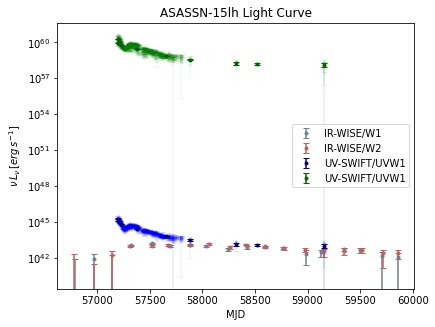

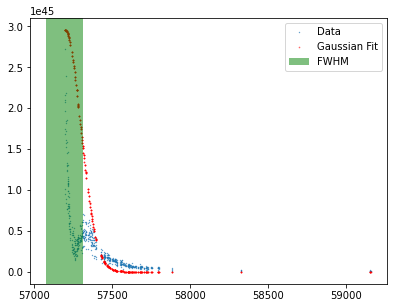

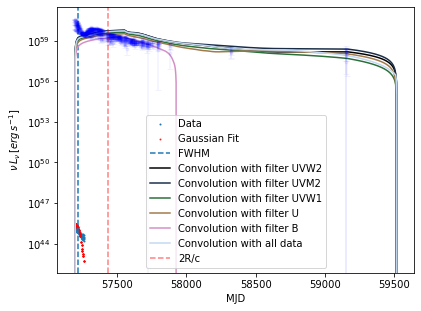

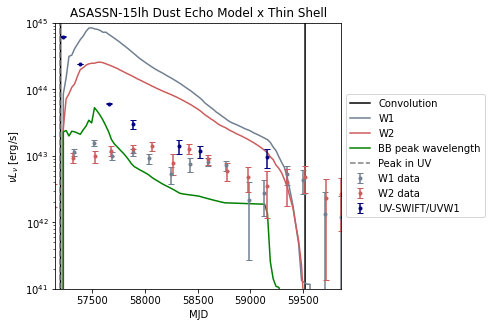

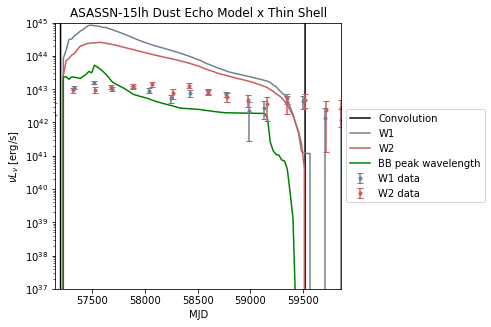

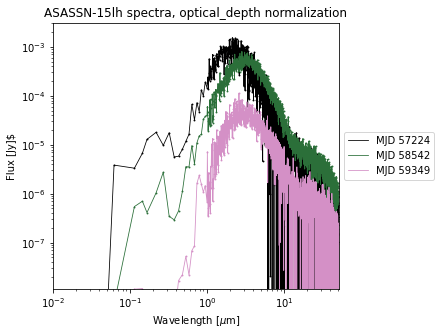

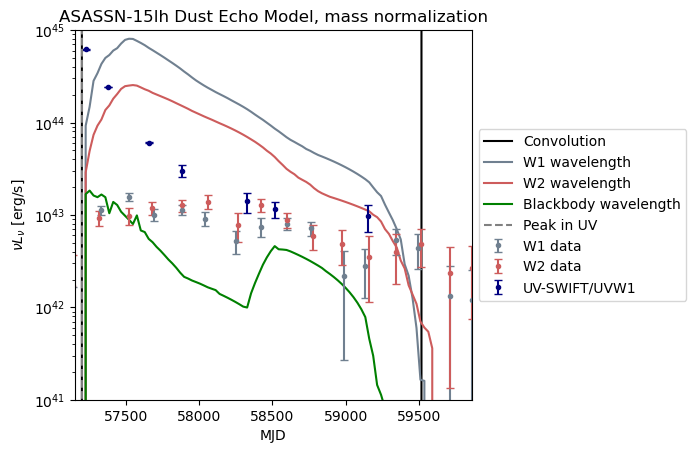

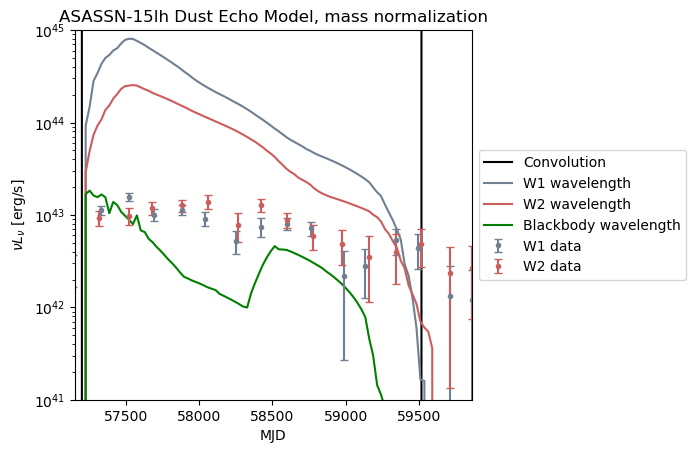

In [19]:
#Applying the covering factor if wanted:
luminosity_cov_mass = luminosity_mass * coveringFactor_mass
cover = False

#Making lightcurve plot including SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity_mass[:,w1]).to(u.erg/u.s),label='W1 wavelength',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity_mass[:,w2]).to(u.erg/u.s),label='W2 wavelength',color='indianred')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_mass[:,bbwl_i]).to(u.erg/u.s),label='Blackbody wavelength',color='green')

#Plotting the lightcurves with covering factors if wanted
if cover:
    ax.plot(output_t,((c.c/wl_w1)*luminosity_cov_mass[:,w1]).to(u.erg/u.s),label='W1 fit w/ covering factor',color='slategrey',ls='--')
    ax.plot(output_t,((c.c/wl_w2)*luminosity_cov_mass[:,w2]).to(u.erg/u.s),label='W2 fit w/ covering factor',color='indianred',ls='--')

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model, mass normalization')
if cover:
    fig.savefig(PLOTFILES_+'lightcurve_mass_SWIFT_cov.pdf')
else:
    fig.savefig(PLOTFILES_+'lightcurve_mass_SWIFT.pdf')
fig.show()

#Making lightcurve plot without the SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity_mass[:,w1]).to(u.erg/u.s),label='W1 wavelength',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity_mass[:,w2]).to(u.erg/u.s),label='W2 wavelength',color='indianred')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_mass[:,bbwl_i]).to(u.erg/u.s),label='Blackbody wavelength',color='green')

#Plotting the lightcurves with covering factors if wanted
if cover:

    ax.plot(output_t,((c.c/wl_w1)*luminosity_cov_mass[:,w1]).to(u.erg/u.s),label='W1 fit w/ covering factor',color='slategrey',ls='--')
    ax.plot(output_t,((c.c/wl_w2)*luminosity_cov_mass[:,w2]).to(u.erg/u.s),label='W2 fit w/ covering factor',color='indianred',ls='--')

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')

ax.set_yscale('log')
ax.set_ylim(bottom=1e41,top=1e45)
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model, mass normalization')
if cover:

    fig.savefig(PLOTFILES_+'lightcurve_mass_cov_noSWIFT.pdf')
else:
    fig.savefig(PLOTFILES_+'lightcurve_mass_noSWIFT.pdf')
fig.show()

## Making the spectrum

06/05/2024 13:57:30.812 ! /var/tmp/lankhorst/ipykernel_1982247/641750184.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
06/05/2024 13:57:30.812 !   ax.scatter(wavelengths_mass,lightcurve_mass[times[t]],c=color,s=.8)
06/05/2024 13:57:30.815 ! /var/tmp/lankhorst/ipykernel_1982247/641750184.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
06/05/2024 13:57:30.815 !   ax.scatter(wavelengths_mass,lightcurve_mass[times[t]],c=color,s=.8)
06/05/2024 13:57:31.188 ! /var/tmp/lankhorst/ipykernel_1982247/641750184.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 13:57:31.188 !   fig.show()


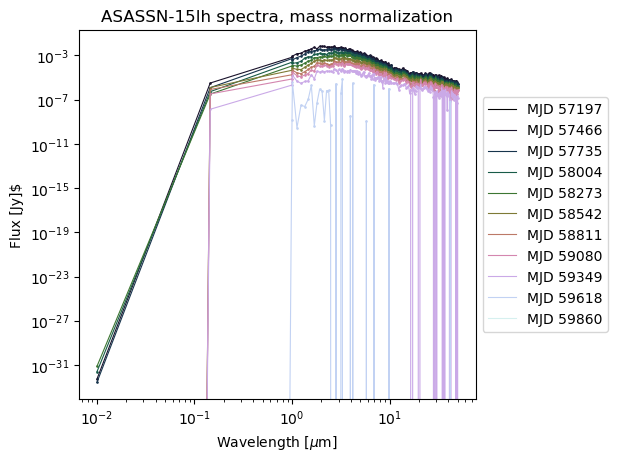

In [20]:
times=(np.array([0,10,20,30,40,50,60,70,80,90,99]))

cmap = plt.get_cmap('cubehelix')

fig=plt.figure()
ax=plt.subplot(111)


for t in range(len(times)):
    color = cmap(t/len(times)) #Get the color from the colormap
    ax.loglog(wavelengths_mass,lightcurve_mass[times[t]],label=f'MJD {int(output_t[times[t]])}',c=color,linewidth=.8)
    ax.scatter(wavelengths_mass,lightcurve_mass[times[t]],c=color,s=.8)

ax.set_ylabel(r'Flux [Jy]$')
ax.set_xlabel(r'Wavelength [$\mu$m]')
#plt.ylim(bottom=np.max(lightcurve.value)/1e4,top=np.max(luminosity.value)*2)
ax.set_title(f'{target} spectra, mass normalization')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(PLOTFILES_+'/spectra.pdf')
fig.show()

### Making lightcurve from the spectrum to compare

06/05/2024 13:57:31.963 ! /var/tmp/lankhorst/ipykernel_1982247/821478848.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 13:57:31.963 !   fig.show()


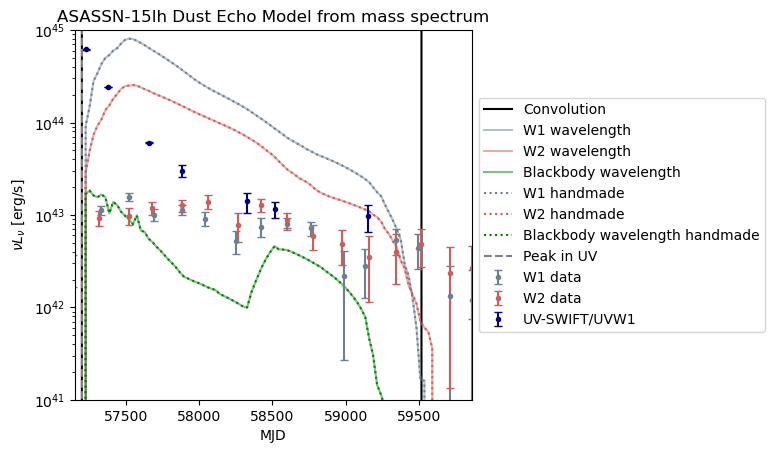

In [21]:
#Making lightcurve plot including SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the lightcurves from simulations
ax.plot(output_t,((c.c/wl_w1)*luminosity_mass[:,w1]).to(u.erg/u.s),label='W1 wavelength',color='slategrey',alpha=.5)
ax.plot(output_t,((c.c/wl_w2)*luminosity_mass[:,w2]).to(u.erg/u.s),label='W2 wavelength',color='indianred',alpha=.5)
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_mass[:,bbwl_i]).to(u.erg/u.s),label='Blackbody wavelength',color='green',alpha=.5)

#Plotting the lightcurves from summing the spectra
ax.plot(output_t,(c.c/wl_w1 * FluxtoLum((lightcurve_mass[:,w1]),distance=distance)).to(u.erg/u.s),label='W1 handmade',ls='dotted',color='slategrey')
ax.plot(output_t,(c.c/wl_w2 * FluxtoLum((lightcurve_mass[:,w2]),distance=distance)).to(u.erg/u.s),label='W2 handmade',ls='dotted',color='indianred')
ax.plot(output_t,(c.c/(bbwl*u.um) * FluxtoLum((lightcurve_mass[:,bbwl_i]),distance=distance)).to(u.erg/u.s),label='Blackbody wavelength handmade',ls='dotted',color='green')

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model from mass spectrum')
fig.savefig(PLOTFILES_+'/lightcurve_mass_handmade.pdf')
fig.show()

## Optical Depth

In [22]:
# Start the run
output_wavelengths = np.sort(np.concatenate((np.linspace(0.01, 1, 2), np.linspace(1.01, 10, 80), \
                                              np.linspace(10.01, 50, 100),w1w2,bbwl)))
normalization_type='optical_depth'

OUTFILES_ = OUTFILES+'comparing/'+normalization_type+'/'
PLOTFILES_ = PLOTFILES+'comparing/'+normalization_type+'/'

if os.path.isdir(OUTFILES_) == False:
    os.makedirs(OUTFILES_[:-1])
if os.path.isdir(PLOTFILES_) == False:
    os.makedirs(PLOTFILES_[:-1])
log_=open(OUTFILES_+'log.txt','a')

lightcurve_optd,wavelengths_optd,temp_optd,radius_optd,simulation_optd = get_lightcurve(np.array((L_data[0],L_data[1]*Lbol_factor \
                                                                         ,L_data[2]*Lbol_factor)) \
                                                               ,T_data, t_data, output_t \
                                                               ,[centralBin,outer,alpha] \
                                                               ,[amax,amin,grainpowerlaw], spaceBins \
                                                               ,normalization_type=normalization_type \
                                                               ,total_mass = total_mass, opt_depth = [10,0.28,'Z'], nlayers=1 \
                                                               ,static=static,FWHM=FWHM, output_wavelengths=np.append(output_wavelengths,relBinwidth) \
                                                               ,distance=distance,skiname='SKI/combined_ski.txt', Si=False \
                                                               ,prefix=str(today), OUTFILES=OUTFILES_, SKIRTpath='SKIRT/release/SKIRT/main/skirt',name='pepijn')

Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

06/05/2024 13:57:32.508   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
06/05/2024 13:57:32.508   Running on student72.strw.leidenuniv.nl for lankhorst
06/05/2024 13:57:32.509   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-06_p/1250/comparing/optical_depth/57197/run.ski'...
06/05/2024 13:57:33.179 - Finished setup in 0.5 s.
06/05/2024 13:57:33.241 - Finished setup output in 0.1 s.
06/05/2024 13:57:33.336 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
06/05/2024 13:57:33.337 - Finished primary emission iteration 1 in 0.1 s.
06/05/2024 13:57:33.543 - Finished primary emission in 0.2 s.
06/05/2024 13:57:33.679 - Finished secondary emission iteration 1 in 0.1 s.
06/05/2024 13:57:33.790 - Finished secondary emission iteration 2 in 0.1 s.
06/05/2024 13:57:33.896 - Finished secondary emission iteration 3 in 0.1 s.
06/05/2024 13:57:34.022 - Finished secondary emission iteration 4 in

SKIRT Runs:  10%|███▏                            | 1/10 [00:05<00:45,  5.01s/it]

06/05/2024 13:57:37.410 - Finished final output in 0.6 s.
06/05/2024 13:57:37.410 * *** Error: The following error message was issued during this simulation:
06/05/2024 13:57:37.410 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
06/05/2024 13:57:37.410 - Finished simulation run using 6 threads and a single process in 4.7 s.
06/05/2024 13:57:37.413   Available memory: 15.4 GB -- Peak memory usage: 773 MB (4.9%)
06/05/2024 13:57:37.512   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
06/05/2024 13:57:37.512   Running on student72.strw.leidenuniv.nl for lankhorst
06/05/2024 13:57:37.513   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-06_p/1250/comparing/optical_depth/57197/run.ski'...
06/05/2024 13:57:38.116 - Finished setup in 0.5 s.
06/05/2024 13:57:38.183 - Finished setup output in 0.1 s.
06/05/2024 13:57:38.282 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  20%|██████▍                         | 2/10 [00:09<00:38,  4.83s/it]

06/05/2024 13:57:42.067 - Finished final output in 0.6 s.
06/05/2024 13:57:42.067 * *** Error: The following error message was issued during this simulation:
06/05/2024 13:57:42.067 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
06/05/2024 13:57:42.067 - Finished simulation run using 6 threads and a single process in 4.4 s.
06/05/2024 13:57:42.073   Available memory: 15.4 GB -- Peak memory usage: 773 MB (4.9%)
06/05/2024 13:57:42.235   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
06/05/2024 13:57:42.235   Running on student72.strw.leidenuniv.nl for lankhorst
06/05/2024 13:57:42.236   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-06_p/1250/comparing/optical_depth/57208/run.ski'...
06/05/2024 13:57:42.777 - Finished setup in 0.5 s.
06/05/2024 13:57:42.840 - Finished setup output in 0.1 s.
06/05/2024 13:57:42.934 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  30%|█████████▌                      | 3/10 [00:14<00:33,  4.74s/it]

06/05/2024 13:57:46.745 - Finished final output in 0.6 s.
06/05/2024 13:57:46.745 * *** Error: The following error message was issued during this simulation:
06/05/2024 13:57:46.745 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
06/05/2024 13:57:46.745 - Finished simulation run using 6 threads and a single process in 4.4 s.
06/05/2024 13:57:46.748   Available memory: 15.4 GB -- Peak memory usage: 773 MB (4.9%)
06/05/2024 13:57:46.844   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
06/05/2024 13:57:46.844   Running on student72.strw.leidenuniv.nl for lankhorst
06/05/2024 13:57:46.846   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-06_p/1250/comparing/optical_depth/57225/run.ski'...
06/05/2024 13:57:47.386 - Finished setup in 0.5 s.
06/05/2024 13:57:47.450 - Finished setup output in 0.1 s.
06/05/2024 13:57:47.545 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  40%|████████████▊                   | 4/10 [00:18<00:27,  4.60s/it]

06/05/2024 13:57:51.118 - Finished final output in 0.7 s.
06/05/2024 13:57:51.119 * *** Error: The following error message was issued during this simulation:
06/05/2024 13:57:51.119 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
06/05/2024 13:57:51.119 - Finished simulation run using 6 threads and a single process in 4.2 s.
06/05/2024 13:57:51.121   Available memory: 15.4 GB -- Peak memory usage: 773 MB (4.9%)
06/05/2024 13:57:51.206   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
06/05/2024 13:57:51.206   Running on student72.strw.leidenuniv.nl for lankhorst
06/05/2024 13:57:51.207   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-06_p/1250/comparing/optical_depth/57378/run.ski'...
06/05/2024 13:57:51.791 - Finished setup in 0.5 s.
06/05/2024 13:57:51.855 - Finished setup output in 0.1 s.
06/05/2024 13:57:52.066 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  50%|████████████████                | 5/10 [00:23<00:22,  4.49s/it]

06/05/2024 13:57:55.413 - Finished final output in 0.6 s.
06/05/2024 13:57:55.413 * *** Error: The following error message was issued during this simulation:
06/05/2024 13:57:55.413 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
06/05/2024 13:57:55.413 - Finished simulation run using 6 threads and a single process in 4.1 s.
06/05/2024 13:57:55.416   Available memory: 15.4 GB -- Peak memory usage: 773 MB (4.9%)
06/05/2024 13:57:55.536   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
06/05/2024 13:57:55.536   Running on student72.strw.leidenuniv.nl for lankhorst
06/05/2024 13:57:55.537   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-06_p/1250/comparing/optical_depth/57659/run.ski'...
06/05/2024 13:57:56.100 - Finished setup in 0.5 s.
06/05/2024 13:57:56.163 - Finished setup output in 0.1 s.
06/05/2024 13:57:56.262 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  60%|███████████████████▏            | 6/10 [00:26<00:17,  4.27s/it]

06/05/2024 13:57:59.275 - Finished final output in 0.7 s.
06/05/2024 13:57:59.275 * *** Error: The following error message was issued during this simulation:
06/05/2024 13:57:59.275 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
06/05/2024 13:57:59.275 - Finished simulation run using 6 threads and a single process in 3.6 s.
06/05/2024 13:57:59.278   Available memory: 15.4 GB -- Peak memory usage: 773 MB (4.9%)
06/05/2024 13:57:59.431   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
06/05/2024 13:57:59.431   Running on student72.strw.leidenuniv.nl for lankhorst
06/05/2024 13:57:59.433   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-06_p/1250/comparing/optical_depth/57881/run.ski'...
06/05/2024 13:57:59.997 - Finished setup in 0.5 s.
06/05/2024 13:58:00.066 - Finished setup output in 0.1 s.
06/05/2024 13:58:00.161 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  70%|██████████████████████▍         | 7/10 [00:30<00:12,  4.09s/it]

06/05/2024 13:58:02.995 - Finished final output in 0.6 s.
06/05/2024 13:58:02.995 * *** Error: The following error message was issued during this simulation:
06/05/2024 13:58:02.995 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
06/05/2024 13:58:02.995 - Finished simulation run using 6 threads and a single process in 3.5 s.
06/05/2024 13:58:02.998   Available memory: 15.4 GB -- Peak memory usage: 773 MB (4.9%)
06/05/2024 13:58:03.134   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
06/05/2024 13:58:03.134   Running on student72.strw.leidenuniv.nl for lankhorst
06/05/2024 13:58:03.136   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-06_p/1250/comparing/optical_depth/58324/run.ski'...
06/05/2024 13:58:03.719 - Finished setup in 0.5 s.
06/05/2024 13:58:03.787 - Finished setup output in 0.1 s.
06/05/2024 13:58:03.915 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  80%|█████████████████████████▌      | 8/10 [00:34<00:07,  3.95s/it]

06/05/2024 13:58:06.614 - Finished final output in 0.7 s.
06/05/2024 13:58:06.614 * *** Error: The following error message was issued during this simulation:
06/05/2024 13:58:06.614 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
06/05/2024 13:58:06.614 - Finished simulation run using 6 threads and a single process in 3.4 s.
06/05/2024 13:58:06.617   Available memory: 15.4 GB -- Peak memory usage: 773 MB (4.9%)
06/05/2024 13:58:06.799   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
06/05/2024 13:58:06.799   Running on student72.strw.leidenuniv.nl for lankhorst
06/05/2024 13:58:06.800   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-06_p/1250/comparing/optical_depth/58519/run.ski'...
06/05/2024 13:58:07.360 - Finished setup in 0.5 s.
06/05/2024 13:58:07.422 - Finished setup output in 0.1 s.
06/05/2024 13:58:07.519 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  90%|████████████████████████████▊   | 9/10 [00:37<00:03,  3.81s/it]

06/05/2024 13:58:10.138 - Finished final output in 0.6 s.
06/05/2024 13:58:10.138 * *** Error: The following error message was issued during this simulation:
06/05/2024 13:58:10.138 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
06/05/2024 13:58:10.138 - Finished simulation run using 6 threads and a single process in 3.2 s.
06/05/2024 13:58:10.141   Available memory: 15.4 GB -- Peak memory usage: 773 MB (4.9%)
06/05/2024 13:58:10.305   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
06/05/2024 13:58:10.305   Running on student72.strw.leidenuniv.nl for lankhorst
06/05/2024 13:58:10.307   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-06_p/1250/comparing/optical_depth/59155/run.ski'...
06/05/2024 13:58:10.891 - Finished setup in 0.5 s.
06/05/2024 13:58:10.954 - Finished setup output in 0.1 s.
06/05/2024 13:58:11.052 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs: 100%|███████████████████████████████| 10/10 [00:41<00:00,  4.13s/it]


06/05/2024 13:58:13.689 - Finished final output in 0.7 s.
06/05/2024 13:58:13.689 * *** Error: The following error message was issued during this simulation:
06/05/2024 13:58:13.689 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
06/05/2024 13:58:13.689 - Finished simulation run using 6 threads and a single process in 3.3 s.
06/05/2024 13:58:13.692   Available memory: 15.4 GB -- Peak memory usage: 773 MB (4.9%)


100%|█████████████████████████████████████████| 185/185 [00:03<00:00, 52.46it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:03, 28.74it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:00<00:08, 11.11it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:00<00:12,  7.28it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:01<00:16,  5.36it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:01<00:19,  4.61it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:02<00:21,  4.01it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:02<00:24,  3.55it/s]

Compile Lightcurve:  14%|███                   | 14/100 [00:03<00:27,  3.15it/s]

Compile Lightcurve:  15%|███▎                  | 15/100 [00:03<00:29,  2.85it/s]

Compile Lightcurve:  16%|███▌                  | 16/100 [00:03<00:32,  2.62it/s]

Compile Lightcu

In [23]:
# indices corresponding to the WISE filter and black body peak wavelengths
w1=np.argmin(np.abs(wavelengths_optd-wl_w1.value))
w2=np.argmin(np.abs(wavelengths_optd-wl_w2.value))
bbwl_i = np.argmin(np.abs(wavelengths_optd-bbwl))

# Convert the lightcurve to luminosity
luminosity_optd=FluxtoLum(lightcurve_optd,distance=distance)
# Calculate the covering factor
# in this simulation a spherical dust shell is used, 
# as we expect a clumpy dust structure a covering factor is applied to account for the higher luminosity.
coveringFactor_optd=np.max(W1[1]*u.erg/u.s/u.Hz)/luminosity_optd[np.argmin(np.abs(output_t-W1[0,np.argmax(W1[1])])),w1]

# Save the data
log_.write('amax='+str(amax)+', grainpowerlaw='+str(grainpowerlaw)+', coveringFactor='+str(coveringFactor_optd)+', sublimation radius='+str(np.min(radius_optd))+', T_min='+np.array2string(np.array(temp_optd),max_line_width=len(temp_optd)*100))
log_.write('\n')
if os.path.isdir(OUTFILES_+'GridSearch/')==False:
    os.makedirs(OUTFILES_+'GridSearch/')
if os.path.isdir(PLOTFILES_+'/')==False:
    os.makedirs(PLOTFILES_+'/')

np.savetxt(OUTFILES_+'config.txt',luminosity_optd.value)

## Making the lightcurves

06/05/2024 14:00:05.143 ! /var/tmp/lankhorst/ipykernel_1982247/3833071628.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 14:00:05.143 !   fig.show()
06/05/2024 14:00:05.375 ! /var/tmp/lankhorst/ipykernel_1982247/3833071628.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 14:00:05.375 !   fig.show()
06/05/2024 14:00:05.748 ! /var/tmp/lankhorst/ipykernel_1982247/3833071628.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 14:00:05.748 !   fig.show()


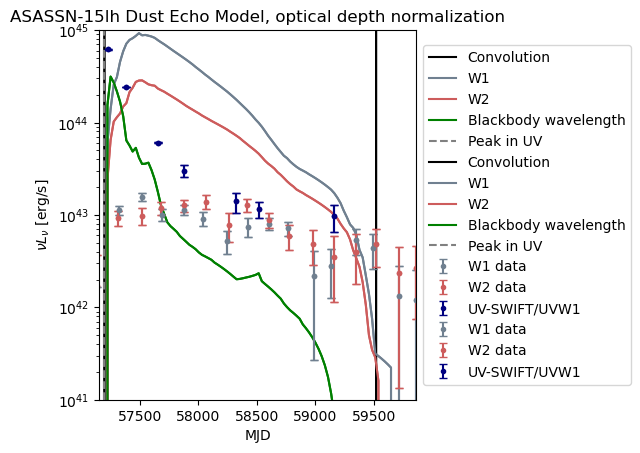

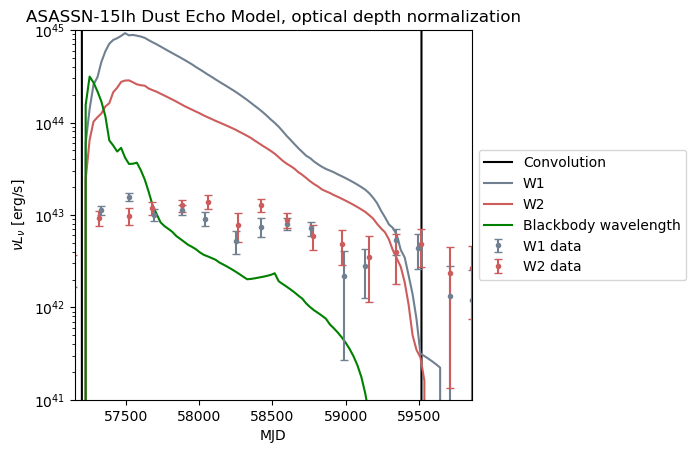

In [24]:
#Applying the covering factor if wanted:
luminosity_cov_optd = luminosity_optd * coveringFactor_optd
cover = False

#Making lightcurve plot including SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity_optd[:,w1]).to(u.erg/u.s),label='W1',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity_optd[:,w2]).to(u.erg/u.s),label='W2',color='indianred')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_optd[:,bbwl_i]).to(u.erg/u.s),label='Blackbody wavelength',color='green')

#Plotting the lightcurves with covering factors if wanted
if cover:
    ax.plot(output_t,((c.c/wl_w1)*luminosity_cov_optd[:,w1]).to(u.erg/u.s),label='W1 fit w/ covering factor',color='slategrey',ls='--')
    ax.plot(output_t,((c.c/wl_w2)*luminosity_cov_optd[:,w2]).to(u.erg/u.s),label='W2 fit w/ covering factor',color='indianred',ls='--')

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model, optical depth normalization')
if cover:
    fig.savefig(PLOTFILES_+'lightcurve_optd_SWIFT_cov.pdf')
else:
    fig.savefig(PLOTFILES_+'lightcurve_optd_SWIFT.pdf')
fig.show()

#Setting up and plotting the convolution
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity_optd[:,w1]).to(u.erg/u.s),label='W1',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity_optd[:,w2]).to(u.erg/u.s),label='W2',color='indianred')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_optd[:,bbwl_i]).to(u.erg/u.s),label='Blackbody wavelength',color='green')

#Plotting the lightcurves with covering factors if wanted
if cover:
    ax.plot(output_t,((c.c/wl_w1)*luminosity_cov_optd[:,w1]).to(u.erg/u.s),label='W1 fit w/ covering factor',color='slategrey',ls='--')
    ax.plot(output_t,((c.c/wl_w2)*luminosity_cov_optd[:,w2]).to(u.erg/u.s),label='W2 fit w/ covering factor',color='indianred',ls='--')

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model, optical depth normalization')
if cover:
    fig.savefig(PLOTFILES_+'lightcurve_optd_cov_SWIFT.pdf')
else:
    fig.savefig(PLOTFILES_+'lightcurve_optd_SWIFT.pdf')
fig.show()

#Making lightcurve plot without the SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity_optd[:,w1]).to(u.erg/u.s),label='W1',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity_optd[:,w2]).to(u.erg/u.s),label='W2',color='indianred')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_optd[:,bbwl_i]).to(u.erg/u.s),label='Blackbody wavelength',color='green')

#Plotting the lightcurves with covering factors if wanted
if cover:
    ax.plot(output_t,((c.c/wl_w1)*luminosity_cov_optd[:,w1]).to(u.erg/u.s),label='W1 fit w/ covering factor',color='slategrey',ls='--')
    ax.plot(output_t,((c.c/wl_w2)*luminosity_cov_optd[:,w2]).to(u.erg/u.s),label='W2 fit w/ covering factor',color='indianred',ls='--')

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')

ax.set_yscale('log')
ax.set_ylim(bottom=1e41,top=1e45)
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model, optical depth normalization')
if cover:
    fig.savefig(PLOTFILES_+'lightcurve_optd_cov_noSWIFT.pdf')
else:
    fig.savefig(PLOTFILES_+'lightcurve_optd_noSWIFT.pdf')
fig.show()

## Making the spectrum

06/05/2024 14:00:06.736 ! /var/tmp/lankhorst/ipykernel_1982247/2253894587.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 14:00:06.736 !   fig.show()


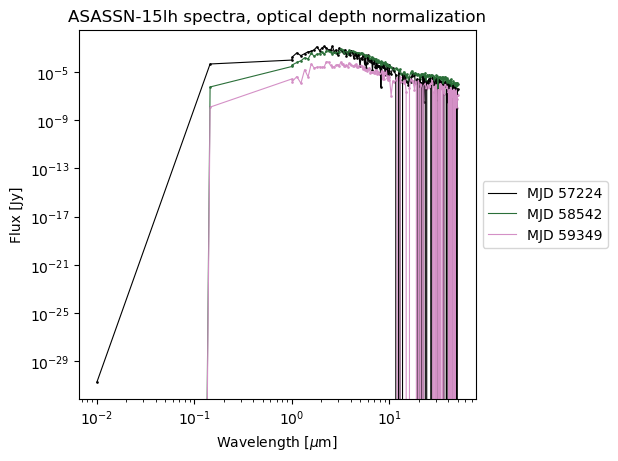

In [25]:
times=(np.array([1,50,80]))

cmap = plt.get_cmap('cubehelix')

fig=plt.figure()
ax=plt.subplot(111)

for t in range(len(times)):
    color = cmap(t/len(times)) #Get the color from the colormap
    ax.loglog(wavelengths_optd,lightcurve_optd[times[t]],label=f'MJD {int(output_t[times[t]])}',color=color,linewidth=.8)
    ax.scatter(wavelengths_optd,lightcurve_optd[times[t]],color=color,s=.8)

ax.set_ylabel(r'Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
#plt.ylim(bottom=np.max(luminosity.value)/1e4,top=np.max(luminosity.value)*2)
ax.set_title(f'{target} spectra, optical depth normalization')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(PLOTFILES_+'/spectrum_optd.pdf')
fig.show()

### Making lightcurve from the spectrum to compare

06/05/2024 14:00:07.469 ! /var/tmp/lankhorst/ipykernel_1982247/2156220955.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 14:00:07.469 !   fig.show()


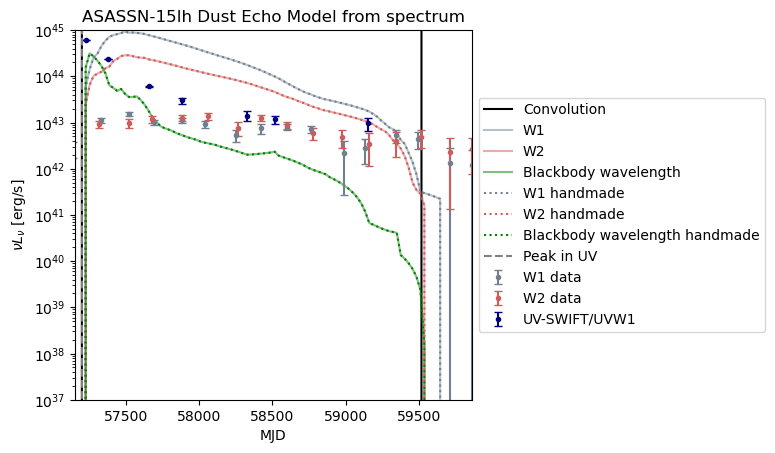

In [26]:
#Making lightcurve plot including SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the lightcurves from simulations
ax.plot(output_t,((c.c/wl_w1)*luminosity_optd[:,w1]).to(u.erg/u.s),label='W1',color='slategrey',alpha=0.5)
ax.plot(output_t,((c.c/wl_w2)*luminosity_optd[:,w2]).to(u.erg/u.s),label='W2',color='indianred',alpha=0.5)
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_optd[:,bbwl_i]).to(u.erg/u.s),label='Blackbody wavelength',color='green',alpha=0.5)

#Plotting the lightcurves from summing spectra
ax.plot(output_t,(c.c/wl_w1 * FluxtoLum((lightcurve_optd[:,w1]),distance=distance)).to(u.erg/u.s),label='W1 handmade',ls='dotted',color='slategrey')
ax.plot(output_t,(c.c/wl_w2 * FluxtoLum((lightcurve_optd[:,w2]),distance=distance)).to(u.erg/u.s),label='W2 handmade',ls='dotted',color='indianred')
ax.plot(output_t,(c.c/(bbwl*u.um) * FluxtoLum((lightcurve_optd[:,bbwl_i]),distance=distance)).to(u.erg/u.s),label='Blackbody wavelength handmade',ls='dotted',color='green')

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=1e37,top=1e45)
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model from spectrum')
fig.savefig(PLOTFILES_+'/lightcurve_optd_handmade.pdf')
fig.show()

## Comparing the normalisation methods

### Comparing the lightcurves

06/05/2024 14:00:08.239 ! /var/tmp/lankhorst/ipykernel_1982247/3193672779.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 14:00:08.239 !   fig.show()
06/05/2024 14:00:08.446 ! /var/tmp/lankhorst/ipykernel_1982247/3193672779.py:72: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 14:00:08.446 !   fig.show()


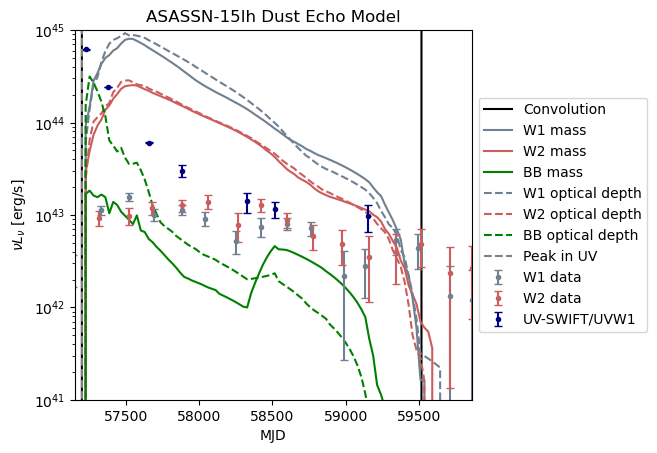

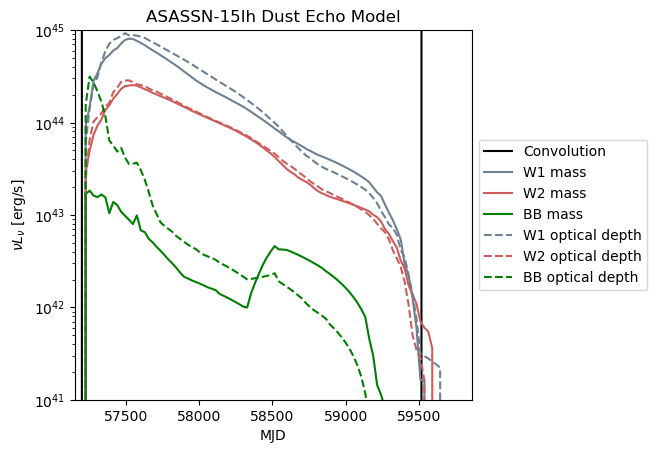

In [27]:
OUTFILES_ = OUTFILES+'comparing/'+'/'
PLOTFILES_ = PLOTFILES+'comparing/'+'/'

if os.path.isdir(OUTFILES_) == False:
    os.makedirs(OUTFILES_[:-1])
if os.path.isdir(PLOTFILES_) == False:
    os.makedirs(PLOTFILES_[:-1])

# Plot the lightcurve with SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the mass lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity_mass[:,w1]).to(u.erg/u.s),label='W1 mass',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity_mass[:,w2]).to(u.erg/u.s),label='W2 mass',color='indianred')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_mass[:,bbwl_i]).to(u.erg/u.s),label='BB mass',color='green')

#Plotting the optical depth lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity_optd[:,w1]).to(u.erg/u.s),label='W1 optical depth',color='slategrey',ls='--')
ax.plot(output_t,((c.c/wl_w2)*luminosity_optd[:,w2]).to(u.erg/u.s),label='W2 optical depth',color='indianred',ls='--')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_optd[:,bbwl_i]).to(u.erg/u.s),label='BB optical depth',color='green',ls='--')

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=1e41,top=1e45)
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model')
fig.savefig(PLOTFILES_+'lightcurve_compare_SWIFT.pdf')
fig.show()

#Plot the lightcurve without SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the mass lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity_mass[:,w1]).to(u.erg/u.s),label='W1 mass',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity_mass[:,w2]).to(u.erg/u.s),label='W2 mass',color='indianred')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_mass[:,bbwl_i]).to(u.erg/u.s),label='BB mass',color='green')

#Plotting the optical depth lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity_optd[:,w1]).to(u.erg/u.s),label='W1 optical depth',color='slategrey',ls='--')
ax.plot(output_t,((c.c/wl_w2)*luminosity_optd[:,w2]).to(u.erg/u.s),label='W2 optical depth',color='indianred',ls='--')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_optd[:,bbwl_i]).to(u.erg/u.s),label='BB optical depth',color='green',ls='--')

ax.set_yscale('log')
ax.set_ylim(bottom=1e41,top=1e45)
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model')
fig.savefig(PLOTFILES_+'lightcurve_compare_noSWIFT.pdf')
fig.show()

#### Comparing for W1


06/05/2024 14:00:09.452 ! /var/tmp/lankhorst/ipykernel_1982247/1138342828.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 14:00:09.452 !   fig.show()
06/05/2024 14:00:09.642 ! /var/tmp/lankhorst/ipykernel_1982247/1138342828.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 14:00:09.642 !   fig.show()


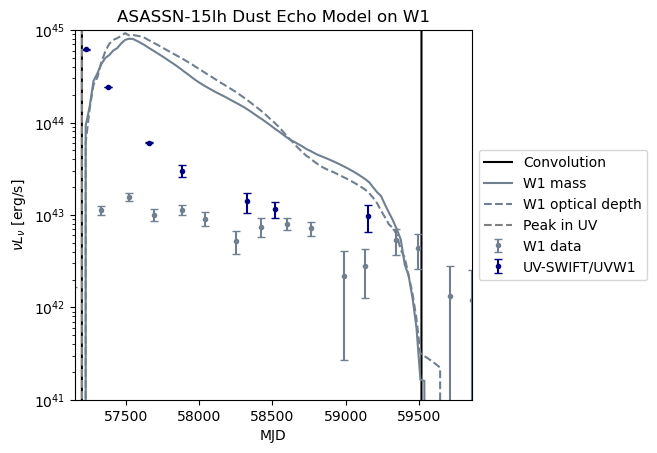

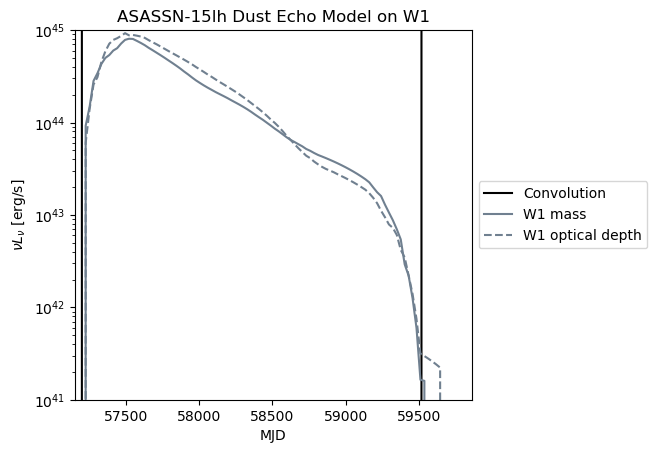

In [28]:
# Plot the lightcurve with SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the mass lightcurve
ax.plot(output_t,((c.c/wl_w1)*luminosity_mass[:,w1]).to(u.erg/u.s),label='W1 mass',color='slategrey')

#Plotting the optical depth lightcurve
ax.plot(output_t,((c.c/wl_w1)*luminosity_optd[:,w1]).to(u.erg/u.s),label='W1 optical depth',color='slategrey',ls='--')

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model on W1')
fig.savefig(PLOTFILES_+'lightcurve_compare_w1_SWIFT.pdf')
fig.show()

#Plot the lightcurve without SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the mass lightcurve
ax.plot(output_t,((c.c/wl_w1)*luminosity_mass[:,w1]).to(u.erg/u.s),label='W1 mass',color='slategrey')

#Plotting the optical depth lightcurve
ax.plot(output_t,((c.c/wl_w1)*luminosity_optd[:,w1]).to(u.erg/u.s),label='W1 optical depth',color='slategrey',ls='--')

ax.set_yscale('log')
ax.set_ylim(bottom=1e41,top=1e45)
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model on W1')
fig.savefig(PLOTFILES_+'lightcurve_compare_w1_noSWIFT.pdf')
fig.show()

#### Comparing for W2

06/05/2024 14:00:10.497 ! /var/tmp/lankhorst/ipykernel_1982247/4130336338.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 14:00:10.497 !   fig.show()
06/05/2024 14:00:10.672 ! /var/tmp/lankhorst/ipykernel_1982247/4130336338.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 14:00:10.672 !   fig.show()


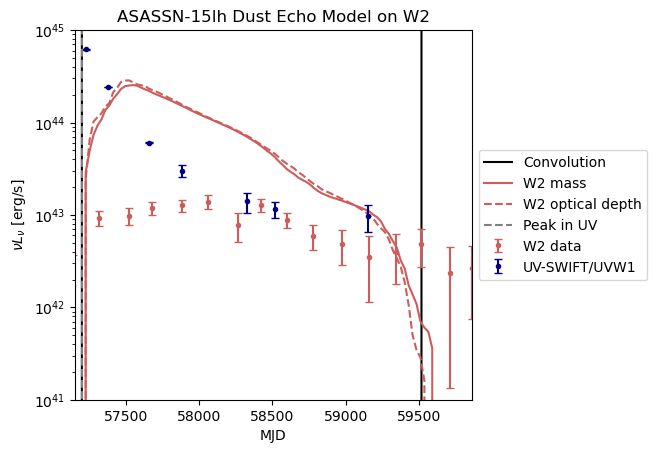

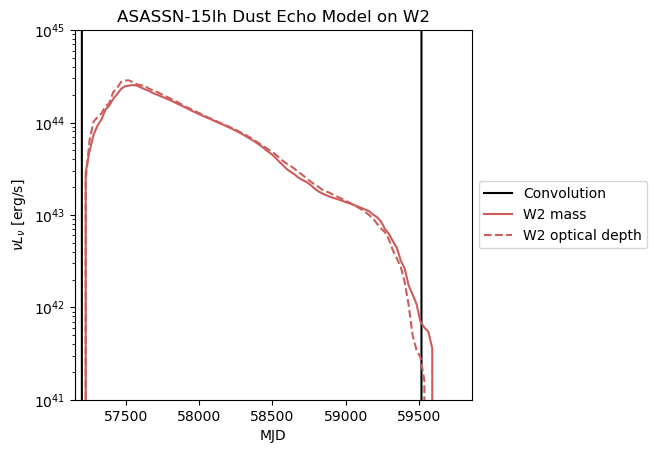

In [29]:
# Plot the lightcurve with SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the mass lightcurves
ax.plot(output_t,((c.c/wl_w2)*luminosity_mass[:,w2]).to(u.erg/u.s),label='W2 mass',color='indianred')

#Plotting the optical depth lightcurves
ax.plot(output_t,((c.c/wl_w2)*luminosity_optd[:,w2]).to(u.erg/u.s),label='W2 optical depth',color='indianred',ls='--')

#Plotting data
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model on W2')
fig.savefig(PLOTFILES_+'lightcurve_compare_w2_SWIFT.pdf')
fig.show()

#Plot the lightcurve without SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the mass lightcurves
ax.plot(output_t,((c.c/wl_w2)*luminosity_mass[:,w2]).to(u.erg/u.s),label='W2 mass',color='indianred')

#Plotting the optical depth lightcurves
ax.plot(output_t,((c.c/wl_w2)*luminosity_optd[:,w2]).to(u.erg/u.s),label='W2 optical depth',color='indianred',ls='--')

ax.set_yscale('log')
ax.set_ylim(bottom=1e41,top=1e45)
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model on W2')
fig.savefig(PLOTFILES_+'lightcurve_compare_w2_noSWIFT.pdf')
fig.show()

#### Comparing for black body peak wavelength

06/05/2024 14:00:11.630 ! /var/tmp/lankhorst/ipykernel_1982247/537805140.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 14:00:11.630 !   fig.show()
06/05/2024 14:00:11.806 ! /var/tmp/lankhorst/ipykernel_1982247/537805140.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 14:00:11.806 !   fig.show()


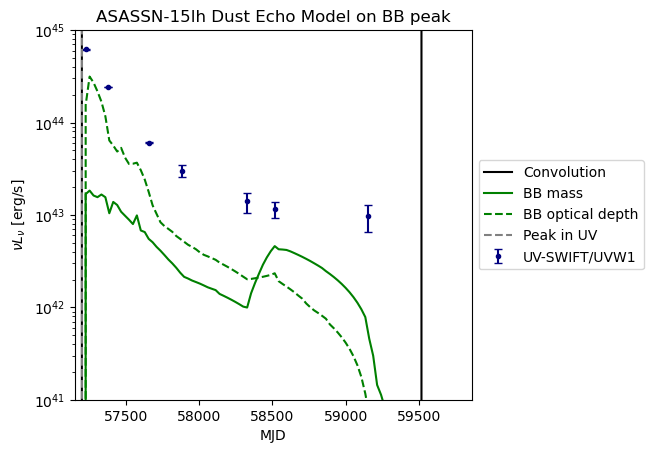

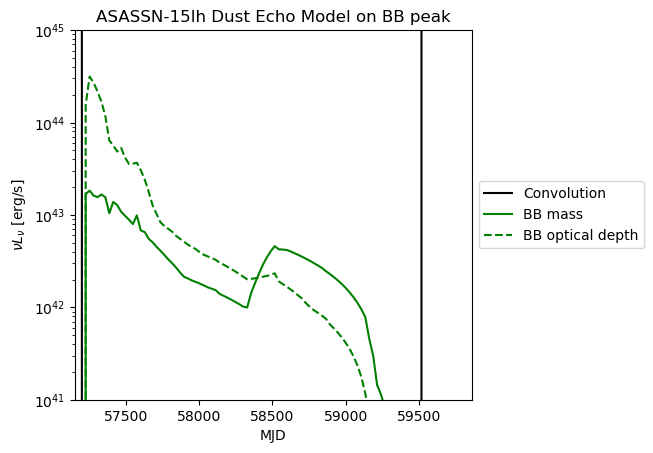

In [30]:
# Plot the lightcurve with SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the mass lightcurves
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_mass[:,bbwl_i]).to(u.erg/u.s),label='BB mass',color='green')

#Plotting the optical depth lightcurves
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_optd[:,bbwl_i]).to(u.erg/u.s),label='BB optical depth',color='green',ls='--')

#Plotting data
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model on BB peak')
fig.savefig(PLOTFILES_+'lightcurve_compare_bb_SWIFT.pdf')
fig.show()

#Plot the lightcurve without SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the mass lightcurves
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_mass[:,bbwl_i]).to(u.erg/u.s),label='BB mass',color='green')

#Plotting the optical depth lightcurves
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_optd[:,bbwl_i]).to(u.erg/u.s),label='BB optical depth',color='green',ls='--')

ax.set_yscale('log')
ax.set_ylim(bottom=1e41,top=1e45)
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model on BB peak')
fig.savefig(PLOTFILES_+'lightcurve_compare_bb_noSWIFT.pdf')
fig.show()

### Comparing the spectra

06/05/2024 14:00:12.756 ! /var/tmp/lankhorst/ipykernel_1982247/3954597984.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
06/05/2024 14:00:12.756 !   fig.show()


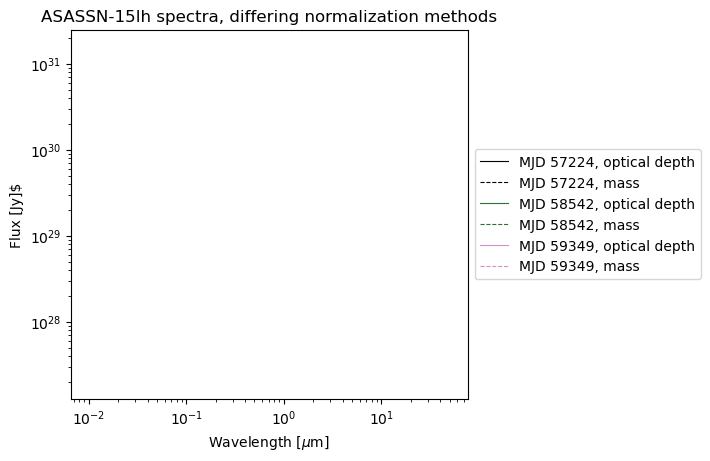

In [31]:
times=(np.array([1,50,80]))

cmap = plt.get_cmap('cubehelix')

fig=plt.figure()
ax=plt.subplot(111)

for t in range(len(times)):
    color = cmap(t/len(times)) #Get the color from the colormap
    ax.loglog(wavelengths_optd,lightcurve_optd[times[t]],label=f'MJD {int(output_t[times[t]])}, optical depth',color=color,linewidth=.8)
    ax.loglog(wavelengths_mass, lightcurve_mass[times[t]],label=f'MJD {int(output_t[times[t]])}, mass',color=color,ls='--',linewidth=.8)
    ax.scatter(wavelengths_optd,lightcurve_optd[times[t]],color=color,s=.8)
    ax.scatter(wavelengths_mass, lightcurve_mass[times[t]],color=color,s=.8)

ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel(r'Flux [Jy]$')
ax.set_ylim(bottom=np.max(luminosity.value)/1e4,top=np.max(luminosity.value)*2)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title(f'{target} spectra, differing normalization methods')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(PLOTFILES_+'spectra_compare.pdf')
fig.show()

# Multiple variables

## Changing optical depth

In [12]:
OUTFILES_ = OUTFILES+'ChangingTau/'
PLOTFILES_ = PLOTFILES+'ChangingTau/'

lightcurves, wavelengths, temperatures, radii, simulations = [],[],[],[],[]

normalization_type='optical_depth'
output_wavelengths = np.sort(np.concatenate((np.linspace(0.01, 1, 50), np.linspace(1.01, 10, 100), \
                                              np.linspace(10.01, 50, 100),w1w2,bbwl)))

opt_depths = [20,23,26,29,32,35]
OUTFILES_l = []
PLOTFILES_l = []

for i in range(len(opt_depths)):
    OUTFILES_l.append(OUTFILES_+'tau='+str(opt_depths[i])+'/')
    PLOTFILES_l.append(PLOTFILES_+'tau='+str(opt_depths[i])+'/')

    if os.path.isdir(OUTFILES_l[i]) == False:
        os.makedirs(OUTFILES_l[i][:-1])
    if os.path.isdir(PLOTFILES_l[i]) == False:
        os.makedirs(PLOTFILES_l[i][:-1])
    

    l,wl,T,R,sim = get_lightcurve(np.array((Lbol_data[0],Lbol_data[1] ,Lbol_data[2])), Tbol_data \
                                  ,tbol_data, output_t, np.append(output_wavelengths,relBinwidth) \
                                  ,[centralBin,outer,alpha] \
                                  ,[[amin,amax,grainpowerlaw],[amin,amax,grainpowerlaw]], spaceBins \
                                  ,normalization_type=normalization_type \
                                  ,total_mass = total_mass, opt_depth = [opt_depths[i],0.28,'Z'], nsizes=15 \
                                  ,static=True, FWHM=FWHM ,distance=distance \
                                  ,skiname='SKI/ski_new.txt', Si=0 ,prefix=str(today) \
                                  ,OUTFILES=OUTFILES_l[i], SKIRTpath='SKIRT/release/SKIRT/main/skirt')
    lightcurves.append(l), wavelengths.append(wl), temperatures.append(T), radii.append(R), simulations.append(sim)
    print(f"Run {i+1} of {len(opt_depths)} finished")

Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

17/04/2024 18:43:05.696   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 18:43:05.696   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 18:43:05.698   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=20/57197/run.ski'...
17/04/2024 18:43:06.481 - Finished setup in 0.5 s.
17/04/2024 18:43:06.568 - Finished setup output in 0.1 s.
17/04/2024 18:43:15.091 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 18:43:15.091 - Finished primary emission iteration 1 in 8.5 s.
17/04/2024 18:43:32.139 - Finished primary emission in 17.0 s.
17/04/2024 18:43:41.132 - Finished secondary emission iteration 1 in 9.0 s.
17/04/2024 18:43:50.269 - Finished secondary emission iteration 2 in 9.1 s.
17/04/2024 18:43:59.543 - Finished secondary emission iteration 3 in 9.3 s.
17/04/2024 18:44:08.804 - Finished secondary emission iterati

SKIRT Runs:  10%|███                            | 1/10 [05:27<49:07, 327.55s/it]

17/04/2024 18:48:33.045 - Finished final output in 0.7 s.
17/04/2024 18:48:33.045 * *** Error: The following error message was issued during this simulation:
17/04/2024 18:48:33.045 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 18:48:33.045 - Finished simulation run using 6 threads and a single process in 327 s (5m 27s).
17/04/2024 18:48:33.049   Available memory: 15.4 GB -- Peak memory usage: 177 MB (1.1%)
17/04/2024 18:48:33.165   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 18:48:33.165   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 18:48:33.166   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=20/57197/run.ski'...
17/04/2024 18:48:33.858 - Finished setup in 0.5 s.
17/04/2024 18:48:33.930 - Finished setup output in 0.1 s.
17/04/2024 18:48:42.134 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  20%|██████▏                        | 2/10 [10:41<42:35, 319.48s/it]

17/04/2024 18:53:46.859 - Finished final output in 0.7 s.
17/04/2024 18:53:46.859 * *** Error: The following error message was issued during this simulation:
17/04/2024 18:53:46.859 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 18:53:46.859 - Finished simulation run using 6 threads and a single process in 313 s (5m 13s).
17/04/2024 18:53:46.879   Available memory: 15.4 GB -- Peak memory usage: 195 MB (1.2%)
17/04/2024 18:53:47.022   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 18:53:47.022   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 18:53:47.023   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=20/57208/run.ski'...
17/04/2024 18:53:47.721 - Finished setup in 0.5 s.
17/04/2024 18:53:47.795 - Finished setup output in 0.1 s.
17/04/2024 18:53:55.774 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  30%|█████████▎                     | 3/10 [15:53<36:52, 316.07s/it]

17/04/2024 18:58:58.853 - Finished final output in 0.7 s.
17/04/2024 18:58:58.854 * *** Error: The following error message was issued during this simulation:
17/04/2024 18:58:58.854 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 18:58:58.854 - Finished simulation run using 6 threads and a single process in 312 s (5m 12s).
17/04/2024 18:58:58.857   Available memory: 15.4 GB -- Peak memory usage: 201 MB (1.3%)
17/04/2024 18:58:59.017   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 18:58:59.017   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 18:58:59.019   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=20/57225/run.ski'...
17/04/2024 18:58:59.706 - Finished setup in 0.5 s.
17/04/2024 18:58:59.781 - Finished setup output in 0.1 s.
17/04/2024 18:59:07.802 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  40%|████████████▍                  | 4/10 [20:41<30:29, 304.96s/it]

17/04/2024 19:03:46.806 - Finished final output in 0.7 s.
17/04/2024 19:03:46.806 * *** Error: The following error message was issued during this simulation:
17/04/2024 19:03:46.806 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 19:03:46.806 - Finished simulation run using 6 threads and a single process in 288 s (4m 48s).
17/04/2024 19:03:46.809   Available memory: 15.4 GB -- Peak memory usage: 207 MB (1.3%)
17/04/2024 19:03:46.946   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 19:03:46.946   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 19:03:46.947   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=20/57378/run.ski'...
17/04/2024 19:03:47.622 - Finished setup in 0.5 s.
17/04/2024 19:03:47.695 - Finished setup output in 0.1 s.
17/04/2024 19:03:55.641 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  50%|███████████████▌               | 5/10 [25:01<24:04, 288.85s/it]

17/04/2024 19:08:07.108 - Finished final output in 0.7 s.
17/04/2024 19:08:07.108 * *** Error: The following error message was issued during this simulation:
17/04/2024 19:08:07.108 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 19:08:07.108 - Finished simulation run using 6 threads and a single process in 260 s (4m 20s).
17/04/2024 19:08:07.111   Available memory: 15.4 GB -- Peak memory usage: 213 MB (1.3%)
17/04/2024 19:08:07.216   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 19:08:07.216   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 19:08:07.217   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=20/57659/run.ski'...
17/04/2024 19:08:07.962 - Finished setup in 0.5 s.
17/04/2024 19:08:08.036 - Finished setup output in 0.1 s.
17/04/2024 19:08:16.094 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  60%|██████████████████▌            | 6/10 [28:46<17:47, 266.98s/it]

17/04/2024 19:11:51.601 - Finished final output in 0.8 s.
17/04/2024 19:11:51.601 * *** Error: The following error message was issued during this simulation:
17/04/2024 19:11:51.601 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 19:11:51.601 - Finished simulation run using 6 threads and a single process in 224 s (3m 44s).
17/04/2024 19:11:51.606   Available memory: 15.4 GB -- Peak memory usage: 219 MB (1.4%)
17/04/2024 19:11:51.801   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 19:11:51.801   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 19:11:51.803   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=20/57881/run.ski'...
17/04/2024 19:11:52.492 - Finished setup in 0.5 s.
17/04/2024 19:11:52.641 - Finished setup output in 0.1 s.
17/04/2024 19:12:00.916 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [32:17<12:26, 248.68s/it]

17/04/2024 19:15:22.629 - Finished final output in 0.7 s.
17/04/2024 19:15:22.629 * *** Error: The following error message was issued during this simulation:
17/04/2024 19:15:22.629 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 19:15:22.629 - Finished simulation run using 6 threads and a single process in 211 s (3m 31s).
17/04/2024 19:15:22.632   Available memory: 15.4 GB -- Peak memory usage: 225 MB (1.4%)
17/04/2024 19:15:22.820   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 19:15:22.820   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 19:15:22.821   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=20/58324/run.ski'...
17/04/2024 19:15:23.534 - Finished setup in 0.5 s.
17/04/2024 19:15:23.607 - Finished setup output in 0.1 s.
17/04/2024 19:15:31.625 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  80%|████████████████████████▊      | 8/10 [35:30<07:41, 230.96s/it]

17/04/2024 19:18:35.641 - Finished final output in 0.7 s.
17/04/2024 19:18:35.641 * *** Error: The following error message was issued during this simulation:
17/04/2024 19:18:35.641 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 19:18:35.641 - Finished simulation run using 6 threads and a single process in 193 s (3m 13s).
17/04/2024 19:18:35.644   Available memory: 15.4 GB -- Peak memory usage: 230 MB (1.5%)
17/04/2024 19:18:35.806   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 19:18:35.806   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 19:18:35.807   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=20/58519/run.ski'...
17/04/2024 19:18:36.498 - Finished setup in 0.5 s.
17/04/2024 19:18:36.571 - Finished setup output in 0.1 s.
17/04/2024 19:18:44.576 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  90%|███████████████████████████▉   | 9/10 [38:41<03:38, 218.63s/it]

17/04/2024 19:21:47.127 - Finished final output in 0.8 s.
17/04/2024 19:21:47.127 * *** Error: The following error message was issued during this simulation:
17/04/2024 19:21:47.127 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 19:21:47.127 - Finished simulation run using 6 threads and a single process in 191 s (3m 11s).
17/04/2024 19:21:47.130   Available memory: 15.4 GB -- Peak memory usage: 236 MB (1.5%)
17/04/2024 19:21:47.278   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 19:21:47.278   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 19:21:47.279   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=20/59155/run.ski'...
17/04/2024 19:21:47.987 - Finished setup in 0.5 s.
17/04/2024 19:21:48.063 - Finished setup output in 0.1 s.
17/04/2024 19:21:56.010 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs: 100%|██████████████████████████████| 10/10 [41:51<00:00, 251.20s/it]


17/04/2024 19:24:57.487 - Finished final output in 0.7 s.
17/04/2024 19:24:57.487 * *** Error: The following error message was issued during this simulation:
17/04/2024 19:24:57.487 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 19:24:57.487 - Finished simulation run using 6 threads and a single process in 190 s (3m 10s).
17/04/2024 19:24:57.490   Available memory: 15.4 GB -- Peak memory usage: 242 MB (1.5%)


100%|█████████████████████████████████████████| 253/253 [00:06<00:00, 36.95it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:09, 10.68it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:19,  4.87it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:25,  3.66it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:32,  2.85it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:40,  2.29it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:47,  1.92it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:55,  1.63it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:05<01:02,  1.42it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:06<01:09,  1.27it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:16,  1.14it/s]

Compile Lightcu

Run 1 of 6 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

17/04/2024 19:29:18.889   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 19:29:18.889   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 19:29:18.891   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=23/57197/run.ski'...
17/04/2024 19:29:19.605 - Finished setup in 0.5 s.
17/04/2024 19:29:19.681 - Finished setup output in 0.1 s.
17/04/2024 19:29:27.404 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 19:29:27.404 - Finished primary emission iteration 1 in 7.7 s.
17/04/2024 19:29:43.969 - Finished primary emission in 16.6 s.
17/04/2024 19:29:52.750 - Finished secondary emission iteration 1 in 8.8 s.
17/04/2024 19:30:01.690 - Finished secondary emission iteration 2 in 8.9 s.
17/04/2024 19:30:10.789 - Finished secondary emission iteration 3 in 9.1 s.
17/04/2024 19:30:19.874 - Finished secondary emission iterati

SKIRT Runs:  10%|███                            | 1/10 [05:24<48:39, 324.44s/it]

17/04/2024 19:34:43.182 - Finished final output in 0.7 s.
17/04/2024 19:34:43.182 * *** Error: The following error message was issued during this simulation:
17/04/2024 19:34:43.182 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 19:34:43.182 - Finished simulation run using 6 threads and a single process in 324 s (5m 24s).
17/04/2024 19:34:43.185   Available memory: 15.4 GB -- Peak memory usage: 297 MB (1.9%)
17/04/2024 19:34:43.334   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 19:34:43.334   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 19:34:43.335   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=23/57197/run.ski'...
17/04/2024 19:34:44.016 - Finished setup in 0.5 s.
17/04/2024 19:34:44.090 - Finished setup output in 0.1 s.
17/04/2024 19:34:52.087 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  20%|██████▏                        | 2/10 [10:37<42:22, 317.76s/it]

17/04/2024 19:39:56.303 - Finished final output in 0.8 s.
17/04/2024 19:39:56.303 * *** Error: The following error message was issued during this simulation:
17/04/2024 19:39:56.303 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 19:39:56.303 - Finished simulation run using 6 threads and a single process in 313 s (5m 13s).
17/04/2024 19:39:56.307   Available memory: 15.4 GB -- Peak memory usage: 297 MB (1.9%)
17/04/2024 19:39:56.441   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 19:39:56.441   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 19:39:56.443   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=23/57208/run.ski'...
17/04/2024 19:39:57.147 - Finished setup in 0.5 s.
17/04/2024 19:39:57.234 - Finished setup output in 0.1 s.
17/04/2024 19:40:05.227 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  30%|█████████▎                     | 3/10 [15:50<36:48, 315.53s/it]

17/04/2024 19:45:09.191 - Finished final output in 0.7 s.
17/04/2024 19:45:09.191 * *** Error: The following error message was issued during this simulation:
17/04/2024 19:45:09.191 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 19:45:09.191 - Finished simulation run using 6 threads and a single process in 313 s (5m 13s).
17/04/2024 19:45:09.194   Available memory: 15.4 GB -- Peak memory usage: 297 MB (1.9%)
17/04/2024 19:45:09.319   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 19:45:09.319   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 19:45:09.320   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=23/57225/run.ski'...
17/04/2024 19:45:10.005 - Finished setup in 0.5 s.
17/04/2024 19:45:10.080 - Finished setup output in 0.1 s.
17/04/2024 19:45:17.866 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  40%|████████████▍                  | 4/10 [20:41<30:35, 305.85s/it]

17/04/2024 19:50:00.179 - Finished final output in 0.7 s.
17/04/2024 19:50:00.179 * *** Error: The following error message was issued during this simulation:
17/04/2024 19:50:00.179 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 19:50:00.179 - Finished simulation run using 6 threads and a single process in 291 s (4m 51s).
17/04/2024 19:50:00.182   Available memory: 15.4 GB -- Peak memory usage: 297 MB (1.9%)
17/04/2024 19:50:00.285   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 19:50:00.285   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 19:50:00.286   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=23/57378/run.ski'...
17/04/2024 19:50:00.978 - Finished setup in 0.5 s.
17/04/2024 19:50:01.052 - Finished setup output in 0.1 s.
17/04/2024 19:50:08.893 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  50%|███████████████▌               | 5/10 [25:03<24:10, 290.17s/it]

17/04/2024 19:54:22.543 - Finished final output in 0.7 s.
17/04/2024 19:54:22.543 * *** Error: The following error message was issued during this simulation:
17/04/2024 19:54:22.543 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 19:54:22.543 - Finished simulation run using 6 threads and a single process in 262 s (4m 22s).
17/04/2024 19:54:22.547   Available memory: 15.4 GB -- Peak memory usage: 297 MB (1.9%)
17/04/2024 19:54:22.677   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 19:54:22.677   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 19:54:22.679   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=23/57659/run.ski'...
17/04/2024 19:54:23.352 - Finished setup in 0.5 s.
17/04/2024 19:54:23.426 - Finished setup output in 0.1 s.
17/04/2024 19:54:31.197 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  60%|██████████████████▌            | 6/10 [28:45<17:47, 266.80s/it]

17/04/2024 19:58:03.957 - Finished final output in 0.9 s.
17/04/2024 19:58:03.957 * *** Error: The following error message was issued during this simulation:
17/04/2024 19:58:03.957 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 19:58:03.957 - Finished simulation run using 6 threads and a single process in 221 s (3m 41s).
17/04/2024 19:58:03.962   Available memory: 15.4 GB -- Peak memory usage: 297 MB (1.9%)
17/04/2024 19:58:04.200   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 19:58:04.200   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 19:58:04.202   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=23/57881/run.ski'...
17/04/2024 19:58:04.889 - Finished setup in 0.5 s.
17/04/2024 19:58:04.963 - Finished setup output in 0.1 s.
17/04/2024 19:58:12.736 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [32:10<12:19, 246.55s/it]

17/04/2024 20:01:28.796 - Finished final output in 0.7 s.
17/04/2024 20:01:28.796 * *** Error: The following error message was issued during this simulation:
17/04/2024 20:01:28.796 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 20:01:28.796 - Finished simulation run using 6 threads and a single process in 204 s (3m 24s).
17/04/2024 20:01:28.801   Available memory: 15.4 GB -- Peak memory usage: 297 MB (1.9%)
17/04/2024 20:01:28.942   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 20:01:28.942   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 20:01:28.943   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=23/58324/run.ski'...
17/04/2024 20:01:29.621 - Finished setup in 0.5 s.
17/04/2024 20:01:29.696 - Finished setup output in 0.1 s.
17/04/2024 20:01:37.538 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  80%|████████████████████████▊      | 8/10 [35:21<07:37, 228.93s/it]

17/04/2024 20:04:40.056 - Finished final output in 0.7 s.
17/04/2024 20:04:40.056 * *** Error: The following error message was issued during this simulation:
17/04/2024 20:04:40.056 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 20:04:40.056 - Finished simulation run using 6 threads and a single process in 191 s (3m 11s).
17/04/2024 20:04:40.059   Available memory: 15.4 GB -- Peak memory usage: 297 MB (1.9%)
17/04/2024 20:04:40.185   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 20:04:40.185   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 20:04:40.186   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=23/58519/run.ski'...
17/04/2024 20:04:40.879 - Finished setup in 0.5 s.
17/04/2024 20:04:40.953 - Finished setup output in 0.1 s.
17/04/2024 20:04:48.742 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  90%|███████████████████████████▉   | 9/10 [38:29<03:36, 216.14s/it]

17/04/2024 20:07:48.047 - Finished final output in 0.8 s.
17/04/2024 20:07:48.047 * *** Error: The following error message was issued during this simulation:
17/04/2024 20:07:48.047 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 20:07:48.047 - Finished simulation run using 6 threads and a single process in 188 s (3m 8s).
17/04/2024 20:07:48.051   Available memory: 15.4 GB -- Peak memory usage: 297 MB (1.9%)
17/04/2024 20:07:48.168   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 20:07:48.168   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 20:07:48.169   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=23/59155/run.ski'...
17/04/2024 20:07:48.870 - Finished setup in 0.5 s.
17/04/2024 20:07:48.946 - Finished setup output in 0.1 s.
17/04/2024 20:07:56.686 * *** Error: Cannot destroy dust for fragmented d

SKIRT Runs: 100%|██████████████████████████████| 10/10 [41:35<00:00, 249.55s/it]


17/04/2024 20:10:54.271 - Finished final output in 0.7 s.
17/04/2024 20:10:54.271 * *** Error: The following error message was issued during this simulation:
17/04/2024 20:10:54.271 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 20:10:54.271 - Finished simulation run using 6 threads and a single process in 186 s (3m 6s).
17/04/2024 20:10:54.274   Available memory: 15.4 GB -- Peak memory usage: 297 MB (1.9%)


100%|█████████████████████████████████████████| 253/253 [00:06<00:00, 37.77it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:09, 10.77it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:19,  4.97it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:25,  3.74it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:32,  2.89it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:39,  2.35it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:46,  1.96it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:53,  1.67it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:05<01:01,  1.45it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:06<01:09,  1.27it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:15,  1.15it/s]

Compile Lightcu

Run 2 of 6 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

17/04/2024 20:15:12.512   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 20:15:12.512   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 20:15:12.514   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=26/57197/run.ski'...
17/04/2024 20:15:13.188 - Finished setup in 0.5 s.
17/04/2024 20:15:13.261 - Finished setup output in 0.1 s.
17/04/2024 20:15:20.832 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 20:15:20.832 - Finished primary emission iteration 1 in 7.6 s.
17/04/2024 20:15:36.561 - Finished primary emission in 15.7 s.
17/04/2024 20:15:45.095 - Finished secondary emission iteration 1 in 8.5 s.
17/04/2024 20:15:53.821 - Finished secondary emission iteration 2 in 8.7 s.
17/04/2024 20:16:02.591 - Finished secondary emission iteration 3 in 8.8 s.
17/04/2024 20:16:11.380 - Finished secondary emission iterati

SKIRT Runs:  10%|███                            | 1/10 [05:22<48:26, 322.97s/it]

17/04/2024 20:20:35.366 - Finished final output in 0.8 s.
17/04/2024 20:20:35.366 * *** Error: The following error message was issued during this simulation:
17/04/2024 20:20:35.366 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 20:20:35.366 - Finished simulation run using 6 threads and a single process in 323 s (5m 23s).
17/04/2024 20:20:35.370   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 20:20:35.500   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 20:20:35.500   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 20:20:35.502   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=26/57197/run.ski'...
17/04/2024 20:20:36.223 - Finished setup in 0.5 s.
17/04/2024 20:20:36.296 - Finished setup output in 0.1 s.
17/04/2024 20:20:43.803 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  20%|██████▏                        | 2/10 [10:36<42:18, 317.25s/it]

17/04/2024 20:25:48.631 - Finished final output in 0.7 s.
17/04/2024 20:25:48.631 * *** Error: The following error message was issued during this simulation:
17/04/2024 20:25:48.631 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 20:25:48.631 - Finished simulation run using 6 threads and a single process in 313 s (5m 13s).
17/04/2024 20:25:48.634   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 20:25:48.791   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 20:25:48.791   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 20:25:48.793   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=26/57208/run.ski'...
17/04/2024 20:25:49.497 - Finished setup in 0.5 s.
17/04/2024 20:25:49.571 - Finished setup output in 0.1 s.
17/04/2024 20:25:57.122 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  30%|█████████▎                     | 3/10 [15:48<36:45, 315.14s/it]

17/04/2024 20:31:01.243 - Finished final output in 0.7 s.
17/04/2024 20:31:01.243 * *** Error: The following error message was issued during this simulation:
17/04/2024 20:31:01.243 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 20:31:01.243 - Finished simulation run using 6 threads and a single process in 312 s (5m 12s).
17/04/2024 20:31:01.246   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 20:31:01.422   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 20:31:01.422   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 20:31:01.423   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=26/57225/run.ski'...
17/04/2024 20:31:02.078 - Finished setup in 0.5 s.
17/04/2024 20:31:02.151 - Finished setup output in 0.1 s.
17/04/2024 20:31:09.619 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  40%|████████████▍                  | 4/10 [20:39<30:32, 305.48s/it]

17/04/2024 20:35:51.912 - Finished final output in 0.7 s.
17/04/2024 20:35:51.912 * *** Error: The following error message was issued during this simulation:
17/04/2024 20:35:51.912 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 20:35:51.912 - Finished simulation run using 6 threads and a single process in 290 s (4m 50s).
17/04/2024 20:35:51.916   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 20:35:52.059   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 20:35:52.059   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 20:35:52.061   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=26/57378/run.ski'...
17/04/2024 20:35:52.767 - Finished setup in 0.5 s.
17/04/2024 20:35:52.841 - Finished setup output in 0.1 s.
17/04/2024 20:36:00.391 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  50%|███████████████▌               | 5/10 [24:54<23:56, 287.36s/it]

17/04/2024 20:40:07.156 - Finished final output in 0.7 s.
17/04/2024 20:40:07.156 * *** Error: The following error message was issued during this simulation:
17/04/2024 20:40:07.156 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 20:40:07.156 - Finished simulation run using 6 threads and a single process in 255 s (4m 15s).
17/04/2024 20:40:07.159   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 20:40:07.317   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 20:40:07.317   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 20:40:07.318   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=26/57659/run.ski'...
17/04/2024 20:40:07.990 - Finished setup in 0.5 s.
17/04/2024 20:40:08.064 - Finished setup output in 0.1 s.
17/04/2024 20:40:15.602 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  60%|██████████████████▌            | 6/10 [28:34<17:37, 264.33s/it]

17/04/2024 20:43:46.781 - Finished final output in 0.7 s.
17/04/2024 20:43:46.781 * *** Error: The following error message was issued during this simulation:
17/04/2024 20:43:46.781 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 20:43:46.781 - Finished simulation run using 6 threads and a single process in 219 s (3m 39s).
17/04/2024 20:43:46.784   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 20:43:46.958   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 20:43:46.958   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 20:43:46.960   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=26/57881/run.ski'...
17/04/2024 20:43:47.644 - Finished setup in 0.5 s.
17/04/2024 20:43:47.751 - Finished setup output in 0.1 s.
17/04/2024 20:43:55.402 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [31:55<12:11, 243.80s/it]

17/04/2024 20:47:08.312 - Finished final output in 0.7 s.
17/04/2024 20:47:08.312 * *** Error: The following error message was issued during this simulation:
17/04/2024 20:47:08.312 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 20:47:08.312 - Finished simulation run using 6 threads and a single process in 201 s (3m 21s).
17/04/2024 20:47:08.315   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 20:47:08.480   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 20:47:08.480   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 20:47:08.481   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=26/58324/run.ski'...
17/04/2024 20:47:09.163 - Finished setup in 0.5 s.
17/04/2024 20:47:09.238 - Finished setup output in 0.1 s.
17/04/2024 20:47:16.706 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  80%|████████████████████████▊      | 8/10 [35:02<07:31, 225.63s/it]

17/04/2024 20:50:15.036 - Finished final output in 0.8 s.
17/04/2024 20:50:15.036 * *** Error: The following error message was issued during this simulation:
17/04/2024 20:50:15.036 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 20:50:15.036 - Finished simulation run using 6 threads and a single process in 186 s (3m 6s).
17/04/2024 20:50:15.039   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 20:50:15.198   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 20:50:15.198   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 20:50:15.199   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=26/58519/run.ski'...
17/04/2024 20:50:15.929 - Finished setup in 0.5 s.
17/04/2024 20:50:16.003 - Finished setup output in 0.1 s.
17/04/2024 20:50:23.553 * *** Error: Cannot destroy dust for fragmented d

SKIRT Runs:  90%|███████████████████████████▉   | 9/10 [38:07<03:32, 212.76s/it]

17/04/2024 20:53:19.497 - Finished final output in 0.7 s.
17/04/2024 20:53:19.497 * *** Error: The following error message was issued during this simulation:
17/04/2024 20:53:19.497 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 20:53:19.497 - Finished simulation run using 6 threads and a single process in 184 s (3m 4s).
17/04/2024 20:53:19.500   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 20:53:19.633   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 20:53:19.633   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 20:53:19.634   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=26/59155/run.ski'...
17/04/2024 20:53:20.320 - Finished setup in 0.5 s.
17/04/2024 20:53:20.393 - Finished setup output in 0.1 s.
17/04/2024 20:53:27.872 * *** Error: Cannot destroy dust for fragmented d

SKIRT Runs: 100%|██████████████████████████████| 10/10 [41:11<00:00, 247.19s/it]


17/04/2024 20:56:24.326 - Finished final output in 0.9 s.
17/04/2024 20:56:24.326 * *** Error: The following error message was issued during this simulation:
17/04/2024 20:56:24.326 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 20:56:24.326 - Finished simulation run using 6 threads and a single process in 184 s (3m 4s).
17/04/2024 20:56:24.330   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)


100%|█████████████████████████████████████████| 253/253 [00:06<00:00, 38.15it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:08, 11.06it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:19,  4.89it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:25,  3.73it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:31,  2.93it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:38,  2.37it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:46,  1.96it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:53,  1.68it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:04<01:00,  1.46it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:05<01:08,  1.29it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:15,  1.15it/s]

Compile Lightcu

Run 3 of 6 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

17/04/2024 21:00:39.875   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 21:00:39.876   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 21:00:39.877   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=29/57197/run.ski'...
17/04/2024 21:00:40.544 - Finished setup in 0.5 s.
17/04/2024 21:00:40.618 - Finished setup output in 0.1 s.
17/04/2024 21:00:47.896 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 21:00:47.896 - Finished primary emission iteration 1 in 7.3 s.
17/04/2024 21:01:02.923 - Finished primary emission in 15.0 s.
17/04/2024 21:01:11.262 - Finished secondary emission iteration 1 in 8.3 s.
17/04/2024 21:01:19.799 - Finished secondary emission iteration 2 in 8.5 s.
17/04/2024 21:01:28.384 - Finished secondary emission iteration 3 in 8.6 s.
17/04/2024 21:01:37.001 - Finished secondary emission iterati

SKIRT Runs:  10%|███                            | 1/10 [05:23<48:32, 323.60s/it]

17/04/2024 21:06:03.366 - Finished final output in 0.7 s.
17/04/2024 21:06:03.366 * *** Error: The following error message was issued during this simulation:
17/04/2024 21:06:03.366 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 21:06:03.366 - Finished simulation run using 6 threads and a single process in 323 s (5m 23s).
17/04/2024 21:06:03.369   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 21:06:03.482   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 21:06:03.483   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 21:06:03.484   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=29/57197/run.ski'...
17/04/2024 21:06:04.172 - Finished setup in 0.5 s.
17/04/2024 21:06:04.245 - Finished setup output in 0.1 s.
17/04/2024 21:06:11.537 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  20%|██████▏                        | 2/10 [10:35<42:15, 316.93s/it]

17/04/2024 21:11:15.625 - Finished final output in 0.7 s.
17/04/2024 21:11:15.625 * *** Error: The following error message was issued during this simulation:
17/04/2024 21:11:15.625 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 21:11:15.625 - Finished simulation run using 6 threads and a single process in 312 s (5m 12s).
17/04/2024 21:11:15.628   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 21:11:15.784   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 21:11:15.784   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 21:11:15.785   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=29/57208/run.ski'...
17/04/2024 21:11:16.492 - Finished setup in 0.5 s.
17/04/2024 21:11:16.568 - Finished setup output in 0.1 s.
17/04/2024 21:11:23.805 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  30%|█████████▎                     | 3/10 [15:48<36:45, 315.10s/it]

17/04/2024 21:16:28.551 - Finished final output in 0.7 s.
17/04/2024 21:16:28.551 * *** Error: The following error message was issued during this simulation:
17/04/2024 21:16:28.551 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 21:16:28.551 - Finished simulation run using 6 threads and a single process in 313 s (5m 13s).
17/04/2024 21:16:28.554   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 21:16:28.716   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 21:16:28.716   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 21:16:28.717   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=29/57225/run.ski'...
17/04/2024 21:16:29.431 - Finished setup in 0.5 s.
17/04/2024 21:16:29.505 - Finished setup output in 0.1 s.
17/04/2024 21:16:36.796 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  40%|████████████▍                  | 4/10 [20:40<30:35, 305.88s/it]

17/04/2024 21:21:20.257 - Finished final output in 0.7 s.
17/04/2024 21:21:20.257 * *** Error: The following error message was issued during this simulation:
17/04/2024 21:21:20.257 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 21:21:20.257 - Finished simulation run using 6 threads and a single process in 291 s (4m 51s).
17/04/2024 21:21:20.268   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 21:21:20.487   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 21:21:20.487   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 21:21:20.489   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=29/57378/run.ski'...
17/04/2024 21:21:21.339 - Finished setup in 0.5 s.
17/04/2024 21:21:21.499 - Finished setup output in 0.2 s.
17/04/2024 21:21:28.795 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  50%|███████████████▌               | 5/10 [25:01<24:08, 289.68s/it]

17/04/2024 21:25:41.255 - Finished final output in 0.8 s.
17/04/2024 21:25:41.255 * *** Error: The following error message was issued during this simulation:
17/04/2024 21:25:41.255 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 21:25:41.255 - Finished simulation run using 6 threads and a single process in 260 s (4m 20s).
17/04/2024 21:25:41.258   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 21:25:41.423   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 21:25:41.423   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 21:25:41.425   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=29/57659/run.ski'...
17/04/2024 21:25:42.192 - Finished setup in 0.5 s.
17/04/2024 21:25:42.274 - Finished setup output in 0.1 s.
17/04/2024 21:25:49.544 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  60%|██████████████████▌            | 6/10 [28:42<17:45, 266.28s/it]

17/04/2024 21:29:22.077 - Finished final output in 0.7 s.
17/04/2024 21:29:22.077 * *** Error: The following error message was issued during this simulation:
17/04/2024 21:29:22.077 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 21:29:22.077 - Finished simulation run using 6 threads and a single process in 220 s (3m 40s).
17/04/2024 21:29:22.080   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 21:29:22.226   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 21:29:22.226   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 21:29:22.227   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=29/57881/run.ski'...
17/04/2024 21:29:22.931 - Finished setup in 0.5 s.
17/04/2024 21:29:23.004 - Finished setup output in 0.1 s.
17/04/2024 21:29:30.375 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [32:08<12:20, 246.72s/it]

17/04/2024 21:32:48.541 - Finished final output in 0.7 s.
17/04/2024 21:32:48.541 * *** Error: The following error message was issued during this simulation:
17/04/2024 21:32:48.541 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 21:32:48.541 - Finished simulation run using 6 threads and a single process in 206 s (3m 26s).
17/04/2024 21:32:48.544   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 21:32:48.650   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 21:32:48.650   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 21:32:48.651   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=29/58324/run.ski'...
17/04/2024 21:32:49.326 - Finished setup in 0.5 s.
17/04/2024 21:32:49.399 - Finished setup output in 0.1 s.
17/04/2024 21:32:56.694 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  80%|████████████████████████▊      | 8/10 [35:19<07:37, 228.89s/it]

17/04/2024 21:35:59.260 - Finished final output in 0.7 s.
17/04/2024 21:35:59.260 * *** Error: The following error message was issued during this simulation:
17/04/2024 21:35:59.260 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 21:35:59.260 - Finished simulation run using 6 threads and a single process in 190 s (3m 10s).
17/04/2024 21:35:59.264   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 21:35:59.368   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 21:35:59.368   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 21:35:59.369   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=29/58519/run.ski'...
17/04/2024 21:36:00.117 - Finished setup in 0.5 s.
17/04/2024 21:36:00.226 - Finished setup output in 0.1 s.
17/04/2024 21:36:07.543 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  90%|███████████████████████████▉   | 9/10 [38:29<03:36, 216.62s/it]

17/04/2024 21:39:08.888 - Finished final output in 0.7 s.
17/04/2024 21:39:08.888 * *** Error: The following error message was issued during this simulation:
17/04/2024 21:39:08.888 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 21:39:08.888 - Finished simulation run using 6 threads and a single process in 189 s (3m 9s).
17/04/2024 21:39:08.891   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 21:39:09.118   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 21:39:09.118   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 21:39:09.119   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=29/59155/run.ski'...
17/04/2024 21:39:09.839 - Finished setup in 0.5 s.
17/04/2024 21:39:09.907 - Finished setup output in 0.1 s.
17/04/2024 21:39:17.136 * *** Error: Cannot destroy dust for fragmented d

SKIRT Runs: 100%|██████████████████████████████| 10/10 [41:29<00:00, 248.94s/it]


17/04/2024 21:42:09.186 - Finished final output in 0.7 s.
17/04/2024 21:42:09.186 * *** Error: The following error message was issued during this simulation:
17/04/2024 21:42:09.186 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 21:42:09.186 - Finished simulation run using 6 threads and a single process in 180 s (2m 60s).
17/04/2024 21:42:09.189   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)


100%|█████████████████████████████████████████| 253/253 [00:06<00:00, 38.90it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:08, 11.25it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:19,  4.83it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:25,  3.70it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:32,  2.87it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:39,  2.35it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:46,  1.95it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:54,  1.66it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:05<01:01,  1.44it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:06<01:08,  1.28it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:16,  1.14it/s]

Compile Lightcu

Run 4 of 6 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

17/04/2024 21:46:22.576   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 21:46:22.576   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 21:46:22.578   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=32/57197/run.ski'...
17/04/2024 21:46:23.217 - Finished setup in 0.5 s.
17/04/2024 21:46:23.289 - Finished setup output in 0.1 s.
17/04/2024 21:46:30.379 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 21:46:30.379 - Finished primary emission iteration 1 in 7.1 s.
17/04/2024 21:46:44.570 - Finished primary emission in 14.2 s.
17/04/2024 21:46:52.733 - Finished secondary emission iteration 1 in 8.2 s.
17/04/2024 21:47:01.101 - Finished secondary emission iteration 2 in 8.4 s.
17/04/2024 21:47:09.522 - Finished secondary emission iteration 3 in 8.4 s.
17/04/2024 21:47:17.979 - Finished secondary emission iterati

SKIRT Runs:  10%|███                            | 1/10 [05:22<48:23, 322.67s/it]

17/04/2024 21:51:45.129 - Finished final output in 0.7 s.
17/04/2024 21:51:45.129 * *** Error: The following error message was issued during this simulation:
17/04/2024 21:51:45.129 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 21:51:45.129 - Finished simulation run using 6 threads and a single process in 322 s (5m 22s).
17/04/2024 21:51:45.133   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 21:51:45.253   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 21:51:45.253   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 21:51:45.254   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=32/57197/run.ski'...
17/04/2024 21:51:45.899 - Finished setup in 0.5 s.
17/04/2024 21:51:45.969 - Finished setup output in 0.1 s.
17/04/2024 21:51:52.949 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  20%|██████▏                        | 2/10 [10:35<42:16, 317.01s/it]

17/04/2024 21:56:58.199 - Finished final output in 0.7 s.
17/04/2024 21:56:58.199 * *** Error: The following error message was issued during this simulation:
17/04/2024 21:56:58.199 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 21:56:58.199 - Finished simulation run using 6 threads and a single process in 313 s (5m 13s).
17/04/2024 21:56:58.202   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 21:56:58.372   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 21:56:58.372   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 21:56:58.373   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=32/57208/run.ski'...
17/04/2024 21:56:59.033 - Finished setup in 0.5 s.
17/04/2024 21:56:59.103 - Finished setup output in 0.1 s.
17/04/2024 21:57:06.133 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  30%|█████████▎                     | 3/10 [15:48<36:47, 315.31s/it]

17/04/2024 22:02:11.467 - Finished final output in 0.7 s.
17/04/2024 22:02:11.467 * *** Error: The following error message was issued during this simulation:
17/04/2024 22:02:11.467 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 22:02:11.467 - Finished simulation run using 6 threads and a single process in 313 s (5m 13s).
17/04/2024 22:02:11.471   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 22:02:11.635   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 22:02:11.635   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 22:02:11.637   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=32/57225/run.ski'...
17/04/2024 22:02:12.319 - Finished setup in 0.5 s.
17/04/2024 22:02:12.394 - Finished setup output in 0.1 s.
17/04/2024 22:02:19.428 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  40%|████████████▍                  | 4/10 [20:34<30:21, 303.62s/it]

17/04/2024 22:06:57.161 - Finished final output in 0.7 s.
17/04/2024 22:06:57.161 * *** Error: The following error message was issued during this simulation:
17/04/2024 22:06:57.161 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 22:06:57.161 - Finished simulation run using 6 threads and a single process in 285 s (4m 45s).
17/04/2024 22:06:57.165   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 22:06:57.316   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 22:06:57.316   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 22:06:57.318   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=32/57378/run.ski'...
17/04/2024 22:06:58.026 - Finished setup in 0.5 s.
17/04/2024 22:06:58.110 - Finished setup output in 0.1 s.
17/04/2024 22:07:05.158 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  50%|███████████████▌               | 5/10 [24:49<23:50, 286.07s/it]

17/04/2024 22:11:12.122 - Finished final output in 0.8 s.
17/04/2024 22:11:12.122 * *** Error: The following error message was issued during this simulation:
17/04/2024 22:11:12.122 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 22:11:12.122 - Finished simulation run using 6 threads and a single process in 255 s (4m 15s).
17/04/2024 22:11:12.125   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 22:11:12.307   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 22:11:12.307   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 22:11:12.311   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=32/57659/run.ski'...
17/04/2024 22:11:13.036 - Finished setup in 0.5 s.
17/04/2024 22:11:13.109 - Finished setup output in 0.1 s.
17/04/2024 22:11:20.156 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  60%|██████████████████▌            | 6/10 [28:27<17:32, 263.03s/it]

17/04/2024 22:14:50.435 - Finished final output in 0.9 s.
17/04/2024 22:14:50.435 * *** Error: The following error message was issued during this simulation:
17/04/2024 22:14:50.435 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 22:14:50.435 - Finished simulation run using 6 threads and a single process in 218 s (3m 38s).
17/04/2024 22:14:50.439   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 22:14:50.543   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 22:14:50.544   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 22:14:50.545   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=32/57881/run.ski'...
17/04/2024 22:14:51.291 - Finished setup in 0.5 s.
17/04/2024 22:14:51.389 - Finished setup output in 0.1 s.
17/04/2024 22:14:58.466 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [31:50<12:09, 243.22s/it]

17/04/2024 22:18:12.853 - Finished final output in 0.7 s.
17/04/2024 22:18:12.853 * *** Error: The following error message was issued during this simulation:
17/04/2024 22:18:12.853 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 22:18:12.853 - Finished simulation run using 6 threads and a single process in 202 s (3m 22s).
17/04/2024 22:18:12.856   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 22:18:13.016   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 22:18:13.016   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 22:18:13.018   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=32/58324/run.ski'...
17/04/2024 22:18:13.695 - Finished setup in 0.5 s.
17/04/2024 22:18:13.770 - Finished setup output in 0.1 s.
17/04/2024 22:18:20.743 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  80%|████████████████████████▊      | 8/10 [34:58<07:31, 225.82s/it]

17/04/2024 22:21:21.438 - Finished final output in 0.7 s.
17/04/2024 22:21:21.438 * *** Error: The following error message was issued during this simulation:
17/04/2024 22:21:21.438 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 22:21:21.438 - Finished simulation run using 6 threads and a single process in 188 s (3m 8s).
17/04/2024 22:21:21.442   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 22:21:21.550   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 22:21:21.550   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 22:21:21.551   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=32/58519/run.ski'...
17/04/2024 22:21:22.217 - Finished setup in 0.5 s.
17/04/2024 22:21:22.292 - Finished setup output in 0.1 s.
17/04/2024 22:21:29.317 * *** Error: Cannot destroy dust for fragmented d

SKIRT Runs:  90%|███████████████████████████▉   | 9/10 [38:05<03:33, 213.69s/it]

17/04/2024 22:24:28.415 - Finished final output in 0.7 s.
17/04/2024 22:24:28.415 * *** Error: The following error message was issued during this simulation:
17/04/2024 22:24:28.415 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 22:24:28.415 - Finished simulation run using 6 threads and a single process in 187 s (3m 7s).
17/04/2024 22:24:28.420   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 22:24:28.617   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 22:24:28.618   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 22:24:28.619   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=32/59155/run.ski'...
17/04/2024 22:24:29.329 - Finished setup in 0.5 s.
17/04/2024 22:24:29.428 - Finished setup output in 0.1 s.
17/04/2024 22:24:36.474 * *** Error: Cannot destroy dust for fragmented d

SKIRT Runs: 100%|██████████████████████████████| 10/10 [41:12<00:00, 247.26s/it]


17/04/2024 22:27:35.051 - Finished final output in 0.8 s.
17/04/2024 22:27:35.051 * *** Error: The following error message was issued during this simulation:
17/04/2024 22:27:35.051 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 22:27:35.051 - Finished simulation run using 6 threads and a single process in 186 s (3m 6s).
17/04/2024 22:27:35.054   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)


100%|█████████████████████████████████████████| 253/253 [00:06<00:00, 38.86it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:08, 10.83it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:19,  4.88it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:25,  3.65it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:32,  2.85it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:39,  2.33it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:46,  1.95it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:53,  1.67it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:05<01:01,  1.45it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:06<01:08,  1.28it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:16,  1.14it/s]

Compile Lightcu

Run 5 of 6 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

17/04/2024 22:31:46.604   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 22:31:46.604   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 22:31:46.605   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=35/57197/run.ski'...
17/04/2024 22:31:47.286 - Finished setup in 0.5 s.
17/04/2024 22:31:47.359 - Finished setup output in 0.1 s.
17/04/2024 22:31:54.140 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 22:31:54.140 - Finished primary emission iteration 1 in 6.8 s.
17/04/2024 22:32:07.784 - Finished primary emission in 13.6 s.
17/04/2024 22:32:15.803 - Finished secondary emission iteration 1 in 8.0 s.
17/04/2024 22:32:23.996 - Finished secondary emission iteration 2 in 8.2 s.
17/04/2024 22:32:32.285 - Finished secondary emission iteration 3 in 8.3 s.
17/04/2024 22:32:40.554 - Finished secondary emission iterati

SKIRT Runs:  10%|███                            | 1/10 [05:23<48:33, 323.70s/it]

17/04/2024 22:37:10.203 - Finished final output in 0.7 s.
17/04/2024 22:37:10.203 * *** Error: The following error message was issued during this simulation:
17/04/2024 22:37:10.203 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 22:37:10.203 - Finished simulation run using 6 threads and a single process in 323 s (5m 23s).
17/04/2024 22:37:10.206   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 22:37:10.318   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 22:37:10.318   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 22:37:10.319   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=35/57197/run.ski'...
17/04/2024 22:37:11.003 - Finished setup in 0.5 s.
17/04/2024 22:37:11.075 - Finished setup output in 0.1 s.
17/04/2024 22:37:17.947 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  20%|██████▏                        | 2/10 [10:39<42:32, 319.07s/it]

17/04/2024 22:42:26.029 - Finished final output in 0.8 s.
17/04/2024 22:42:26.029 * *** Error: The following error message was issued during this simulation:
17/04/2024 22:42:26.029 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 22:42:26.029 - Finished simulation run using 6 threads and a single process in 316 s (5m 16s).
17/04/2024 22:42:26.032   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 22:42:26.131   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 22:42:26.131   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 22:42:26.132   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=35/57208/run.ski'...
17/04/2024 22:42:26.786 - Finished setup in 0.5 s.
17/04/2024 22:42:26.875 - Finished setup output in 0.1 s.
17/04/2024 22:42:33.817 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  30%|█████████▎                     | 3/10 [15:54<36:59, 317.10s/it]

17/04/2024 22:47:40.787 - Finished final output in 0.7 s.
17/04/2024 22:47:40.787 * *** Error: The following error message was issued during this simulation:
17/04/2024 22:47:40.787 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 22:47:40.787 - Finished simulation run using 6 threads and a single process in 314 s (5m 14s).
17/04/2024 22:47:40.791   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 22:47:40.990   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 22:47:40.990   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 22:47:40.992   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=35/57225/run.ski'...
17/04/2024 22:47:41.714 - Finished setup in 0.5 s.
17/04/2024 22:47:41.788 - Finished setup output in 0.1 s.
17/04/2024 22:47:48.617 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  40%|████████████▍                  | 4/10 [20:43<30:36, 306.15s/it]

17/04/2024 22:52:30.133 - Finished final output in 0.8 s.
17/04/2024 22:52:30.133 * *** Error: The following error message was issued during this simulation:
17/04/2024 22:52:30.133 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 22:52:30.133 - Finished simulation run using 6 threads and a single process in 289 s (4m 49s).
17/04/2024 22:52:30.137   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 22:52:30.245   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 22:52:30.245   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 22:52:30.247   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=35/57378/run.ski'...
17/04/2024 22:52:30.939 - Finished setup in 0.5 s.
17/04/2024 22:52:31.013 - Finished setup output in 0.1 s.
17/04/2024 22:52:37.870 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  50%|███████████████▌               | 5/10 [25:02<24:05, 289.17s/it]

17/04/2024 22:56:49.211 - Finished final output in 0.8 s.
17/04/2024 22:56:49.211 * *** Error: The following error message was issued during this simulation:
17/04/2024 22:56:49.211 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 22:56:49.211 - Finished simulation run using 6 threads and a single process in 259 s (4m 19s).
17/04/2024 22:56:49.214   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 22:56:49.400   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 22:56:49.400   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 22:56:49.401   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=35/57659/run.ski'...
17/04/2024 22:56:50.097 - Finished setup in 0.5 s.
17/04/2024 22:56:50.172 - Finished setup output in 0.1 s.
17/04/2024 22:56:57.190 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  60%|██████████████████▌            | 6/10 [28:37<17:35, 263.80s/it]

17/04/2024 23:00:23.717 - Finished final output in 0.7 s.
17/04/2024 23:00:23.717 * *** Error: The following error message was issued during this simulation:
17/04/2024 23:00:23.717 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 23:00:23.717 - Finished simulation run using 6 threads and a single process in 214 s (3m 34s).
17/04/2024 23:00:23.721   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 23:00:23.866   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 23:00:23.866   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 23:00:23.867   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=35/57881/run.ski'...
17/04/2024 23:00:24.566 - Finished setup in 0.5 s.
17/04/2024 23:00:24.640 - Finished setup output in 0.1 s.
17/04/2024 23:00:31.534 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [31:57<12:09, 243.06s/it]

17/04/2024 23:03:44.108 - Finished final output in 0.7 s.
17/04/2024 23:03:44.108 * *** Error: The following error message was issued during this simulation:
17/04/2024 23:03:44.108 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 23:03:44.108 - Finished simulation run using 6 threads and a single process in 200 s (3m 20s).
17/04/2024 23:03:44.111   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 23:03:44.231   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 23:03:44.232   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 23:03:44.233   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=35/58324/run.ski'...
17/04/2024 23:03:45.197 - Finished setup in 0.5 s.
17/04/2024 23:03:45.298 - Finished setup output in 0.1 s.
17/04/2024 23:03:52.229 * *** Error: Cannot destroy dust for fragmented 

SKIRT Runs:  80%|████████████████████████▊      | 8/10 [35:04<07:30, 225.04s/it]

17/04/2024 23:06:50.581 - Finished final output in 0.7 s.
17/04/2024 23:06:50.581 * *** Error: The following error message was issued during this simulation:
17/04/2024 23:06:50.581 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 23:06:50.581 - Finished simulation run using 6 threads and a single process in 186 s (3m 6s).
17/04/2024 23:06:50.584   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 23:06:50.703   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 23:06:50.703   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 23:06:50.705   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=35/58519/run.ski'...
17/04/2024 23:06:51.425 - Finished setup in 0.5 s.
17/04/2024 23:06:51.495 - Finished setup output in 0.1 s.
17/04/2024 23:06:58.287 * *** Error: Cannot destroy dust for fragmented d

SKIRT Runs:  90%|███████████████████████████▉   | 9/10 [38:09<03:32, 212.52s/it]

17/04/2024 23:09:55.559 - Finished final output in 0.7 s.
17/04/2024 23:09:55.559 * *** Error: The following error message was issued during this simulation:
17/04/2024 23:09:55.559 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 23:09:55.559 - Finished simulation run using 6 threads and a single process in 185 s (3m 5s).
17/04/2024 23:09:55.563   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)
17/04/2024 23:09:55.715   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
17/04/2024 23:09:55.715   Running on student70.strw.leidenuniv.nl for lankhorst
17/04/2024 23:09:55.716   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau/tau=35/59155/run.ski'...
17/04/2024 23:09:56.431 - Finished setup in 0.5 s.
17/04/2024 23:09:56.501 - Finished setup output in 0.1 s.
17/04/2024 23:10:03.316 * *** Error: Cannot destroy dust for fragmented d

SKIRT Runs: 100%|██████████████████████████████| 10/10 [41:11<00:00, 247.19s/it]


17/04/2024 23:12:58.401 - Finished final output in 0.8 s.
17/04/2024 23:12:58.401 * *** Error: The following error message was issued during this simulation:
17/04/2024 23:12:58.401 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
17/04/2024 23:12:58.401 - Finished simulation run using 6 threads and a single process in 182 s (3m 2s).
17/04/2024 23:12:58.404   Available memory: 15.4 GB -- Peak memory usage: 304 MB (1.9%)


100%|█████████████████████████████████████████| 253/253 [00:06<00:00, 38.89it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:08, 10.78it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:19,  4.98it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:25,  3.75it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:31,  2.91it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:39,  2.35it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:46,  1.96it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:53,  1.68it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:04<01:01,  1.46it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:05<01:08,  1.29it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:15,  1.16it/s]

Compile Lightcu

Run 6 of 6 finished


In [13]:
w1s = []
w2s = []
bbwls = []
luminosities = []

for i in range(len(lightcurves)):
    # Indices corresponding to the WISE filter and black body peak wavelengths
    w1s.append(np.argmin(np.abs(wavelengths[i]-wl_w1.value)))
    w2s.append(np.argmin(np.abs(wavelengths[i]-wl_w2.value)))
    bbwls.append(np.argmin(np.abs(wavelengths[i]-bbwl)))

    # Convert the lightcurve to luminosity
    luminosities.append(FluxtoLum(lightcurves[i],distance=distance))
    
    log_=open(OUTFILES_l[i]+'log.txt','a')

    # Save the data
    log_.write('amax='+str(amax)+', grainpowerlaw='+str(grainpowerlaw)+', sublimation radius='+str(np.min(radii[i]))+',opt_depth='+str(opt_depths[i])+', T_min='+np.array2string(np.array(temperatures[i]),max_line_width=len(temperatures[i])*100))
    log_.write('\n')
    if os.path.isdir(OUTFILES_l[i]+'GridSearch/')==False:
        os.makedirs(OUTFILES_l[i]+'GridSearch/')
    if os.path.isdir(PLOTFILES_l[i]+'/')==False:
        os.makedirs(PLOTFILES_l[i]+'/')

    np.savetxt(OUTFILES_l[i]+'luminosity_data.txt',luminosities[i].value)

### Making the lightcurves

#### For W1

In [14]:
# Plot the lightcurve with SWIFT data and black body
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label='Convolution',color='black' )

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/wl_w1)*luminosities[i][:,w1s[i]]).to(u.erg/u.s),label=r'$\tau$'+f' = {opt_depths[i]} W1',linewidth=1,c=color)
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosities[i][:,bbwls[i]]).to(u.erg/u.s),label=r'$\tau$'+f' = {opt_depths[i]} BB peak',ls='dashed',c=color)

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategray')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model x Thin Shell W1')
fig.savefig(PLOTFILES_+'/lightcurve_w1_bb.pdf')
fig.show()

# Plot the lightcurve with SWIFT data but without black body
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
ax.plot(conv_time,conv_lum,label='Convolution',color='black' )

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/wl_w1)*luminosities[i][:,w1s[i]]).to(u.erg/u.s),label=r'$\tau$'+f' = {opt_depths[i]} W1',linewidth=1,c=color)

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategray')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model x Thin Shell W1')
fig.savefig(PLOTFILES_+'/lightcurve_w1.pdf')
fig.show()

17/04/2024 23:17:09.512 ! /var/tmp/lankhorst/ipykernel_1688166/2158849896.py:32: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
17/04/2024 23:17:09.512 !   fig.show()
17/04/2024 23:17:09.761 ! /var/tmp/lankhorst/ipykernel_1688166/2158849896.py:64: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
17/04/2024 23:17:09.761 !   fig.show()


#### For W2

In [15]:
# Plot the lightcurve with SWIFT data and black body
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label='Convolution',color='black' )

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/wl_w2)*luminosities[i][:,w2s[i]]).to(u.erg/u.s),label=r'$\tau$'+f' = {opt_depths[i]} W2',color=color)
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosities[i][:,bbwls[i]]).to(u.erg/u.s),label=r'$\tau$'+f' = {opt_depths[i]} BB peak',ls='dashed',color=color)

#Plotting data
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model x Thin Shell W2')
fig.savefig(PLOTFILES_+'/lightcurve_w2_bb.pdf')
fig.show()

# Plot the lightcurve with SWIFT data but without black body
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
ax.plot(conv_time,conv_lum,label='Convolution',color='black' )

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/wl_w2)*luminosities[i][:,w2s[i]]).to(u.erg/u.s),label=r'$\tau$'+f' = {opt_depths[i]} W2',color=color)
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosities[i][:,bbwls[i]]).to(u.erg/u.s),label=r'$\tau$'+f' = {opt_depths[i]} BB peak',ls='dashed',color=color)

#Plotting data
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model x Thin Shell W2')
fig.savefig(PLOTFILES_+'/lightcurve_w2.pdf')
fig.show()

17/04/2024 23:17:10.309 ! /var/tmp/lankhorst/ipykernel_1688166/3195467348.py:32: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
17/04/2024 23:17:10.309 !   fig.show()
17/04/2024 23:17:10.589 ! /var/tmp/lankhorst/ipykernel_1688166/3195467348.py:65: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
17/04/2024 23:17:10.589 !   fig.show()


#### For black body peak wavelength

In [16]:
# Plot the lightcurve with SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label='Convolution',color='black' )

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosities[i][:,bbwls[i]]).to(u.erg/u.s),label=r'$\tau$'+f' = {opt_depths[i]} BB peak',color=color,ls='dashed')

#Plotting data
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model x Thin Shell W2')
fig.savefig(PLOTFILES_+'/lightcurve_bb.pdf')
fig.show()

17/04/2024 23:17:11.057 ! /var/tmp/lankhorst/ipykernel_1688166/1815191496.py:31: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
17/04/2024 23:17:11.057 !   fig.show()


### Making the spectra

#### For dates closest to Wise datapoints

In [19]:
colours = []

w1times=[]
for i in range(len(W1[0][3:])): #Removing the first few datapoints because these occur before the smiulation started.
    w1times.append(np.argmin(np.abs(output_t-W1[0][i+3])))

cmap = plt.get_cmap('cubehelix')  # You can choose any colormap you prefer


for i in range(len(lightcurves)):
    fig=plt.figure()
    ax=plt.subplot(111)

    for t in range(len(w1times)):
        color = cmap(t / len(w1times))  # Get color from colormap
        ax.loglog(output_wavelengths, lightcurves[i][w1times[t]],label=f'MJD {round(output_t[w1times[t]],0)}',c=color,linewidth=.8)
        ax.scatter(output_wavelengths, lightcurves[i][w1times[t]],color=color,s=.8)    

    ax.set_ylabel(r'Flux [Jy]')
    ax.set_xlabel(r'Wavelength [$\mu$m]')
    ax.set_yscale('log')
    ax.set_ylim(bottom=np.max(lightcurves[i][-1].value)/1e2,top=np.max(lightcurves[i].value)*2)
    ax.set_title(f'Spectrum of target, optical depth {opt_depths[i]}, dates closest to Wise data')
    ax.set_xlim()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    fig.savefig(PLOTFILES_l[i]+f'spectrum_w1dates_tau={opt_depths[i]}.pdf')
    fig.show()

18/04/2024 11:08:36.045 ! /var/tmp/lankhorst/ipykernel_1688166/159767712.py:29: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
18/04/2024 11:08:36.045 !   fig.show()
18/04/2024 11:08:36.549 ! /var/tmp/lankhorst/ipykernel_1688166/159767712.py:29: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
18/04/2024 11:08:36.549 !   fig.show()
18/04/2024 11:08:37.195 ! /var/tmp/lankhorst/ipykernel_1688166/159767712.py:29: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
18/04/2024 11:08:37.195 !   fig.show()
18/04/2024 11:08:37.700 ! /var/tmp/lankhorst/ipykernel_1688166/159767712.py:29: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
18/04/2024 11:08:37.700 !   fig.show()
18/04/2024 11:08:38.206 ! /var/tmp/lankhorst/ipykernel_1688166/159767712.py:29: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
18/04/2024 11:08:38.206 !   fig.show()
18/04/2024 11:08:38.207 ! /var/tmp/

In [35]:
cmap = plt.get_cmap('cubehelix')

fig=plt.figure()
ax=plt.subplot(111)

for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.loglog(output_wavelengths, lightcurves[i][11],label=f'optical depth {opt_depths[i]}',color=color,linewidth=.8)
    ax.scatter(output_wavelengths, lightcurves[i][11],color=color,s=.8)

ax.set_ylabel(r'Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylim(bottom=np.max(lightcurves[-1].value)/1e4,top=np.max(lightcurves[-1].value)*2)
ax.set_title(f'Spectrum of target at MJD {round(output_t[11],3)}')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(PLOTFILES_+'spectrum_taus.pdf')
fig.show()

18/04/2024 11:19:55.209 ! /var/tmp/lankhorst/ipykernel_1688166/4181084756.py:19: UserWarning: FigureCanvasPdf is non-interactive, and thus cannot be shown
18/04/2024 11:19:55.209 !   fig.show()


#### Finding how much larger wise wavelength luminosities are than that of the black body peak wavelenght

In [36]:
for i in range(len(lightcurves)):
    w1max = (np.argmax(luminosities[i][:,w1s[i]]))
    w1L = c.c/(wl_w1)*luminosities[i][:,w1s[i]][w1max]
    w2max = (np.argmax(luminosities[i][:,w2s[i]]))
    w2L = c.c/(wl_w2)*luminosities[i][:,w2s[i]][w2max]
    bbmax = np.argmax(luminosities[i][:,bbwls[i]])
    bbL = c.c/(bbwl*u.um)*luminosities[i][:,bbwls[i]][bbmax]
    print(f"For optical depth {opt_depths[i]}:")
    print(f"Luminosity at w1 is {float(w1L/bbL)} times larger than that at the blackbody peak wavelength ")
    print(f"Luminosity at w2 is {float(w2L/bbL)} times larger than that at the blackbody peak wavelength")
    print("\n")

For optical depth 20:
Luminosity at w1 is 24.768467755200387 times larger than that at the blackbody peak wavelength 
Luminosity at w2 is 9.742230848123041 times larger than that at the blackbody peak wavelength


For optical depth 23:
Luminosity at w1 is 127.35147900473225 times larger than that at the blackbody peak wavelength 
Luminosity at w2 is 52.819453566626045 times larger than that at the blackbody peak wavelength


For optical depth 26:
Luminosity at w1 is 319.1499281752632 times larger than that at the blackbody peak wavelength 
Luminosity at w2 is 131.85140800573092 times larger than that at the blackbody peak wavelength


For optical depth 29:
Luminosity at w1 is 787.6807065403352 times larger than that at the blackbody peak wavelength 
Luminosity at w2 is 311.8500799883539 times larger than that at the blackbody peak wavelength


For optical depth 32:
Luminosity at w1 is 1900.5099678540541 times larger than that at the blackbody peak wavelength 
Luminosity at w2 is 831.95

In [37]:
print("Average temperatures in the dust for different optical depths:")
for i in range(len(temperatures)):
    print(f"For optical depth of {opt_depths[i]}, the average dust temperature is {np.average(temperatures[i])}")

Average temperatures in the dust for different optical depths:
For optical depth of 20, the average dust temperature is 1940.247802734375
For optical depth of 23, the average dust temperature is 1946.34765625
For optical depth of 26, the average dust temperature is 1950.441650390625
For optical depth of 29, the average dust temperature is 1954.0911865234375
For optical depth of 32, the average dust temperature is 1955.8140869140625
For optical depth of 35, the average dust temperature is 1957.51171875


## Changing $a_{max}$

In [55]:
OUTFILES_ = OUTFILES+'Changinga/'
PLOTFILES_ = PLOTFILES+'Changinga/'

lightcurves, wavelengths, temperatures, radii, simulations = [],[],[],[],[]

normalization_type='optical_depth'
output_wavelengths = np.sort(np.concatenate((np.linspace(0.01, 1, 50), np.linspace(1.01, 10, 100), \
                                              np.linspace(10.01, 50, 100),w1w2,bbwl)))

amaxs = [0.001,0.005,0.01,0.05,0.1,0.5,1]
OUTFILES_l = []
PLOTFILES_l = []

for i in range(len(amaxs)):
    OUTFILES_l.append(OUTFILES_+'a='+str(amaxs[i])+'/')
    PLOTFILES_l.append(PLOTFILES_+'a='+str(amaxs[i])+'/')

    if os.path.isdir(OUTFILES_l[i]) == False:
        os.makedirs(OUTFILES_l[i][:-1])
    if os.path.isdir(PLOTFILES_l[i]) == False:
        os.makedirs(PLOTFILES_l[i][:-1])
    

    l,wl,T,R,sim = get_lightcurve(np.array((Lbol_data[0],Lbol_data[1] ,Lbol_data[2])), Tbol_data \
                                  ,tbol_data, output_t, np.append(output_wavelengths,relBinwidth) \
                                  ,[centralBin,outer,alpha] \
                                  ,[[amaxs[i],amax,grainpowerlaw],[amaxs[i],amax,grainpowerlaw]], spaceBins \
                                  ,normalization_type=normalization_type \
                                  ,total_mass = total_mass, opt_depth = [opt_depth,0.28,'Z'], nsizes=15 \
                                  ,static=True, FWHM=FWHM \
                                  ,distance=distance,skiname='SKI/ski_new.txt', Si=False \
                                  ,prefix=str(today), OUTFILES=OUTFILES_l[i], SKIRTpath='SKIRT/release/SKIRT/main/skirt')
    lightcurves.append(l), wavelengths.append(wl), temperatures.append(T), radii.append(R), simulations.append(sim)
    print(f"Run {i+1} of {len(amaxs)} finished")

Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

18/04/2024 19:37:04.969   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 19:37:04.969   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 19:37:04.970   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.001/57197/run.ski'...
18/04/2024 19:37:05.731 - Finished setup in 0.6 s.
18/04/2024 19:37:05.804 - Finished setup output in 0.1 s.
18/04/2024 19:37:08.708 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 19:37:08.708 - Finished primary emission iteration 1 in 2.9 s.
18/04/2024 19:37:13.601 - Finished primary emission in 4.9 s.
18/04/2024 19:37:16.815 - Finished secondary emission iteration 1 in 3.2 s.
18/04/2024 19:37:19.818 - Finished secondary emission iteration 2 in 3.0 s.
18/04/2024 19:37:22.837 - Finished secondary emission iteration 3 in 3.0 s.
18/04/2024 19:37:26.128 - Finished secondary emission iteration

SKIRT Runs:  10%|███▏                            | 1/10 [01:23<12:30, 83.35s/it]

18/04/2024 19:38:28.208 - Finished final output in 0.7 s.
18/04/2024 19:38:28.208 * *** Error: The following error message was issued during this simulation:
18/04/2024 19:38:28.208 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 19:38:28.208 - Finished simulation run using 6 threads and a single process in 83 s (1m 23s).
18/04/2024 19:38:28.213   Available memory: 15.4 GB -- Peak memory usage: 367 MB (2.3%)
18/04/2024 19:38:28.327   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 19:38:28.327   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 19:38:28.329   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.001/57197/run.ski'...
18/04/2024 19:38:29.133 - Finished setup in 0.6 s.
18/04/2024 19:38:29.206 - Finished setup output in 0.1 s.
18/04/2024 19:38:32.085 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  20%|██████▍                         | 2/10 [02:48<11:13, 84.18s/it]

18/04/2024 19:39:52.950 - Finished final output in 0.9 s.
18/04/2024 19:39:52.950 * *** Error: The following error message was issued during this simulation:
18/04/2024 19:39:52.950 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 19:39:52.950 - Finished simulation run using 6 threads and a single process in 84 s (1m 24s).
18/04/2024 19:39:52.954   Available memory: 15.4 GB -- Peak memory usage: 385 MB (2.4%)
18/04/2024 19:39:53.072   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 19:39:53.072   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 19:39:53.074   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.001/57208/run.ski'...
18/04/2024 19:39:53.912 - Finished setup in 0.6 s.
18/04/2024 19:39:54.005 - Finished setup output in 0.1 s.
18/04/2024 19:39:56.893 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  30%|█████████▌                      | 3/10 [04:10<09:43, 83.39s/it]

18/04/2024 19:41:15.417 - Finished final output in 0.8 s.
18/04/2024 19:41:15.417 * *** Error: The following error message was issued during this simulation:
18/04/2024 19:41:15.417 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 19:41:15.417 - Finished simulation run using 6 threads and a single process in 82 s (1m 22s).
18/04/2024 19:41:15.421   Available memory: 15.4 GB -- Peak memory usage: 391 MB (2.5%)
18/04/2024 19:41:15.521   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 19:41:15.521   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 19:41:15.522   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.001/57225/run.ski'...
18/04/2024 19:41:16.301 - Finished setup in 0.6 s.
18/04/2024 19:41:16.386 - Finished setup output in 0.1 s.
18/04/2024 19:41:19.310 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  40%|████████████▊                   | 4/10 [05:30<08:12, 82.03s/it]

18/04/2024 19:42:35.353 - Finished final output in 0.8 s.
18/04/2024 19:42:35.353 * *** Error: The following error message was issued during this simulation:
18/04/2024 19:42:35.353 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 19:42:35.353 - Finished simulation run using 6 threads and a single process in 80 s (1m 20s).
18/04/2024 19:42:35.358   Available memory: 15.4 GB -- Peak memory usage: 397 MB (2.5%)
18/04/2024 19:42:35.471   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 19:42:35.471   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 19:42:35.473   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.001/57378/run.ski'...
18/04/2024 19:42:36.315 - Finished setup in 0.6 s.
18/04/2024 19:42:36.426 - Finished setup output in 0.1 s.
18/04/2024 19:42:39.304 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  50%|████████████████                | 5/10 [06:48<06:42, 80.40s/it]

18/04/2024 19:43:52.880 - Finished final output in 0.7 s.
18/04/2024 19:43:52.880 * *** Error: The following error message was issued during this simulation:
18/04/2024 19:43:52.880 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 19:43:52.880 - Finished simulation run using 6 threads and a single process in 77 s (1m 17s).
18/04/2024 19:43:52.883   Available memory: 15.4 GB -- Peak memory usage: 403 MB (2.5%)
18/04/2024 19:43:52.981   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 19:43:52.981   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 19:43:52.982   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.001/57659/run.ski'...
18/04/2024 19:43:53.758 - Finished setup in 0.6 s.
18/04/2024 19:43:53.840 - Finished setup output in 0.1 s.
18/04/2024 19:43:56.641 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  60%|███████████████████▏            | 6/10 [08:01<05:12, 78.05s/it]

18/04/2024 19:45:06.377 - Finished final output in 0.8 s.
18/04/2024 19:45:06.377 * *** Error: The following error message was issued during this simulation:
18/04/2024 19:45:06.377 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 19:45:06.377 - Finished simulation run using 6 threads and a single process in 73 s (1m 13s).
18/04/2024 19:45:06.380   Available memory: 15.4 GB -- Peak memory usage: 408 MB (2.6%)
18/04/2024 19:45:06.478   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 19:45:06.478   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 19:45:06.479   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.001/57881/run.ski'...
18/04/2024 19:45:07.276 - Finished setup in 0.6 s.
18/04/2024 19:45:07.350 - Finished setup output in 0.1 s.
18/04/2024 19:45:10.071 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  70%|██████████████████████▍         | 7/10 [09:12<03:47, 75.75s/it]

18/04/2024 19:46:17.370 - Finished final output in 0.7 s.
18/04/2024 19:46:17.370 * *** Error: The following error message was issued during this simulation:
18/04/2024 19:46:17.370 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 19:46:17.370 - Finished simulation run using 6 threads and a single process in 71 s (1m 11s).
18/04/2024 19:46:17.374   Available memory: 15.4 GB -- Peak memory usage: 414 MB (2.6%)
18/04/2024 19:46:17.488   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 19:46:17.488   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 19:46:17.489   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.001/58324/run.ski'...
18/04/2024 19:46:18.264 - Finished setup in 0.6 s.
18/04/2024 19:46:18.337 - Finished setup output in 0.1 s.
18/04/2024 19:46:21.038 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  80%|█████████████████████████▌      | 8/10 [10:19<02:25, 72.92s/it]

18/04/2024 19:47:24.224 - Finished final output in 0.7 s.
18/04/2024 19:47:24.224 * *** Error: The following error message was issued during this simulation:
18/04/2024 19:47:24.224 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 19:47:24.224 - Finished simulation run using 6 threads and a single process in 67 s (1m 7s).
18/04/2024 19:47:24.228   Available memory: 15.4 GB -- Peak memory usage: 420 MB (2.7%)
18/04/2024 19:47:24.326   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 19:47:24.326   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 19:47:24.327   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.001/58519/run.ski'...
18/04/2024 19:47:25.101 - Finished setup in 0.6 s.
18/04/2024 19:47:25.173 - Finished setup output in 0.1 s.
18/04/2024 19:47:28.101 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  90%|████████████████████████████▊   | 9/10 [11:26<01:11, 71.01s/it]

18/04/2024 19:48:31.061 - Finished final output in 0.7 s.
18/04/2024 19:48:31.061 * *** Error: The following error message was issued during this simulation:
18/04/2024 19:48:31.061 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 19:48:31.061 - Finished simulation run using 6 threads and a single process in 67 s (1m 7s).
18/04/2024 19:48:31.065   Available memory: 15.4 GB -- Peak memory usage: 426 MB (2.7%)
18/04/2024 19:48:31.180   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 19:48:31.180   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 19:48:31.181   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.001/59155/run.ski'...
18/04/2024 19:48:31.960 - Finished setup in 0.6 s.
18/04/2024 19:48:32.032 - Finished setup output in 0.1 s.
18/04/2024 19:48:34.724 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs: 100%|███████████████████████████████| 10/10 [12:32<00:00, 75.27s/it]


18/04/2024 19:49:37.535 - Finished final output in 0.7 s.
18/04/2024 19:49:37.535 * *** Error: The following error message was issued during this simulation:
18/04/2024 19:49:37.535 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 19:49:37.535 - Finished simulation run using 6 threads and a single process in 66 s (1m 6s).
18/04/2024 19:49:37.540   Available memory: 15.4 GB -- Peak memory usage: 432 MB (2.7%)


100%|█████████████████████████████████████████| 253/253 [00:05<00:00, 44.59it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:08, 10.91it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:19,  4.95it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:25,  3.71it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:32,  2.87it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:39,  2.35it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:46,  1.97it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:53,  1.68it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:05<01:01,  1.45it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:05<01:08,  1.29it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:15,  1.15it/s]

Compile Lightcu

Run 1 of 7 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

18/04/2024 19:53:01.846   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 19:53:01.846   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 19:53:01.847   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.005/57197/run.ski'...
18/04/2024 19:53:02.530 - Finished setup in 0.5 s.
18/04/2024 19:53:02.602 - Finished setup output in 0.1 s.
18/04/2024 19:53:06.046 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 19:53:06.046 - Finished primary emission iteration 1 in 3.4 s.
18/04/2024 19:53:12.265 - Finished primary emission in 6.2 s.
18/04/2024 19:53:15.664 - Finished secondary emission iteration 1 in 3.4 s.
18/04/2024 19:53:19.227 - Finished secondary emission iteration 2 in 3.6 s.
18/04/2024 19:53:22.751 - Finished secondary emission iteration 3 in 3.5 s.
18/04/2024 19:53:26.216 - Finished secondary emission iteration

SKIRT Runs:  10%|███▏                            | 1/10 [01:37<14:36, 97.41s/it]

18/04/2024 19:54:39.153 - Finished final output in 0.7 s.
18/04/2024 19:54:39.153 * *** Error: The following error message was issued during this simulation:
18/04/2024 19:54:39.153 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 19:54:39.153 - Finished simulation run using 6 threads and a single process in 97 s (1m 37s).
18/04/2024 19:54:39.157   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 19:54:39.268   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 19:54:39.268   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 19:54:39.270   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.005/57197/run.ski'...
18/04/2024 19:54:39.966 - Finished setup in 0.5 s.
18/04/2024 19:54:40.038 - Finished setup output in 0.1 s.
18/04/2024 19:54:43.522 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  20%|██████▍                         | 2/10 [03:14<12:55, 96.99s/it]

18/04/2024 19:56:15.842 - Finished final output in 0.8 s.
18/04/2024 19:56:15.842 * *** Error: The following error message was issued during this simulation:
18/04/2024 19:56:15.842 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 19:56:15.842 - Finished simulation run using 6 threads and a single process in 96 s (1m 36s).
18/04/2024 19:56:15.846   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 19:56:15.962   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 19:56:15.962   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 19:56:15.964   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.005/57208/run.ski'...
18/04/2024 19:56:16.696 - Finished setup in 0.5 s.
18/04/2024 19:56:16.794 - Finished setup output in 0.1 s.
18/04/2024 19:56:20.237 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  30%|█████████▌                      | 3/10 [04:51<11:20, 97.16s/it]

18/04/2024 19:57:53.203 - Finished final output in 0.9 s.
18/04/2024 19:57:53.203 * *** Error: The following error message was issued during this simulation:
18/04/2024 19:57:53.203 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 19:57:53.203 - Finished simulation run using 6 threads and a single process in 97 s (1m 37s).
18/04/2024 19:57:53.207   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 19:57:53.324   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 19:57:53.324   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 19:57:53.325   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.005/57225/run.ski'...
18/04/2024 19:57:54.283 - Finished setup in 0.5 s.
18/04/2024 19:57:54.408 - Finished setup output in 0.1 s.
18/04/2024 19:57:57.995 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  40%|████████████▊                   | 4/10 [06:23<09:30, 95.02s/it]

18/04/2024 19:59:24.930 - Finished final output in 0.9 s.
18/04/2024 19:59:24.930 * *** Error: The following error message was issued during this simulation:
18/04/2024 19:59:24.930 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 19:59:24.930 - Finished simulation run using 6 threads and a single process in 91 s (1m 31s).
18/04/2024 19:59:24.934   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 19:59:25.042   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 19:59:25.042   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 19:59:25.044   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.005/57378/run.ski'...
18/04/2024 19:59:25.940 - Finished setup in 0.5 s.
18/04/2024 19:59:26.071 - Finished setup output in 0.1 s.
18/04/2024 19:59:29.779 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  50%|████████████████                | 5/10 [07:49<07:39, 91.97s/it]

18/04/2024 20:00:51.512 - Finished final output in 0.7 s.
18/04/2024 20:00:51.512 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:00:51.512 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:00:51.512 - Finished simulation run using 6 threads and a single process in 86 s (1m 26s).
18/04/2024 20:00:51.517   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 20:00:51.616   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:00:51.616   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:00:51.617   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.005/57659/run.ski'...
18/04/2024 20:00:52.283 - Finished setup in 0.5 s.
18/04/2024 20:00:52.359 - Finished setup output in 0.1 s.
18/04/2024 20:00:55.805 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  60%|███████████████████▏            | 6/10 [09:06<05:47, 86.88s/it]

18/04/2024 20:02:08.518 - Finished final output in 0.8 s.
18/04/2024 20:02:08.518 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:02:08.518 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:02:08.518 - Finished simulation run using 6 threads and a single process in 77 s (1m 17s).
18/04/2024 20:02:08.522   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 20:02:08.620   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:02:08.620   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:02:08.621   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.005/57881/run.ski'...
18/04/2024 20:02:09.314 - Finished setup in 0.5 s.
18/04/2024 20:02:09.390 - Finished setup output in 0.1 s.
18/04/2024 20:02:12.808 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  70%|██████████████████████▍         | 7/10 [10:23<04:10, 83.49s/it]

18/04/2024 20:03:25.022 - Finished final output in 0.7 s.
18/04/2024 20:03:25.022 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:03:25.022 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:03:25.022 - Finished simulation run using 6 threads and a single process in 76 s (1m 16s).
18/04/2024 20:03:25.026   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 20:03:25.124   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:03:25.125   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:03:25.126   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.005/58324/run.ski'...
18/04/2024 20:03:25.787 - Finished setup in 0.5 s.
18/04/2024 20:03:25.865 - Finished setup output in 0.1 s.
18/04/2024 20:03:29.267 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  80%|█████████████████████████▌      | 8/10 [11:36<02:40, 80.12s/it]

18/04/2024 20:04:37.934 - Finished final output in 0.8 s.
18/04/2024 20:04:37.934 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:04:37.934 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:04:37.934 - Finished simulation run using 6 threads and a single process in 73 s (1m 13s).
18/04/2024 20:04:37.937   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 20:04:38.037   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:04:38.037   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:04:38.038   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.005/58519/run.ski'...
18/04/2024 20:04:38.733 - Finished setup in 0.5 s.
18/04/2024 20:04:38.810 - Finished setup output in 0.1 s.
18/04/2024 20:04:42.241 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  90%|████████████████████████████▊   | 9/10 [12:49<01:17, 77.98s/it]

18/04/2024 20:05:51.206 - Finished final output in 0.8 s.
18/04/2024 20:05:51.206 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:05:51.206 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:05:51.206 - Finished simulation run using 6 threads and a single process in 73 s (1m 13s).
18/04/2024 20:05:51.210   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 20:05:51.308   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:05:51.308   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:05:51.310   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.005/59155/run.ski'...
18/04/2024 20:05:51.995 - Finished setup in 0.5 s.
18/04/2024 20:05:52.072 - Finished setup output in 0.1 s.
18/04/2024 20:05:55.568 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs: 100%|███████████████████████████████| 10/10 [14:02<00:00, 84.24s/it]


18/04/2024 20:07:04.097 - Finished final output in 0.7 s.
18/04/2024 20:07:04.097 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:07:04.097 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:07:04.097 - Finished simulation run using 6 threads and a single process in 73 s (1m 13s).
18/04/2024 20:07:04.101   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)


100%|█████████████████████████████████████████| 253/253 [00:05<00:00, 44.68it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:08, 10.87it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:19,  4.95it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:25,  3.74it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:31,  2.91it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:39,  2.32it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:46,  1.94it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:54,  1.65it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:05<01:01,  1.44it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:06<01:08,  1.28it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:16,  1.14it/s]

Compile Lightcu

Run 2 of 7 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

18/04/2024 20:10:28.567   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:10:28.567   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:10:28.569   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.01/57197/run.ski'...
18/04/2024 20:10:29.274 - Finished setup in 0.5 s.
18/04/2024 20:10:29.351 - Finished setup output in 0.1 s.
18/04/2024 20:10:33.427 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:10:33.427 - Finished primary emission iteration 1 in 4.1 s.
18/04/2024 20:10:40.462 - Finished primary emission in 7.0 s.
18/04/2024 20:10:44.742 - Finished secondary emission iteration 1 in 4.3 s.
18/04/2024 20:10:49.069 - Finished secondary emission iteration 2 in 4.3 s.
18/04/2024 20:10:53.385 - Finished secondary emission iteration 3 in 4.3 s.
18/04/2024 20:10:57.771 - Finished secondary emission iteration 

SKIRT Runs:  10%|███                            | 1/10 [02:01<18:14, 121.66s/it]

18/04/2024 20:12:30.085 - Finished final output in 0.8 s.
18/04/2024 20:12:30.085 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:12:30.085 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:12:30.085 - Finished simulation run using 6 threads and a single process in 121 s (2m 1s).
18/04/2024 20:12:30.089   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 20:12:30.204   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:12:30.204   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:12:30.205   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.01/57197/run.ski'...
18/04/2024 20:12:30.907 - Finished setup in 0.5 s.
18/04/2024 20:12:30.982 - Finished setup output in 0.1 s.
18/04/2024 20:12:34.982 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  20%|██████▏                        | 2/10 [03:58<15:50, 118.87s/it]

18/04/2024 20:14:27.002 - Finished final output in 0.9 s.
18/04/2024 20:14:27.002 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:14:27.002 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:14:27.002 - Finished simulation run using 6 threads and a single process in 117 s (1m 57s).
18/04/2024 20:14:27.005   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 20:14:27.106   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:14:27.106   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:14:27.108   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.01/57208/run.ski'...
18/04/2024 20:14:27.822 - Finished setup in 0.5 s.
18/04/2024 20:14:27.913 - Finished setup output in 0.1 s.
18/04/2024 20:14:31.896 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  30%|█████████▎                     | 3/10 [05:54<13:44, 117.74s/it]

18/04/2024 20:16:23.392 - Finished final output in 0.8 s.
18/04/2024 20:16:23.392 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:16:23.392 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:16:23.392 - Finished simulation run using 6 threads and a single process in 116 s (1m 56s).
18/04/2024 20:16:23.395   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 20:16:23.499   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:16:23.499   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:16:23.500   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.01/57225/run.ski'...
18/04/2024 20:16:24.200 - Finished setup in 0.5 s.
18/04/2024 20:16:24.307 - Finished setup output in 0.1 s.
18/04/2024 20:16:28.378 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  40%|████████████▍                  | 4/10 [07:45<11:29, 114.84s/it]

18/04/2024 20:18:13.781 - Finished final output in 1.0 s.
18/04/2024 20:18:13.781 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:18:13.781 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:18:13.781 - Finished simulation run using 6 threads and a single process in 110 s (1m 50s).
18/04/2024 20:18:13.785   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 20:18:13.898   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:18:13.898   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:18:13.900   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.01/57378/run.ski'...
18/04/2024 20:18:14.786 - Finished setup in 0.5 s.
18/04/2024 20:18:14.945 - Finished setup output in 0.2 s.
18/04/2024 20:18:19.039 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  50%|███████████████▌               | 5/10 [09:28<09:12, 110.50s/it]

18/04/2024 20:19:56.589 - Finished final output in 1.1 s.
18/04/2024 20:19:56.589 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:19:56.589 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:19:56.589 - Finished simulation run using 6 threads and a single process in 102 s (1m 42s).
18/04/2024 20:19:56.596   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 20:19:56.729   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:19:56.729   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:19:56.735   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.01/57659/run.ski'...
18/04/2024 20:19:57.633 - Finished setup in 0.5 s.
18/04/2024 20:19:57.751 - Finished setup output in 0.1 s.
18/04/2024 20:20:01.763 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  60%|██████████████████▌            | 6/10 [11:01<06:58, 104.61s/it]

18/04/2024 20:21:29.776 - Finished final output in 0.8 s.
18/04/2024 20:21:29.776 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:21:29.776 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:21:29.776 - Finished simulation run using 6 threads and a single process in 93 s (1m 33s).
18/04/2024 20:21:29.780   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 20:21:29.881   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:21:29.881   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:21:29.883   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.01/57881/run.ski'...
18/04/2024 20:21:30.690 - Finished setup in 0.5 s.
18/04/2024 20:21:30.785 - Finished setup output in 0.1 s.
18/04/2024 20:21:34.760 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [12:32<05:00, 100.25s/it]

18/04/2024 20:23:01.005 - Finished final output in 1.1 s.
18/04/2024 20:23:01.005 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:23:01.005 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:23:01.005 - Finished simulation run using 6 threads and a single process in 91 s (1m 31s).
18/04/2024 20:23:01.011   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 20:23:01.175   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:23:01.175   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:23:01.179   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.01/58324/run.ski'...
18/04/2024 20:23:02.127 - Finished setup in 0.5 s.
18/04/2024 20:23:02.266 - Finished setup output in 0.1 s.
18/04/2024 20:23:06.341 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  80%|█████████████████████████▌      | 8/10 [13:57<03:10, 95.41s/it]

18/04/2024 20:24:26.090 - Finished final output in 0.8 s.
18/04/2024 20:24:26.090 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:24:26.090 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:24:26.090 - Finished simulation run using 6 threads and a single process in 84 s (1m 24s).
18/04/2024 20:24:26.093   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 20:24:26.195   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:24:26.195   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:24:26.197   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.01/58519/run.ski'...
18/04/2024 20:24:26.843 - Finished setup in 0.5 s.
18/04/2024 20:24:26.936 - Finished setup output in 0.1 s.
18/04/2024 20:24:30.984 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  90%|████████████████████████████▊   | 9/10 [15:22<01:32, 92.05s/it]

18/04/2024 20:25:50.745 - Finished final output in 1.0 s.
18/04/2024 20:25:50.745 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:25:50.745 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:25:50.745 - Finished simulation run using 6 threads and a single process in 84 s (1m 24s).
18/04/2024 20:25:50.750   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)
18/04/2024 20:25:50.878   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:25:50.878   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:25:50.883   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.01/59155/run.ski'...
18/04/2024 20:25:51.871 - Finished setup in 0.5 s.
18/04/2024 20:25:52.006 - Finished setup output in 0.1 s.
18/04/2024 20:25:56.111 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs: 100%|██████████████████████████████| 10/10 [16:46<00:00, 100.66s/it]


18/04/2024 20:27:15.026 - Finished final output in 0.9 s.
18/04/2024 20:27:15.026 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:27:15.026 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:27:15.026 - Finished simulation run using 6 threads and a single process in 84 s (1m 24s).
18/04/2024 20:27:15.032   Available memory: 15.4 GB -- Peak memory usage: 462 MB (2.9%)


100%|█████████████████████████████████████████| 253/253 [00:05<00:00, 45.03it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   2%|▍                      | 2/100 [00:00<00:04, 20.00it/s]

Compile Lightcurve:   4%|▉                      | 4/100 [00:00<00:15,  6.39it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:25,  3.66it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:31,  2.94it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:38,  2.37it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:46,  1.97it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:53,  1.67it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:05<01:00,  1.46it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:06<01:08,  1.29it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:15,  1.16it/s]

Compile Lightcu

Run 3 of 7 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

18/04/2024 20:30:38.353   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:30:38.353   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:30:38.359   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.05/57197/run.ski'...
18/04/2024 20:30:39.812 - Finished setup in 0.7 s.
18/04/2024 20:30:40.515 - Finished setup output in 0.7 s.
18/04/2024 20:30:47.922 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:30:47.922 - Finished primary emission iteration 1 in 7.4 s.
18/04/2024 20:31:02.636 - Finished primary emission in 14.7 s.
18/04/2024 20:31:09.826 - Finished secondary emission iteration 1 in 7.2 s.
18/04/2024 20:31:16.984 - Finished secondary emission iteration 2 in 7.2 s.
18/04/2024 20:31:24.209 - Finished secondary emission iteration 3 in 7.2 s.
18/04/2024 20:31:31.520 - Finished secondary emission iteration

SKIRT Runs:  10%|███                            | 1/10 [03:30<31:30, 210.10s/it]

18/04/2024 20:34:08.305 - Finished final output in 0.8 s.
18/04/2024 20:34:08.305 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:34:08.305 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:34:08.305 - Finished simulation run using 6 threads and a single process in 209 s (3m 29s).
18/04/2024 20:34:08.308   Available memory: 15.4 GB -- Peak memory usage: 463 MB (2.9%)
18/04/2024 20:34:08.426   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:34:08.426   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:34:08.428   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.05/57197/run.ski'...
18/04/2024 20:34:09.141 - Finished setup in 0.5 s.
18/04/2024 20:34:09.263 - Finished setup output in 0.1 s.
18/04/2024 20:34:16.622 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  20%|██████▏                        | 2/10 [06:56<27:41, 207.69s/it]

18/04/2024 20:37:34.310 - Finished final output in 0.8 s.
18/04/2024 20:37:34.310 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:37:34.310 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:37:34.310 - Finished simulation run using 6 threads and a single process in 206 s (3m 26s).
18/04/2024 20:37:34.314   Available memory: 15.4 GB -- Peak memory usage: 463 MB (2.9%)
18/04/2024 20:37:34.420   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:37:34.420   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:37:34.423   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.05/57208/run.ski'...
18/04/2024 20:37:35.229 - Finished setup in 0.5 s.
18/04/2024 20:37:35.333 - Finished setup output in 0.1 s.
18/04/2024 20:37:42.767 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  30%|█████████▎                     | 3/10 [10:22<24:09, 207.07s/it]

18/04/2024 20:41:00.628 - Finished final output in 0.9 s.
18/04/2024 20:41:00.628 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:41:00.628 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:41:00.628 - Finished simulation run using 6 threads and a single process in 206 s (3m 26s).
18/04/2024 20:41:00.631   Available memory: 15.4 GB -- Peak memory usage: 463 MB (2.9%)
18/04/2024 20:41:00.746   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:41:00.746   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:41:00.748   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.05/57225/run.ski'...
18/04/2024 20:41:01.513 - Finished setup in 0.5 s.
18/04/2024 20:41:01.677 - Finished setup output in 0.2 s.
18/04/2024 20:41:09.139 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  40%|████████████▍                  | 4/10 [13:35<20:08, 201.40s/it]

18/04/2024 20:44:13.345 - Finished final output in 0.9 s.
18/04/2024 20:44:13.345 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:44:13.345 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:44:13.345 - Finished simulation run using 6 threads and a single process in 192 s (3m 12s).
18/04/2024 20:44:13.348   Available memory: 15.4 GB -- Peak memory usage: 463 MB (2.9%)
18/04/2024 20:44:13.454   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:44:13.454   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:44:13.456   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.05/57378/run.ski'...
18/04/2024 20:44:14.244 - Finished setup in 0.5 s.
18/04/2024 20:44:14.342 - Finished setup output in 0.1 s.
18/04/2024 20:44:21.757 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  50%|███████████████▌               | 5/10 [16:32<16:03, 192.79s/it]

18/04/2024 20:47:10.848 - Finished final output in 0.8 s.
18/04/2024 20:47:10.848 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:47:10.848 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:47:10.848 - Finished simulation run using 6 threads and a single process in 177 s (2m 57s).
18/04/2024 20:47:10.852   Available memory: 15.4 GB -- Peak memory usage: 463 MB (2.9%)
18/04/2024 20:47:10.969   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:47:10.969   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:47:10.971   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.05/57659/run.ski'...
18/04/2024 20:47:11.687 - Finished setup in 0.5 s.
18/04/2024 20:47:11.785 - Finished setup output in 0.1 s.
18/04/2024 20:47:19.223 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  60%|██████████████████▌            | 6/10 [19:13<12:07, 181.83s/it]

18/04/2024 20:49:51.411 - Finished final output in 0.8 s.
18/04/2024 20:49:51.411 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:49:51.411 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:49:51.411 - Finished simulation run using 6 threads and a single process in 160 s (2m 40s).
18/04/2024 20:49:51.414   Available memory: 15.4 GB -- Peak memory usage: 463 MB (2.9%)
18/04/2024 20:49:51.521   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:49:51.521   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:49:51.523   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.05/57881/run.ski'...
18/04/2024 20:49:52.294 - Finished setup in 0.5 s.
18/04/2024 20:49:52.394 - Finished setup output in 0.1 s.
18/04/2024 20:49:59.742 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [21:43<08:35, 171.67s/it]

18/04/2024 20:52:22.178 - Finished final output in 0.9 s.
18/04/2024 20:52:22.178 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:52:22.178 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:52:22.178 - Finished simulation run using 6 threads and a single process in 150 s (2m 30s).
18/04/2024 20:52:22.183   Available memory: 15.4 GB -- Peak memory usage: 463 MB (2.9%)
18/04/2024 20:52:22.283   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:52:22.284   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:52:22.285   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.05/58324/run.ski'...
18/04/2024 20:52:23.060 - Finished setup in 0.5 s.
18/04/2024 20:52:23.167 - Finished setup output in 0.1 s.
18/04/2024 20:52:30.554 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  80%|████████████████████████▊      | 8/10 [24:11<05:28, 164.12s/it]

18/04/2024 20:54:50.121 - Finished final output in 0.8 s.
18/04/2024 20:54:50.121 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:54:50.121 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:54:50.121 - Finished simulation run using 6 threads and a single process in 148 s (2m 28s).
18/04/2024 20:54:50.124   Available memory: 15.4 GB -- Peak memory usage: 463 MB (2.9%)
18/04/2024 20:54:50.225   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:54:50.225   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:54:50.226   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.05/58519/run.ski'...
18/04/2024 20:54:50.903 - Finished setup in 0.5 s.
18/04/2024 20:54:50.986 - Finished setup output in 0.1 s.
18/04/2024 20:54:58.377 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs:  90%|███████████████████████████▉   | 9/10 [26:38<02:38, 158.51s/it]

18/04/2024 20:57:16.290 - Finished final output in 0.7 s.
18/04/2024 20:57:16.290 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:57:16.290 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:57:16.290 - Finished simulation run using 6 threads and a single process in 146 s (2m 26s).
18/04/2024 20:57:16.294   Available memory: 15.4 GB -- Peak memory usage: 463 MB (2.9%)
18/04/2024 20:57:16.393   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 20:57:16.393   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 20:57:16.394   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.05/59155/run.ski'...
18/04/2024 20:57:17.077 - Finished setup in 0.5 s.
18/04/2024 20:57:17.155 - Finished setup output in 0.1 s.
18/04/2024 20:57:24.590 * *** Error: Cannot destroy dust for fragmented du

SKIRT Runs: 100%|██████████████████████████████| 10/10 [29:03<00:00, 174.35s/it]


18/04/2024 20:59:41.663 - Finished final output in 0.8 s.
18/04/2024 20:59:41.663 * *** Error: The following error message was issued during this simulation:
18/04/2024 20:59:41.663 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 20:59:41.663 - Finished simulation run using 6 threads and a single process in 145 s (2m 25s).
18/04/2024 20:59:41.667   Available memory: 15.4 GB -- Peak memory usage: 463 MB (2.9%)


100%|█████████████████████████████████████████| 253/253 [00:06<00:00, 39.41it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:08, 10.87it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:19,  4.85it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:26,  3.59it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:33,  2.81it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:40,  2.27it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:47,  1.90it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:55,  1.63it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:05<01:02,  1.42it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:06<01:10,  1.25it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:17,  1.12it/s]

Compile Lightcu

Run 4 of 7 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

18/04/2024 21:03:46.842   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 21:03:46.842   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 21:03:46.844   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.1/57197/run.ski'...
18/04/2024 21:03:47.619 - Finished setup in 0.5 s.
18/04/2024 21:03:47.742 - Finished setup output in 0.1 s.
18/04/2024 21:03:55.283 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 21:03:55.283 - Finished primary emission iteration 1 in 7.5 s.
18/04/2024 21:04:11.095 - Finished primary emission in 15.8 s.
18/04/2024 21:04:19.636 - Finished secondary emission iteration 1 in 8.5 s.
18/04/2024 21:04:28.433 - Finished secondary emission iteration 2 in 8.8 s.
18/04/2024 21:04:37.272 - Finished secondary emission iteration 3 in 8.8 s.
18/04/2024 21:04:46.103 - Finished secondary emission iteration 

SKIRT Runs:  10%|███                            | 1/10 [05:24<48:36, 324.07s/it]

18/04/2024 21:09:10.798 - Finished final output in 0.7 s.
18/04/2024 21:09:10.798 * *** Error: The following error message was issued during this simulation:
18/04/2024 21:09:10.798 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 21:09:10.798 - Finished simulation run using 6 threads and a single process in 324 s (5m 24s).
18/04/2024 21:09:10.801   Available memory: 15.4 GB -- Peak memory usage: 487 MB (3.1%)
18/04/2024 21:09:10.916   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 21:09:10.916   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 21:09:10.917   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.1/57197/run.ski'...
18/04/2024 21:09:11.624 - Finished setup in 0.5 s.
18/04/2024 21:09:11.700 - Finished setup output in 0.1 s.
18/04/2024 21:09:19.285 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  20%|██████▏                        | 2/10 [10:37<42:23, 317.88s/it]

18/04/2024 21:14:24.355 - Finished final output in 0.8 s.
18/04/2024 21:14:24.355 * *** Error: The following error message was issued during this simulation:
18/04/2024 21:14:24.355 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 21:14:24.355 - Finished simulation run using 6 threads and a single process in 313 s (5m 13s).
18/04/2024 21:14:24.360   Available memory: 15.4 GB -- Peak memory usage: 487 MB (3.1%)
18/04/2024 21:14:24.456   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 21:14:24.456   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 21:14:24.458   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.1/57208/run.ski'...
18/04/2024 21:14:25.156 - Finished setup in 0.5 s.
18/04/2024 21:14:25.236 - Finished setup output in 0.1 s.
18/04/2024 21:14:32.957 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  30%|█████████▎                     | 3/10 [15:51<36:52, 316.13s/it]

18/04/2024 21:19:38.394 - Finished final output in 0.8 s.
18/04/2024 21:19:38.394 * *** Error: The following error message was issued during this simulation:
18/04/2024 21:19:38.394 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 21:19:38.394 - Finished simulation run using 6 threads and a single process in 314 s (5m 14s).
18/04/2024 21:19:38.398   Available memory: 15.4 GB -- Peak memory usage: 487 MB (3.1%)
18/04/2024 21:19:38.498   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 21:19:38.498   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 21:19:38.499   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.1/57225/run.ski'...
18/04/2024 21:19:39.195 - Finished setup in 0.5 s.
18/04/2024 21:19:39.272 - Finished setup output in 0.1 s.
18/04/2024 21:19:46.978 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  40%|████████████▍                  | 4/10 [20:43<30:39, 306.64s/it]

18/04/2024 21:24:30.474 - Finished final output in 0.9 s.
18/04/2024 21:24:30.474 * *** Error: The following error message was issued during this simulation:
18/04/2024 21:24:30.474 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 21:24:30.474 - Finished simulation run using 6 threads and a single process in 292 s (4m 52s).
18/04/2024 21:24:30.477   Available memory: 15.4 GB -- Peak memory usage: 487 MB (3.1%)
18/04/2024 21:24:30.617   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 21:24:30.617   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 21:24:30.618   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.1/57378/run.ski'...
18/04/2024 21:24:31.375 - Finished setup in 0.5 s.
18/04/2024 21:24:31.503 - Finished setup output in 0.1 s.
18/04/2024 21:24:39.265 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  50%|███████████████▌               | 5/10 [25:00<24:03, 288.72s/it]

18/04/2024 21:28:47.421 - Finished final output in 0.7 s.
18/04/2024 21:28:47.421 * *** Error: The following error message was issued during this simulation:
18/04/2024 21:28:47.421 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 21:28:47.421 - Finished simulation run using 6 threads and a single process in 257 s (4m 17s).
18/04/2024 21:28:47.424   Available memory: 15.4 GB -- Peak memory usage: 487 MB (3.1%)
18/04/2024 21:28:47.526   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 21:28:47.526   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 21:28:47.528   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.1/57659/run.ski'...
18/04/2024 21:28:48.165 - Finished setup in 0.5 s.
18/04/2024 21:28:48.242 - Finished setup output in 0.1 s.
18/04/2024 21:28:55.889 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  60%|██████████████████▌            | 6/10 [28:39<17:39, 264.88s/it]

18/04/2024 21:32:26.026 - Finished final output in 0.7 s.
18/04/2024 21:32:26.026 * *** Error: The following error message was issued during this simulation:
18/04/2024 21:32:26.026 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 21:32:26.026 - Finished simulation run using 6 threads and a single process in 218 s (3m 38s).
18/04/2024 21:32:26.030   Available memory: 15.4 GB -- Peak memory usage: 487 MB (3.1%)
18/04/2024 21:32:26.133   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 21:32:26.133   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 21:32:26.134   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.1/57881/run.ski'...
18/04/2024 21:32:26.857 - Finished setup in 0.5 s.
18/04/2024 21:32:26.934 - Finished setup output in 0.1 s.
18/04/2024 21:32:34.499 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [32:01<12:13, 244.39s/it]

18/04/2024 21:35:48.225 - Finished final output in 0.8 s.
18/04/2024 21:35:48.225 * *** Error: The following error message was issued during this simulation:
18/04/2024 21:35:48.225 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 21:35:48.225 - Finished simulation run using 6 threads and a single process in 202 s (3m 22s).
18/04/2024 21:35:48.230   Available memory: 15.4 GB -- Peak memory usage: 487 MB (3.1%)
18/04/2024 21:35:48.343   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 21:35:48.343   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 21:35:48.344   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.1/58324/run.ski'...
18/04/2024 21:35:49.039 - Finished setup in 0.5 s.
18/04/2024 21:35:49.123 - Finished setup output in 0.1 s.
18/04/2024 21:35:56.716 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  80%|████████████████████████▊      | 8/10 [35:08<07:32, 226.17s/it]

18/04/2024 21:38:55.405 - Finished final output in 0.7 s.
18/04/2024 21:38:55.405 * *** Error: The following error message was issued during this simulation:
18/04/2024 21:38:55.405 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 21:38:55.405 - Finished simulation run using 6 threads and a single process in 187 s (3m 7s).
18/04/2024 21:38:55.408   Available memory: 15.4 GB -- Peak memory usage: 487 MB (3.1%)
18/04/2024 21:38:55.511   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 21:38:55.511   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 21:38:55.512   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.1/58519/run.ski'...
18/04/2024 21:38:56.198 - Finished setup in 0.5 s.
18/04/2024 21:38:56.298 - Finished setup output in 0.1 s.
18/04/2024 21:39:03.923 * *** Error: Cannot destroy dust for fragmented dust

SKIRT Runs:  90%|███████████████████████████▉   | 9/10 [38:13<03:33, 213.34s/it]

18/04/2024 21:42:00.516 - Finished final output in 0.9 s.
18/04/2024 21:42:00.516 * *** Error: The following error message was issued during this simulation:
18/04/2024 21:42:00.516 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 21:42:00.516 - Finished simulation run using 6 threads and a single process in 185 s (3m 5s).
18/04/2024 21:42:00.519   Available memory: 15.4 GB -- Peak memory usage: 487 MB (3.1%)
18/04/2024 21:42:00.624   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 21:42:00.624   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 21:42:00.626   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.1/59155/run.ski'...
18/04/2024 21:42:01.304 - Finished setup in 0.5 s.
18/04/2024 21:42:01.389 - Finished setup output in 0.1 s.
18/04/2024 21:42:09.070 * *** Error: Cannot destroy dust for fragmented dust

SKIRT Runs: 100%|██████████████████████████████| 10/10 [41:17<00:00, 247.77s/it]


18/04/2024 21:45:04.445 - Finished final output in 0.8 s.
18/04/2024 21:45:04.445 * *** Error: The following error message was issued during this simulation:
18/04/2024 21:45:04.445 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 21:45:04.445 - Finished simulation run using 6 threads and a single process in 184 s (3m 4s).
18/04/2024 21:45:04.448   Available memory: 15.4 GB -- Peak memory usage: 487 MB (3.1%)


100%|█████████████████████████████████████████| 253/253 [00:06<00:00, 37.80it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:09, 10.68it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:19,  4.92it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:25,  3.71it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:32,  2.90it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:39,  2.34it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:46,  1.95it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:54,  1.67it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:05<01:01,  1.45it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:06<01:09,  1.28it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:16,  1.14it/s]

Compile Lightcu

Run 5 of 7 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

18/04/2024 21:49:21.882   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 21:49:21.882   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 21:49:21.884   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.5/57197/run.ski'...
18/04/2024 21:49:22.612 - Finished setup in 0.5 s.
18/04/2024 21:49:22.696 - Finished setup output in 0.1 s.
18/04/2024 21:49:30.879 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 21:49:30.880 - Finished primary emission iteration 1 in 8.2 s.
18/04/2024 21:49:48.773 - Finished primary emission in 17.9 s.
18/04/2024 21:49:58.843 - Finished secondary emission iteration 1 in 10.1 s.
18/04/2024 21:50:08.862 - Finished secondary emission iteration 2 in 10.0 s.
18/04/2024 21:50:18.819 - Finished secondary emission iteration 3 in 10.0 s.
18/04/2024 21:50:28.725 - Finished secondary emission iterati

SKIRT Runs:  10%|██▉                          | 1/10 [07:56<1:11:29, 476.66s/it]

18/04/2024 21:57:18.425 - Finished final output in 0.7 s.
18/04/2024 21:57:18.425 * *** Error: The following error message was issued during this simulation:
18/04/2024 21:57:18.425 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 21:57:18.425 - Finished simulation run using 6 threads and a single process in 476 s (7m 56s).
18/04/2024 21:57:18.428   Available memory: 15.4 GB -- Peak memory usage: 492 MB (3.1%)
18/04/2024 21:57:18.543   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 21:57:18.543   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 21:57:18.545   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.5/57197/run.ski'...
18/04/2024 21:57:19.214 - Finished setup in 0.5 s.
18/04/2024 21:57:19.291 - Finished setup output in 0.1 s.
18/04/2024 21:57:27.513 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  20%|█████▊                       | 2/10 [15:53<1:03:34, 476.82s/it]

18/04/2024 22:05:15.361 - Finished final output in 0.9 s.
18/04/2024 22:05:15.361 * *** Error: The following error message was issued during this simulation:
18/04/2024 22:05:15.361 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 22:05:15.361 - Finished simulation run using 6 threads and a single process in 477 s (7m 57s).
18/04/2024 22:05:15.365   Available memory: 15.4 GB -- Peak memory usage: 492 MB (3.1%)
18/04/2024 22:05:15.466   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 22:05:15.466   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 22:05:15.468   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.5/57208/run.ski'...
18/04/2024 22:05:16.200 - Finished setup in 0.5 s.
18/04/2024 22:05:16.309 - Finished setup output in 0.1 s.
18/04/2024 22:05:24.562 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  30%|█████████▎                     | 3/10 [23:49<55:34, 476.43s/it]

18/04/2024 22:13:11.320 - Finished final output in 0.8 s.
18/04/2024 22:13:11.320 * *** Error: The following error message was issued during this simulation:
18/04/2024 22:13:11.320 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 22:13:11.320 - Finished simulation run using 6 threads and a single process in 476 s (7m 56s).
18/04/2024 22:13:11.323   Available memory: 15.4 GB -- Peak memory usage: 492 MB (3.1%)
18/04/2024 22:13:11.458   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 22:13:11.458   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 22:13:11.459   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.5/57225/run.ski'...
18/04/2024 22:13:12.179 - Finished setup in 0.5 s.
18/04/2024 22:13:12.255 - Finished setup output in 0.1 s.
18/04/2024 22:13:20.400 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  40%|████████████▍                  | 4/10 [31:41<47:26, 474.48s/it]

18/04/2024 22:21:02.816 - Finished final output in 0.8 s.
18/04/2024 22:21:02.816 * *** Error: The following error message was issued during this simulation:
18/04/2024 22:21:02.816 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 22:21:02.816 - Finished simulation run using 6 threads and a single process in 471 s (7m 51s).
18/04/2024 22:21:02.820   Available memory: 15.4 GB -- Peak memory usage: 492 MB (3.1%)
18/04/2024 22:21:02.927   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 22:21:02.927   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 22:21:02.928   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.5/57378/run.ski'...
18/04/2024 22:21:03.596 - Finished setup in 0.5 s.
18/04/2024 22:21:03.703 - Finished setup output in 0.1 s.
18/04/2024 22:21:12.142 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  50%|███████████████▌               | 5/10 [39:26<39:16, 471.25s/it]

18/04/2024 22:28:48.329 - Finished final output in 0.8 s.
18/04/2024 22:28:48.329 * *** Error: The following error message was issued during this simulation:
18/04/2024 22:28:48.329 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 22:28:48.329 - Finished simulation run using 6 threads and a single process in 465 s (7m 45s).
18/04/2024 22:28:48.332   Available memory: 15.4 GB -- Peak memory usage: 492 MB (3.1%)
18/04/2024 22:28:48.432   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 22:28:48.432   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 22:28:48.434   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.5/57659/run.ski'...
18/04/2024 22:28:49.129 - Finished setup in 0.5 s.
18/04/2024 22:28:49.211 - Finished setup output in 0.1 s.
18/04/2024 22:28:57.405 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  60%|██████████████████▌            | 6/10 [47:02<31:04, 466.03s/it]

18/04/2024 22:36:24.227 - Finished final output in 0.9 s.
18/04/2024 22:36:24.227 * *** Error: The following error message was issued during this simulation:
18/04/2024 22:36:24.227 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 22:36:24.227 - Finished simulation run using 6 threads and a single process in 456 s (7m 36s).
18/04/2024 22:36:24.230   Available memory: 15.4 GB -- Peak memory usage: 492 MB (3.1%)
18/04/2024 22:36:24.340   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 22:36:24.340   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 22:36:24.341   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.5/57881/run.ski'...
18/04/2024 22:36:25.085 - Finished setup in 0.5 s.
18/04/2024 22:36:25.202 - Finished setup output in 0.1 s.
18/04/2024 22:36:33.440 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [54:31<23:01, 460.40s/it]

18/04/2024 22:43:53.046 - Finished final output in 0.7 s.
18/04/2024 22:43:53.046 * *** Error: The following error message was issued during this simulation:
18/04/2024 22:43:53.046 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 22:43:53.046 - Finished simulation run using 6 threads and a single process in 448 s (7m 28s).
18/04/2024 22:43:53.049   Available memory: 15.4 GB -- Peak memory usage: 492 MB (3.1%)
18/04/2024 22:43:53.152   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 22:43:53.152   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 22:43:53.154   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.5/58324/run.ski'...
18/04/2024 22:43:53.808 - Finished setup in 0.5 s.
18/04/2024 22:43:53.887 - Finished setup output in 0.1 s.
18/04/2024 22:44:02.172 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  80%|███████████████████████▏     | 8/10 [1:01:42<15:01, 450.98s/it]

18/04/2024 22:51:03.863 - Finished final output in 0.8 s.
18/04/2024 22:51:03.863 * *** Error: The following error message was issued during this simulation:
18/04/2024 22:51:03.863 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 22:51:03.863 - Finished simulation run using 6 threads and a single process in 431 s (7m 11s).
18/04/2024 22:51:03.866   Available memory: 15.4 GB -- Peak memory usage: 492 MB (3.1%)
18/04/2024 22:51:03.974   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 22:51:03.974   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 22:51:03.975   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.5/58519/run.ski'...
18/04/2024 22:51:04.720 - Finished setup in 0.5 s.
18/04/2024 22:51:04.843 - Finished setup output in 0.1 s.
18/04/2024 22:51:13.165 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  90%|██████████████████████████   | 9/10 [1:08:43<07:21, 441.81s/it]

18/04/2024 22:58:05.512 - Finished final output in 0.8 s.
18/04/2024 22:58:05.512 * *** Error: The following error message was issued during this simulation:
18/04/2024 22:58:05.512 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 22:58:05.512 - Finished simulation run using 6 threads and a single process in 421 s (7m 1s).
18/04/2024 22:58:05.515   Available memory: 15.4 GB -- Peak memory usage: 492 MB (3.1%)
18/04/2024 22:58:05.680   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 22:58:05.680   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 22:58:05.681   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=0.5/59155/run.ski'...
18/04/2024 22:58:06.386 - Finished setup in 0.5 s.
18/04/2024 22:58:06.466 - Finished setup output in 0.1 s.
18/04/2024 22:58:14.760 * *** Error: Cannot destroy dust for fragmented dust

SKIRT Runs: 100%|████████████████████████████| 10/10 [1:15:36<00:00, 453.60s/it]


18/04/2024 23:04:57.782 - Finished final output in 0.8 s.
18/04/2024 23:04:57.782 * *** Error: The following error message was issued during this simulation:
18/04/2024 23:04:57.782 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 23:04:57.783 - Finished simulation run using 6 threads and a single process in 412 s (6m 52s).
18/04/2024 23:04:57.788   Available memory: 15.4 GB -- Peak memory usage: 492 MB (3.1%)


100%|█████████████████████████████████████████| 253/253 [00:06<00:00, 36.23it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   2%|▍                      | 2/100 [00:00<00:04, 19.76it/s]

Compile Lightcurve:   4%|▉                      | 4/100 [00:00<00:15,  6.27it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:25,  3.66it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:31,  2.92it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:38,  2.37it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:45,  1.99it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:53,  1.70it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:05<01:00,  1.46it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:06<01:07,  1.30it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:15,  1.15it/s]

Compile Lightcu

Run 6 of 7 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

18/04/2024 23:09:30.402   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 23:09:30.402   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 23:09:30.404   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=1/57197/run.ski'...
18/04/2024 23:09:31.088 - Finished setup in 0.5 s.
18/04/2024 23:09:31.177 - Finished setup output in 0.1 s.
18/04/2024 23:09:39.554 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 23:09:39.555 - Finished primary emission iteration 1 in 8.4 s.
18/04/2024 23:09:57.973 - Finished primary emission in 18.4 s.
18/04/2024 23:10:08.231 - Finished secondary emission iteration 1 in 10.3 s.
18/04/2024 23:10:18.400 - Finished secondary emission iteration 2 in 10.2 s.
18/04/2024 23:10:28.562 - Finished secondary emission iteration 3 in 10.2 s.
18/04/2024 23:10:38.643 - Finished secondary emission iteration

SKIRT Runs:  10%|██▉                          | 1/10 [07:43<1:09:33, 463.74s/it]

18/04/2024 23:17:14.034 - Finished final output in 0.8 s.
18/04/2024 23:17:14.034 * *** Error: The following error message was issued during this simulation:
18/04/2024 23:17:14.034 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 23:17:14.034 - Finished simulation run using 6 threads and a single process in 463 s (7m 43s).
18/04/2024 23:17:14.038   Available memory: 15.4 GB -- Peak memory usage: 499 MB (3.2%)
18/04/2024 23:17:14.156   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 23:17:14.156   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 23:17:14.157   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=1/57197/run.ski'...
18/04/2024 23:17:14.850 - Finished setup in 0.5 s.
18/04/2024 23:17:14.996 - Finished setup output in 0.1 s.
18/04/2024 23:17:23.470 * *** Error: Cannot destroy dust for fragmented dust 

SKIRT Runs:  20%|█████▊                       | 2/10 [15:49<1:03:34, 476.86s/it]

18/04/2024 23:25:20.075 - Finished final output in 0.8 s.
18/04/2024 23:25:20.075 * *** Error: The following error message was issued during this simulation:
18/04/2024 23:25:20.075 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 23:25:20.075 - Finished simulation run using 6 threads and a single process in 486 s (8m 6s).
18/04/2024 23:25:20.078   Available memory: 15.4 GB -- Peak memory usage: 499 MB (3.2%)
18/04/2024 23:25:20.195   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 23:25:20.195   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 23:25:20.197   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=1/57208/run.ski'...
18/04/2024 23:25:20.903 - Finished setup in 0.5 s.
18/04/2024 23:25:20.981 - Finished setup output in 0.1 s.
18/04/2024 23:25:29.335 * *** Error: Cannot destroy dust for fragmented dust m

SKIRT Runs:  30%|█████████▎                     | 3/10 [23:44<55:29, 475.70s/it]

18/04/2024 23:33:14.413 - Finished final output in 0.8 s.
18/04/2024 23:33:14.413 * *** Error: The following error message was issued during this simulation:
18/04/2024 23:33:14.413 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 23:33:14.413 - Finished simulation run using 6 threads and a single process in 474 s (7m 54s).
18/04/2024 23:33:14.416   Available memory: 15.4 GB -- Peak memory usage: 499 MB (3.2%)
18/04/2024 23:33:14.524   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 23:33:14.524   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 23:33:14.526   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=1/57225/run.ski'...
18/04/2024 23:33:15.244 - Finished setup in 0.5 s.
18/04/2024 23:33:15.325 - Finished setup output in 0.1 s.
18/04/2024 23:33:23.749 * *** Error: Cannot destroy dust for fragmented dust 

SKIRT Runs:  40%|████████████▍                  | 4/10 [31:52<48:04, 480.81s/it]

18/04/2024 23:41:23.061 - Finished final output in 0.8 s.
18/04/2024 23:41:23.061 * *** Error: The following error message was issued during this simulation:
18/04/2024 23:41:23.061 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 23:41:23.061 - Finished simulation run using 6 threads and a single process in 488 s (8m 8s).
18/04/2024 23:41:23.064   Available memory: 15.4 GB -- Peak memory usage: 499 MB (3.2%)
18/04/2024 23:41:23.169   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 23:41:23.169   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 23:41:23.170   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=1/57378/run.ski'...
18/04/2024 23:41:23.885 - Finished setup in 0.5 s.
18/04/2024 23:41:23.963 - Finished setup output in 0.1 s.
18/04/2024 23:41:32.322 * *** Error: Cannot destroy dust for fragmented dust m

SKIRT Runs:  50%|███████████████▌               | 5/10 [39:53<40:04, 480.85s/it]

18/04/2024 23:49:23.958 - Finished final output in 0.7 s.
18/04/2024 23:49:23.958 * *** Error: The following error message was issued during this simulation:
18/04/2024 23:49:23.958 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 23:49:23.958 - Finished simulation run using 6 threads and a single process in 481 s (8m 1s).
18/04/2024 23:49:23.961   Available memory: 15.4 GB -- Peak memory usage: 499 MB (3.2%)
18/04/2024 23:49:24.077   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 23:49:24.077   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 23:49:24.079   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=1/57659/run.ski'...
18/04/2024 23:49:24.776 - Finished setup in 0.5 s.
18/04/2024 23:49:24.854 - Finished setup output in 0.1 s.
18/04/2024 23:49:33.219 * *** Error: Cannot destroy dust for fragmented dust m

SKIRT Runs:  60%|██████████████████▌            | 6/10 [47:58<32:08, 482.04s/it]

18/04/2024 23:57:28.334 - Finished final output in 0.8 s.
18/04/2024 23:57:28.334 * *** Error: The following error message was issued during this simulation:
18/04/2024 23:57:28.334 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
18/04/2024 23:57:28.334 - Finished simulation run using 6 threads and a single process in 484 s (8m 4s).
18/04/2024 23:57:28.337   Available memory: 15.4 GB -- Peak memory usage: 499 MB (3.2%)
18/04/2024 23:57:28.442   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
18/04/2024 23:57:28.442   Running on student70.strw.leidenuniv.nl for lankhorst
18/04/2024 23:57:28.443   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=1/57881/run.ski'...
18/04/2024 23:57:29.120 - Finished setup in 0.5 s.
18/04/2024 23:57:29.200 - Finished setup output in 0.1 s.
18/04/2024 23:57:37.547 * *** Error: Cannot destroy dust for fragmented dust m

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [56:07<24:13, 484.36s/it]

19/04/2024 00:05:37.450 - Finished final output in 0.8 s.
19/04/2024 00:05:37.450 * *** Error: The following error message was issued during this simulation:
19/04/2024 00:05:37.450 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
19/04/2024 00:05:37.450 - Finished simulation run using 6 threads and a single process in 489 s (8m 9s).
19/04/2024 00:05:37.454   Available memory: 15.4 GB -- Peak memory usage: 499 MB (3.2%)
19/04/2024 00:05:37.566   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
19/04/2024 00:05:37.566   Running on student70.strw.leidenuniv.nl for lankhorst
19/04/2024 00:05:37.567   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=1/58324/run.ski'...
19/04/2024 00:05:38.274 - Finished setup in 0.5 s.
19/04/2024 00:05:38.352 - Finished setup output in 0.1 s.
19/04/2024 00:05:46.798 * *** Error: Cannot destroy dust for fragmented dust m

SKIRT Runs:  80%|███████████████████████▏     | 8/10 [1:03:59<16:01, 480.53s/it]

19/04/2024 00:13:29.769 - Finished final output in 1.0 s.
19/04/2024 00:13:29.769 * *** Error: The following error message was issued during this simulation:
19/04/2024 00:13:29.769 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
19/04/2024 00:13:29.769 - Finished simulation run using 6 threads and a single process in 472 s (7m 52s).
19/04/2024 00:13:29.772   Available memory: 15.4 GB -- Peak memory usage: 499 MB (3.2%)
19/04/2024 00:13:29.892   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
19/04/2024 00:13:29.892   Running on student70.strw.leidenuniv.nl for lankhorst
19/04/2024 00:13:29.895   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=1/58519/run.ski'...
19/04/2024 00:13:30.622 - Finished setup in 0.5 s.
19/04/2024 00:13:30.777 - Finished setup output in 0.2 s.
19/04/2024 00:13:39.256 * *** Error: Cannot destroy dust for fragmented dust 

SKIRT Runs:  90%|██████████████████████████   | 9/10 [1:12:05<08:02, 482.17s/it]

19/04/2024 00:21:35.561 - Finished final output in 0.8 s.
19/04/2024 00:21:35.561 * *** Error: The following error message was issued during this simulation:
19/04/2024 00:21:35.561 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
19/04/2024 00:21:35.561 - Finished simulation run using 6 threads and a single process in 485 s (8m 5s).
19/04/2024 00:21:35.564   Available memory: 15.4 GB -- Peak memory usage: 499 MB (3.2%)
19/04/2024 00:21:35.693   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
19/04/2024 00:21:35.693   Running on student70.strw.leidenuniv.nl for lankhorst
19/04/2024 00:21:35.695   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-18_p/1932/Changinga/a=1/59155/run.ski'...
19/04/2024 00:21:36.394 - Finished setup in 0.5 s.
19/04/2024 00:21:36.473 - Finished setup output in 0.1 s.
19/04/2024 00:21:44.884 * *** Error: Cannot destroy dust for fragmented dust m

SKIRT Runs: 100%|████████████████████████████| 10/10 [1:20:09<00:00, 480.99s/it]


19/04/2024 00:29:40.161 - Finished final output in 0.8 s.
19/04/2024 00:29:40.161 * *** Error: The following error message was issued during this simulation:
19/04/2024 00:29:40.161 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
19/04/2024 00:29:40.161 - Finished simulation run using 6 threads and a single process in 484 s (8m 4s).
19/04/2024 00:29:40.164   Available memory: 15.4 GB -- Peak memory usage: 499 MB (3.2%)


100%|█████████████████████████████████████████| 253/253 [00:07<00:00, 35.64it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:09, 10.70it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:19,  4.84it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:25,  3.66it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:32,  2.83it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:40,  2.26it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:47,  1.90it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:55,  1.63it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:05<01:02,  1.41it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:06<01:10,  1.26it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:17,  1.13it/s]

Compile Lightcu

Run 7 of 7 finished


In [56]:
w1s = []
w2s = []
bbwls = []
luminosities = []

for i in range(len(lightcurves)):
    # Indices corresponding to the WISE filter and black body peak wavelengths
    w1s.append(np.argmin(np.abs(wavelengths[i]-wl_w1.value)))
    w2s.append(np.argmin(np.abs(wavelengths[i]-wl_w2.value)))
    bbwls.append(np.argmin(np.abs(wavelengths[i]-bbwl)))

    # Convert the lightcurve to luminosity
    luminosities.append(FluxtoLum(lightcurves[i],distance=distance))
    
    log_=open(OUTFILES_l[i]+'log.txt','a')

    # Save the data
    log_.write('amax='+str(amaxs[i])+', grainpowerlaw='+str(grainpowerlaw)+', sublimation radius='+str(np.min(radii[i]))+',opt_depth='+str(25)+', T_min='+np.array2string(np.array(temperatures[i]),max_line_width=len(temperatures[i])*100))
    log_.write('\n')
    if os.path.isdir(OUTFILES_l[i]+'GridSearch/')==False:
        os.makedirs(OUTFILES_l[i]+'GridSearch/')
    if os.path.isdir(PLOTFILES_l[i]+'/')==False:
        os.makedirs(PLOTFILES_l[i]+'/')

    np.savetxt(OUTFILES_l[i]+'luminosity_data.txt',luminosities[i].value)

### Making the lightcurves

#### For W1

19/04/2024 10:44:02.847 ! /var/tmp/lankhorst/ipykernel_1688166/455011760.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
19/04/2024 10:44:02.847 !   fig.show()
19/04/2024 10:44:03.233 ! /var/tmp/lankhorst/ipykernel_1688166/455011760.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
19/04/2024 10:44:03.233 !   fig.show()


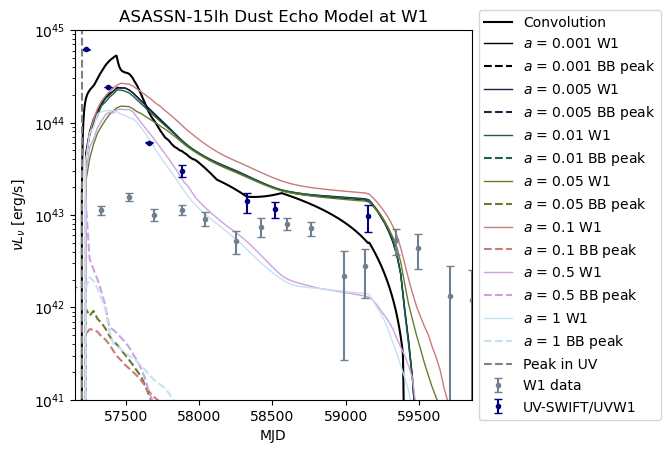

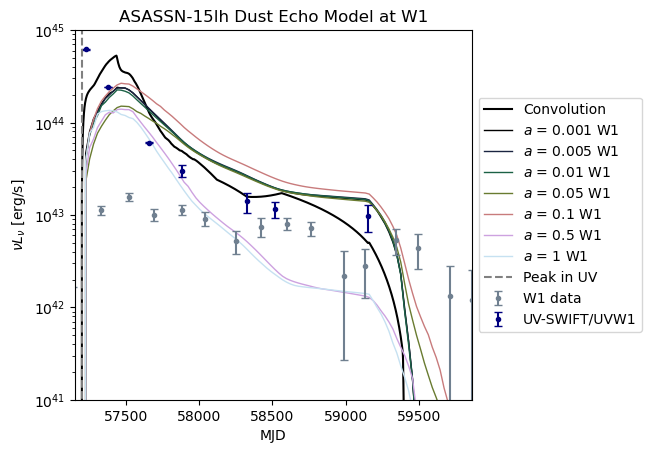

In [73]:
# Plot the lightcurve with SWIFT data and black body
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label='Convolution',color='black' )

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/wl_w1)*luminosities[i][:,w1s[i]]).to(u.erg/u.s),label=r'$a$'+f' = {amaxs[i]} W1',linewidth=1,c=color)
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosities[i][:,bbwls[i]]).to(u.erg/u.s),label=r'$a$'+f' = {amaxs[i]} BB peak',ls='dashed',c=color)

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategray')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model at W1')
fig.savefig(PLOTFILES_+'/lightcurve_w1_bb.pdf')
fig.show()

# Plot the lightcurve with SWIFT data but without black body
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
ax.plot(conv_time,conv_lum,label='Convolution',color='black' )

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/wl_w1)*luminosities[i][:,w1s[i]]).to(u.erg/u.s),label=r'$a$'+f' = {amaxs[i]} W1',linewidth=1,c=color)

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategray')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model at W1')
fig.savefig(PLOTFILES_+'/lightcurve_w1.pdf')
fig.show()

#### For W2

19/04/2024 10:42:12.176 ! /var/tmp/lankhorst/ipykernel_1688166/3766396483.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
19/04/2024 10:42:12.176 !   fig.show()
19/04/2024 10:42:12.555 ! /var/tmp/lankhorst/ipykernel_1688166/3766396483.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
19/04/2024 10:42:12.555 !   fig.show()


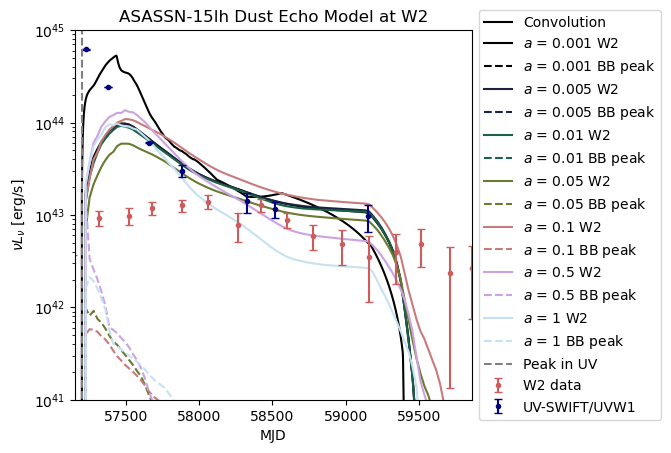

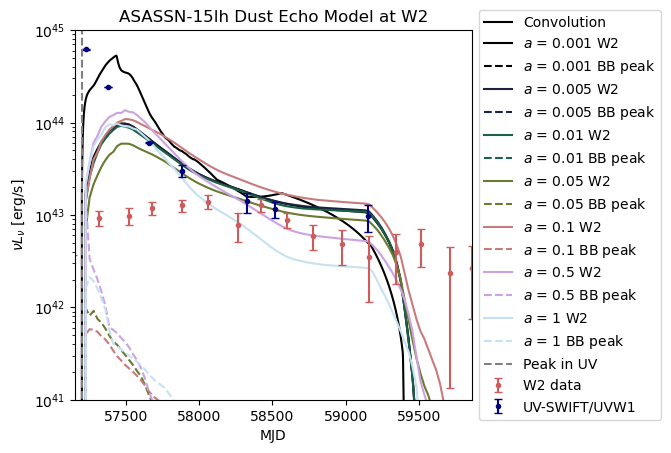

In [72]:
# Plot the lightcurve with SWIFT data and black body
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label='Convolution',color='black' )

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/wl_w2)*luminosities[i][:,w2s[i]]).to(u.erg/u.s),label=r'$a$'+f' = {amaxs[i]} W2',color=color)
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosities[i][:,bbwls[i]]).to(u.erg/u.s),label=r'$a$'+f' = {amaxs[i]} BB peak',ls='dashed',color=color)

#Plotting data
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model at W2')
fig.savefig(PLOTFILES_+'/lightcurve_w2_bb.pdf')
fig.show()

# Plot the lightcurve with SWIFT data but without black body
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
ax.plot(conv_time,conv_lum,label='Convolution',color='black' )

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/wl_w2)*luminosities[i][:,w2s[i]]).to(u.erg/u.s),label=r'$a$'+f' = {amaxs[i]} W2',color=color)
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosities[i][:,bbwls[i]]).to(u.erg/u.s),label=r'$a$'+f' = {amaxs[i]} BB peak',ls='dashed',color=color)

#Plotting data
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model at W2')
fig.savefig(PLOTFILES_+'/lightcurve_w2.pdf')
fig.show()

#### For black body peak wavelength

19/04/2024 10:41:34.424 ! /var/tmp/lankhorst/ipykernel_1688166/2367594241.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
19/04/2024 10:41:34.424 !   fig.show()


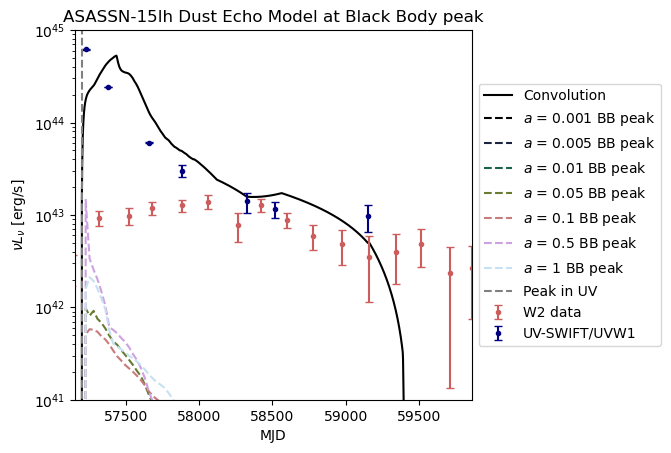

In [70]:
# Plot the lightcurve with SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label='Convolution',color='black' )

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosities[i][:,bbwls[i]]).to(u.erg/u.s),label=r'$a$'+f' = {amaxs[i]} BB peak',color=color,ls='dashed')

#Plotting data
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model at Black Body peak')
fig.savefig(PLOTFILES_+'/lightcurve_bb.pdf')
fig.show()

### Making the spectra

#### For dates closest to Wise datapoints

19/04/2024 00:34:18.511 ! /var/tmp/lankhorst/ipykernel_1688166/142014295.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
19/04/2024 00:34:18.511 !   ax.set_ylim(bottom=np.max(lightcurves[i][-1].value)/1e2,top=np.max(lightcurves[i].value)*2)
19/04/2024 00:34:18.872 ! /var/tmp/lankhorst/ipykernel_1688166/142014295.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
19/04/2024 00:34:18.872 !   fig.show()
19/04/2024 00:34:18.926 ! /var/tmp/lankhorst/ipykernel_1688166/142014295.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
19/04/2024 00:34:18.926 !   ax.set_ylim(bottom=np.max(lightcurves[i][-1].value)/1e2,top=np.max(lightcurves[i].value)*2)
19/04/2024 00:34:19.756 ! /var/tmp/lankhorst/ipykernel_1688166/142014295.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
19/04/2024 00:34:19.756 !   fig.show()
19/04/2024 00:34:19.811 ! /var/tmp/lankhorst/i

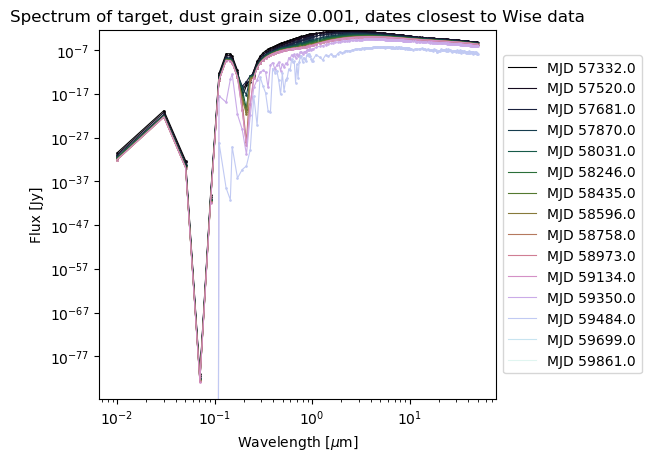

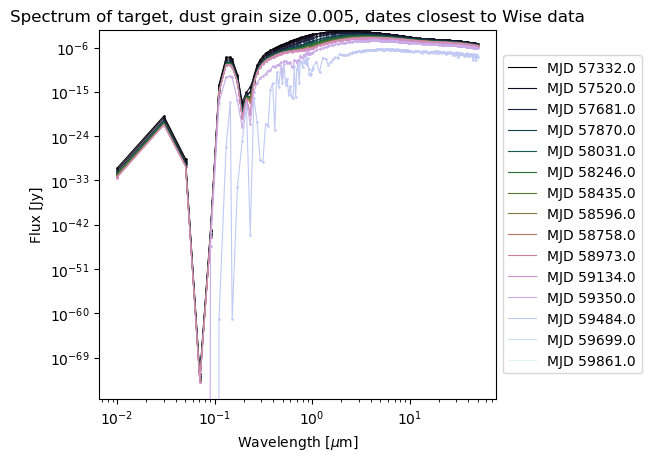

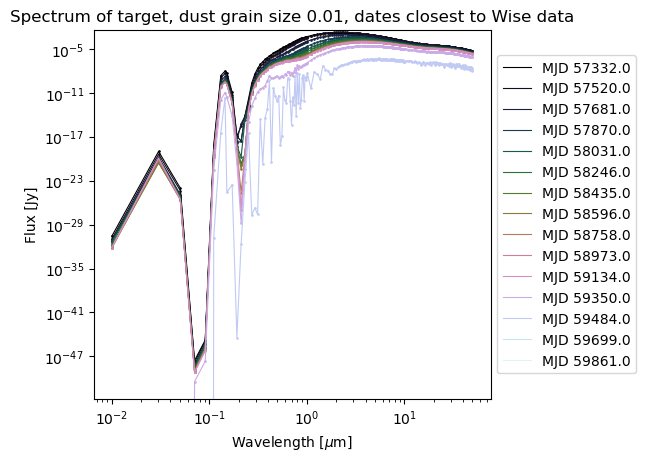

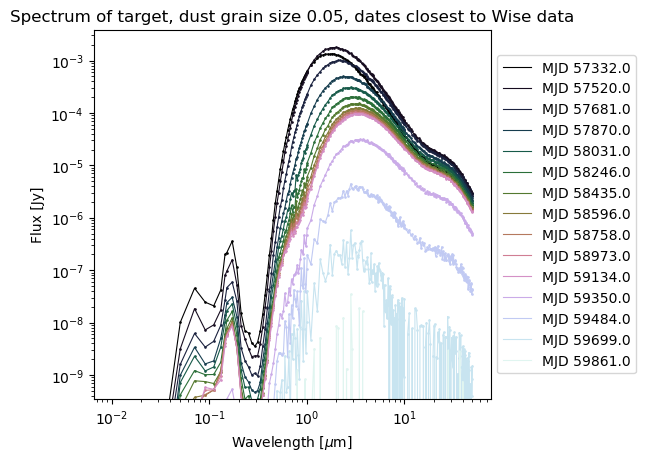

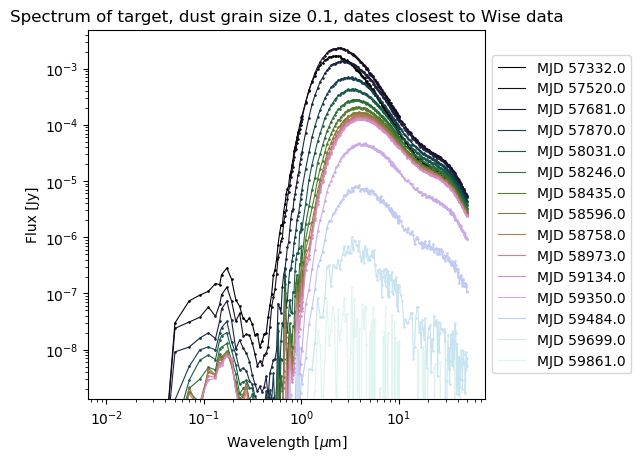

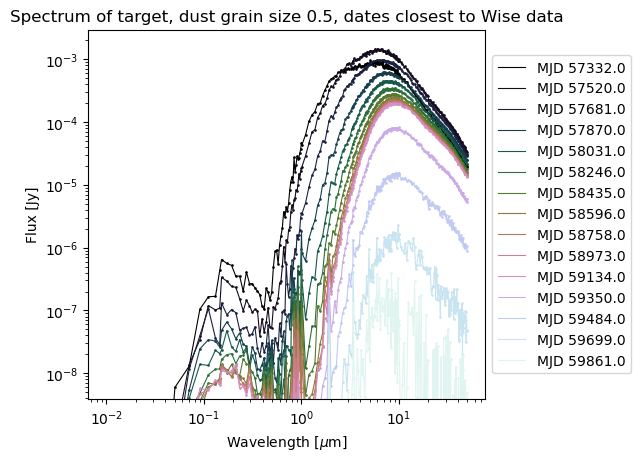

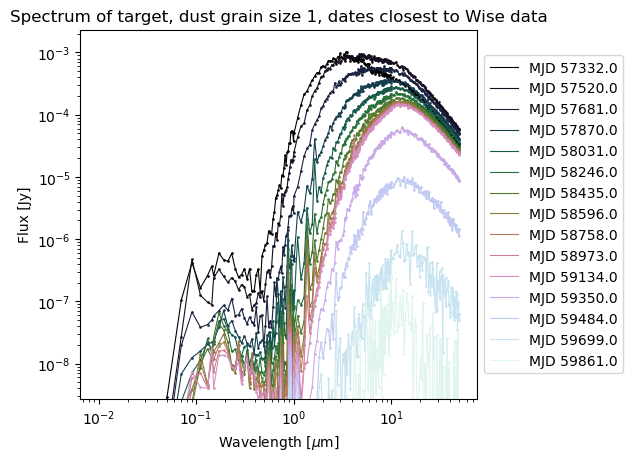

In [60]:
colours = []

w1times=[]
for i in range(len(W1[0][3:])): #Removing the first few datapoints because these occur before the smiulation started.
    w1times.append(np.argmin(np.abs(output_t-W1[0][i+3])))

cmap = plt.get_cmap('cubehelix')  # You can choose any colormap you prefer


for i in range(len(lightcurves)):
    fig=plt.figure()
    ax=plt.subplot(111)

    for t in range(len(w1times)):
        color = cmap(t / len(w1times))  # Get color from colormap
        ax.loglog(output_wavelengths, lightcurves[i][w1times[t]],label=f'MJD {round(output_t[w1times[t]],0)}',c=color,linewidth=.8)
        ax.scatter(output_wavelengths, lightcurves[i][w1times[t]],color=color,s=.8)    

    ax.set_ylabel(r'Flux [Jy]')
    ax.set_xlabel(r'Wavelength [$\mu$m]')
    ax.set_yscale('log')
    ax.set_ylim(bottom=np.max(lightcurves[i][-1].value)/1e2,top=np.max(lightcurves[i].value)*2)
    ax.set_title(f'Spectrum of target, dust grain size {amaxs[i]}, dates closest to Wise data')
    ax.set_xlim()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    fig.savefig(PLOTFILES_l[i]+f'spectrum_Wdates_a={amaxs[i]}.pdf')
    fig.show()

19/04/2024 10:41:01.109 ! /var/tmp/lankhorst/ipykernel_1688166/3745795594.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
19/04/2024 10:41:01.109 !   fig.show()


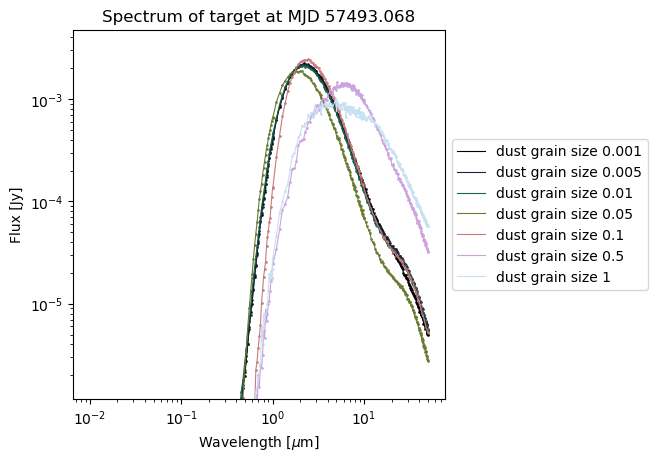

In [69]:
cmap = plt.get_cmap('cubehelix')

fig=plt.figure()
ax=plt.subplot(111)

for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.loglog(output_wavelengths, lightcurves[i][11],label=f'dust grain size {amaxs[i]}',color=color,linewidth=.8)
    ax.scatter(output_wavelengths, lightcurves[i][11],color=color,s=.8)
#ax.axvline(bbwl,label='black body peak wavelength')
ax.set_ylabel(r'Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylim(bottom=np.max(lightcurves[-1].value)/1e3,top=np.max(lightcurves[0].value)*2)
ax.set_title(f'Spectrum of target at MJD {round(output_t[11],3)}')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(PLOTFILES_+'spectrum_as.pdf')
fig.show()

#### Finding how much larger wise wavelength luminosities are than that of the black body peak wavelenght

In [62]:
for i in range(len(lightcurves)):
    w1max = (np.argmax(luminosities[i][:,w1s[i]]))
    w1L = c.c/(wl_w1)*luminosities[i][:,w1s[i]][w1max]
    w2max = (np.argmax(luminosities[i][:,w2s[i]]))
    w2L = c.c/(wl_w2)*luminosities[i][:,w2s[i]][w2max]
    bbmax = np.argmax(luminosities[i][:,bbwls[i]])
    bbL = c.c/(bbwl*u.um)*luminosities[i][:,bbwls[i]][bbmax]
    print(f"For dust grain size {amaxs[i]}:")
    print(f"Luminosity at w1 is {float(w1L/bbL)} times larger than that at the blackbody peak wavelength ")
    print(f"Luminosity at w2 is {float(w2L/bbL)} times larger than that at the blackbody peak wavelength")
    print("\n")

For dust grain size 0.001:
Luminosity at w1 is 2934.5691633121114 times larger than that at the blackbody peak wavelength 
Luminosity at w2 is 1189.5039960431998 times larger than that at the blackbody peak wavelength


For dust grain size 0.005:
Luminosity at w1 is 3191.824987233488 times larger than that at the blackbody peak wavelength 
Luminosity at w2 is 1306.4455206947403 times larger than that at the blackbody peak wavelength


For dust grain size 0.01:
Luminosity at w1 is 4004.880958822109 times larger than that at the blackbody peak wavelength 
Luminosity at w2 is 1638.4191004579325 times larger than that at the blackbody peak wavelength


For dust grain size 0.05:
Luminosity at w1 is 153.91456678783905 times larger than that at the blackbody peak wavelength 
Luminosity at w2 is 60.47586956527968 times larger than that at the blackbody peak wavelength


For dust grain size 0.1:
Luminosity at w1 is 459.1703052589267 times larger than that at the blackbody peak wavelength 
Lumin

In [63]:
print("Average temperatures in the dust for different optical depths:")
for i in range(len(temperatures)):
    print(f"For dust grain size of {amaxs[i]}, the average dust temperature is {np.average(temperatures[i])}")

Average temperatures in the dust for different optical depths:
For dust grain size of 0.001, the average dust temperature is 2101.869140625
For dust grain size of 0.005, the average dust temperature is 2106.324951171875
For dust grain size of 0.01, the average dust temperature is 2125.84716796875
For dust grain size of 0.05, the average dust temperature is 2155.764404296875
For dust grain size of 0.1, the average dust temperature is 1950.1513671875
For dust grain size of 0.5, the average dust temperature is 1877.192626953125
For dust grain size of 1, the average dust temperature is 1874.814208984375


## Changing $R_{outer}$

In [23]:
OUTFILES_ = OUTFILES+'ChangingR/'
PLOTFILES_ = PLOTFILES+'ChangingR/'

lightcurves, wavelengths, temperatures, radii, simulations = [],[],[],[],[]

normalization_type='optical_depth'
output_wavelengths = np.sort(np.concatenate((np.linspace(0.01, 1, 50), np.linspace(1.01, 10, 100), \
                                              np.linspace(10.01, 50, 100),w1w2,bbwl)))

outers = [3.0, 3.5, 4.0, 4.5, 5, 7.5, 10]
OUTFILES_l = []
PLOTFILES_l = []

for i in range(len(outers)):
    OUTFILES_l.append(OUTFILES_+'R='+str(outers[i])+'/')
    PLOTFILES_l.append(PLOTFILES_+'R='+str(outers[i])+'/')

    if os.path.isdir(OUTFILES_l[i]) == False:
        os.makedirs(OUTFILES_l[i][:-1])
    if os.path.isdir(PLOTFILES_l[i]) == False:
        os.makedirs(PLOTFILES_l[i][:-1])
    

    l,wl,T,R,sim = get_lightcurve(np.array((Lbol_data[0],Lbol_data[1] ,Lbol_data[2])), Tbol_data \
                                  ,tbol_data, output_t, np.append(output_wavelengths,relBinwidth) \
                                  ,[centralBin,outers[i],alpha]  \
                                  ,[[amin,amax,grainpowerlaw],[amin,amax,grainpowerlaw]], spaceBins \
                                  ,normalization_type=normalization_type \
                                  ,total_mass = total_mass, opt_depth = [opt_depth,0.28,'Z'], nsizes=15 \
                                  ,static=True, FWHM=FWHM ,distance=distance \
                                  ,skiname='SKI/ski_new.txt', Si=0 ,prefix=str(today) \
                                  ,OUTFILES=OUTFILES_l[i], SKIRTpath='SKIRT/release/SKIRT/main/skirt')
    
    lightcurves.append(l), wavelengths.append(wl), temperatures.append(T), radii.append(R), simulations.append(sim)
    print(f"Run {i+1} of {len(outers)} finished")

Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

24/04/2024 11:04:57.648   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 11:04:57.648   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 11:04:57.649   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.0/57197/run.ski'...
24/04/2024 11:04:58.377 - Finished setup in 0.5 s.
24/04/2024 11:04:58.471 - Finished setup output in 0.1 s.
24/04/2024 11:05:06.910 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 11:05:06.911 - Finished primary emission iteration 1 in 8.4 s.
24/04/2024 11:05:23.578 - Finished primary emission in 16.7 s.
24/04/2024 11:05:30.969 - Finished secondary emission iteration 1 in 7.4 s.
24/04/2024 11:05:38.189 - Finished secondary emission iteration 2 in 7.2 s.
24/04/2024 11:05:45.620 - Finished secondary emission iteration 3 in 7.4 s.
24/04/2024 11:05:52.805 - Finished secondary emission iteration 

SKIRT Runs:  10%|███                            | 1/10 [03:48<34:14, 228.31s/it]

24/04/2024 11:08:45.819 - Finished final output in 0.9 s.
24/04/2024 11:08:45.819 * *** Error: The following error message was issued during this simulation:
24/04/2024 11:08:45.819 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 11:08:45.819 - Finished simulation run using 6 threads and a single process in 228 s (3m 48s).
24/04/2024 11:08:45.824   Available memory: 15.4 GB -- Peak memory usage: 218 MB (1.4%)
24/04/2024 11:08:45.971   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 11:08:45.971   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 11:08:45.972   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.0/57197/run.ski'...
24/04/2024 11:08:46.682 - Finished setup in 0.5 s.
24/04/2024 11:08:46.755 - Finished setup output in 0.1 s.
24/04/2024 11:08:54.745 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  20%|██████▏                        | 2/10 [07:25<29:34, 221.77s/it]

24/04/2024 11:12:23.026 - Finished final output in 1.0 s.
24/04/2024 11:12:23.026 * *** Error: The following error message was issued during this simulation:
24/04/2024 11:12:23.026 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 11:12:23.026 - Finished simulation run using 6 threads and a single process in 217 s (3m 37s).
24/04/2024 11:12:23.030   Available memory: 15.4 GB -- Peak memory usage: 224 MB (1.4%)
24/04/2024 11:12:23.158   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 11:12:23.158   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 11:12:23.160   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.0/57208/run.ski'...
24/04/2024 11:12:23.902 - Finished setup in 0.5 s.
24/04/2024 11:12:23.993 - Finished setup output in 0.1 s.
24/04/2024 11:12:32.434 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  30%|█████████▎                     | 3/10 [11:02<25:37, 219.61s/it]

24/04/2024 11:16:00.064 - Finished final output in 0.9 s.
24/04/2024 11:16:00.064 * *** Error: The following error message was issued during this simulation:
24/04/2024 11:16:00.064 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 11:16:00.064 - Finished simulation run using 6 threads and a single process in 217 s (3m 37s).
24/04/2024 11:16:00.067   Available memory: 15.4 GB -- Peak memory usage: 229 MB (1.5%)
24/04/2024 11:16:00.200   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 11:16:00.200   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 11:16:00.201   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.0/57225/run.ski'...
24/04/2024 11:16:01.057 - Finished setup in 0.5 s.
24/04/2024 11:16:01.163 - Finished setup output in 0.1 s.
24/04/2024 11:16:09.231 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  40%|████████████▍                  | 4/10 [14:27<21:21, 213.65s/it]

24/04/2024 11:19:24.589 - Finished final output in 0.9 s.
24/04/2024 11:19:24.589 * *** Error: The following error message was issued during this simulation:
24/04/2024 11:19:24.589 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 11:19:24.589 - Finished simulation run using 6 threads and a single process in 204 s (3m 24s).
24/04/2024 11:19:24.592   Available memory: 15.4 GB -- Peak memory usage: 235 MB (1.5%)
24/04/2024 11:19:24.712   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 11:19:24.712   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 11:19:24.714   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.0/57378/run.ski'...
24/04/2024 11:19:25.392 - Finished setup in 0.5 s.
24/04/2024 11:19:25.469 - Finished setup output in 0.1 s.
24/04/2024 11:19:33.545 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  50%|███████████████▌               | 5/10 [17:37<17:07, 205.42s/it]

24/04/2024 11:22:35.373 - Finished final output in 0.9 s.
24/04/2024 11:22:35.373 * *** Error: The following error message was issued during this simulation:
24/04/2024 11:22:35.373 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 11:22:35.373 - Finished simulation run using 6 threads and a single process in 190 s (3m 10s).
24/04/2024 11:22:35.376   Available memory: 15.4 GB -- Peak memory usage: 241 MB (1.5%)
24/04/2024 11:22:35.537   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 11:22:35.537   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 11:22:35.538   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.0/57659/run.ski'...
24/04/2024 11:22:36.252 - Finished setup in 0.5 s.
24/04/2024 11:22:36.326 - Finished setup output in 0.1 s.
24/04/2024 11:22:44.296 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  60%|██████████████████▌            | 6/10 [20:31<12:57, 194.48s/it]

24/04/2024 11:25:28.651 - Finished final output in 0.8 s.
24/04/2024 11:25:28.651 * *** Error: The following error message was issued during this simulation:
24/04/2024 11:25:28.651 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 11:25:28.651 - Finished simulation run using 6 threads and a single process in 173 s (2m 53s).
24/04/2024 11:25:28.654   Available memory: 15.4 GB -- Peak memory usage: 247 MB (1.6%)
24/04/2024 11:25:28.783   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 11:25:28.783   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 11:25:28.784   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.0/57881/run.ski'...
24/04/2024 11:25:29.425 - Finished setup in 0.5 s.
24/04/2024 11:25:29.501 - Finished setup output in 0.1 s.
24/04/2024 11:25:37.510 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [23:27<09:25, 188.48s/it]

24/04/2024 11:28:24.731 - Finished final output in 1.0 s.
24/04/2024 11:28:24.731 * *** Error: The following error message was issued during this simulation:
24/04/2024 11:28:24.731 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 11:28:24.731 - Finished simulation run using 6 threads and a single process in 176 s (2m 56s).
24/04/2024 11:28:24.738   Available memory: 15.4 GB -- Peak memory usage: 253 MB (1.6%)
24/04/2024 11:28:24.912   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 11:28:24.912   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 11:28:24.913   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.0/58324/run.ski'...
24/04/2024 11:28:25.630 - Finished setup in 0.5 s.
24/04/2024 11:28:25.723 - Finished setup output in 0.1 s.
24/04/2024 11:28:33.808 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  80%|████████████████████████▊      | 8/10 [26:10<06:01, 180.50s/it]

24/04/2024 11:31:08.139 - Finished final output in 0.8 s.
24/04/2024 11:31:08.139 * *** Error: The following error message was issued during this simulation:
24/04/2024 11:31:08.139 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 11:31:08.140 - Finished simulation run using 6 threads and a single process in 163 s (2m 43s).
24/04/2024 11:31:08.145   Available memory: 15.4 GB -- Peak memory usage: 258 MB (1.6%)
24/04/2024 11:31:08.324   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 11:31:08.324   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 11:31:08.325   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.0/58519/run.ski'...
24/04/2024 11:31:08.982 - Finished setup in 0.5 s.
24/04/2024 11:31:09.057 - Finished setup output in 0.1 s.
24/04/2024 11:31:17.238 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  90%|███████████████████████████▉   | 9/10 [28:55<02:55, 175.56s/it]

24/04/2024 11:33:52.874 - Finished final output in 0.8 s.
24/04/2024 11:33:52.874 * *** Error: The following error message was issued during this simulation:
24/04/2024 11:33:52.874 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 11:33:52.874 - Finished simulation run using 6 threads and a single process in 164 s (2m 44s).
24/04/2024 11:33:52.878   Available memory: 15.4 GB -- Peak memory usage: 264 MB (1.7%)
24/04/2024 11:33:53.022   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 11:33:53.022   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 11:33:53.024   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.0/59155/run.ski'...
24/04/2024 11:33:53.707 - Finished setup in 0.5 s.
24/04/2024 11:33:53.785 - Finished setup output in 0.1 s.
24/04/2024 11:34:02.507 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs: 100%|██████████████████████████████| 10/10 [31:39<00:00, 189.94s/it]


24/04/2024 11:36:36.882 - Finished final output in 0.8 s.
24/04/2024 11:36:36.882 * *** Error: The following error message was issued during this simulation:
24/04/2024 11:36:36.882 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 11:36:36.882 - Finished simulation run using 6 threads and a single process in 164 s (2m 44s).
24/04/2024 11:36:36.884   Available memory: 15.4 GB -- Peak memory usage: 270 MB (1.7%)


100%|█████████████████████████████████████████| 253/253 [00:15<00:00, 16.35it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:08, 10.85it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:19,  4.92it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:25,  3.74it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:32,  2.90it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:39,  2.35it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:46,  1.96it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:53,  1.69it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:04<01:00,  1.47it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:05<01:07,  1.30it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:14,  1.16it/s]

Compile Lightcu

Run 1 of 7 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

24/04/2024 11:44:07.029   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 11:44:07.029   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 11:44:07.030   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.5/57197/run.ski'...
24/04/2024 11:44:07.747 - Finished setup in 0.5 s.
24/04/2024 11:44:07.822 - Finished setup output in 0.1 s.
24/04/2024 11:44:15.878 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 11:44:15.880 - Finished primary emission iteration 1 in 8.1 s.
24/04/2024 11:44:32.708 - Finished primary emission in 16.8 s.
24/04/2024 11:44:39.951 - Finished secondary emission iteration 1 in 7.2 s.
24/04/2024 11:44:47.247 - Finished secondary emission iteration 2 in 7.3 s.
24/04/2024 11:44:54.256 - Finished secondary emission iteration 3 in 7.0 s.
24/04/2024 11:45:01.360 - Finished secondary emission iteration 

SKIRT Runs:  10%|███                            | 1/10 [03:40<33:03, 220.43s/it]

24/04/2024 11:47:47.328 - Finished final output in 0.8 s.
24/04/2024 11:47:47.328 * *** Error: The following error message was issued during this simulation:
24/04/2024 11:47:47.328 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 11:47:47.328 - Finished simulation run using 6 threads and a single process in 220 s (3m 40s).
24/04/2024 11:47:47.331   Available memory: 15.4 GB -- Peak memory usage: 507 MB (3.2%)
24/04/2024 11:47:47.463   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 11:47:47.463   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 11:47:47.465   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.5/57197/run.ski'...
24/04/2024 11:47:48.151 - Finished setup in 0.5 s.
24/04/2024 11:47:48.228 - Finished setup output in 0.1 s.
24/04/2024 11:47:56.097 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  20%|██████▏                        | 2/10 [07:16<29:00, 217.62s/it]

24/04/2024 11:51:22.999 - Finished final output in 0.8 s.
24/04/2024 11:51:22.999 * *** Error: The following error message was issued during this simulation:
24/04/2024 11:51:22.999 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 11:51:22.999 - Finished simulation run using 6 threads and a single process in 215 s (3m 35s).
24/04/2024 11:51:23.002   Available memory: 15.4 GB -- Peak memory usage: 507 MB (3.2%)
24/04/2024 11:51:23.116   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 11:51:23.116   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 11:51:23.118   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.5/57208/run.ski'...
24/04/2024 11:51:23.777 - Finished setup in 0.5 s.
24/04/2024 11:51:23.882 - Finished setup output in 0.1 s.
24/04/2024 11:51:31.917 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  30%|█████████▎                     | 3/10 [10:51<25:16, 216.63s/it]

24/04/2024 11:54:58.409 - Finished final output in 1.0 s.
24/04/2024 11:54:58.409 * *** Error: The following error message was issued during this simulation:
24/04/2024 11:54:58.409 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 11:54:58.409 - Finished simulation run using 6 threads and a single process in 215 s (3m 35s).
24/04/2024 11:54:58.420   Available memory: 15.4 GB -- Peak memory usage: 507 MB (3.2%)
24/04/2024 11:54:58.614   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 11:54:58.615   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 11:54:58.616   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.5/57225/run.ski'...
24/04/2024 11:54:59.371 - Finished setup in 0.5 s.
24/04/2024 11:54:59.455 - Finished setup output in 0.1 s.
24/04/2024 11:55:07.609 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  40%|████████████▍                  | 4/10 [14:15<21:09, 211.64s/it]

24/04/2024 11:58:22.433 - Finished final output in 0.9 s.
24/04/2024 11:58:22.433 * *** Error: The following error message was issued during this simulation:
24/04/2024 11:58:22.433 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 11:58:22.433 - Finished simulation run using 6 threads and a single process in 204 s (3m 24s).
24/04/2024 11:58:22.436   Available memory: 15.4 GB -- Peak memory usage: 507 MB (3.2%)
24/04/2024 11:58:22.556   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 11:58:22.556   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 11:58:22.557   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.5/57378/run.ski'...
24/04/2024 11:58:23.271 - Finished setup in 0.5 s.
24/04/2024 11:58:23.346 - Finished setup output in 0.1 s.
24/04/2024 11:58:31.676 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  50%|███████████████▌               | 5/10 [17:32<17:10, 206.18s/it]

24/04/2024 12:01:38.938 - Finished final output in 1.3 s.
24/04/2024 12:01:38.938 * *** Error: The following error message was issued during this simulation:
24/04/2024 12:01:38.938 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:01:38.938 - Finished simulation run using 6 threads and a single process in 196 s (3m 16s).
24/04/2024 12:01:38.942   Available memory: 15.4 GB -- Peak memory usage: 507 MB (3.2%)
24/04/2024 12:01:39.094   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 12:01:39.094   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 12:01:39.096   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.5/57659/run.ski'...
24/04/2024 12:01:39.798 - Finished setup in 0.5 s.
24/04/2024 12:01:39.870 - Finished setup output in 0.1 s.
24/04/2024 12:01:48.144 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  60%|██████████████████▌            | 6/10 [20:29<13:05, 196.47s/it]

24/04/2024 12:04:36.555 - Finished final output in 0.9 s.
24/04/2024 12:04:36.555 * *** Error: The following error message was issued during this simulation:
24/04/2024 12:04:36.555 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:04:36.555 - Finished simulation run using 6 threads and a single process in 177 s (2m 57s).
24/04/2024 12:04:36.558   Available memory: 15.4 GB -- Peak memory usage: 507 MB (3.2%)
24/04/2024 12:04:36.684   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 12:04:36.684   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 12:04:36.685   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.5/57881/run.ski'...
24/04/2024 12:04:37.342 - Finished setup in 0.5 s.
24/04/2024 12:04:37.415 - Finished setup output in 0.1 s.
24/04/2024 12:04:45.603 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [23:17<09:21, 187.08s/it]

24/04/2024 12:07:24.246 - Finished final output in 1.0 s.
24/04/2024 12:07:24.246 * *** Error: The following error message was issued during this simulation:
24/04/2024 12:07:24.246 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:07:24.246 - Finished simulation run using 6 threads and a single process in 167 s (2m 47s).
24/04/2024 12:07:24.253   Available memory: 15.4 GB -- Peak memory usage: 507 MB (3.2%)
24/04/2024 12:07:24.426   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 12:07:24.426   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 12:07:24.427   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.5/58324/run.ski'...
24/04/2024 12:07:25.178 - Finished setup in 0.5 s.
24/04/2024 12:07:25.293 - Finished setup output in 0.1 s.
24/04/2024 12:07:33.333 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  80%|████████████████████████▊      | 8/10 [26:01<05:59, 179.75s/it]

24/04/2024 12:10:08.333 - Finished final output in 0.8 s.
24/04/2024 12:10:08.333 * *** Error: The following error message was issued during this simulation:
24/04/2024 12:10:08.333 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:10:08.333 - Finished simulation run using 6 threads and a single process in 164 s (2m 44s).
24/04/2024 12:10:08.337   Available memory: 15.4 GB -- Peak memory usage: 507 MB (3.2%)
24/04/2024 12:10:08.473   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 12:10:08.473   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 12:10:08.474   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.5/58519/run.ski'...
24/04/2024 12:10:09.123 - Finished setup in 0.5 s.
24/04/2024 12:10:09.200 - Finished setup output in 0.1 s.
24/04/2024 12:10:17.309 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  90%|███████████████████████████▉   | 9/10 [28:47<02:55, 175.39s/it]

24/04/2024 12:12:54.143 - Finished final output in 1.1 s.
24/04/2024 12:12:54.143 * *** Error: The following error message was issued during this simulation:
24/04/2024 12:12:54.143 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:12:54.143 - Finished simulation run using 6 threads and a single process in 165 s (2m 45s).
24/04/2024 12:12:54.147   Available memory: 15.4 GB -- Peak memory usage: 507 MB (3.2%)
24/04/2024 12:12:54.282   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 12:12:54.282   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 12:12:54.283   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=3.5/59155/run.ski'...
24/04/2024 12:12:55.009 - Finished setup in 0.5 s.
24/04/2024 12:12:55.103 - Finished setup output in 0.1 s.
24/04/2024 12:13:03.361 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs: 100%|██████████████████████████████| 10/10 [31:31<00:00, 189.16s/it]


24/04/2024 12:15:38.535 - Finished final output in 0.8 s.
24/04/2024 12:15:38.535 * *** Error: The following error message was issued during this simulation:
24/04/2024 12:15:38.535 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:15:38.535 - Finished simulation run using 6 threads and a single process in 164 s (2m 44s).
24/04/2024 12:15:38.542   Available memory: 15.4 GB -- Peak memory usage: 507 MB (3.2%)


100%|█████████████████████████████████████████| 253/253 [00:15<00:00, 16.27it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:08, 11.18it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:19,  4.93it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:25,  3.72it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:31,  2.91it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:39,  2.35it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:46,  1.95it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:54,  1.65it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:05<01:01,  1.45it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:05<01:08,  1.29it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:15,  1.15it/s]

Compile Lightcu

Run 2 of 7 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

24/04/2024 12:23:12.991   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 12:23:12.991   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 12:23:12.995   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.0/57197/run.ski'...
24/04/2024 12:23:13.729 - Finished setup in 0.5 s.
24/04/2024 12:23:13.806 - Finished setup output in 0.1 s.
24/04/2024 12:23:21.891 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:23:21.891 - Finished primary emission iteration 1 in 8.1 s.
24/04/2024 12:23:39.103 - Finished primary emission in 17.2 s.
24/04/2024 12:23:46.380 - Finished secondary emission iteration 1 in 7.3 s.
24/04/2024 12:23:53.383 - Finished secondary emission iteration 2 in 7.0 s.
24/04/2024 12:24:00.418 - Finished secondary emission iteration 3 in 7.0 s.
24/04/2024 12:24:07.500 - Finished secondary emission iteration 

SKIRT Runs:  10%|███                            | 1/10 [03:39<32:54, 219.40s/it]

24/04/2024 12:26:52.229 - Finished final output in 0.8 s.
24/04/2024 12:26:52.229 * *** Error: The following error message was issued during this simulation:
24/04/2024 12:26:52.230 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:26:52.230 - Finished simulation run using 6 threads and a single process in 219 s (3m 39s).
24/04/2024 12:26:52.233   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 12:26:52.397   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 12:26:52.397   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 12:26:52.398   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.0/57197/run.ski'...
24/04/2024 12:26:53.139 - Finished setup in 0.5 s.
24/04/2024 12:26:53.263 - Finished setup output in 0.1 s.
24/04/2024 12:27:01.369 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  20%|██████▏                        | 2/10 [07:16<29:03, 217.99s/it]

24/04/2024 12:30:29.267 - Finished final output in 0.9 s.
24/04/2024 12:30:29.267 * *** Error: The following error message was issued during this simulation:
24/04/2024 12:30:29.267 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:30:29.267 - Finished simulation run using 6 threads and a single process in 217 s (3m 37s).
24/04/2024 12:30:29.270   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 12:30:29.385   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 12:30:29.385   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 12:30:29.387   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.0/57208/run.ski'...
24/04/2024 12:30:30.066 - Finished setup in 0.5 s.
24/04/2024 12:30:30.147 - Finished setup output in 0.1 s.
24/04/2024 12:30:38.406 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  30%|█████████▎                     | 3/10 [10:56<25:32, 218.98s/it]

24/04/2024 12:34:09.427 - Finished final output in 0.8 s.
24/04/2024 12:34:09.427 * *** Error: The following error message was issued during this simulation:
24/04/2024 12:34:09.427 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:34:09.427 - Finished simulation run using 6 threads and a single process in 220 s (3m 40s).
24/04/2024 12:34:09.431   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 12:34:09.545   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 12:34:09.545   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 12:34:09.546   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.0/57225/run.ski'...
24/04/2024 12:34:10.211 - Finished setup in 0.5 s.
24/04/2024 12:34:10.282 - Finished setup output in 0.1 s.
24/04/2024 12:34:18.419 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  40%|████████████▍                  | 4/10 [14:21<21:20, 213.41s/it]

24/04/2024 12:37:34.287 - Finished final output in 0.9 s.
24/04/2024 12:37:34.287 * *** Error: The following error message was issued during this simulation:
24/04/2024 12:37:34.287 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:37:34.287 - Finished simulation run using 6 threads and a single process in 205 s (3m 25s).
24/04/2024 12:37:34.291   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 12:37:34.409   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 12:37:34.409   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 12:37:34.410   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.0/57378/run.ski'...
24/04/2024 12:37:35.098 - Finished setup in 0.5 s.
24/04/2024 12:37:35.172 - Finished setup output in 0.1 s.
24/04/2024 12:37:43.178 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  50%|███████████████▌               | 5/10 [17:31<17:05, 205.04s/it]

24/04/2024 12:40:44.498 - Finished final output in 0.8 s.
24/04/2024 12:40:44.498 * *** Error: The following error message was issued during this simulation:
24/04/2024 12:40:44.498 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:40:44.498 - Finished simulation run using 6 threads and a single process in 190 s (3m 10s).
24/04/2024 12:40:44.502   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 12:40:44.622   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 12:40:44.622   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 12:40:44.623   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.0/57659/run.ski'...
24/04/2024 12:40:45.322 - Finished setup in 0.5 s.
24/04/2024 12:40:45.401 - Finished setup output in 0.1 s.
24/04/2024 12:40:53.489 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  60%|██████████████████▌            | 6/10 [20:25<12:57, 194.27s/it]

24/04/2024 12:43:37.816 - Finished final output in 0.8 s.
24/04/2024 12:43:37.816 * *** Error: The following error message was issued during this simulation:
24/04/2024 12:43:37.816 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:43:37.816 - Finished simulation run using 6 threads and a single process in 173 s (2m 53s).
24/04/2024 12:43:37.819   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 12:43:37.989   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 12:43:37.989   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 12:43:37.990   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.0/57881/run.ski'...
24/04/2024 12:43:38.682 - Finished setup in 0.5 s.
24/04/2024 12:43:38.756 - Finished setup output in 0.1 s.
24/04/2024 12:43:46.939 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [23:11<09:15, 185.33s/it]

24/04/2024 12:46:24.768 - Finished final output in 0.9 s.
24/04/2024 12:46:24.768 * *** Error: The following error message was issued during this simulation:
24/04/2024 12:46:24.768 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:46:24.768 - Finished simulation run using 6 threads and a single process in 167 s (2m 47s).
24/04/2024 12:46:24.772   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 12:46:24.903   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 12:46:24.903   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 12:46:24.905   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.0/58324/run.ski'...
24/04/2024 12:46:25.638 - Finished setup in 0.5 s.
24/04/2024 12:46:25.712 - Finished setup output in 0.1 s.
24/04/2024 12:46:33.756 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  80%|████████████████████████▊      | 8/10 [25:55<05:56, 178.26s/it]

24/04/2024 12:49:07.859 - Finished final output in 0.9 s.
24/04/2024 12:49:07.859 * *** Error: The following error message was issued during this simulation:
24/04/2024 12:49:07.859 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:49:07.859 - Finished simulation run using 6 threads and a single process in 163 s (2m 43s).
24/04/2024 12:49:07.862   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 12:49:08.013   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 12:49:08.013   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 12:49:08.015   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.0/58519/run.ski'...
24/04/2024 12:49:08.721 - Finished setup in 0.5 s.
24/04/2024 12:49:08.797 - Finished setup output in 0.1 s.
24/04/2024 12:49:16.812 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  90%|███████████████████████████▉   | 9/10 [28:36<02:53, 173.11s/it]

24/04/2024 12:51:49.684 - Finished final output in 0.8 s.
24/04/2024 12:51:49.684 * *** Error: The following error message was issued during this simulation:
24/04/2024 12:51:49.684 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:51:49.684 - Finished simulation run using 6 threads and a single process in 161 s (2m 41s).
24/04/2024 12:51:49.687   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 12:51:49.818   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 12:51:49.818   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 12:51:49.820   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.0/59155/run.ski'...
24/04/2024 12:51:50.527 - Finished setup in 0.5 s.
24/04/2024 12:51:50.602 - Finished setup output in 0.1 s.
24/04/2024 12:51:58.621 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs: 100%|██████████████████████████████| 10/10 [31:17<00:00, 187.79s/it]


24/04/2024 12:54:30.716 - Finished final output in 0.9 s.
24/04/2024 12:54:30.716 * *** Error: The following error message was issued during this simulation:
24/04/2024 12:54:30.716 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 12:54:30.716 - Finished simulation run using 6 threads and a single process in 161 s (2m 41s).
24/04/2024 12:54:30.726   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)


100%|█████████████████████████████████████████| 253/253 [00:15<00:00, 16.23it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   2%|▍                      | 2/100 [00:00<00:05, 18.85it/s]

Compile Lightcurve:   4%|▉                      | 4/100 [00:00<00:15,  6.36it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:25,  3.68it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:31,  2.94it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:38,  2.40it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:45,  2.01it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:52,  1.72it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:04<00:59,  1.49it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:05<01:07,  1.31it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:14,  1.16it/s]

Compile Lightcu

Run 3 of 7 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

24/04/2024 13:02:05.822   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 13:02:05.822   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 13:02:05.826   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.5/57197/run.ski'...
24/04/2024 13:02:06.572 - Finished setup in 0.5 s.
24/04/2024 13:02:06.661 - Finished setup output in 0.1 s.
24/04/2024 13:02:14.619 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:02:14.619 - Finished primary emission iteration 1 in 8.0 s.
24/04/2024 13:02:31.730 - Finished primary emission in 17.1 s.
24/04/2024 13:02:38.850 - Finished secondary emission iteration 1 in 7.1 s.
24/04/2024 13:02:46.156 - Finished secondary emission iteration 2 in 7.3 s.
24/04/2024 13:02:53.087 - Finished secondary emission iteration 3 in 6.9 s.
24/04/2024 13:03:00.003 - Finished secondary emission iteration 

SKIRT Runs:  10%|███                            | 1/10 [03:36<32:32, 216.99s/it]

24/04/2024 13:05:42.671 - Finished final output in 0.9 s.
24/04/2024 13:05:42.671 * *** Error: The following error message was issued during this simulation:
24/04/2024 13:05:42.671 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:05:42.671 - Finished simulation run using 6 threads and a single process in 217 s (3m 37s).
24/04/2024 13:05:42.675   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 13:05:42.808   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 13:05:42.808   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 13:05:42.809   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.5/57197/run.ski'...
24/04/2024 13:05:43.513 - Finished setup in 0.5 s.
24/04/2024 13:05:43.613 - Finished setup output in 0.1 s.
24/04/2024 13:05:51.753 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  20%|██████▏                        | 2/10 [07:10<28:41, 215.20s/it]

24/04/2024 13:09:16.631 - Finished final output in 0.8 s.
24/04/2024 13:09:16.631 * *** Error: The following error message was issued during this simulation:
24/04/2024 13:09:16.631 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:09:16.631 - Finished simulation run using 6 threads and a single process in 214 s (3m 34s).
24/04/2024 13:09:16.635   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 13:09:16.751   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 13:09:16.751   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 13:09:16.753   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.5/57208/run.ski'...
24/04/2024 13:09:17.630 - Finished setup in 0.5 s.
24/04/2024 13:09:17.715 - Finished setup output in 0.1 s.
24/04/2024 13:09:25.754 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  30%|█████████▎                     | 3/10 [10:47<25:09, 215.60s/it]

24/04/2024 13:12:52.694 - Finished final output in 0.8 s.
24/04/2024 13:12:52.694 * *** Error: The following error message was issued during this simulation:
24/04/2024 13:12:52.694 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:12:52.694 - Finished simulation run using 6 threads and a single process in 216 s (3m 36s).
24/04/2024 13:12:52.697   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 13:12:52.815   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 13:12:52.815   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 13:12:52.817   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.5/57225/run.ski'...
24/04/2024 13:12:53.513 - Finished setup in 0.5 s.
24/04/2024 13:12:53.589 - Finished setup output in 0.1 s.
24/04/2024 13:13:01.651 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  40%|████████████▍                  | 4/10 [14:08<21:00, 210.15s/it]

24/04/2024 13:16:14.495 - Finished final output in 0.8 s.
24/04/2024 13:16:14.495 * *** Error: The following error message was issued during this simulation:
24/04/2024 13:16:14.495 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:16:14.495 - Finished simulation run using 6 threads and a single process in 201 s (3m 21s).
24/04/2024 13:16:14.499   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 13:16:14.617   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 13:16:14.617   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 13:16:14.618   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.5/57378/run.ski'...
24/04/2024 13:16:15.294 - Finished setup in 0.5 s.
24/04/2024 13:16:15.369 - Finished setup output in 0.1 s.
24/04/2024 13:16:23.576 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  50%|███████████████▌               | 5/10 [17:17<16:52, 202.43s/it]

24/04/2024 13:19:23.224 - Finished final output in 0.8 s.
24/04/2024 13:19:23.224 * *** Error: The following error message was issued during this simulation:
24/04/2024 13:19:23.224 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:19:23.224 - Finished simulation run using 6 threads and a single process in 188 s (3m 8s).
24/04/2024 13:19:23.227   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 13:19:23.346   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 13:19:23.346   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 13:19:23.347   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.5/57659/run.ski'...
24/04/2024 13:19:24.096 - Finished setup in 0.5 s.
24/04/2024 13:19:24.172 - Finished setup output in 0.1 s.
24/04/2024 13:19:32.299 * *** Error: Cannot destroy dust for fragmented dust

SKIRT Runs:  60%|██████████████████▌            | 6/10 [20:08<12:47, 191.79s/it]

24/04/2024 13:22:14.362 - Finished final output in 0.8 s.
24/04/2024 13:22:14.362 * *** Error: The following error message was issued during this simulation:
24/04/2024 13:22:14.362 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:22:14.362 - Finished simulation run using 6 threads and a single process in 171 s (2m 51s).
24/04/2024 13:22:14.366   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 13:22:14.493   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 13:22:14.493   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 13:22:14.494   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.5/57881/run.ski'...
24/04/2024 13:22:15.186 - Finished setup in 0.5 s.
24/04/2024 13:22:15.263 - Finished setup output in 0.1 s.
24/04/2024 13:22:23.185 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [22:57<09:13, 184.41s/it]

24/04/2024 13:25:03.541 - Finished final output in 0.8 s.
24/04/2024 13:25:03.541 * *** Error: The following error message was issued during this simulation:
24/04/2024 13:25:03.541 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:25:03.541 - Finished simulation run using 6 threads and a single process in 169 s (2m 49s).
24/04/2024 13:25:03.546   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 13:25:03.708   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 13:25:03.708   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 13:25:03.710   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.5/58324/run.ski'...
24/04/2024 13:25:04.394 - Finished setup in 0.5 s.
24/04/2024 13:25:04.468 - Finished setup output in 0.1 s.
24/04/2024 13:25:12.261 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  80%|████████████████████████▊      | 8/10 [25:40<05:54, 177.46s/it]

24/04/2024 13:27:46.147 - Finished final output in 0.9 s.
24/04/2024 13:27:46.147 * *** Error: The following error message was issued during this simulation:
24/04/2024 13:27:46.147 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:27:46.147 - Finished simulation run using 6 threads and a single process in 162 s (2m 42s).
24/04/2024 13:27:46.150   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 13:27:46.287   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 13:27:46.287   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 13:27:46.288   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.5/58519/run.ski'...
24/04/2024 13:27:47.023 - Finished setup in 0.5 s.
24/04/2024 13:27:47.104 - Finished setup output in 0.1 s.
24/04/2024 13:27:55.070 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  90%|███████████████████████████▉   | 9/10 [28:24<02:53, 173.18s/it]

24/04/2024 13:30:29.913 - Finished final output in 0.8 s.
24/04/2024 13:30:29.913 * *** Error: The following error message was issued during this simulation:
24/04/2024 13:30:29.913 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:30:29.913 - Finished simulation run using 6 threads and a single process in 163 s (2m 43s).
24/04/2024 13:30:29.917   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 13:30:30.051   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 13:30:30.051   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 13:30:30.052   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=4.5/59155/run.ski'...
24/04/2024 13:30:30.751 - Finished setup in 0.5 s.
24/04/2024 13:30:30.823 - Finished setup output in 0.1 s.
24/04/2024 13:30:38.579 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs: 100%|██████████████████████████████| 10/10 [30:58<00:00, 185.83s/it]


24/04/2024 13:33:03.995 - Finished final output in 0.8 s.
24/04/2024 13:33:03.995 * *** Error: The following error message was issued during this simulation:
24/04/2024 13:33:03.995 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:33:03.995 - Finished simulation run using 6 threads and a single process in 154 s (2m 34s).
24/04/2024 13:33:03.998   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)


100%|█████████████████████████████████████████| 253/253 [00:15<00:00, 16.39it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:08, 11.12it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:18,  5.08it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:24,  3.83it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:31,  2.96it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:38,  2.40it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:45,  1.98it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:54,  1.67it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:04<01:00,  1.46it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:05<01:07,  1.30it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:14,  1.16it/s]

Compile Lightcu

Run 4 of 7 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

24/04/2024 13:40:37.504   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 13:40:37.504   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 13:40:37.505   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=5/57197/run.ski'...
24/04/2024 13:40:38.177 - Finished setup in 0.5 s.
24/04/2024 13:40:38.254 - Finished setup output in 0.1 s.
24/04/2024 13:40:46.354 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:40:46.354 - Finished primary emission iteration 1 in 8.1 s.
24/04/2024 13:41:03.165 - Finished primary emission in 16.8 s.
24/04/2024 13:41:10.416 - Finished secondary emission iteration 1 in 7.2 s.
24/04/2024 13:41:17.431 - Finished secondary emission iteration 2 in 7.0 s.
24/04/2024 13:41:24.368 - Finished secondary emission iteration 3 in 6.9 s.
24/04/2024 13:41:31.298 - Finished secondary emission iteration 4 

SKIRT Runs:  10%|███                            | 1/10 [03:36<32:27, 216.44s/it]

24/04/2024 13:44:13.814 - Finished final output in 0.8 s.
24/04/2024 13:44:13.814 * *** Error: The following error message was issued during this simulation:
24/04/2024 13:44:13.814 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:44:13.814 - Finished simulation run using 6 threads and a single process in 216 s (3m 36s).
24/04/2024 13:44:13.817   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 13:44:13.946   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 13:44:13.946   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 13:44:13.948   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=5/57197/run.ski'...
24/04/2024 13:44:14.634 - Finished setup in 0.5 s.
24/04/2024 13:44:14.719 - Finished setup output in 0.1 s.
24/04/2024 13:44:22.685 * *** Error: Cannot destroy dust for fragmented dust 

SKIRT Runs:  20%|██████▏                        | 2/10 [07:09<28:36, 214.53s/it]

24/04/2024 13:47:47.013 - Finished final output in 0.8 s.
24/04/2024 13:47:47.013 * *** Error: The following error message was issued during this simulation:
24/04/2024 13:47:47.013 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:47:47.013 - Finished simulation run using 6 threads and a single process in 213 s (3m 33s).
24/04/2024 13:47:47.016   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 13:47:47.130   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 13:47:47.130   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 13:47:47.131   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=5/57208/run.ski'...
24/04/2024 13:47:47.804 - Finished setup in 0.5 s.
24/04/2024 13:47:47.889 - Finished setup output in 0.1 s.
24/04/2024 13:47:55.770 * *** Error: Cannot destroy dust for fragmented dust 

SKIRT Runs:  30%|█████████▎                     | 3/10 [10:43<24:59, 214.26s/it]

24/04/2024 13:51:20.947 - Finished final output in 0.8 s.
24/04/2024 13:51:20.947 * *** Error: The following error message was issued during this simulation:
24/04/2024 13:51:20.947 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:51:20.947 - Finished simulation run using 6 threads and a single process in 214 s (3m 34s).
24/04/2024 13:51:20.950   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 13:51:21.063   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 13:51:21.063   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 13:51:21.064   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=5/57225/run.ski'...
24/04/2024 13:51:21.771 - Finished setup in 0.5 s.
24/04/2024 13:51:21.921 - Finished setup output in 0.1 s.
24/04/2024 13:51:30.126 * *** Error: Cannot destroy dust for fragmented dust 

SKIRT Runs:  40%|████████████▍                  | 4/10 [14:04<20:54, 209.01s/it]

24/04/2024 13:54:41.907 - Finished final output in 0.8 s.
24/04/2024 13:54:41.907 * *** Error: The following error message was issued during this simulation:
24/04/2024 13:54:41.907 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:54:41.907 - Finished simulation run using 6 threads and a single process in 201 s (3m 21s).
24/04/2024 13:54:41.910   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 13:54:42.027   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 13:54:42.027   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 13:54:42.028   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=5/57378/run.ski'...
24/04/2024 13:54:42.726 - Finished setup in 0.5 s.
24/04/2024 13:54:42.831 - Finished setup output in 0.1 s.
24/04/2024 13:54:50.890 * *** Error: Cannot destroy dust for fragmented dust 

SKIRT Runs:  50%|███████████████▌               | 5/10 [17:11<16:45, 201.14s/it]

24/04/2024 13:57:49.044 - Finished final output in 0.8 s.
24/04/2024 13:57:49.044 * *** Error: The following error message was issued during this simulation:
24/04/2024 13:57:49.044 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 13:57:49.044 - Finished simulation run using 6 threads and a single process in 187 s (3m 7s).
24/04/2024 13:57:49.047   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 13:57:49.208   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 13:57:49.208   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 13:57:49.209   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=5/57659/run.ski'...
24/04/2024 13:57:49.942 - Finished setup in 0.5 s.
24/04/2024 13:57:50.022 - Finished setup output in 0.1 s.
24/04/2024 13:57:58.118 * *** Error: Cannot destroy dust for fragmented dust m

SKIRT Runs:  60%|██████████████████▌            | 6/10 [20:02<12:43, 190.81s/it]

24/04/2024 14:00:39.834 - Finished final output in 0.8 s.
24/04/2024 14:00:39.834 * *** Error: The following error message was issued during this simulation:
24/04/2024 14:00:39.834 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:00:39.834 - Finished simulation run using 6 threads and a single process in 170 s (2m 50s).
24/04/2024 14:00:39.837   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 14:00:39.966   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 14:00:39.966   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 14:00:39.967   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=5/57881/run.ski'...
24/04/2024 14:00:40.636 - Finished setup in 0.5 s.
24/04/2024 14:00:40.714 - Finished setup output in 0.1 s.
24/04/2024 14:00:48.901 * *** Error: Cannot destroy dust for fragmented dust 

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [22:48<09:08, 182.87s/it]

24/04/2024 14:03:26.309 - Finished final output in 0.8 s.
24/04/2024 14:03:26.309 * *** Error: The following error message was issued during this simulation:
24/04/2024 14:03:26.310 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:03:26.310 - Finished simulation run using 6 threads and a single process in 166 s (2m 46s).
24/04/2024 14:03:26.315   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 14:03:26.485   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 14:03:26.485   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 14:03:26.486   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=5/58324/run.ski'...
24/04/2024 14:03:27.176 - Finished setup in 0.5 s.
24/04/2024 14:03:27.256 - Finished setup output in 0.1 s.
24/04/2024 14:03:35.244 * *** Error: Cannot destroy dust for fragmented dust 

SKIRT Runs:  80%|████████████████████████▊      | 8/10 [25:31<05:52, 176.40s/it]

24/04/2024 14:06:08.916 - Finished final output in 0.9 s.
24/04/2024 14:06:08.916 * *** Error: The following error message was issued during this simulation:
24/04/2024 14:06:08.916 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:06:08.916 - Finished simulation run using 6 threads and a single process in 162 s (2m 42s).
24/04/2024 14:06:08.919   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 14:06:09.050   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 14:06:09.050   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 14:06:09.051   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=5/58519/run.ski'...
24/04/2024 14:06:09.801 - Finished setup in 0.5 s.
24/04/2024 14:06:09.878 - Finished setup output in 0.1 s.
24/04/2024 14:06:17.849 * *** Error: Cannot destroy dust for fragmented dust 

SKIRT Runs:  90%|███████████████████████████▉   | 9/10 [28:12<02:51, 171.58s/it]

24/04/2024 14:08:49.839 - Finished final output in 0.9 s.
24/04/2024 14:08:49.839 * *** Error: The following error message was issued during this simulation:
24/04/2024 14:08:49.839 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:08:49.839 - Finished simulation run using 6 threads and a single process in 161 s (2m 41s).
24/04/2024 14:08:49.846   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 14:08:50.019   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 14:08:50.019   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 14:08:50.021   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=5/59155/run.ski'...
24/04/2024 14:08:50.672 - Finished setup in 0.5 s.
24/04/2024 14:08:50.747 - Finished setup output in 0.1 s.
24/04/2024 14:08:58.611 * *** Error: Cannot destroy dust for fragmented dust 

SKIRT Runs: 100%|██████████████████████████████| 10/10 [30:46<00:00, 184.65s/it]


24/04/2024 14:11:23.835 - Finished final output in 0.8 s.
24/04/2024 14:11:23.835 * *** Error: The following error message was issued during this simulation:
24/04/2024 14:11:23.835 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:11:23.835 - Finished simulation run using 6 threads and a single process in 154 s (2m 34s).
24/04/2024 14:11:23.839   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)


100%|█████████████████████████████████████████| 253/253 [00:15<00:00, 16.40it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:08, 11.39it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:18,  5.06it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:24,  3.84it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:31,  2.97it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:38,  2.37it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:46,  1.97it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:54,  1.66it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:04<01:01,  1.45it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:05<01:08,  1.29it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:15,  1.16it/s]

Compile Lightcu

Run 5 of 7 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

24/04/2024 14:18:56.978   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 14:18:56.978   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 14:18:56.979   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=7.5/57197/run.ski'...
24/04/2024 14:18:57.671 - Finished setup in 0.5 s.
24/04/2024 14:18:57.757 - Finished setup output in 0.1 s.
24/04/2024 14:19:06.227 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:19:06.227 - Finished primary emission iteration 1 in 8.5 s.
24/04/2024 14:19:23.241 - Finished primary emission in 17.0 s.
24/04/2024 14:19:30.303 - Finished secondary emission iteration 1 in 7.1 s.
24/04/2024 14:19:37.222 - Finished secondary emission iteration 2 in 6.9 s.
24/04/2024 14:19:44.229 - Finished secondary emission iteration 3 in 7.0 s.
24/04/2024 14:19:51.256 - Finished secondary emission iteration 

SKIRT Runs:  10%|███                            | 1/10 [03:36<32:26, 216.31s/it]

24/04/2024 14:22:33.161 - Finished final output in 0.8 s.
24/04/2024 14:22:33.161 * *** Error: The following error message was issued during this simulation:
24/04/2024 14:22:33.161 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:22:33.161 - Finished simulation run using 6 threads and a single process in 216 s (3m 36s).
24/04/2024 14:22:33.164   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 14:22:33.301   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 14:22:33.301   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 14:22:33.303   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=7.5/57197/run.ski'...
24/04/2024 14:22:34.036 - Finished setup in 0.5 s.
24/04/2024 14:22:34.107 - Finished setup output in 0.1 s.
24/04/2024 14:22:42.311 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  20%|██████▏                        | 2/10 [07:00<27:54, 209.27s/it]

24/04/2024 14:25:57.500 - Finished final output in 0.8 s.
24/04/2024 14:25:57.500 * *** Error: The following error message was issued during this simulation:
24/04/2024 14:25:57.500 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:25:57.500 - Finished simulation run using 6 threads and a single process in 204 s (3m 24s).
24/04/2024 14:25:57.503   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 14:25:57.624   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 14:25:57.624   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 14:25:57.625   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=7.5/57208/run.ski'...
24/04/2024 14:25:58.266 - Finished setup in 0.5 s.
24/04/2024 14:25:58.342 - Finished setup output in 0.1 s.
24/04/2024 14:26:06.289 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  30%|█████████▎                     | 3/10 [10:24<24:06, 206.64s/it]

24/04/2024 14:29:21.019 - Finished final output in 0.8 s.
24/04/2024 14:29:21.019 * *** Error: The following error message was issued during this simulation:
24/04/2024 14:29:21.019 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:29:21.019 - Finished simulation run using 6 threads and a single process in 203 s (3m 23s).
24/04/2024 14:29:21.023   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 14:29:21.136   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 14:29:21.136   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 14:29:21.137   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=7.5/57225/run.ski'...
24/04/2024 14:29:21.878 - Finished setup in 0.5 s.
24/04/2024 14:29:21.950 - Finished setup output in 0.1 s.
24/04/2024 14:29:29.826 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  40%|████████████▍                  | 4/10 [13:42<20:20, 203.42s/it]

24/04/2024 14:32:39.503 - Finished final output in 0.8 s.
24/04/2024 14:32:39.503 * *** Error: The following error message was issued during this simulation:
24/04/2024 14:32:39.503 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:32:39.503 - Finished simulation run using 6 threads and a single process in 198 s (3m 18s).
24/04/2024 14:32:39.506   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 14:32:39.621   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 14:32:39.621   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 14:32:39.622   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=7.5/57378/run.ski'...
24/04/2024 14:32:40.300 - Finished setup in 0.5 s.
24/04/2024 14:32:40.380 - Finished setup output in 0.1 s.
24/04/2024 14:32:48.495 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  50%|███████████████▌               | 5/10 [16:46<16:21, 196.39s/it]

24/04/2024 14:35:43.419 - Finished final output in 0.8 s.
24/04/2024 14:35:43.419 * *** Error: The following error message was issued during this simulation:
24/04/2024 14:35:43.419 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:35:43.419 - Finished simulation run using 6 threads and a single process in 184 s (3m 4s).
24/04/2024 14:35:43.422   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 14:35:43.542   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 14:35:43.542   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 14:35:43.543   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=7.5/57659/run.ski'...
24/04/2024 14:35:44.195 - Finished setup in 0.5 s.
24/04/2024 14:35:44.282 - Finished setup output in 0.1 s.
24/04/2024 14:35:52.559 * *** Error: Cannot destroy dust for fragmented dust

SKIRT Runs:  60%|██████████████████▌            | 6/10 [19:35<12:28, 187.07s/it]

24/04/2024 14:38:32.388 - Finished final output in 0.8 s.
24/04/2024 14:38:32.388 * *** Error: The following error message was issued during this simulation:
24/04/2024 14:38:32.388 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:38:32.388 - Finished simulation run using 6 threads and a single process in 169 s (2m 49s).
24/04/2024 14:38:32.391   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 14:38:32.516   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 14:38:32.516   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 14:38:32.517   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=7.5/57881/run.ski'...
24/04/2024 14:38:33.191 - Finished setup in 0.5 s.
24/04/2024 14:38:33.268 - Finished setup output in 0.1 s.
24/04/2024 14:38:41.394 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [22:20<08:59, 179.85s/it]

24/04/2024 14:41:17.375 - Finished final output in 0.8 s.
24/04/2024 14:41:17.375 * *** Error: The following error message was issued during this simulation:
24/04/2024 14:41:17.375 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:41:17.375 - Finished simulation run using 6 threads and a single process in 165 s (2m 45s).
24/04/2024 14:41:17.378   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 14:41:17.509   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 14:41:17.509   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 14:41:17.510   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=7.5/58324/run.ski'...
24/04/2024 14:41:18.421 - Finished setup in 0.5 s.
24/04/2024 14:41:18.504 - Finished setup output in 0.1 s.
24/04/2024 14:41:26.441 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs:  80%|████████████████████████▊      | 8/10 [25:02<05:48, 174.15s/it]

24/04/2024 14:43:59.457   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 14:43:59.457   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 14:43:59.458   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=7.5/58519/run.ski'...
24/04/2024 14:44:01.044 - Finished setup in 0.5 s.
24/04/2024 14:44:01.188 - Finished setup output in 0.1 s.
24/04/2024 14:44:09.326 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:44:09.326 - Finished primary emission iteration 1 in 8.1 s.
24/04/2024 14:44:26.260 - Finished primary emission in 16.9 s.
24/04/2024 14:44:32.074 - Finished secondary emission iteration 1 in 5.8 s.
24/04/2024 14:44:37.759 - Finished secondary emission iteration 2 in 5.7 s.
24/04/2024 14:44:43.421 - Finished secondary emission iteration 3 in 5.7 s.
24/04/2024 14:46:32.998 - Finished secondary emission in 110 s (

SKIRT Runs:  90%|███████████████████████████▉   | 9/10 [27:36<02:48, 168.01s/it]

24/04/2024 14:46:33.819 - Finished final output in 0.8 s.
24/04/2024 14:46:33.819 * *** Error: The following error message was issued during this simulation:
24/04/2024 14:46:33.819 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:46:33.819 - Finished simulation run using 6 threads and a single process in 153 s (2m 33s).
24/04/2024 14:46:33.823   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 14:46:33.953   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 14:46:33.953   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 14:46:33.955   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=7.5/59155/run.ski'...
24/04/2024 14:46:34.643 - Finished setup in 0.5 s.
24/04/2024 14:46:34.720 - Finished setup output in 0.1 s.
24/04/2024 14:46:42.905 * *** Error: Cannot destroy dust for fragmented dus

SKIRT Runs: 100%|██████████████████████████████| 10/10 [30:09<00:00, 180.99s/it]


24/04/2024 14:49:06.772 - Finished final output in 0.8 s.
24/04/2024 14:49:06.772 * *** Error: The following error message was issued during this simulation:
24/04/2024 14:49:06.772 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:49:06.772 - Finished simulation run using 6 threads and a single process in 153 s (2m 33s).
24/04/2024 14:49:06.775   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)


100%|█████████████████████████████████████████| 253/253 [00:15<00:00, 16.44it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:08, 11.23it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:18,  5.02it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:24,  3.80it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:31,  2.91it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:38,  2.38it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:46,  1.98it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:53,  1.67it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:04<01:01,  1.46it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:05<01:08,  1.28it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:15,  1.15it/s]

Compile Lightcu

Run 6 of 7 finished
Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

24/04/2024 14:56:39.778   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 14:56:39.779   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 14:56:39.780   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=10/57197/run.ski'...
24/04/2024 14:56:40.478 - Finished setup in 0.5 s.
24/04/2024 14:56:40.552 - Finished setup output in 0.1 s.
24/04/2024 14:56:48.741 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 14:56:48.741 - Finished primary emission iteration 1 in 8.2 s.
24/04/2024 14:57:05.956 - Finished primary emission in 17.2 s.
24/04/2024 14:57:12.848 - Finished secondary emission iteration 1 in 6.9 s.
24/04/2024 14:57:19.703 - Finished secondary emission iteration 2 in 6.9 s.
24/04/2024 14:57:26.498 - Finished secondary emission iteration 3 in 6.8 s.
24/04/2024 14:57:33.285 - Finished secondary emission iteration 4

SKIRT Runs:  10%|███                            | 1/10 [03:25<30:48, 205.34s/it]

24/04/2024 15:00:04.996 - Finished final output in 0.8 s.
24/04/2024 15:00:04.996 * *** Error: The following error message was issued during this simulation:
24/04/2024 15:00:04.996 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 15:00:04.996 - Finished simulation run using 6 threads and a single process in 205 s (3m 25s).
24/04/2024 15:00:04.999   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 15:00:05.137   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 15:00:05.137   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 15:00:05.139   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=10/57197/run.ski'...
24/04/2024 15:00:05.885 - Finished setup in 0.5 s.
24/04/2024 15:00:05.968 - Finished setup output in 0.1 s.
24/04/2024 15:00:14.111 * *** Error: Cannot destroy dust for fragmented dust

SKIRT Runs:  20%|██████▏                        | 2/10 [06:46<27:03, 202.99s/it]

24/04/2024 15:03:26.341 - Finished final output in 0.8 s.
24/04/2024 15:03:26.341 * *** Error: The following error message was issued during this simulation:
24/04/2024 15:03:26.341 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 15:03:26.341 - Finished simulation run using 6 threads and a single process in 201 s (3m 21s).
24/04/2024 15:03:26.344   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 15:03:26.455   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 15:03:26.455   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 15:03:26.456   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=10/57208/run.ski'...
24/04/2024 15:03:27.118 - Finished setup in 0.5 s.
24/04/2024 15:03:27.214 - Finished setup output in 0.1 s.
24/04/2024 15:03:35.372 * *** Error: Cannot destroy dust for fragmented dust

SKIRT Runs:  30%|█████████▎                     | 3/10 [10:10<23:43, 203.33s/it]

24/04/2024 15:06:50.080 - Finished final output in 0.8 s.
24/04/2024 15:06:50.080 * *** Error: The following error message was issued during this simulation:
24/04/2024 15:06:50.080 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 15:06:50.080 - Finished simulation run using 6 threads and a single process in 203 s (3m 23s).
24/04/2024 15:06:50.084   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 15:06:50.201   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 15:06:50.201   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 15:06:50.203   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=10/57225/run.ski'...
24/04/2024 15:06:50.893 - Finished setup in 0.5 s.
24/04/2024 15:06:50.971 - Finished setup output in 0.1 s.
24/04/2024 15:06:59.180 * *** Error: Cannot destroy dust for fragmented dust

SKIRT Runs:  40%|████████████▍                  | 4/10 [13:22<19:52, 198.69s/it]

24/04/2024 15:10:01.783   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 15:10:01.783   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 15:10:01.784   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=10/57378/run.ski'...
24/04/2024 15:10:02.466 - Finished setup in 0.5 s.
24/04/2024 15:10:02.548 - Finished setup output in 0.1 s.
24/04/2024 15:10:10.513 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 15:10:10.513 - Finished primary emission iteration 1 in 8.0 s.
24/04/2024 15:10:27.895 - Finished primary emission in 17.4 s.
24/04/2024 15:10:34.392 - Finished secondary emission iteration 1 in 6.5 s.
24/04/2024 15:10:40.628 - Finished secondary emission iteration 2 in 6.2 s.
24/04/2024 15:10:47.059 - Finished secondary emission iteration 3 in 6.4 s.
24/04/2024 15:10:53.164 - Finished secondary emission iteration 4

SKIRT Runs:  50%|███████████████▌               | 5/10 [16:24<16:04, 192.98s/it]

24/04/2024 15:13:04.514 - Finished final output in 0.9 s.
24/04/2024 15:13:04.514 * *** Error: The following error message was issued during this simulation:
24/04/2024 15:13:04.514 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 15:13:04.514 - Finished simulation run using 6 threads and a single process in 183 s (3m 3s).
24/04/2024 15:13:04.518   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 15:13:04.639   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 15:13:04.639   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 15:13:04.641   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=10/57659/run.ski'...
24/04/2024 15:13:05.360 - Finished setup in 0.5 s.
24/04/2024 15:13:05.465 - Finished setup output in 0.1 s.
24/04/2024 15:13:13.577 * *** Error: Cannot destroy dust for fragmented dust 

SKIRT Runs:  60%|██████████████████▌            | 6/10 [19:12<12:17, 184.40s/it]

24/04/2024 15:15:52.258 - Finished final output in 0.9 s.
24/04/2024 15:15:52.258 * *** Error: The following error message was issued during this simulation:
24/04/2024 15:15:52.258 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 15:15:52.258 - Finished simulation run using 6 threads and a single process in 167 s (2m 47s).
24/04/2024 15:15:52.262   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 15:15:52.392   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 15:15:52.392   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 15:15:52.394   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=10/57881/run.ski'...
24/04/2024 15:15:53.121 - Finished setup in 0.5 s.
24/04/2024 15:15:53.223 - Finished setup output in 0.1 s.
24/04/2024 15:16:01.433 * *** Error: Cannot destroy dust for fragmented dust

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [21:57<08:53, 177.91s/it]

24/04/2024 15:18:36.786 - Finished final output in 1.4 s.
24/04/2024 15:18:36.786 * *** Error: The following error message was issued during this simulation:
24/04/2024 15:18:36.786 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 15:18:36.786 - Finished simulation run using 6 threads and a single process in 164 s (2m 44s).
24/04/2024 15:18:36.789   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 15:18:36.951   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 15:18:36.951   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 15:18:36.953   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=10/58324/run.ski'...
24/04/2024 15:18:37.665 - Finished setup in 0.5 s.
24/04/2024 15:18:37.746 - Finished setup output in 0.1 s.
24/04/2024 15:18:46.037 * *** Error: Cannot destroy dust for fragmented dust

SKIRT Runs:  80%|████████████████████████▊      | 8/10 [24:30<05:40, 170.19s/it]

24/04/2024 15:21:10.450 - Finished final output in 0.9 s.
24/04/2024 15:21:10.450 * *** Error: The following error message was issued during this simulation:
24/04/2024 15:21:10.450 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 15:21:10.450 - Finished simulation run using 6 threads and a single process in 153 s (2m 33s).
24/04/2024 15:21:10.454   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 15:21:10.582   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 15:21:10.582   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 15:21:10.583   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=10/58519/run.ski'...
24/04/2024 15:21:11.287 - Finished setup in 0.5 s.
24/04/2024 15:21:11.377 - Finished setup output in 0.1 s.
24/04/2024 15:21:19.425 * *** Error: Cannot destroy dust for fragmented dust

SKIRT Runs:  90%|███████████████████████████▉   | 9/10 [27:03<02:44, 164.62s/it]

24/04/2024 15:23:42.837 - Finished final output in 0.9 s.
24/04/2024 15:23:42.837 * *** Error: The following error message was issued during this simulation:
24/04/2024 15:23:42.837 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 15:23:42.837 - Finished simulation run using 6 threads and a single process in 152 s (2m 32s).
24/04/2024 15:23:42.840   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)
24/04/2024 15:23:42.972   Welcome to SKIRT v9.0 (git 2ba8bec built on 05/02/2024 at 11:33:12)
24/04/2024 15:23:42.972   Running on student70.strw.leidenuniv.nl for lankhorst
24/04/2024 15:23:42.973   Constructing a simulation from ski file '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_p/1048/ChangingR/R=10/59155/run.ski'...
24/04/2024 15:23:43.671 - Finished setup in 0.5 s.
24/04/2024 15:23:43.753 - Finished setup output in 0.1 s.
24/04/2024 15:23:51.774 * *** Error: Cannot destroy dust for fragmented dust

SKIRT Runs: 100%|██████████████████████████████| 10/10 [29:34<00:00, 177.49s/it]


24/04/2024 15:26:14.532 - Finished final output in 0.8 s.
24/04/2024 15:26:14.532 * *** Error: The following error message was issued during this simulation:
24/04/2024 15:26:14.532 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/04/2024 15:26:14.532 - Finished simulation run using 6 threads and a single process in 151 s (2m 31s).
24/04/2024 15:26:14.536   Available memory: 15.4 GB -- Peak memory usage: 515 MB (3.3%)


100%|█████████████████████████████████████████| 253/253 [00:15<00:00, 16.51it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:08, 10.84it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:19,  4.87it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:25,  3.64it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:32,  2.86it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:39,  2.31it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:47,  1.94it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:04<00:54,  1.66it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:05<01:01,  1.45it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:06<01:08,  1.28it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:07<01:16,  1.14it/s]

Compile Lightcu

Run 7 of 7 finished


In [24]:
w1s = []
w2s = []
bbwls = []
luminosities = []

for i in range(len(lightcurves)):
    # Indices corresponding to the WISE filter and black body peak wavelengths
    w1s.append(np.argmin(np.abs(wavelengths[i]-wl_w1.value)))
    w2s.append(np.argmin(np.abs(wavelengths[i]-wl_w2.value)))
    bbwls.append(np.argmin(np.abs(wavelengths[i]-bbwl)))

    # Convert the lightcurve to luminosity
    luminosities.append(FluxtoLum(lightcurves[i],distance=distance))
    
    log_=open(OUTFILES_l[i]+'log.txt','a')

    # Save the data
    log_.write('amax='+str(amax)+', grainpowerlaw='+str(grainpowerlaw)+', sublimation radius='+str(np.min(radii[i]))+',opt_depth='+str(25)+', T_min='+np.array2string(np.array(temperatures[i]),max_line_width=len(temperatures[i])*100))
    log_.write('\n')
    if os.path.isdir(OUTFILES_l[i]+'GridSearch/')==False:
        os.makedirs(OUTFILES_l[i]+'GridSearch/')
    if os.path.isdir(PLOTFILES_l[i]+'/')==False:
        os.makedirs(PLOTFILES_l[i]+'/')

    np.savetxt(OUTFILES_l[i]+'luminosity_data.txt',luminosities[i].value)

### Making the lightcurves

#### For W1

25/04/2024 13:07:44.279 ! /var/tmp/lankhorst/ipykernel_1780612/2341049338.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
25/04/2024 13:07:44.279 !   fig.show()
25/04/2024 13:07:44.650 ! /var/tmp/lankhorst/ipykernel_1780612/2341049338.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
25/04/2024 13:07:44.650 !   fig.show()


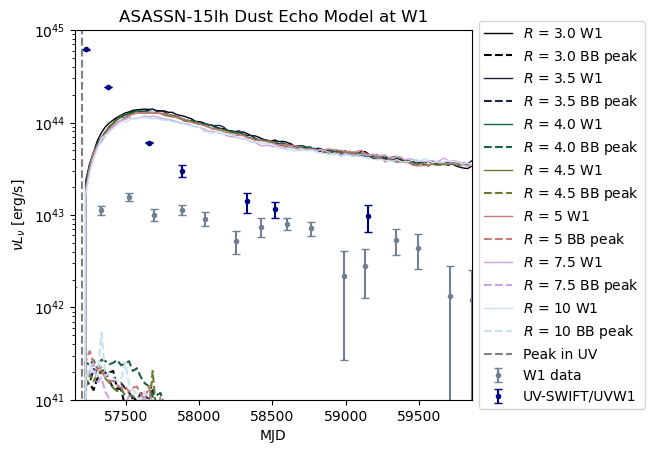

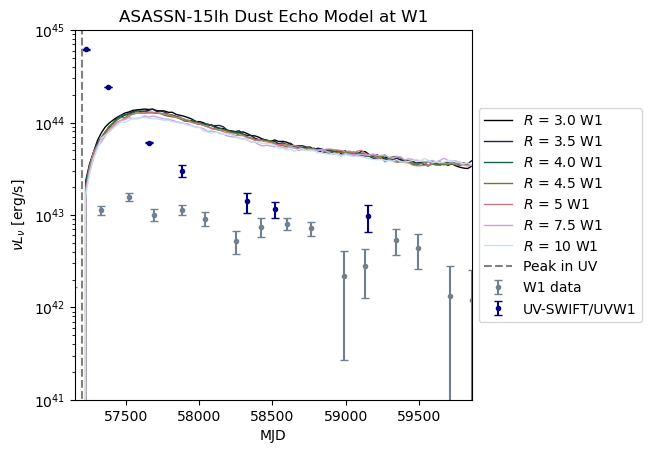

In [43]:
# Plot the lightcurve with SWIFT data and black body
fig=plt.figure()
ax=plt.subplot(111)

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/wl_w1)*luminosities[i][:,w1s[i]]).to(u.erg/u.s),label=r'$R$'+f' = {outers[i]} W1',linewidth=1,c=color)
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosities[i][:,bbwls[i]]).to(u.erg/u.s),label=r'$R$'+f' = {outers[i]} BB peak',ls='dashed',c=color)

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategray')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model at W1')
fig.savefig(PLOTFILES_+'/lightcurve_w1_bb.pdf',bbox_inches='tight')
fig.show()

# Plot the lightcurve with SWIFT data but without black body
fig=plt.figure()
ax=plt.subplot(111)

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/wl_w1)*luminosities[i][:,w1s[i]]).to(u.erg/u.s),label=r'$R$'+f' = {outers[i]} W1',linewidth=1,c=color)

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategray')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model at W1')
fig.savefig(PLOTFILES_+'/lightcurve_w1.pdf',bbox_inches='tight')
fig.show()

#### For W2

25/04/2024 13:14:49.419 ! /var/tmp/lankhorst/ipykernel_1780612/131881639.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
25/04/2024 13:14:49.419 !   fig.show()
25/04/2024 13:14:49.854 ! /var/tmp/lankhorst/ipykernel_1780612/131881639.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
25/04/2024 13:14:49.854 !   fig.show()


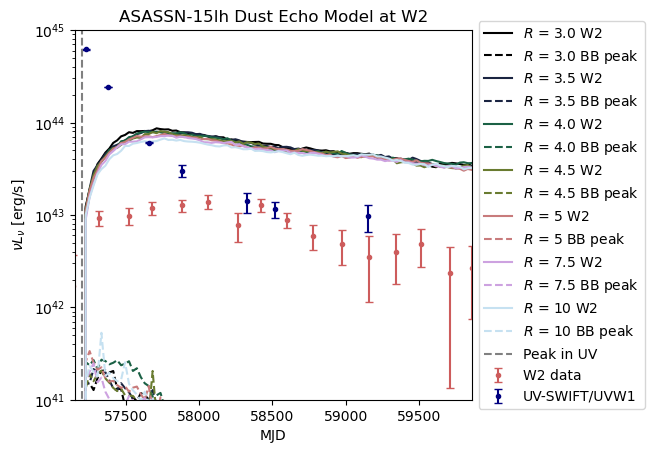

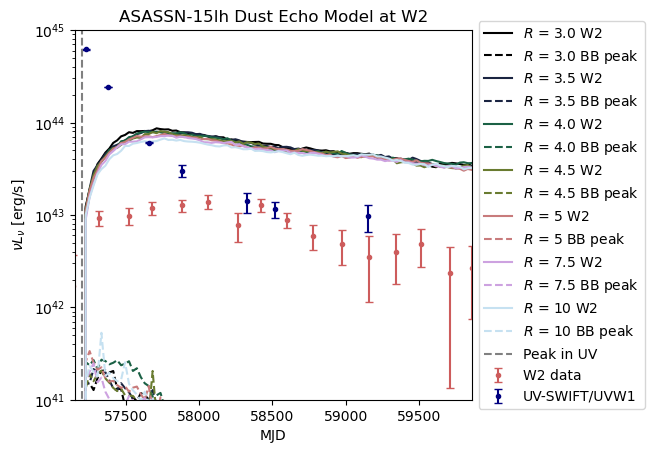

In [57]:
# Plot the lightcurve with SWIFT data and black body
fig=plt.figure()
ax=plt.subplot(111)

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/wl_w2)*luminosities[i][:,w2s[i]]).to(u.erg/u.s),label=r'$R$'+f' = {outers[i]} W2',color=color)
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosities[i][:,bbwls[i]]).to(u.erg/u.s),label=r'$R$'+f' = {outers[i]} BB peak',ls='dashed',color=color)

#Plotting data
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model at W2')
fig.savefig(PLOTFILES_+'/lightcurve_w2_bb.pdf',bbox_inches='tight')
fig.show()

# Plot the lightcurve with SWIFT data but without black body
fig=plt.figure()
ax=plt.subplot(111)

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/wl_w2)*luminosities[i][:,w2s[i]]).to(u.erg/u.s),label=r'$R$'+f' = {outers[i]} W2',color=color)
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosities[i][:,bbwls[i]]).to(u.erg/u.s),label=r'$R$'+f' = {outers[i]} BB peak',ls='dashed',color=color)

#Plotting data
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model at W2')
fig.savefig(PLOTFILES_+'/lightcurve_w2.pdf',bbox_inches='tight')
fig.show()

#### For black body peak wavelength

25/04/2024 13:08:27.375 ! /var/tmp/lankhorst/ipykernel_1780612/747168264.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
25/04/2024 13:08:27.375 !   fig.show()


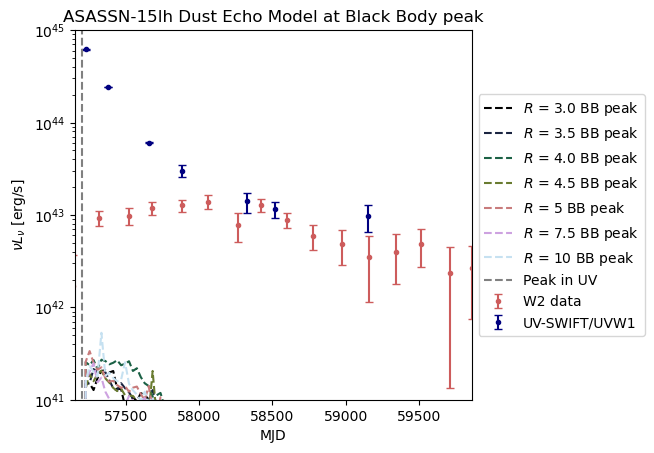

In [45]:
# Plot the lightcurve with SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosities[i][:,bbwls[i]]).to(u.erg/u.s),label=r'$R$'+f' = {outers[i]} BB peak',color=color,ls='dashed')

#Plotting data
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model at Black Body peak')
fig.savefig(PLOTFILES_+'/lightcurve_bb.pdf',bbox_inches='tight')
fig.show()

### Making the spectra

#### For dates closest to Wise datapoints

25/04/2024 13:13:52.484 ! /var/tmp/lankhorst/ipykernel_1780612/222964102.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
25/04/2024 13:13:52.484 !   fig.show()
25/04/2024 13:13:53.112 ! /var/tmp/lankhorst/ipykernel_1780612/222964102.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
25/04/2024 13:13:53.112 !   fig.show()
25/04/2024 13:13:53.743 ! /var/tmp/lankhorst/ipykernel_1780612/222964102.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
25/04/2024 13:13:53.743 !   fig.show()
25/04/2024 13:13:54.390 ! /var/tmp/lankhorst/ipykernel_1780612/222964102.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
25/04/2024 13:13:54.390 !   fig.show()
25/04/2024 13:13:55.075 ! /var/tmp/lankhorst/ipykernel_1780612/222964102.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
25/04/2024 13:13:55.075 !   fig.show()
25/04/2024 13:13:55.697 ! /var/tmp/

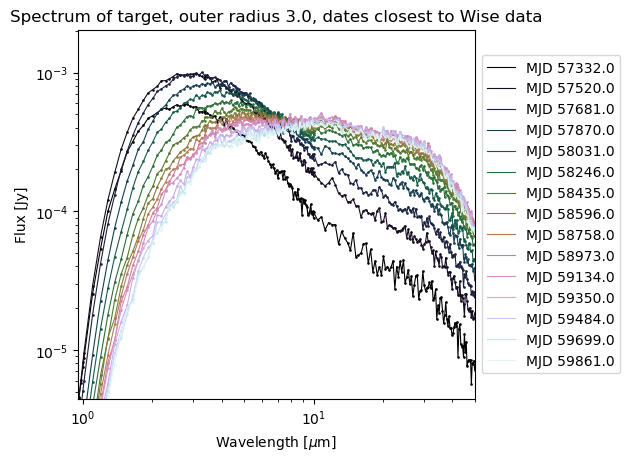

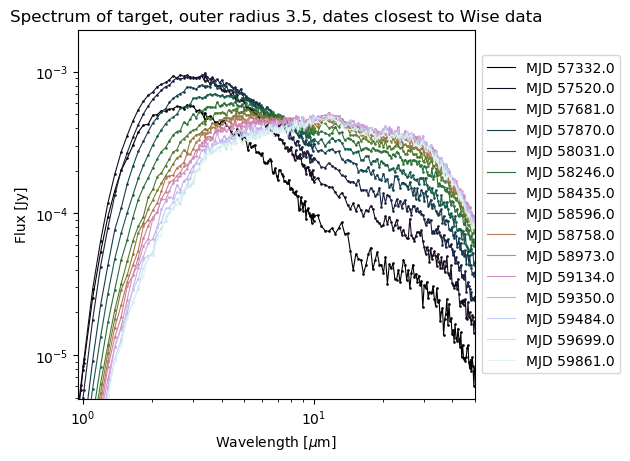

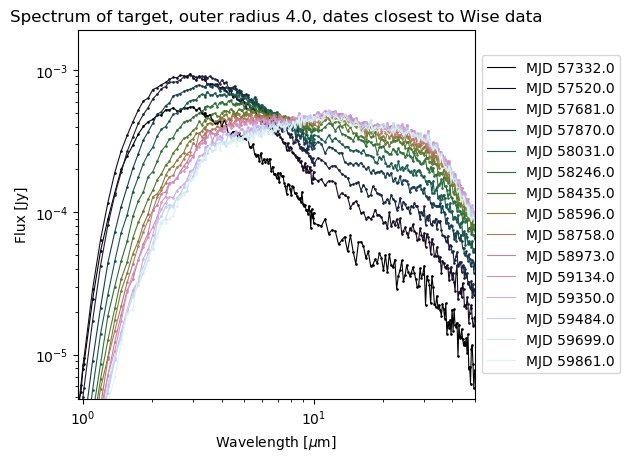

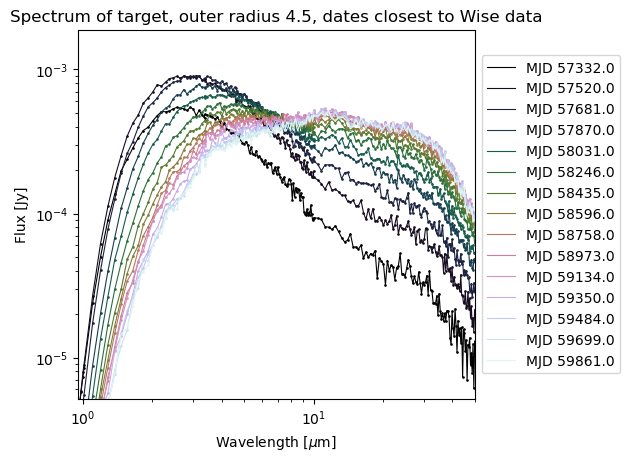

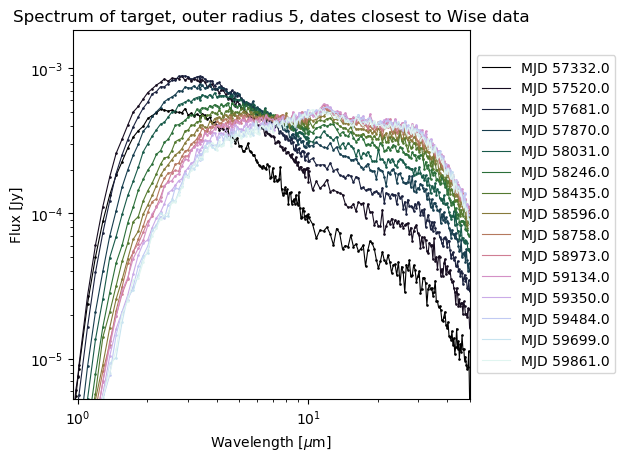

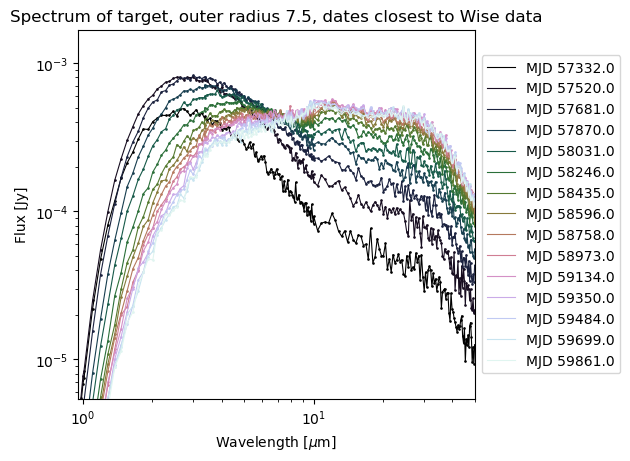

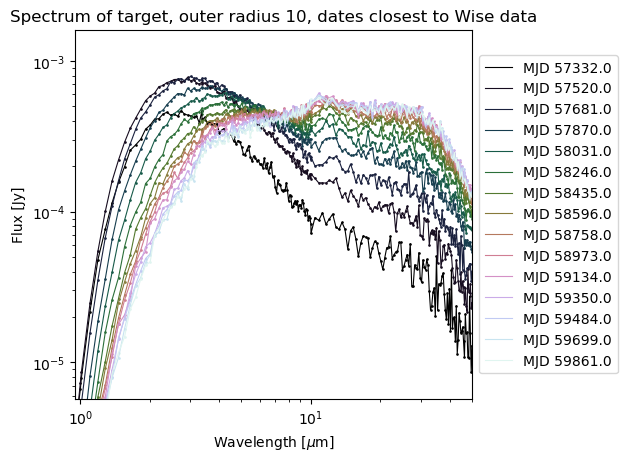

In [55]:
colours = []

w1times=[]
for i in range(len(W1[0][3:])): #Removing the first few datapoints because these occur before the smiulation started.
    w1times.append(np.argmin(np.abs(output_t-W1[0][i+3])))

cmap = plt.get_cmap('cubehelix')  # You can choose any colormap you prefer


for i in range(len(lightcurves)):
    fig=plt.figure()
    ax=plt.subplot(111)

    for t in range(len(w1times)):
        color = cmap(t / len(w1times))  # Get color from colormap
        ax.loglog(output_wavelengths, lightcurves[i][w1times[t]],label=f'MJD {round(output_t[w1times[t]],0)}',c=color,linewidth=.8)
        ax.scatter(output_wavelengths, lightcurves[i][w1times[t]],color=color,s=.8)    

    ax.set_ylabel(r'Flux [Jy]')
    ax.set_xlabel(r'Wavelength [$\mu$m]')
    ax.set_yscale('log')
    ax.set_ylim(bottom=np.max(lightcurves[i][-1].value)/1e2,top=np.max(lightcurves[i].value)*2)
    ax.set_title(f'Spectrum of target, outer radius {outers[i]}, dates closest to Wise data')
    ax.set_xlim(0.95,np.max(output_wavelengths))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    fig.savefig(PLOTFILES_l[i]+f'spectrum_Wdates_R={outers[i]}.pdf',bbox_inches='tight')
    fig.show()

25/04/2024 13:13:09.907 ! /var/tmp/lankhorst/ipykernel_1780612/3233966918.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
25/04/2024 13:13:09.907 !   fig.show()


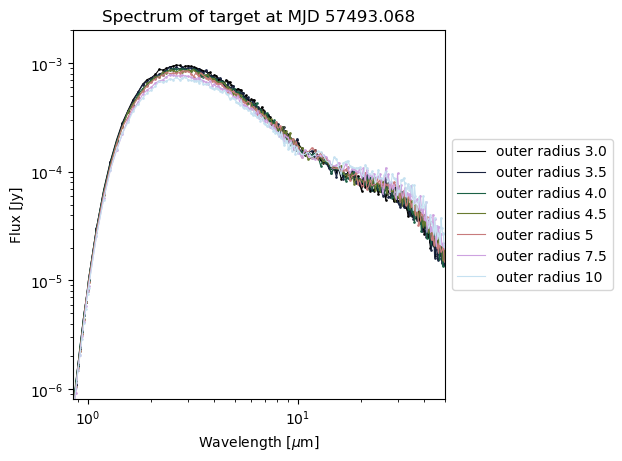

In [54]:
cmap = plt.get_cmap('cubehelix')

fig=plt.figure()
ax=plt.subplot(111)

for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.loglog(output_wavelengths, lightcurves[i][11],label=f'outer radius {outers[i]}',color=color,linewidth=.8)
    ax.scatter(output_wavelengths, lightcurves[i][11],color=color,s=.8)
#ax.axvline(bbwl,label='black body peak wavelength')
ax.set_ylabel(r'Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylim(bottom=np.max(lightcurves[-1].value)/1e3,top=np.max(lightcurves[0].value)*2)
ax.set_xlim(0.85,np.max(output_wavelengths))
ax.set_title(f'Spectrum of target at MJD {round(output_t[11],3)}')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(PLOTFILES_+'spectrum_Rs.pdf',bbox_inches='tight')
fig.show()

#### Finding how much larger wise wavelength luminosities are than that of the black body peak wavelenght

In [39]:
for i in range(len(lightcurves)):
    w1max = (np.argmax(luminosities[i][:,w1s[i]]))
    w1L = c.c/(wl_w1)*luminosities[i][:,w1s[i]][w1max]
    w2max = (np.argmax(luminosities[i][:,w2s[i]]))
    w2L = c.c/(wl_w2)*luminosities[i][:,w2s[i]][w2max]
    bbmax = np.argmax(luminosities[i][:,bbwls[i]])
    bbL = c.c/(bbwl*u.um)*luminosities[i][:,bbwls[i]][bbmax]
    print(f"For outer radius {outers[i]}:")
    print(f"Luminosity at w1 is {float(w1L/bbL)} times larger than that at the blackbody peak wavelength ")
    print(f"Luminosity at w2 is {float(w2L/bbL)} times larger than that at the blackbody peak wavelength")
    print("\n")

For outer radius 3.0:
Luminosity at w1 is 671.3658420837747 times larger than that at the blackbody peak wavelength 
Luminosity at w2 is 415.3672764099646 times larger than that at the blackbody peak wavelength


For outer radius 3.5:
Luminosity at w1 is 651.1083041862752 times larger than that at the blackbody peak wavelength 
Luminosity at w2 is 379.45371910073237 times larger than that at the blackbody peak wavelength


For outer radius 4.0:
Luminosity at w1 is 491.99759780457015 times larger than that at the blackbody peak wavelength 
Luminosity at w2 is 293.52462844630065 times larger than that at the blackbody peak wavelength


For outer radius 4.5:
Luminosity at w1 is 620.4513039940397 times larger than that at the blackbody peak wavelength 
Luminosity at w2 is 391.5470411074894 times larger than that at the blackbody peak wavelength


For outer radius 5:
Luminosity at w1 is 381.06162840043874 times larger than that at the blackbody peak wavelength 
Luminosity at w2 is 223.86786

In [40]:
print("Average temperatures in the dust for different optical depths:")
for i in range(len(temperatures)):
    print(f"For an outer radius of {outers[i]} pc, the average dust temperature is {np.average(temperatures[i])}")

Average temperatures in the dust for different optical depths:
For an outer radius of 3.0 pc, the average dust temperature is 1648.072265625
For an outer radius of 3.5 pc, the average dust temperature is 1638.427490234375
For an outer radius of 4.0 pc, the average dust temperature is 1630.2200927734375
For an outer radius of 4.5 pc, the average dust temperature is 1623.1566162109375
For an outer radius of 5 pc, the average dust temperature is 1616.8543701171875
For an outer radius of 7.5 pc, the average dust temperature is 1593.1441650390625
For an outer radius of 10 pc, the average dust temperature is 1576.9945068359375


## Changing Si fraction

In [ ]:
OUTFILES_ = OUTFILES+'ChangingSi/'
PLOTFILES_ = PLOTFILES+'ChangingSi/'

lightcurves, wavelengths, temperatures, radii, simulations = [],[],[],[],[]

normalization_type='optical_depth'
output_wavelengths = np.sort(np.concatenate((np.linspace(0.01, 1, 50), np.linspace(1.01, 10, 100), \
                                              np.linspace(10.01, 50, 100),w1w2,bbwl)))

Si_fracs = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
OUTFILES_l = []
PLOTFILES_l = []

for i in range(len(Si_fracs)):
    OUTFILES_l.append(OUTFILES_+'Si='+str(Si_fracs[i])+'/')
    PLOTFILES_l.append(PLOTFILES_+'Si='+str(Si_fracs[i])+'/')

    if os.path.isdir(OUTFILES_l[i]) == False:
        os.makedirs(OUTFILES_l[i][:-1])
    if os.path.isdir(PLOTFILES_l[i]) == False:
        os.makedirs(PLOTFILES_l[i][:-1])
    

    l,wl,T,R,sim = get_lightcurve(np.array((Lbol_data[0],Lbol_data[1] ,Lbol_data[2])), Tbol_data \
                                  ,tbol_data, output_t, np.append(output_wavelengths,relBinwidth) \
                                  ,[centralBin,outer,alpha]  \
                                  ,[[amin,amax,grainpowerlaw],[amin,amax,grainpowerlaw]], spaceBins \
                                  ,normalization_type=normalization_type \
                                  ,total_mass = total_mass, opt_depth = [opt_depth,0.28,'Z'], nsizes=15 \
                                  ,static=True, FWHM=FWHM ,distance=distance, nphotons=1e6 \
                                  ,skiname='SKI/ski_new.txt', Si=Si_fracs[i] ,prefix=str(today) \
                                  ,OUTFILES=OUTFILES_l[i], SKIRTpath='SKIRT/release/SKIRT/main/skirt')
    
    lightcurves.append(l), wavelengths.append(wl), temperatures.append(T), radii.append(R), simulations.append(sim)
    print(f"Run {i+1} of {len(Si_fracs)} finished")

Now simulating the lightcurve for a sphere with 15 dust grain sizes, optical depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

24/05/2024 12:08:49.553   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
24/05/2024 12:08:49.553   Running on student70.strw.leidenuniv.nl for lankhorst
24/05/2024 12:08:49.555   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-23_p/2236/ChangingSi/Si=0.0/7/run.ski'...
24/05/2024 12:08:56.798 - Finished setup in 7.0 s.
24/05/2024 12:08:57.570 - Finished setup output in 0.8 s.
24/05/2024 12:09:06.273 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
24/05/2024 12:09:06.273 - Finished primary emission iteration 1 in 8.7 s.
24/05/2024 12:09:17.151 - Finished primary emission in 10.9 s.
24/05/2024 12:09:24.963 - Finished secondary emission iteration 1 in 7.8 s.
24/05/2024 12:09:33.027 - Finished secondary emission iteration 2 in 8.1 s.
24/05/2024 12:09:41.178 - Finished secondary emission iteration 3 in 8.2 s.
24/05/2024 12:09:49.456 - Finished secondary emission iteration 4 in 8.3 s.
2

SKIRT Runs:  10%|███                            | 1/10 [03:01<27:13, 181.53s/it]

24/05/2024 12:11:50.852 - Finished final output in 2.0 s.
24/05/2024 12:11:50.852 * *** Error: The following error message was issued during this simulation:
24/05/2024 12:11:50.852 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/05/2024 12:11:50.852 - Finished simulation run using 6 threads and a single process in 181 s (3m 1s).
24/05/2024 12:11:50.882   Available memory: 15.4 GB -- Peak memory usage: 316 MB (2.0%)
24/05/2024 12:11:51.041   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
24/05/2024 12:11:51.041   Running on student70.strw.leidenuniv.nl for lankhorst
24/05/2024 12:11:51.042   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-23_p/2236/ChangingSi/Si=0.0/7/run.ski'...
24/05/2024 12:11:58.063 - Finished setup in 6.7 s.
24/05/2024 12:11:58.548 - Finished setup output in 0.5 s.
24/05/2024 12:12:06.474 * *** Error: Cannot destroy dust for fragmented dust mix without 

SKIRT Runs:  20%|██████▏                        | 2/10 [06:00<23:59, 179.90s/it]

24/05/2024 12:14:49.628 - Finished final output in 1.5 s.
24/05/2024 12:14:49.628 * *** Error: The following error message was issued during this simulation:
24/05/2024 12:14:49.628 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/05/2024 12:14:49.628 - Finished simulation run using 6 threads and a single process in 178 s (2m 58s).
24/05/2024 12:14:49.646   Available memory: 15.4 GB -- Peak memory usage: 316 MB (2.0%)
24/05/2024 12:14:49.798   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
24/05/2024 12:14:49.798   Running on student70.strw.leidenuniv.nl for lankhorst
24/05/2024 12:14:49.799   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-23_p/2236/ChangingSi/Si=0.0/18/run.ski'...
24/05/2024 12:14:57.006 - Finished setup in 7.0 s.
24/05/2024 12:14:58.151 - Finished setup output in 1.1 s.
24/05/2024 12:15:07.239 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  30%|█████████▎                     | 3/10 [08:47<20:20, 174.29s/it]

24/05/2024 12:17:37.173 - Finished final output in 1.4 s.
24/05/2024 12:17:37.173 * *** Error: The following error message was issued during this simulation:
24/05/2024 12:17:37.173 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/05/2024 12:17:37.173 - Finished simulation run using 6 threads and a single process in 167 s (2m 47s).
24/05/2024 12:17:37.214   Available memory: 15.4 GB -- Peak memory usage: 316 MB (2.0%)
24/05/2024 12:17:37.447   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
24/05/2024 12:17:37.447   Running on student70.strw.leidenuniv.nl for lankhorst
24/05/2024 12:17:37.448   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-23_p/2236/ChangingSi/Si=0.0/36/run.ski'...
24/05/2024 12:17:44.444 - Finished setup in 6.7 s.
24/05/2024 12:17:45.080 - Finished setup output in 0.6 s.
24/05/2024 12:17:53.016 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  40%|████████████▍                  | 4/10 [11:19<16:31, 165.18s/it]

24/05/2024 12:20:08.460 - Finished final output in 2.0 s.
24/05/2024 12:20:08.460 * *** Error: The following error message was issued during this simulation:
24/05/2024 12:20:08.460 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/05/2024 12:20:08.460 - Finished simulation run using 6 threads and a single process in 151 s (2m 31s).
24/05/2024 12:20:08.471   Available memory: 15.4 GB -- Peak memory usage: 316 MB (2.0%)
24/05/2024 12:20:08.614   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
24/05/2024 12:20:08.614   Running on student70.strw.leidenuniv.nl for lankhorst
24/05/2024 12:20:08.616   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-23_p/2236/ChangingSi/Si=0.0/189/run.ski'...
24/05/2024 12:20:15.636 - Finished setup in 6.8 s.
24/05/2024 12:20:16.183 - Finished setup output in 0.5 s.
24/05/2024 12:20:25.082 * *** Error: Cannot destroy dust for fragmented dust mix witho

SKIRT Runs:  50%|███████████████▌               | 5/10 [13:36<12:55, 155.01s/it]

24/05/2024 12:22:25.456 - Finished final output in 1.6 s.
24/05/2024 12:22:25.456 * *** Error: The following error message was issued during this simulation:
24/05/2024 12:22:25.456 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/05/2024 12:22:25.456 - Finished simulation run using 6 threads and a single process in 137 s (2m 17s).
24/05/2024 12:22:25.465   Available memory: 15.4 GB -- Peak memory usage: 316 MB (2.0%)
24/05/2024 12:22:25.646   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
24/05/2024 12:22:25.646   Running on student70.strw.leidenuniv.nl for lankhorst
24/05/2024 12:22:25.647   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-23_p/2236/ChangingSi/Si=0.0/468/run.ski'...
24/05/2024 12:22:33.112 - Finished setup in 7.2 s.
24/05/2024 12:22:34.032 - Finished setup output in 0.9 s.
24/05/2024 12:22:42.632 * *** Error: Cannot destroy dust for fragmented dust mix witho

SKIRT Runs:  60%|██████████████████▌            | 6/10 [15:46<09:45, 146.48s/it]

24/05/2024 12:24:35.361 - Finished final output in 1.7 s.
24/05/2024 12:24:35.361 * *** Error: The following error message was issued during this simulation:
24/05/2024 12:24:35.361 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/05/2024 12:24:35.361 - Finished simulation run using 6 threads and a single process in 129 s (2m 9s).
24/05/2024 12:24:35.372   Available memory: 15.4 GB -- Peak memory usage: 316 MB (2.0%)
24/05/2024 12:24:35.533   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
24/05/2024 12:24:35.533   Running on student70.strw.leidenuniv.nl for lankhorst
24/05/2024 12:24:35.535   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-23_p/2236/ChangingSi/Si=0.0/692/run.ski'...
24/05/2024 12:24:43.063 - Finished setup in 7.3 s.
24/05/2024 12:24:43.793 - Finished setup output in 0.7 s.
24/05/2024 12:24:52.163 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  70%|█████████████████████▋         | 7/10 [17:54<07:02, 140.72s/it]

24/05/2024 12:26:44.193 - Finished final output in 1.4 s.
24/05/2024 12:26:44.193 * *** Error: The following error message was issued during this simulation:
24/05/2024 12:26:44.193 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/05/2024 12:26:44.193 - Finished simulation run using 6 threads and a single process in 128 s (2m 8s).
24/05/2024 12:26:44.225   Available memory: 15.4 GB -- Peak memory usage: 316 MB (2.0%)
24/05/2024 12:26:44.408   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
24/05/2024 12:26:44.408   Running on student70.strw.leidenuniv.nl for lankhorst
24/05/2024 12:26:44.410   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-23_p/2236/ChangingSi/Si=0.0/1135/run.ski'...
24/05/2024 12:26:51.620 - Finished setup in 7.0 s.
24/05/2024 12:26:52.241 - Finished setup output in 0.6 s.
24/05/2024 12:27:01.021 * *** Error: Cannot destroy dust for fragmented dust mix witho

SKIRT Runs:  80%|████████████████████████▊      | 8/10 [19:52<04:26, 133.39s/it]

24/05/2024 12:28:41.870 - Finished final output in 1.4 s.
24/05/2024 12:28:41.870 * *** Error: The following error message was issued during this simulation:
24/05/2024 12:28:41.870 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/05/2024 12:28:41.870 - Finished simulation run using 6 threads and a single process in 117 s (1m 57s).
24/05/2024 12:28:41.902   Available memory: 15.4 GB -- Peak memory usage: 316 MB (2.0%)
24/05/2024 12:28:42.062   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
24/05/2024 12:28:42.062   Running on student70.strw.leidenuniv.nl for lankhorst
24/05/2024 12:28:42.063   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-23_p/2236/ChangingSi/Si=0.0/1330/run.ski'...
24/05/2024 12:28:49.118 - Finished setup in 6.8 s.
24/05/2024 12:28:49.882 - Finished setup output in 0.8 s.
24/05/2024 12:28:58.554 * *** Error: Cannot destroy dust for fragmented dust mix with

SKIRT Runs:  90%|███████████████████████████▉   | 9/10 [21:50<02:08, 128.53s/it]

24/05/2024 12:30:39.755 - Finished final output in 1.4 s.
24/05/2024 12:30:39.755 * *** Error: The following error message was issued during this simulation:
24/05/2024 12:30:39.755 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/05/2024 12:30:39.755 - Finished simulation run using 6 threads and a single process in 117 s (1m 57s).
24/05/2024 12:30:39.768   Available memory: 15.4 GB -- Peak memory usage: 316 MB (2.0%)
24/05/2024 12:30:39.949   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
24/05/2024 12:30:39.949   Running on student70.strw.leidenuniv.nl for lankhorst
24/05/2024 12:30:39.950   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-23_p/2236/ChangingSi/Si=0.0/1966/run.ski'...
24/05/2024 12:30:47.050 - Finished setup in 6.8 s.
24/05/2024 12:30:47.839 - Finished setup output in 0.8 s.
24/05/2024 12:30:55.678 * *** Error: Cannot destroy dust for fragmented dust mix with

SKIRT Runs: 100%|██████████████████████████████| 10/10 [23:40<00:00, 142.06s/it]


24/05/2024 12:32:29.932 - Finished final output in 1.4 s.
24/05/2024 12:32:29.932 * *** Error: The following error message was issued during this simulation:
24/05/2024 12:32:29.932 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
24/05/2024 12:32:29.932 - Finished simulation run using 6 threads and a single process in 110 s (1m 50s).
24/05/2024 12:32:29.946   Available memory: 15.4 GB -- Peak memory usage: 316 MB (2.0%)


100%|█████████████████████████████████████████| 253/253 [00:05<00:00, 43.23it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:08, 11.54it/s]

Compile Lightcurve:   5%|█▏                     | 5/100 [00:00<00:17,  5.36it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:01<00:23,  4.03it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:01<00:29,  3.16it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:02<00:36,  2.53it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:03<00:43,  2.11it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:03<00:49,  1.80it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:04<00:57,  1.55it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:05<01:03,  1.38it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:06<01:10,  1.24it/s]

Compile Lightcu

Run 1 of 11 finished
Now simulating the lightcurve for a sphere with 15 dust grain sizes, optical depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

24/05/2024 12:36:05.581   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
24/05/2024 12:36:05.581   Running on student70.strw.leidenuniv.nl for lankhorst
24/05/2024 12:36:05.582   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-23_p/2236/ChangingSi/Si=0.1/7/run.ski'...
24/05/2024 12:36:19.624 - Finished setup in 13.8 s.
24/05/2024 12:36:20.446 - Finished setup output in 0.8 s.


In [ ]:
w1s = []
w2s = []
bbwls = []
luminosities = []

for i in range(len(lightcurves)):
    # Indices corresponding to the WISE filter and black body peak wavelengths
    w1s.append(np.argmin(np.abs(wavelengths[i]-wl_w1.value)))
    w2s.append(np.argmin(np.abs(wavelengths[i]-wl_w2.value)))
    bbwls.append(np.argmin(np.abs(wavelengths[i]-bbwl)))

    # Convert the lightcurve to luminosity
    luminosities.append(FluxtoLum(lightcurves[i],distance=distance))
    
    log_=open(OUTFILES_l[i]+'log.txt','a')

    # Save the data
    log_.write('amax='+str(amax)+', grainpowerlaw='+str(grainpowerlaw)+', sublimation radius='+str(np.min(radii[i]))+',opt_depth='+str(25)+', T_min='+np.array2string(np.array(temperatures[i]),max_line_width=len(temperatures[i])*100))
    log_.write('\n')
    if os.path.isdir(OUTFILES_l[i]+'GridSearch/')==False:
        os.makedirs(OUTFILES_l[i]+'GridSearch/')
    if os.path.isdir(PLOTFILES_l[i]+'/')==False:
        os.makedirs(PLOTFILES_l[i]+'/')

    np.savetxt(OUTFILES_l[i]+'luminosity_data.txt',luminosities[i].value)

### Making the lightcurves

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
cmap = thesis_cmap
cover=False
# Normalize the radius values for the color mapping
norm = Normalize(vmin=min(Si_fracs), vmax=max(Si_fracs))

for i in range(len(Si_fracs)):
    color = cmap(norm(Si_fracs[i]))  # Use normalized radius value to get color
    ax1.plot(output_t, ((c.c / wl_w1) * luminosities[i][:, w1s[i]]).to(u.erg / u.s), color=color, label=f'Si fraction = {Si_fracs[i]}')
    ax2.plot(output_t, ((c.c / wl_w2) * luminosities[i][:, w2s[i]]).to(u.erg / u.s), color=color)

# Set common y-axis scale
ax1.set_yscale('log')
ax1.set_ylim(bottom=1e41, top=5e44)

# Set x-axis labels
ax1.set_xlabel('Days since UV peak')
ax2.set_xlabel('Days since UV peak')

# Set y-axis label
ax1.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')

# Set titles
ax1.set_title('W1 Light Curves')
ax2.set_title('W2 Light Curves')

# Create ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You can pass an empty array to set_array

# Add colorbar to the figure
cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation='vertical')
tick_values = Si_fracs
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values], fontsize=11)
cbar.set_label('Si fraction', fontsize=11)

# Set the main title
fig.suptitle(target + r' Dust Echo model for different silicate fractions', x=.43)

# Save and show the figure
if cover:
    fig.savefig(PLOTFILES + f'/lightcurve_cov_SWIFT_changingSiW1W2.pdf')
else:
    fig.savefig(PLOTFILES + f'/lightcurve_SWIFT_changingSi_W1W2.pdf')

plt.show()

#### For W1

23/05/2024 12:48:56.855 ! /var/tmp/lankhorst/ipykernel_10510/2222969040.py:19: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
23/05/2024 12:48:56.855 !   ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
23/05/2024 12:48:57.271 ! /var/tmp/lankhorst/ipykernel_10510/2222969040.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
23/05/2024 12:48:57.271 !   fig.show()
23/05/2024 12:48:57.302 ! /var/tmp/lankhorst/ipykernel_10510/2222969040.py:47: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
23/05/2024 12:48:57.302 !   ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
23/05/2024 12:48:57.793 ! /var/tmp/lankhorst/ipykernel_10510/2222969040.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
23/05/2024 12:48:57.793 !   fig.show()


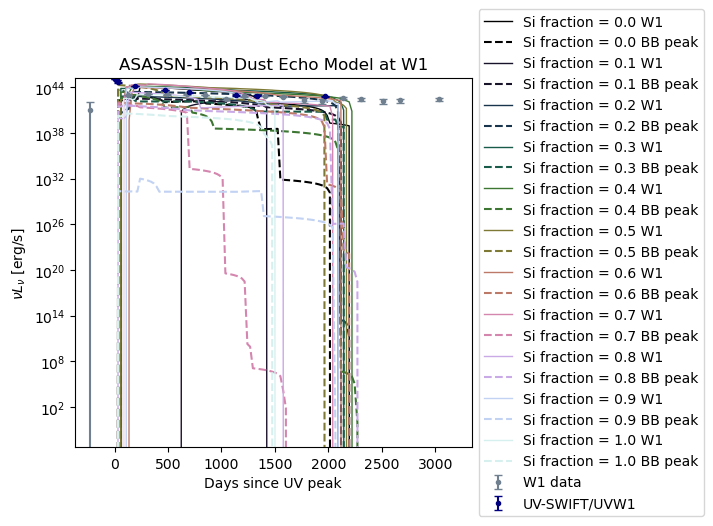

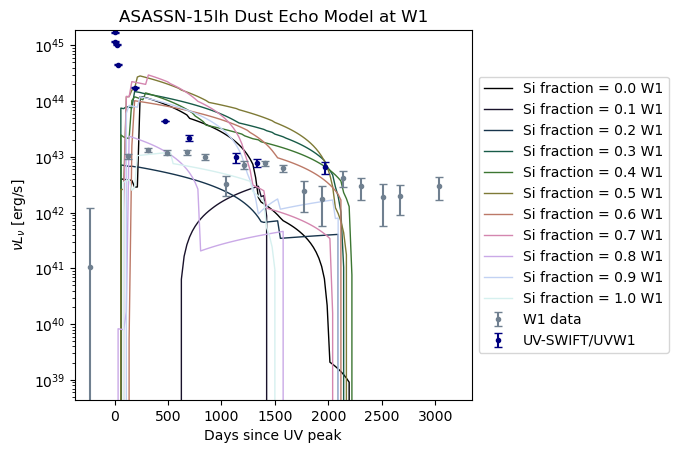

In [37]:
# Plot the lightcurve with SWIFT data and black body
fig=plt.figure()
ax=plt.subplot(111)

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/wl_w1)*luminosities[i][:,w1s[i]]).to(u.erg/u.s),label=r'Si fraction'+f' = {Si_fracs[i]} W1',linewidth=1,c=color)
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosities[i][:,bbwls[i]]).to(u.erg/u.s),label=r'Si fraction'+f' = {Si_fracs[i]} BB peak',ls='dashed',c=color)

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategray')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model at W1')
fig.savefig(PLOTFILES_+'/lightcurve_w1_bb.pdf',bbox_inches='tight')
fig.show()

# Plot the lightcurve with SWIFT data but without black body
fig=plt.figure()
ax=plt.subplot(111)

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/wl_w1)*luminosities[i][:,w1s[i]]).to(u.erg/u.s),label=r'Si fraction'+f' = {Si_fracs[i]} W1',linewidth=1,c=color)

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategray')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model at W1')
fig.savefig(PLOTFILES_+'/lightcurve_w1.pdf',bbox_inches='tight')
fig.show()

#### For W2

23/05/2024 12:49:45.132 ! /var/tmp/lankhorst/ipykernel_10510/3854957877.py:19: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
23/05/2024 12:49:45.132 !   ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
23/05/2024 12:49:45.536 ! /var/tmp/lankhorst/ipykernel_10510/3854957877.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
23/05/2024 12:49:45.536 !   fig.show()
23/05/2024 12:49:45.583 ! /var/tmp/lankhorst/ipykernel_10510/3854957877.py:48: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
23/05/2024 12:49:45.583 !   ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
23/05/2024 12:49:45.973 ! /var/tmp/lankhorst/ipykernel_10510/3854957877.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
23/05/2024 12:49:45.973 !   fig.show()


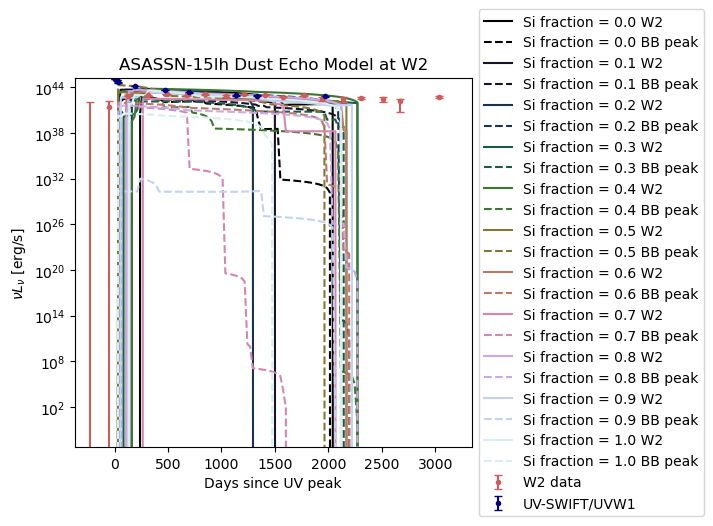

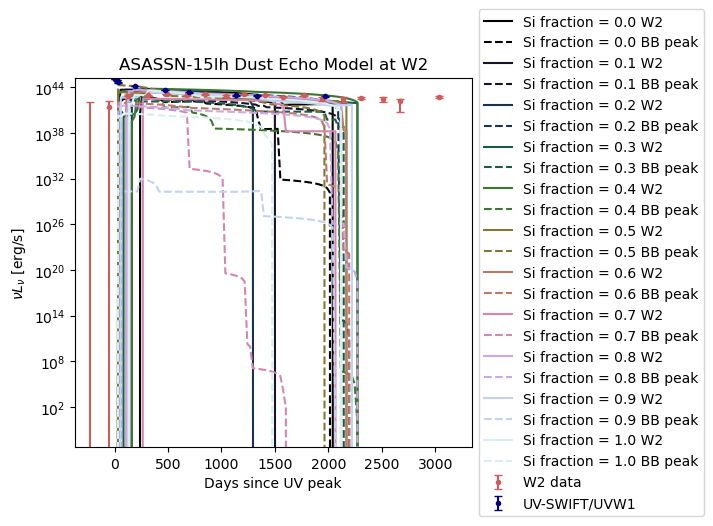

In [39]:
# Plot the lightcurve with SWIFT data and black body
fig=plt.figure()
ax=plt.subplot(111)

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/wl_w2)*luminosities[i][:,w2s[i]]).to(u.erg/u.s),label=r'Si fraction'+f' = {Si_fracs[i]} W2',color=color)
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosities[i][:,bbwls[i]]).to(u.erg/u.s),label=r'Si fraction'+f' = {Si_fracs[i]} BB peak',ls='dashed',color=color)

#Plotting data
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model at W2')
fig.savefig(PLOTFILES_+'/lightcurve_w2_bb.pdf',bbox_inches='tight')
fig.show()

# Plot the lightcurve with SWIFT data but without black body
fig=plt.figure()
ax=plt.subplot(111)

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/wl_w2)*luminosities[i][:,w2s[i]]).to(u.erg/u.s),label=r'Si fraction'+f' = {Si_fracs[i]} W2',color=color)
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosities[i][:,bbwls[i]]).to(u.erg/u.s),label=r'Si fraction'+f' = {Si_fracs[i]} BB peak',ls='dashed',color=color)

#Plotting data
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model at W2')
fig.savefig(PLOTFILES_+'/lightcurve_w2.pdf',bbox_inches='tight')
fig.show()

#### For black body peak wavelength

23/05/2024 12:50:00.191 ! /var/tmp/lankhorst/ipykernel_10510/4162724521.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
23/05/2024 12:50:00.191 !   ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
23/05/2024 12:50:00.534 ! /var/tmp/lankhorst/ipykernel_10510/4162724521.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
23/05/2024 12:50:00.534 !   fig.show()


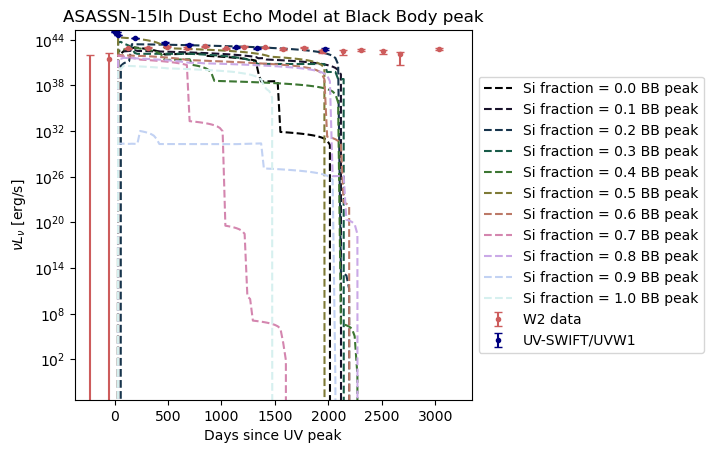

In [41]:
# Plot the lightcurve with SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

cmap = plt.get_cmap('cubehelix')

#Plotting the lightcurves
for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosities[i][:,bbwls[i]]).to(u.erg/u.s),label=r'Si fraction'+f' = {Si_fracs[i]} BB peak',color=color,ls='dashed')

#Plotting data
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model at Black Body peak')
fig.savefig(PLOTFILES_+'/lightcurve_bb.pdf',bbox_inches='tight')
fig.show()

### Making the spectra

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 6))
cmap = thesis_cmap

# Normalize the radius values for the color mapping
norm = Normalize(vmin=min(Si_fracs), vmax=max(Si_fracs))

w1times = []
for i in range(len(W1[0][3:])):  # Removing the first few datapoints because these occur before the simulation started.
    w1times.append(np.argmin(np.abs(output_t - W1[0][i + 3])))

for i in range(len(Si_fracs)):
    color = cmap(norm(Si_fracs[i]))  # Use normalized radius value to get color

    ax1.loglog(output_wavelengths, luminosities[i][30], label=f'Silicate fraction: {Si_fracs[i]}', c=color, linewidth=.8)
    ax1.scatter(output_wavelengths, luminosities[i][30], color=color, s=.8)

# Set common y-axis 
ax1.set_yscale('log')
ax1.set_ylim(bottom=1e26, top=1e31)
ax1.set_xlim(0.1)
# Set x-axis labels
ax1.set_xlabel(r'Wavelength [$\mu$m]')

# Set y-axis label
ax1.set_ylabel(r'$L_{\nu}$ [erg/s/Hz]')

# Set titles
ax1.set_title('W1 Light Curves')

# Create ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You can pass an empty array to set_array

# Add colorbar to the figure
cbar = fig.colorbar(sm, ax=ax1, orientation='vertical')
tick_values = Si_fracs
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values], fontsize=11)
cbar.set_label('Silicate fraction', fontsize=11)

# Set the main title
fig.suptitle(target + r' Dust Echo model for different silicate fractions', x=.43)

# Save and show the figure
fig.savefig(PLOTFILES_ + f'/spectrum_SWIFT_changingSi.pdf')

plt.show()

In [ ]:
from scipy.signal import savgol_filter

# Assuming 'thesis_cmap', 'Si_fracs', 'W1', 'output_t', 'output_wavelengths', 'luminosities', 'target', 'PLOTFILES', and 'cover' are predefined

fig, ax1 = plt.subplots(1, 1, figsize=(7, 6))
cmap = thesis_cmap

# Normalize the radius values for the color mapping
norm = Normalize(vmin=min(Si_fracs), vmax=max(Si_fracs))

w1times = []
for i in range(len(W1[0][3:])):  # Removing the first few datapoints because these occur before the simulation started.
    w1times.append(np.argmin(np.abs(output_t - W1[0][i + 3])))

# Apply Savitzky-Golay filter to smooth the luminosities data
smoothed_luminosities = []
for i in range(len(Si_fracs)):
    smoothed_luminosity = savgol_filter(luminosities[i][30], window_length=30, polyorder=2)
    smoothed_luminosities.append(smoothed_luminosity)

for i in range(len(Si_fracs)):
    color = cmap(norm(Si_fracs[i]))  # Use normalized radius value to get color

    ax1.loglog(output_wavelengths, smoothed_luminosities[i], label=f'Silicate fraction: {Si_fracs[i]}', c=color,linewidth=0.8)
    ax1.scatter(output_wavelengths, smoothed_luminosities[i], color=color, s=.8)

# Set common y-axis scale
ax1.set_yscale('log')
ax1.set_ylim(bottom=1e26, top=1e31)
ax1.set_xlim(0.1)

# Set x-axis labels
ax1.set_xlabel(r'Wavelength [$\mu$m]')

# Set y-axis label
ax1.set_ylabel(r'$L_{\nu}$ [erg/s/Hz]')

# Set titles
ax1.set_title(' Dust Echo model spectrum for different silicate fractions')

# Create ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You can pass an empty array to set_array

# Add colorbar to the figure
cbar = fig.colorbar(sm, ax=ax1, orientation='vertical')
tick_values = Si_fracs
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values], fontsize=11)
cbar.set_label('Silicate fraction', fontsize=11)

# Save and show the figure
fig.savefig(PLOTFILES_ + f'/spectrum_SWIFT_changingSi_SMOOTHED.pdf')

plt.show()

#### For dates closest to Wise datapoints

In [ ]:
colours = []

w1times=[]
for i in range(len(W1[0][3:])): #Removing the first few datapoints because these occur before the smiulation started.
    w1times.append(np.argmin(np.abs(output_t-W1[0][i+3])))

cmap = plt.get_cmap('cubehelix')  # You can choose any colormap you prefer


for i in range(len(lightcurves)):
    fig=plt.figure()
    ax=plt.subplot(111)

    for t in range(len(w1times)):
        color = cmap(t / len(w1times))  # Get color from colormap
        ax.loglog(output_wavelengths, lightcurves[i][w1times[t]],label=f'MJD {round(output_t[w1times[t]],0)}',c=color,linewidth=.8)
        ax.scatter(output_wavelengths, lightcurves[i][w1times[t]],color=color,s=.8)    

    ax.set_ylabel(r'Flux [Jy]')
    ax.set_xlabel(r'Wavelength [$\mu$m]')
    ax.set_yscale('log')
    ax.set_ylim(bottom=np.max(lightcurves[i][-1].value)/1e2,top=np.max(lightcurves[i].value)*2)
    ax.set_title(f'Spectrum of target, outer radius {outers[i]}, dates closest to Wise data')
    ax.set_xlim(0.95,np.max(output_wavelengths))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    fig.savefig(PLOTFILES_l[i]+f'spectrum_Wdates_R={outers[i]}.pdf',bbox_inches='tight')
    fig.show()

In [ ]:
cmap = plt.get_cmap('cubehelix')

fig=plt.figure()
ax=plt.subplot(111)

for i in range(len(lightcurves)):
    color = cmap(i/len(lightcurves)) #Get the color from the colormap
    ax.loglog(output_wavelengths, lightcurves[i][11],label=f'outer radius {outers[i]}',color=color,linewidth=.8)
    ax.scatter(output_wavelengths, lightcurves[i][11],color=color,s=.8)
#ax.axvline(bbwl,label='black body peak wavelength')
ax.set_ylabel(r'Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylim(bottom=np.max(lightcurves[-1].value)/1e3,top=np.max(lightcurves[0].value)*2)
ax.set_xlim(0.85,np.max(output_wavelengths))
ax.set_title(f'Spectrum of target at MJD {round(output_t[11],3)}')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(PLOTFILES_+'spectrum_Rs.pdf',bbox_inches='tight')
fig.show()

#### Finding how much larger wise wavelength luminosities are than that of the black body peak wavelenght

In [ ]:
for i in range(len(lightcurves)):
    w1max = (np.argmax(luminosities[i][:,w1s[i]]))
    w1L = c.c/(wl_w1)*luminosities[i][:,w1s[i]][w1max]
    w2max = (np.argmax(luminosities[i][:,w2s[i]]))
    w2L = c.c/(wl_w2)*luminosities[i][:,w2s[i]][w2max]
    bbmax = np.argmax(luminosities[i][:,bbwls[i]])
    bbL = c.c/(bbwl*u.um)*luminosities[i][:,bbwls[i]][bbmax]
    print(f"For outer radius {outers[i]}:")
    print(f"Luminosity at w1 is {float(w1L/bbL)} times larger than that at the blackbody peak wavelength ")
    print(f"Luminosity at w2 is {float(w2L/bbL)} times larger than that at the blackbody peak wavelength")
    print("\n")

In [ ]:
print("Average temperatures in the dust for different optical depths:")
for i in range(len(temperatures)):
    print(f"For an outer radius of {outers[i]} pc, the average dust temperature is {np.average(temperatures[i])}")

# Temperatures

In [116]:
def TfromL(Lbol,radius,Lbol_error=0):
    """
    Lbol: Bolometric luminosity in erg/s
    radius: radius in pc
    Lbol_error: error in bolometric luminosity; 0 by default
    Returns the temperature in Kelvin
    """
    radius = radius*u.pc
    Lbol = Lbol*u.erg/u.s
    T = ((Lbol/(4*np.pi*radius**2 * c.sigma_sb))**(1/4)).to(u.K)
    if Lbol_error != 0:
        Lbol_error = Lbol_error*u.erg/u.s
        T_error = (Lbol_error/(4*Lbol**(0.75)) / (4*np.pi*radius**2 *c.sigma_sb)**(1/4)).to(u.K)
        return T.value, T_error.value
    else:
        return T.value
#Lbol and error from: https://pubmed.ncbi.nlm.nih.gov/26816375/
print("Temperature (K) from bolometric luminosity: ", TfromL(2.2*1e45,0.11,0.2*1e45)[0], "±", TfromL(2.2*1e45,0.11,0.2*1e45)[1])
print("Temperature (K) from peak in SWIFT data: ", TfromL(light[0],0.11))

ratio = TfromL(2.2*1e45,0.11,0.2*1e45)[0] / TfromL(light[0],0.11)
print("Ratio between these temperatures: ", ratio)

Temperature (K) from bolometric luminosity:  2275.2475471784264 ± 51.7101715267824
Temperature (K) from peak in SWIFT data:  2241.1205890687133
Ratio between these temperatures:  1.0152276313359356


#### Fitting a black body to find the effective temperature of the dust (unfinished)

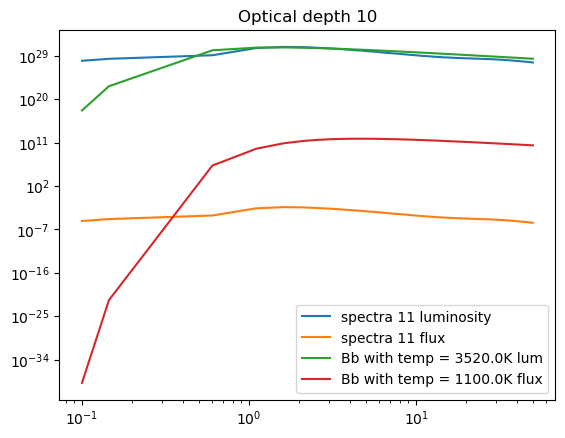

Optical depth = 10
Average temperature = 2406.127660011197K
Average scale factor = 4.224344693806353e-12


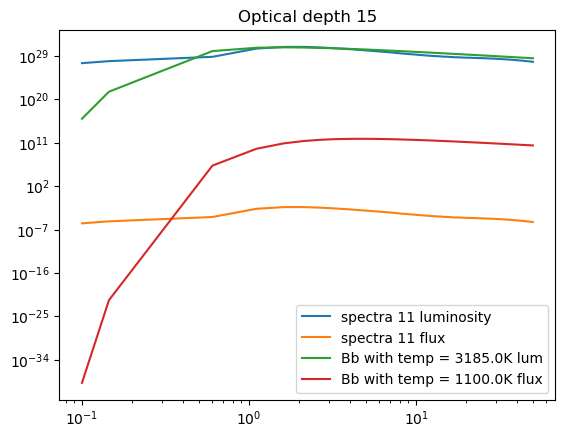

Optical depth = 15
Average temperature = 2223.244735684149K
Average scale factor = 5.952824877442719e-12


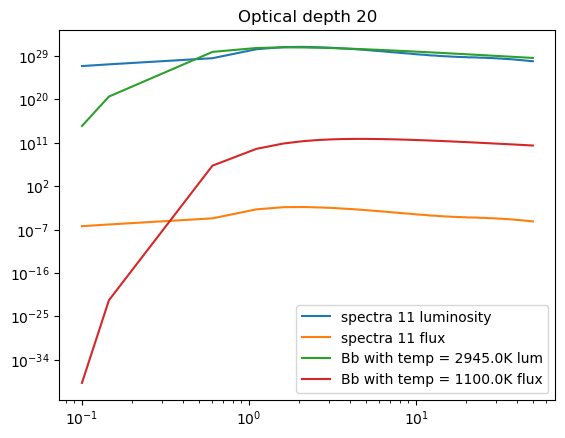

KeyboardInterrupt: 

In [150]:
from scipy.optimize import curve_fit

wl_w1 = 3.368 * u.um
wl_w2 = 4.618 * u.um

def bb_fit(wave,T ,A):
    """
    fit: fitting the parameters
    wave : wavelengths input 
    T: Temperature 
    A: Normalisation constant
    """
    
    T = T * u.K
    nu = (c.c/(wave * u.um)).to(u.Hz)
    h = (c.h).to(u.erg * u.s)
    k_b = c.k_B.to(u.erg / u.K)
        
    #intensity =  ( 2 * h / ((c.c).to(u.cm/u.s) ** 2)).value * (nu**3).value / (np.exp ( h * nu / (k_b * T)) - 1)
    intensity = A  * (nu**3).value / (np.exp ( h * nu / (k_b * T)) - 1)
    return intensity
#T = np.linspace(0, 3000, 3000)
#A = np.linspace(0, 1e20, 1000)
#fit = ( T , A ) 
#print(len(wavelengths))
#print(( 2 * (c.h).to(u.erg * u.s) / ((c.c).to(u.cm/u.s) ** 2)))
T_list = []
A_list = []
for j in range(len(luminosities)):
    T_list_temp = []
    A_list_temp = []
    for i in range(len(luminosities[j][1:])):
#        popt, pcov = curve_fit(bb_fit,spectra_wavelengths, luminosities[j][i], p0 = (1100,1e-11), bounds = ((900,1e-20),(10000,12-5)))#,bounds = (1000,[10000,1e20]))
        popt, pcov = curve_fit(bb_fit,spectra_wavelengths, luminosities[j][i], p0 = (1100,1e-11), bounds = ((900,1e-20),(10000,12-5)))#,bounds = (1000,[10000,1e20]))
        T_list_temp.append(popt[0])
        A_list_temp.append(popt[1])
        if i==11:
            plt.title(f"Optical depth {opt_depths[j]}")
            plt.loglog(spectra_wavelengths,luminosities[j][i],label = f'spectra {i} luminosity')
            plt.loglog(spectra_wavelengths,lightcurves[j][i],label = f'spectra {i} flux')
            plt.loglog(spectra_wavelengths,bb_fit(spectra_wavelengths,popt[0],popt[1]),label = f'Bb with temp = {np.round(popt[0])}K lum' )
            popt, pcov = curve_fit(bb_fit,spectra_wavelengths, lightcurves[j][i], p0 = (1100,1e-11))#,bounds = (1000,[10000,1e20]))
            plt.loglog(spectra_wavelengths,bb_fit(spectra_wavelengths,popt[0],popt[1]),label = f'Bb with temp = {np.round(popt[0])}K flux' )
            plt.legend()
            plt.show()
    T_list.append(T_list_temp)
    A_list.append(A_list_temp)
    print(f"Optical depth = {opt_depths[j]}")
    print(f"Average temperature = {np.average(T_list[j])}K")
    print(f"Average scale factor = {np.average(A_list[j])}")


        #print(f"uncertainty {np.linalg.cond(pcov)}")
        #print(popt)
#print(np.diag(pcov))
print(f"Average temperature = {np.average(T_list)}K")
print(f"Average scale factor = {np.average(A_list)}")
plt.title('Spectra with a black body fit')
#plt.plot(spectra_wavelengths, lightcurves[0],label='spectra')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e27,1e31)
plt.xlim(1e-1+0.4,1e2-45)
plt.xlabel(r'Wavelength [$\mu$m]')
plt.ylabel(r'Luminosity [erg s$^{-1}$ Hz$^{-1}$]')
plt.show()




In [42]:
len(output_wavelengths)
#len(luminosities[1])

253

In [44]:
lightcurves[0]

<Quantity [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           [1.00119940e-32, 2.09665647e-12, 1.67943322e-08, ...,
            4.97999830e-07, 4.26411351e-07, 3.69065531e-07],
           [1.09527195e-32, 5.23114504e-12, 3.98248472e-08, ...,
            8.68445635e-07, 9.32168344e-07, 7.91750593e-07],
           ...,
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            1.96479890e-09, 1.34374035e-09, 1.29655949e-09],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 1.34020298e-09, 1.28310639e-09],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 1.33666561e-09, 1.26965330e-09]] Jy>

# Testing

# Comparing normalisation methods

## New

In [9]:
#Start the run
output_wavelengths = np.sort(np.concatenate((np.linspace(0.01, 1, 2), np.linspace(1.01, 10, 80), \
                                              np.linspace(10.01, 50, 100),w1w2,bbwl)))
normalization_type='optical_depth'
total_mass = 0.0463276

OUTFILES_ = OUTFILES+'comparing/'+normalization_type+'/'
PLOTFILES_ = PLOTFILES+'comparing/'+normalization_type+'/'

if os.path.isdir(OUTFILES_) == False:
    os.makedirs(OUTFILES_[:-1])
if os.path.isdir(PLOTFILES_) == False:
    os.makedirs(PLOTFILES_[:-1])
log_=open(OUTFILES_+'log.txt','a')

lightcurve_mass,wavelengths_mass,temp_mass,radius_mass,simulation_mass = get_lightcurve_test(np.array((L_data[0],L_data[1]*Lbol_factor \
                                                                         ,L_data[2]*Lbol_factor)) \
                                                               ,T_data, t_data, output_t \
                                                               ,[centralBin,outer,alpha] \
                                                               ,[amax,amin,grainpowerlaw], spaceBins \
                                                               ,normalization_type=normalization_type \
                                                               ,total_mass = total_mass, opt_depth = [10,0.28,'Z'], nsizes=1 \
                                                               ,static=static,FWHM=FWHM, output_wavelengths=np.append(output_wavelengths,relBinwidth) \
                                                               ,distance=distance,skiname='SKI/ski_testing.txt', Si=False \
                                                               ,prefix=str(today), OUTFILES=OUTFILES_, SKIRTpath='SKIRT/release/SKIRT/main/skirt',name='pepijn')

Now simulating the lightcurve for a sphere with 1 dust grain sizes, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

13/05/2024 14:48:12.625   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:48:12.625   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:48:12.626   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/optical_depth/57197/run.ski'...
13/05/2024 14:48:14.444 - Finished setup in 1.6 s.
13/05/2024 14:48:14.689 - Finished setup output in 0.2 s.
13/05/2024 14:48:14.927 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
13/05/2024 14:48:14.927 - Finished primary emission iteration 1 in 0.2 s.
13/05/2024 14:48:15.225 - Finished primary emission in 0.3 s.
13/05/2024 14:48:15.428 - Finished secondary emission iteration 1 in 0.2 s.
13/05/2024 14:48:15.633 - Finished secondary emission iteration 2 in 0.2 s.
13/05/2024 14:48:15.853 - Finished secondary emission iteration 3 in 0.2 s.
13/05/2024 14:48:16.056 - Finished secondary emission iteration 4 in

SKIRT Runs:  10%|███▏                            | 1/10 [00:07<01:11,  7.94s/it]

13/05/2024 14:48:20.428 - Finished final output in 0.7 s.
13/05/2024 14:48:20.428 * *** Error: The following error message was issued during this simulation:
13/05/2024 14:48:20.428 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
13/05/2024 14:48:20.428 - Finished simulation run using 6 threads and a single process in 7.6 s.
13/05/2024 14:48:20.432   Available memory: 15.4 GB -- Peak memory usage: 184 MB (1.2%)
13/05/2024 14:48:20.551   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:48:20.551   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:48:20.552   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/optical_depth/57197/run.ski'...
13/05/2024 14:48:22.081 - Finished setup in 1.4 s.
13/05/2024 14:48:22.340 - Finished setup output in 0.3 s.
13/05/2024 14:48:22.518 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  20%|██████▍                         | 2/10 [00:15<01:01,  7.71s/it]

13/05/2024 14:48:27.980 - Finished final output in 0.7 s.
13/05/2024 14:48:27.980 * *** Error: The following error message was issued during this simulation:
13/05/2024 14:48:27.980 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
13/05/2024 14:48:27.980 - Finished simulation run using 6 threads and a single process in 7.3 s.
13/05/2024 14:48:27.984   Available memory: 15.4 GB -- Peak memory usage: 198 MB (1.3%)
13/05/2024 14:48:28.064   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:48:28.064   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:48:28.065   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/optical_depth/57208/run.ski'...
13/05/2024 14:48:29.606 - Finished setup in 1.5 s.
13/05/2024 14:48:29.804 - Finished setup output in 0.2 s.
13/05/2024 14:48:29.971 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  30%|█████████▌                      | 3/10 [00:22<00:53,  7.59s/it]

13/05/2024 14:48:35.416 - Finished final output in 0.7 s.
13/05/2024 14:48:35.416 * *** Error: The following error message was issued during this simulation:
13/05/2024 14:48:35.416 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
13/05/2024 14:48:35.416 - Finished simulation run using 6 threads and a single process in 7.3 s.
13/05/2024 14:48:35.421   Available memory: 15.4 GB -- Peak memory usage: 202 MB (1.3%)
13/05/2024 14:48:35.547   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:48:35.547   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:48:35.548   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/optical_depth/57225/run.ski'...
13/05/2024 14:48:37.095 - Finished setup in 1.4 s.
13/05/2024 14:48:37.290 - Finished setup output in 0.2 s.
13/05/2024 14:48:37.490 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  40%|████████████▊                   | 4/10 [00:30<00:45,  7.65s/it]

13/05/2024 14:48:43.175 - Finished final output in 0.9 s.
13/05/2024 14:48:43.175 * *** Error: The following error message was issued during this simulation:
13/05/2024 14:48:43.175 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
13/05/2024 14:48:43.175 - Finished simulation run using 6 threads and a single process in 7.5 s.
13/05/2024 14:48:43.179   Available memory: 15.4 GB -- Peak memory usage: 206 MB (1.3%)
13/05/2024 14:48:43.271   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:48:43.271   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:48:43.273   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/optical_depth/57378/run.ski'...
13/05/2024 14:48:44.814 - Finished setup in 1.5 s.
13/05/2024 14:48:45.017 - Finished setup output in 0.2 s.
13/05/2024 14:48:45.215 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  50%|████████████████                | 5/10 [00:37<00:37,  7.52s/it]

13/05/2024 14:48:50.456 - Finished final output in 0.8 s.
13/05/2024 14:48:50.457 * *** Error: The following error message was issued during this simulation:
13/05/2024 14:48:50.457 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
13/05/2024 14:48:50.457 - Finished simulation run using 6 threads and a single process in 7.1 s.
13/05/2024 14:48:50.460   Available memory: 15.4 GB -- Peak memory usage: 211 MB (1.3%)
13/05/2024 14:48:50.591   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:48:50.591   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:48:50.593   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/optical_depth/57659/run.ski'...
13/05/2024 14:48:52.547 - Finished setup in 1.7 s.
13/05/2024 14:48:52.770 - Finished setup output in 0.2 s.
13/05/2024 14:48:52.985 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  60%|███████████████████▏            | 6/10 [00:45<00:30,  7.62s/it]

13/05/2024 14:48:58.267 - Finished final output in 0.7 s.
13/05/2024 14:48:58.267 * *** Error: The following error message was issued during this simulation:
13/05/2024 14:48:58.268 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
13/05/2024 14:48:58.268 - Finished simulation run using 6 threads and a single process in 7.4 s.
13/05/2024 14:48:58.273   Available memory: 15.4 GB -- Peak memory usage: 215 MB (1.4%)
13/05/2024 14:48:58.396   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:48:58.396   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:48:58.397   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/optical_depth/57881/run.ski'...
13/05/2024 14:48:59.951 - Finished setup in 1.5 s.
13/05/2024 14:49:00.156 - Finished setup output in 0.2 s.
13/05/2024 14:49:00.348 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  70%|██████████████████████▍         | 7/10 [00:52<00:22,  7.45s/it]

13/05/2024 14:49:05.296 - Finished final output in 0.7 s.
13/05/2024 14:49:05.297 * *** Error: The following error message was issued during this simulation:
13/05/2024 14:49:05.297 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
13/05/2024 14:49:05.297 - Finished simulation run using 6 threads and a single process in 6.8 s.
13/05/2024 14:49:05.300   Available memory: 15.4 GB -- Peak memory usage: 219 MB (1.4%)
13/05/2024 14:49:05.479   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:49:05.479   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:49:05.480   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/optical_depth/58324/run.ski'...
13/05/2024 14:49:06.998 - Finished setup in 1.4 s.
13/05/2024 14:49:07.251 - Finished setup output in 0.3 s.
13/05/2024 14:49:07.440 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  80%|█████████████████████████▌      | 8/10 [00:59<00:14,  7.28s/it]

13/05/2024 14:49:12.273 - Finished final output in 0.7 s.
13/05/2024 14:49:12.273 * *** Error: The following error message was issued during this simulation:
13/05/2024 14:49:12.273 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
13/05/2024 14:49:12.273 - Finished simulation run using 6 threads and a single process in 6.7 s.
13/05/2024 14:49:12.276   Available memory: 15.4 GB -- Peak memory usage: 223 MB (1.4%)
13/05/2024 14:49:12.378   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:49:12.378   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:49:12.380   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/optical_depth/58519/run.ski'...
13/05/2024 14:49:13.898 - Finished setup in 1.4 s.
13/05/2024 14:49:14.095 - Finished setup output in 0.2 s.
13/05/2024 14:49:14.268 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs:  90%|████████████████████████████▊   | 9/10 [01:06<00:07,  7.14s/it]

13/05/2024 14:49:19.076 - Finished final output in 0.7 s.
13/05/2024 14:49:19.076 * *** Error: The following error message was issued during this simulation:
13/05/2024 14:49:19.076 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
13/05/2024 14:49:19.076 - Finished simulation run using 6 threads and a single process in 6.6 s.
13/05/2024 14:49:19.082   Available memory: 15.4 GB -- Peak memory usage: 228 MB (1.4%)
13/05/2024 14:49:19.242   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:49:19.242   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:49:19.243   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/optical_depth/59155/run.ski'...
13/05/2024 14:49:20.904 - Finished setup in 1.5 s.
13/05/2024 14:49:21.411 - Finished setup output in 0.5 s.
13/05/2024 14:49:21.664 * *** Error: Cannot destroy dust for fragmented dust mix withou

SKIRT Runs: 100%|███████████████████████████████| 10/10 [01:13<00:00,  7.40s/it]


13/05/2024 14:49:26.468 - Finished final output in 0.7 s.
13/05/2024 14:49:26.468 * *** Error: The following error message was issued during this simulation:
13/05/2024 14:49:26.468 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
13/05/2024 14:49:26.468 - Finished simulation run using 6 threads and a single process in 7.0 s.
13/05/2024 14:49:26.472   Available memory: 15.4 GB -- Peak memory usage: 232 MB (1.5%)


100%|█████████████████████████████████████████| 185/185 [00:03<00:00, 48.83it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   3%|▋                      | 3/100 [00:00<00:04, 23.61it/s]

Compile Lightcurve:   6%|█▍                     | 6/100 [00:00<00:11,  8.40it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:01<00:16,  5.64it/s]

Compile Lightcurve:   9%|██                     | 9/100 [00:01<00:19,  4.71it/s]

Compile Lightcurve:  10%|██▏                   | 10/100 [00:01<00:22,  3.93it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:02<00:26,  3.33it/s]

Compile Lightcurve:  12%|██▋                   | 12/100 [00:02<00:30,  2.88it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:03<00:34,  2.54it/s]

Compile Lightcurve:  14%|███                   | 14/100 [00:03<00:37,  2.27it/s]

Compile Lightcurve:  15%|███▎                  | 15/100 [00:04<00:41,  2.07it/s]

Compile Lightcu

In [10]:
# indices corresponding to the WISE filter and black body peak wavelengths
w1=np.argmin(np.abs(wavelengths_mass-wl_w1.value))
w2=np.argmin(np.abs(wavelengths_mass-wl_w2.value))
bbwl_i = np.argmin(np.abs(wavelengths_mass-bbwl))

# Convert the lightcurve to luminosity
luminosity_mass=FluxtoLum(lightcurve_mass,distance=distance)
# Calculate the covering factor
# in this simulation a spherical dust shell is used, 
# as we expect a clumpy dust structure a covering factor is applied to account for the higher luminosity.
coveringFactor_mass=np.max(W1[1]*u.erg/u.s/u.Hz)/luminosity_mass[np.argmin(np.abs(output_t-W1[0,np.argmax(W1[1])])),w1]

# Save the data
log_.write('amax='+str(amax)+', grainpowerlaw='+str(grainpowerlaw)+', coveringFactor='+str(coveringFactor_mass)+', sublimation radius='+str(np.min(radius_mass))+', T_min='+np.array2string(np.array(temp_mass),max_line_width=len(temp_mass)*100))
log_.write('\n')
if os.path.isdir(OUTFILES_+'GridSearch/')==False:
    os.makedirs(OUTFILES_+'GridSearch/')
if os.path.isdir(PLOTFILES_+'/')==False:
    os.makedirs(PLOTFILES_+'/')

np.savetxt(OUTFILES_+'config.txt',luminosity_mass.value)

## Old Remon

In [11]:
# Start the run
output_wavelengths = np.sort(np.concatenate((np.linspace(0.01, 1, 2), np.linspace(1.01, 10, 80), \
                                              np.linspace(10.01, 50, 100),w1w2,bbwl)))
normalization_type='mass'
total_mass = .0878502
static=False

OUTFILES_ = OUTFILES+'comparing/'+normalization_type+'2'+'/'
PLOTFILES_ = PLOTFILES+'comparing/'+normalization_type+'2'+'/'

if os.path.isdir(OUTFILES_) == False:
    os.makedirs(OUTFILES_[:-1])
if os.path.isdir(PLOTFILES_) == False:
    os.makedirs(PLOTFILES_[:-1])
log_=open(OUTFILES_+'log.txt','a')

lightcurve_optd,wavelengths_optd,temp_optd,radius_optd,simulation_optd, radtest,masstest = get_lightcurve(np.array((L_data[0],L_data[1]*Lbol_factor \
                                                                         ,L_data[2]*Lbol_factor)) \
                                                               ,T_data, t_data, output_t \
                                                               ,[centralBin,outer,alpha] \
                                                               ,[amax,amin,grainpowerlaw], spaceBins \
                                                               ,normalization_type=normalization_type \
                                                               ,total_mass = total_mass, opt_depth = [10,0.28,'Z'], nlayers=1 \
                                                               ,static=static,FWHM=FWHM, output_wavelengths=np.append(output_wavelengths,relBinwidth) \
                                                               ,distance=distance,skiname='SKI/combined_ski.txt', Si=0.5 \
                                                               ,prefix=str(today), OUTFILES=OUTFILES_, SKIRTpath='SKIRT/release/SKIRT/main/skirt',name='pepijn')

Now simulating the lightcurve for a sphere with 1 layer(s) of dust, mass normalization, and with sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

13/05/2024 14:58:14.393   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:58:14.393   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:58:14.395   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/mass2/57197/run.ski'...
13/05/2024 14:58:15.100 - Finished setup in 0.5 s.
13/05/2024 14:58:15.197 - Finished setup output in 0.1 s.
13/05/2024 14:58:15.305 - Finished primary emission iteration 1 in 0.1 s.
13/05/2024 14:58:15.389 - Finished primary emission iteration 2 in 0.1 s.
13/05/2024 14:58:15.423 - Finished primary emission iteration 3 in 0.0 s.
13/05/2024 14:58:15.485 - Finished primary emission in 0.1 s.
13/05/2024 14:58:15.485 - Finished secondary emission iteration 1 in 0.0 s.
13/05/2024 14:58:15.485 - Finished secondary emission in 0.0 s.
13/05/2024 14:58:15.485 - Finished the run in 0.3 s.


SKIRT Runs:  10%|███▏                            | 1/10 [00:01<00:17,  1.95s/it]

13/05/2024 14:58:16.251 - Finished final output in 0.8 s.
13/05/2024 14:58:16.251 - Finished simulation run using 6 threads and a single process in 1.6 s.
13/05/2024 14:58:16.254   Available memory: 15.4 GB -- Peak memory usage: 257 MB (1.6%)
13/05/2024 14:58:16.348   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:58:16.348   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:58:16.349   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/mass2/57197/run.ski'...
13/05/2024 14:58:16.915 - Finished setup in 0.5 s.
13/05/2024 14:58:17.005 - Finished setup output in 0.1 s.
13/05/2024 14:58:17.021 - Finished primary emission iteration 1 in 0.0 s.
13/05/2024 14:58:17.057 - Finished primary emission in 0.0 s.
13/05/2024 14:58:17.057 - Finished secondary emission iteration 1 in 0.0 s.
13/05/2024 14:58:17.057 - Finished secondary emission in 0.0 s.
13/05/2024 14:58:17.057 - Fi

SKIRT Runs:  20%|██████▍                         | 2/10 [00:03<00:12,  1.62s/it]

13/05/2024 14:58:17.646 - Finished final output in 0.6 s.
13/05/2024 14:58:17.646 - Finished simulation run using 6 threads and a single process in 1.2 s.
13/05/2024 14:58:17.649   Available memory: 15.4 GB -- Peak memory usage: 257 MB (1.6%)
13/05/2024 14:58:17.761   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:58:17.761   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:58:17.762   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/mass2/57208/run.ski'...
13/05/2024 14:58:18.333 - Finished setup in 0.5 s.
13/05/2024 14:58:18.411 - Finished setup output in 0.1 s.
13/05/2024 14:58:18.426 - Finished primary emission iteration 1 in 0.0 s.
13/05/2024 14:58:18.465 - Finished primary emission in 0.0 s.
13/05/2024 14:58:18.465 - Finished secondary emission iteration 1 in 0.0 s.
13/05/2024 14:58:18.465 - Finished secondary emission in 0.0 s.
13/05/2024 14:58:18.465 - Fi

SKIRT Runs:  30%|█████████▌                      | 3/10 [00:04<00:10,  1.53s/it]

13/05/2024 14:58:19.067 - Finished final output in 0.6 s.
13/05/2024 14:58:19.067 - Finished simulation run using 6 threads and a single process in 1.2 s.
13/05/2024 14:58:19.070   Available memory: 15.4 GB -- Peak memory usage: 257 MB (1.6%)
13/05/2024 14:58:19.235   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:58:19.235   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:58:19.236   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/mass2/57225/run.ski'...
13/05/2024 14:58:19.823 - Finished setup in 0.5 s.
13/05/2024 14:58:19.904 - Finished setup output in 0.1 s.
13/05/2024 14:58:19.920 - Finished primary emission iteration 1 in 0.0 s.
13/05/2024 14:58:19.963 - Finished primary emission in 0.0 s.
13/05/2024 14:58:19.963 - Finished secondary emission iteration 1 in 0.0 s.
13/05/2024 14:58:19.964 - Finished secondary emission in 0.0 s.
13/05/2024 14:58:19.964 - Fi

SKIRT Runs:  40%|████████████▊                   | 4/10 [00:06<00:09,  1.53s/it]

13/05/2024 14:58:20.586 - Finished final output in 0.6 s.
13/05/2024 14:58:20.586 - Finished simulation run using 6 threads and a single process in 1.2 s.
13/05/2024 14:58:20.589   Available memory: 15.4 GB -- Peak memory usage: 257 MB (1.6%)
13/05/2024 14:58:20.676   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:58:20.676   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:58:20.677   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/mass2/57378/run.ski'...
13/05/2024 14:58:21.215 - Finished setup in 0.5 s.
13/05/2024 14:58:21.328 - Finished setup output in 0.1 s.
13/05/2024 14:58:21.349 - Finished primary emission iteration 1 in 0.0 s.
13/05/2024 14:58:21.411 - Finished primary emission in 0.1 s.
13/05/2024 14:58:21.412 - Finished secondary emission iteration 1 in 0.0 s.
13/05/2024 14:58:21.412 - Finished secondary emission in 0.0 s.
13/05/2024 14:58:21.412 - Fi

SKIRT Runs:  50%|████████████████                | 5/10 [00:07<00:07,  1.55s/it]

13/05/2024 14:58:22.141 - Finished final output in 0.7 s.
13/05/2024 14:58:22.141 - Finished simulation run using 6 threads and a single process in 1.4 s.
13/05/2024 14:58:22.147   Available memory: 15.4 GB -- Peak memory usage: 257 MB (1.6%)
13/05/2024 14:58:22.308   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:58:22.308   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:58:22.311   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/mass2/57659/run.ski'...
13/05/2024 14:58:22.907 - Finished setup in 0.5 s.
13/05/2024 14:58:23.060 - Finished setup output in 0.2 s.
13/05/2024 14:58:23.076 - Finished primary emission iteration 1 in 0.0 s.
13/05/2024 14:58:23.126 - Finished primary emission in 0.1 s.
13/05/2024 14:58:23.126 - Finished secondary emission iteration 1 in 0.0 s.
13/05/2024 14:58:23.126 - Finished secondary emission in 0.0 s.
13/05/2024 14:58:23.126 - Fi

SKIRT Runs:  60%|███████████████████▏            | 6/10 [00:09<00:06,  1.55s/it]

13/05/2024 14:58:23.742 - Finished final output in 0.6 s.
13/05/2024 14:58:23.742 - Finished simulation run using 6 threads and a single process in 1.3 s.
13/05/2024 14:58:23.745   Available memory: 15.4 GB -- Peak memory usage: 257 MB (1.6%)
13/05/2024 14:58:23.850   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:58:23.850   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:58:23.851   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/mass2/57881/run.ski'...
13/05/2024 14:58:24.413 - Finished setup in 0.5 s.
13/05/2024 14:58:24.497 - Finished setup output in 0.1 s.
13/05/2024 14:58:24.514 - Finished primary emission iteration 1 in 0.0 s.
13/05/2024 14:58:24.563 - Finished primary emission in 0.0 s.
13/05/2024 14:58:24.563 - Finished secondary emission iteration 1 in 0.0 s.
13/05/2024 14:58:24.563 - Finished secondary emission in 0.0 s.
13/05/2024 14:58:24.563 - Fi

SKIRT Runs:  70%|██████████████████████▍         | 7/10 [00:10<00:04,  1.51s/it]

13/05/2024 14:58:25.168 - Finished final output in 0.6 s.
13/05/2024 14:58:25.168 - Finished simulation run using 6 threads and a single process in 1.2 s.
13/05/2024 14:58:25.171   Available memory: 15.4 GB -- Peak memory usage: 257 MB (1.6%)
13/05/2024 14:58:25.277   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:58:25.277   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:58:25.278   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/mass2/58324/run.ski'...
13/05/2024 14:58:25.831 - Finished setup in 0.5 s.
13/05/2024 14:58:25.913 - Finished setup output in 0.1 s.
13/05/2024 14:58:25.928 - Finished primary emission iteration 1 in 0.0 s.
13/05/2024 14:58:25.961 - Finished primary emission in 0.0 s.
13/05/2024 14:58:25.961 - Finished secondary emission iteration 1 in 0.0 s.
13/05/2024 14:58:25.962 - Finished secondary emission in 0.0 s.
13/05/2024 14:58:25.962 - Fi

SKIRT Runs:  80%|█████████████████████████▌      | 8/10 [00:12<00:02,  1.49s/it]

13/05/2024 14:58:26.579 - Finished final output in 0.6 s.
13/05/2024 14:58:26.579 - Finished simulation run using 6 threads and a single process in 1.2 s.
13/05/2024 14:58:26.584   Available memory: 15.4 GB -- Peak memory usage: 257 MB (1.6%)
13/05/2024 14:58:26.718   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:58:26.718   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:58:26.719   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/mass2/58519/run.ski'...
13/05/2024 14:58:27.280 - Finished setup in 0.5 s.
13/05/2024 14:58:27.367 - Finished setup output in 0.1 s.
13/05/2024 14:58:27.429 - Finished primary emission iteration 1 in 0.1 s.
13/05/2024 14:58:27.522 - Finished primary emission in 0.1 s.
13/05/2024 14:58:27.522 - Finished secondary emission iteration 1 in 0.0 s.
13/05/2024 14:58:27.522 - Finished secondary emission in 0.0 s.
13/05/2024 14:58:27.522 - Fi

SKIRT Runs:  90%|████████████████████████████▊   | 9/10 [00:13<00:01,  1.50s/it]

13/05/2024 14:58:28.131 - Finished final output in 0.6 s.
13/05/2024 14:58:28.131 - Finished simulation run using 6 threads and a single process in 1.3 s.
13/05/2024 14:58:28.134   Available memory: 15.4 GB -- Peak memory usage: 257 MB (1.6%)
13/05/2024 14:58:28.212   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
13/05/2024 14:58:28.212   Running on student72.strw.leidenuniv.nl for lankhorst
13/05/2024 14:58:28.214   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-13_p/1448/comparing/mass2/59155/run.ski'...
13/05/2024 14:58:28.763 - Finished setup in 0.5 s.
13/05/2024 14:58:28.894 - Finished setup output in 0.1 s.
13/05/2024 14:58:28.933 - Finished primary emission iteration 1 in 0.0 s.
13/05/2024 14:58:29.040 - Finished primary emission in 0.1 s.
13/05/2024 14:58:29.040 - Finished secondary emission iteration 1 in 0.0 s.
13/05/2024 14:58:29.040 - Finished secondary emission in 0.0 s.
13/05/2024 14:58:29.040 - Fi

SKIRT Runs: 100%|███████████████████████████████| 10/10 [00:15<00:00,  1.53s/it]


13/05/2024 14:58:29.657 - Finished final output in 0.6 s.
13/05/2024 14:58:29.657 - Finished simulation run using 6 threads and a single process in 1.4 s.
13/05/2024 14:58:29.660   Available memory: 15.4 GB -- Peak memory usage: 257 MB (1.6%)


100%|█████████████████████████████████████████| 185/185 [00:03<00:00, 61.46it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   4%|▉                      | 4/100 [00:00<00:02, 36.89it/s]

Compile Lightcurve:   8%|█▊                     | 8/100 [00:00<00:06, 15.14it/s]

Compile Lightcurve:  11%|██▍                   | 11/100 [00:00<00:08, 10.08it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:01<00:10,  8.02it/s]

Compile Lightcurve:  15%|███▎                  | 15/100 [00:01<00:13,  6.50it/s]

Compile Lightcurve:  16%|███▌                  | 16/100 [00:02<00:14,  5.82it/s]

Compile Lightcurve:  17%|███▋                  | 17/100 [00:02<00:15,  5.21it/s]

Compile Lightcurve:  18%|███▉                  | 18/100 [00:02<00:17,  4.66it/s]

Compile Lightcurve:  19%|████▏                 | 19/100 [00:02<00:19,  4.22it/s]

Compile Lightcurve:  20%|████▍                 | 20/100 [00:03<00:20,  3.84it/s]

Compile Lightcu

In [12]:
#np.unique(radtest)
radtest[4]

[0.10458984375,
 0.10458984375,
 0.10458984375,
 0.1095703125,
 0.1095703125,
 0.1095703125,
 0.1095703125,
 0.1095703125,
 0.1095703125,
 0.1095703125]

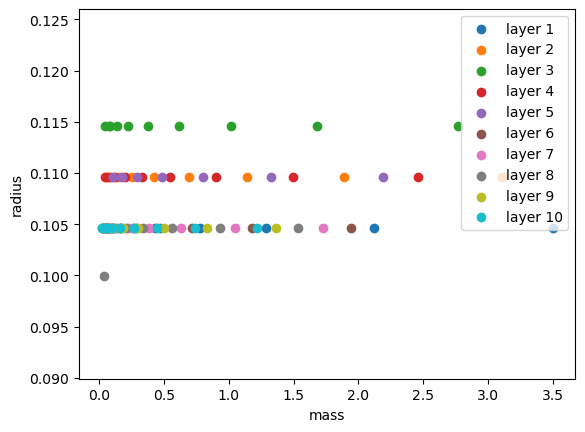

In [36]:
layer_masses = []
layer_radii = []
for i in range(len(masstest)):
    a =[]
    b = []
    for j in range(len(masstest[i])):
        a.append(masstest[i][j])
        b.append(radtest[i][j])
    layer_masses.append(a)
    layer_radii.append(b)
for i in range(len(masstest)):
#for i in range(3):
    plt.scatter(layer_masses[i],layer_radii[i],label=f'layer {i+1}')
#plt.scatter(layer_masses[0],layer_radii[0],label=f'layer {1}')
#plt.scatter(layer_masses[-1],layer_radii[-1],label=f'layer {10}')

plt.ylim(np.min(layer_radii)*0.9,np.max(layer_radii)*1.1)
plt.xlabel('mass')
plt.ylabel('radius')
plt.legend()
plt.show()

In [13]:
for i in range(len(radtest)):
    print(np.unique(radtest[i]))

[0.10458984]
[0.10957031]
[0.11455078]
[0.10458984 0.10957031]
[0.10458984 0.10957031]
[0.10458984]
[0.10458984]
[0.09990234 0.10458984]
[0.10458984]
[0.10458984]


In [12]:
# indices corresponding to the WISE filter and black body peak wavelengths
w1=np.argmin(np.abs(wavelengths_optd-wl_w1.value))
w2=np.argmin(np.abs(wavelengths_optd-wl_w2.value))
bbwl_i = np.argmin(np.abs(wavelengths_optd-bbwl))

# Convert the lightcurve to luminosity
luminosity_optd=FluxtoLum(lightcurve_optd,distance=distance)
# Calculate the covering factor
# in this simulation a spherical dust shell is used, 
# as we expect a clumpy dust structure a covering factor is applied to account for the higher luminosity.
coveringFactor_optd=np.max(W1[1]*u.erg/u.s/u.Hz)/luminosity_optd[np.argmin(np.abs(output_t-W1[0,np.argmax(W1[1])])),w1]

# Save the data
log_.write('amax='+str(amax)+', grainpowerlaw='+str(grainpowerlaw)+', coveringFactor='+str(coveringFactor_optd)+', sublimation radius='+str(np.min(radius_optd))+', T_min='+np.array2string(np.array(temp_optd),max_line_width=len(temp_optd)*100))
log_.write('\n')
if os.path.isdir(OUTFILES_+'GridSearch/')==False:
    os.makedirs(OUTFILES_+'GridSearch/')
if os.path.isdir(PLOTFILES_+'/')==False:
    os.makedirs(PLOTFILES_+'/')

np.savetxt(OUTFILES_+'config.txt',luminosity_optd.value)

## Comparing the methods

### Comparing the lightcurves

13/05/2024 17:50:21.922 ! /var/tmp/lankhorst/ipykernel_440180/926310346.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
13/05/2024 17:50:21.922 !   fig.show()
13/05/2024 17:50:22.105 ! /var/tmp/lankhorst/ipykernel_440180/926310346.py:72: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
13/05/2024 17:50:22.105 !   fig.show()


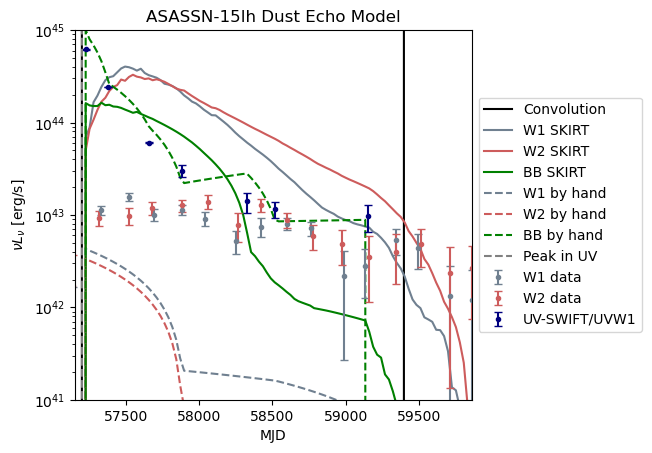

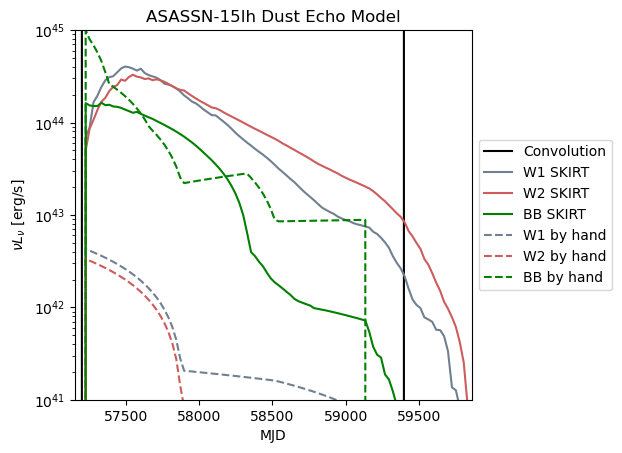

In [20]:
OUTFILES_ = OUTFILES+'comparing/'+'/'
PLOTFILES_ = PLOTFILES+'comparing/'+'/'

if os.path.isdir(OUTFILES_) == False:
    os.makedirs(OUTFILES_[:-1])
if os.path.isdir(PLOTFILES_) == False:
    os.makedirs(PLOTFILES_[:-1])

# Plot the lightcurve with SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the mass lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity_mass[:,w1]).to(u.erg/u.s),label='W1 SKIRT',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity_mass[:,w2]).to(u.erg/u.s),label='W2 SKIRT',color='indianred')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_mass[:,bbwl_i]).to(u.erg/u.s),label='BB SKIRT',color='green')

#Plotting the optical depth lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity_optd[:,w1]).to(u.erg/u.s),label='W1 by hand',color='slategrey',ls='--')
ax.plot(output_t,((c.c/wl_w2)*luminosity_optd[:,w2]).to(u.erg/u.s),label='W2 by hand',color='indianred',ls='--')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_optd[:,bbwl_i]).to(u.erg/u.s),label='BB by hand',color='green',ls='--')

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model')
fig.savefig(PLOTFILES_+'lightcurve_compare_SWIFT.pdf')
fig.show()

#Plot the lightcurve without SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the mass lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity_mass[:,w1]).to(u.erg/u.s),label='W1 SKIRT',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity_mass[:,w2]).to(u.erg/u.s),label='W2 SKIRT',color='indianred')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_mass[:,bbwl_i]).to(u.erg/u.s),label='BB SKIRT',color='green')

#Plotting the optical depth lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity_optd[:,w1]).to(u.erg/u.s),label='W1 by hand',color='slategrey',ls='--')
ax.plot(output_t,((c.c/wl_w2)*luminosity_optd[:,w2]).to(u.erg/u.s),label='W2 by hand',color='indianred',ls='--')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_optd[:,bbwl_i]).to(u.erg/u.s),label='BB by hand',color='green',ls='--')

ax.set_yscale('log')
ax.set_ylim(bottom=1e41,top=1e45)
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model')
fig.savefig(PLOTFILES_+'lightcurve_compare_noSWIFT.pdf')
fig.show()

#### Comparing for W1


13/05/2024 17:50:30.394 ! /var/tmp/lankhorst/ipykernel_440180/2941247726.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
13/05/2024 17:50:30.394 !   fig.show()
13/05/2024 17:50:30.586 ! /var/tmp/lankhorst/ipykernel_440180/2941247726.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
13/05/2024 17:50:30.586 !   fig.show()


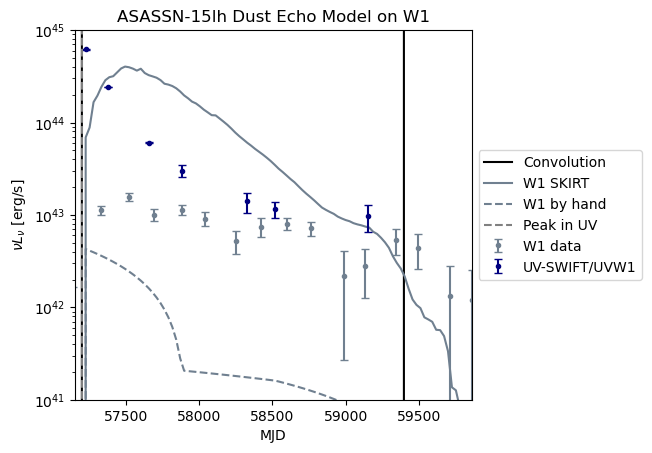

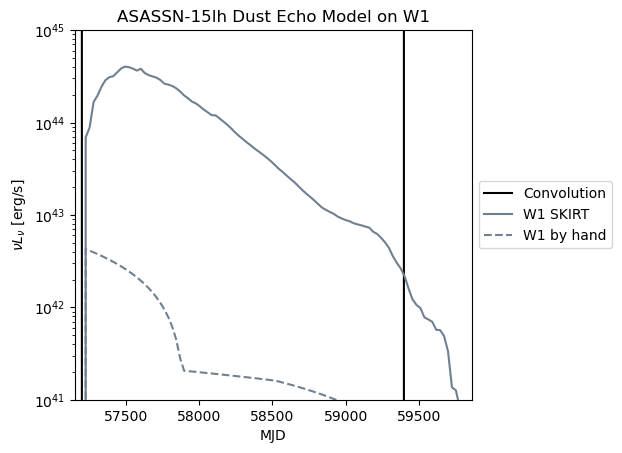

In [21]:
# Plot the lightcurve with SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the mass lightcurve
ax.plot(output_t,((c.c/wl_w1)*luminosity_mass[:,w1]).to(u.erg/u.s),label='W1 SKIRT',color='slategrey')

#Plotting the optical depth lightcurve
ax.plot(output_t,((c.c/wl_w1)*luminosity_optd[:,w1]).to(u.erg/u.s),label='W1 by hand',color='slategrey',ls='--')

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model on W1')
fig.savefig(PLOTFILES_+'lightcurve_compare_w1_SWIFT.pdf')
fig.show()

#Plot the lightcurve without SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the mass lightcurve
ax.plot(output_t,((c.c/wl_w1)*luminosity_mass[:,w1]).to(u.erg/u.s),label='W1 SKIRT',color='slategrey')

#Plotting the optical depth lightcurve
ax.plot(output_t,((c.c/wl_w1)*luminosity_optd[:,w1]).to(u.erg/u.s),label='W1 by hand',color='slategrey',ls='--')

ax.set_yscale('log')
ax.set_ylim(bottom=1e41,top=1e45)
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model on W1')
fig.savefig(PLOTFILES_+'lightcurve_compare_w1_noSWIFT.pdf')
fig.show()

#### Comparing for W2

13/05/2024 17:50:31.557 ! /var/tmp/lankhorst/ipykernel_440180/1786074792.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
13/05/2024 17:50:31.557 !   fig.show()
13/05/2024 17:50:31.728 ! /var/tmp/lankhorst/ipykernel_440180/1786074792.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
13/05/2024 17:50:31.728 !   fig.show()


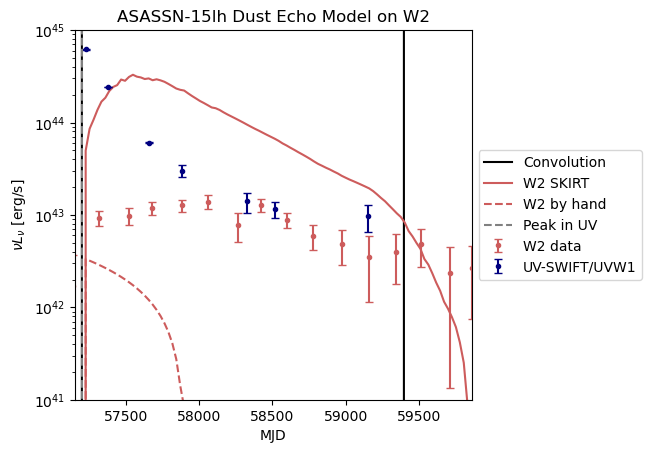

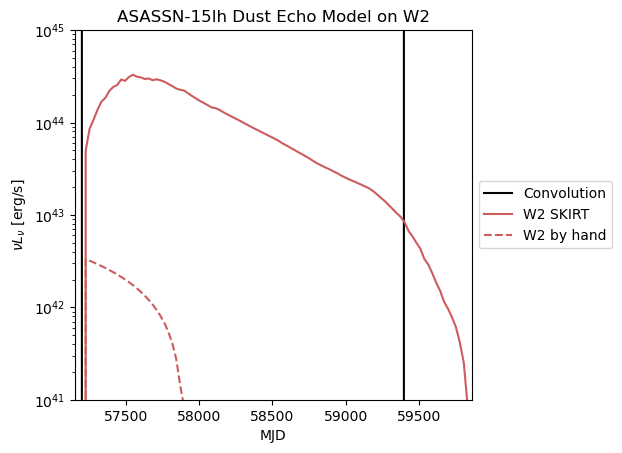

In [22]:
# Plot the lightcurve with SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the mass lightcurves
ax.plot(output_t,((c.c/wl_w2)*luminosity_mass[:,w2]).to(u.erg/u.s),label='W2 SKIRT',color='indianred')

#Plotting the optical depth lightcurves
ax.plot(output_t,((c.c/wl_w2)*luminosity_optd[:,w2]).to(u.erg/u.s),label='W2 by hand',color='indianred',ls='--')

#Plotting data
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model on W2')
fig.savefig(PLOTFILES_+'lightcurve_compare_w2_SWIFT.pdf')
fig.show()

#Plot the lightcurve without SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the mass lightcurves
ax.plot(output_t,((c.c/wl_w2)*luminosity_mass[:,w2]).to(u.erg/u.s),label='W2 SKIRT',color='indianred')

#Plotting the optical depth lightcurves
ax.plot(output_t,((c.c/wl_w2)*luminosity_optd[:,w2]).to(u.erg/u.s),label='W2 by hand',color='indianred',ls='--')

ax.set_yscale('log')
ax.set_ylim(bottom=1e41,top=1e45)
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model on W2')
fig.savefig(PLOTFILES_+'lightcurve_compare_w2_noSWIFT.pdf')
fig.show()

#### Comparing for black body peak wavelength

13/05/2024 17:50:32.573 ! /var/tmp/lankhorst/ipykernel_440180/376340999.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
13/05/2024 17:50:32.573 !   fig.show()
13/05/2024 17:50:32.745 ! /var/tmp/lankhorst/ipykernel_440180/376340999.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
13/05/2024 17:50:32.745 !   fig.show()


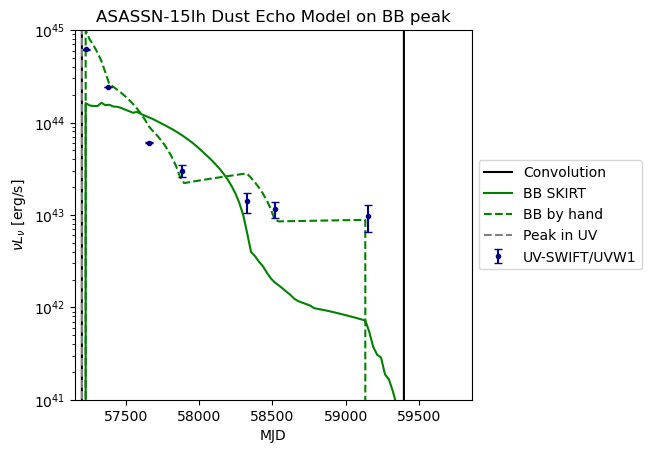

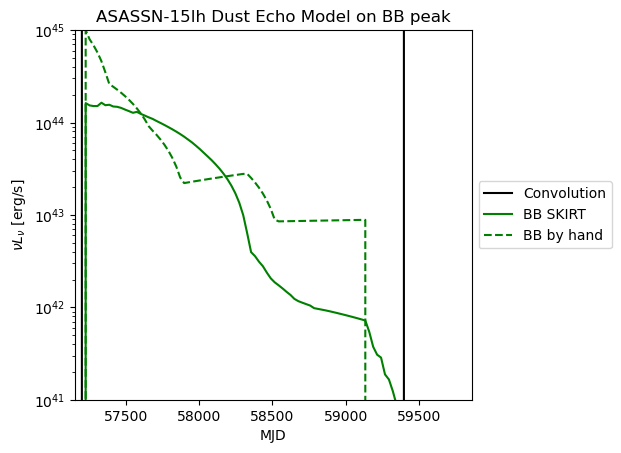

In [23]:
# Plot the lightcurve with SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the mass lightcurves
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_mass[:,bbwl_i]).to(u.erg/u.s),label='BB SKIRT',color='green')

#Plotting the optical depth lightcurves
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_optd[:,bbwl_i]).to(u.erg/u.s),label='BB by hand',color='green',ls='--')

#Plotting data
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model on BB peak')
fig.savefig(PLOTFILES_+'lightcurve_compare_bb_SWIFT.pdf')
fig.show()

#Plot the lightcurve without SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Setting up and plotting the convolution
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the mass lightcurves
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_mass[:,bbwl_i]).to(u.erg/u.s),label='BB SKIRT',color='green')

#Plotting the optical depth lightcurves
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_optd[:,bbwl_i]).to(u.erg/u.s),label='BB by hand',color='green',ls='--')

ax.set_yscale('log')
ax.set_ylim(bottom=1e41,top=1e45)
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model on BB peak')
fig.savefig(PLOTFILES_+'lightcurve_compare_bb_noSWIFT.pdf')
fig.show()

### Comparing the spectra

13/05/2024 17:50:33.915 ! /var/tmp/lankhorst/ipykernel_440180/3280249609.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
13/05/2024 17:50:33.915 !   fig.show()


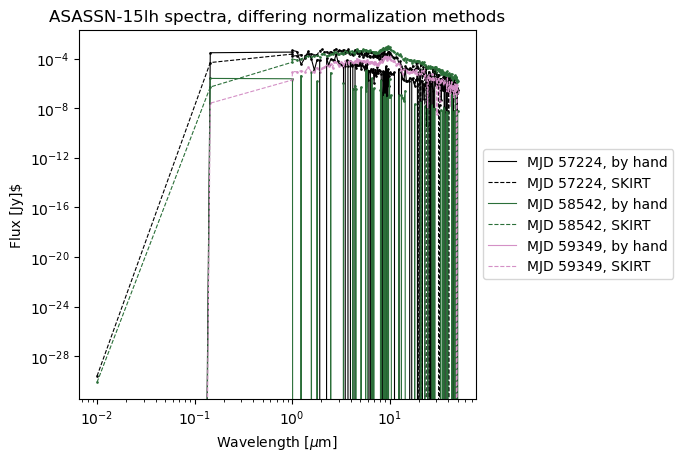

In [24]:
times=(np.array([1,50,80]))

cmap = plt.get_cmap('cubehelix')

fig=plt.figure()
ax=plt.subplot(111)

for t in range(len(times)):
    color = cmap(t/len(times)) #Get the color from the colormap
    ax.loglog(wavelengths_optd,lightcurve_optd[times[t]],label=f'MJD {int(output_t[times[t]])}, by hand',color=color,linewidth=.8)
    ax.loglog(wavelengths_mass, lightcurve_mass[times[t]],label=f'MJD {int(output_t[times[t]])}, SKIRT',color=color,ls='--',linewidth=.8)
    ax.scatter(wavelengths_optd,lightcurve_optd[times[t]],color=color,s=.8)
    ax.scatter(wavelengths_mass, lightcurve_mass[times[t]],color=color,s=.8)

ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel(r'Flux [Jy]$')
#ax.set_ylim(bottom=np.max(luminosity_mass.value)/1e4,top=np.max(luminosity_mass.value)*2)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title(f'{target} spectra, differing normalization methods')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(PLOTFILES_+'spectra_compare.pdf')
fig.show()

In [13]:
outer

0.15

In [10]:
output_wavelengths = np.sort(np.concatenate((np.linspace(0.01, 1, 2), np.linspace(1.01, 10, 10), \
                                              np.linspace(10.01, 50, 10),w1w2,bbwl)))

normalization_type='optical_depth'
static = True

OUTFILES_ = OUTFILES+'test/'+normalization_type+'/'
PLOTFILES_ = PLOTFILES+'test/'+normalization_type+'/'

if os.path.isdir(OUTFILES_) == False:
    os.makedirs(OUTFILES_[:-1])
if os.path.isdir(PLOTFILES_) == False:
    os.makedirs(PLOTFILES_[:-1])
log_=open(OUTFILES_+'log.txt','a')

lightcurve,wavelengths,temp,radius,simulation = get_lightcurve_test(np.array((L_data[0],L_data[1]*Lbol_factor \
                                                                         ,L_data[2]*Lbol_factor)) \
                                                               ,T_data, t_data, output_t \
                                                               ,[centralBin,outer,alpha] \
                                                               ,[amax,amin,grainpowerlaw], spaceBins \
                                                               ,normalization_type=normalization_type \
                                                               ,total_mass = total_mass, opt_depth = [10,0.28,'Z'], nlayers=1 \
                                                               ,static=static,FWHM=FWHM, output_wavelengths=np.append(output_wavelengths,relBinwidth) \
                                                               ,distance=distance,skiname='SKI/ski_testing.txt', Si=False \
                                                               ,prefix=str(today), OUTFILES=OUTFILES_, SKIRTpath='SKIRT/release/SKIRT/main/skirt',name='pepijn')

Now simulating the lightcurve for a sphere with 1 layer(s) of dust, optical_depth normalization, and without sublimation. 


SKIRT Runs:   0%|                                        | 0/10 [00:00<?, ?it/s]

07/05/2024 15:20:09.932   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
07/05/2024 15:20:09.932   Running on student72.strw.leidenuniv.nl for lankhorst
07/05/2024 15:20:09.934   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-07_p/1510/test/optical_depth/57197/run.ski'...
07/05/2024 15:20:11.483 - Finished setup in 1.4 s.
07/05/2024 15:20:11.780 - Finished setup output in 0.3 s.
07/05/2024 15:20:11.987 * *** Error: Cannot destroy dust for fragmented dust mix without dynamic densities
07/05/2024 15:20:11.987 - Finished primary emission iteration 1 in 0.2 s.
07/05/2024 15:20:12.288 - Finished primary emission in 0.3 s.
07/05/2024 15:20:12.504 - Finished secondary emission iteration 1 in 0.2 s.
07/05/2024 15:20:12.702 - Finished secondary emission iteration 2 in 0.2 s.
07/05/2024 15:20:12.903 - Finished secondary emission iteration 3 in 0.2 s.
07/05/2024 15:20:13.104 - Finished secondary emission iteration 4 in 0.2 

SKIRT Runs:  10%|███▏                            | 1/10 [00:07<01:07,  7.47s/it]

07/05/2024 15:20:17.334 - Finished final output in 0.6 s.
07/05/2024 15:20:17.334 * *** Error: The following error message was issued during this simulation:
07/05/2024 15:20:17.334 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
07/05/2024 15:20:17.334 - Finished simulation run using 6 threads and a single process in 7.2 s.
07/05/2024 15:20:17.338   Available memory: 15.4 GB -- Peak memory usage: 194 MB (1.2%)
07/05/2024 15:20:17.493   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
07/05/2024 15:20:17.493   Running on student72.strw.leidenuniv.nl for lankhorst
07/05/2024 15:20:17.495   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-07_p/1510/test/optical_depth/57197/run.ski'...
07/05/2024 15:20:18.943 - Finished setup in 1.4 s.
07/05/2024 15:20:19.225 - Finished setup output in 0.3 s.
07/05/2024 15:20:19.468 * *** Error: Cannot destroy dust for fragmented dust mix without dyn

SKIRT Runs:  20%|██████▍                         | 2/10 [00:14<00:59,  7.38s/it]

07/05/2024 15:20:24.657 - Finished final output in 0.5 s.
07/05/2024 15:20:24.657 * *** Error: The following error message was issued during this simulation:
07/05/2024 15:20:24.657 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
07/05/2024 15:20:24.657 - Finished simulation run using 6 threads and a single process in 7.1 s.
07/05/2024 15:20:24.661   Available memory: 15.4 GB -- Peak memory usage: 205 MB (1.3%)
07/05/2024 15:20:24.718   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
07/05/2024 15:20:24.718   Running on student72.strw.leidenuniv.nl for lankhorst
07/05/2024 15:20:24.720   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-07_p/1510/test/optical_depth/57208/run.ski'...
07/05/2024 15:20:26.260 - Finished setup in 1.4 s.
07/05/2024 15:20:26.472 - Finished setup output in 0.2 s.
07/05/2024 15:20:26.674 * *** Error: Cannot destroy dust for fragmented dust mix without dyn

SKIRT Runs:  30%|█████████▌                      | 3/10 [00:21<00:50,  7.24s/it]

07/05/2024 15:20:31.748 - Finished final output in 0.5 s.
07/05/2024 15:20:31.748 * *** Error: The following error message was issued during this simulation:
07/05/2024 15:20:31.748 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
07/05/2024 15:20:31.748 - Finished simulation run using 6 threads and a single process in 6.9 s.
07/05/2024 15:20:31.752   Available memory: 15.4 GB -- Peak memory usage: 206 MB (1.3%)
07/05/2024 15:20:31.822   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
07/05/2024 15:20:31.822   Running on student72.strw.leidenuniv.nl for lankhorst
07/05/2024 15:20:31.824   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-07_p/1510/test/optical_depth/57225/run.ski'...
07/05/2024 15:20:33.196 - Finished setup in 1.3 s.
07/05/2024 15:20:33.395 - Finished setup output in 0.2 s.
07/05/2024 15:20:33.561 * *** Error: Cannot destroy dust for fragmented dust mix without dyn

SKIRT Runs:  40%|████████████▊                   | 4/10 [00:29<00:43,  7.21s/it]

07/05/2024 15:20:38.913 - Finished final output in 0.7 s.
07/05/2024 15:20:38.913 * *** Error: The following error message was issued during this simulation:
07/05/2024 15:20:38.913 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
07/05/2024 15:20:38.913 - Finished simulation run using 6 threads and a single process in 7.0 s.
07/05/2024 15:20:38.916   Available memory: 15.4 GB -- Peak memory usage: 206 MB (1.3%)
07/05/2024 15:20:39.014   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
07/05/2024 15:20:39.014   Running on student72.strw.leidenuniv.nl for lankhorst
07/05/2024 15:20:39.016   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-07_p/1510/test/optical_depth/57378/run.ski'...
07/05/2024 15:20:40.429 - Finished setup in 1.3 s.
07/05/2024 15:20:40.720 - Finished setup output in 0.3 s.
07/05/2024 15:20:40.949 * *** Error: Cannot destroy dust for fragmented dust mix without dyn

SKIRT Runs:  50%|████████████████                | 5/10 [00:36<00:35,  7.16s/it]

07/05/2024 15:20:45.976 - Finished final output in 0.6 s.
07/05/2024 15:20:45.976 * *** Error: The following error message was issued during this simulation:
07/05/2024 15:20:45.976 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
07/05/2024 15:20:45.976 - Finished simulation run using 6 threads and a single process in 6.9 s.
07/05/2024 15:20:45.980   Available memory: 15.4 GB -- Peak memory usage: 207 MB (1.3%)
07/05/2024 15:20:46.030   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
07/05/2024 15:20:46.031   Running on student72.strw.leidenuniv.nl for lankhorst
07/05/2024 15:20:46.032   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-07_p/1510/test/optical_depth/57659/run.ski'...
07/05/2024 15:20:47.499 - Finished setup in 1.4 s.
07/05/2024 15:20:47.694 - Finished setup output in 0.2 s.
07/05/2024 15:20:47.884 * *** Error: Cannot destroy dust for fragmented dust mix without dyn

SKIRT Runs:  60%|███████████████████▏            | 6/10 [00:42<00:28,  7.06s/it]

07/05/2024 15:20:52.846 - Finished final output in 0.5 s.
07/05/2024 15:20:52.846 * *** Error: The following error message was issued during this simulation:
07/05/2024 15:20:52.846 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
07/05/2024 15:20:52.846 - Finished simulation run using 6 threads and a single process in 6.7 s.
07/05/2024 15:20:52.849   Available memory: 15.4 GB -- Peak memory usage: 208 MB (1.3%)
07/05/2024 15:20:52.900   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
07/05/2024 15:20:52.900   Running on student72.strw.leidenuniv.nl for lankhorst
07/05/2024 15:20:52.901   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-07_p/1510/test/optical_depth/57881/run.ski'...
07/05/2024 15:20:54.326 - Finished setup in 1.3 s.
07/05/2024 15:20:54.540 - Finished setup output in 0.2 s.
07/05/2024 15:20:54.734 * *** Error: Cannot destroy dust for fragmented dust mix without dyn

SKIRT Runs:  70%|██████████████████████▍         | 7/10 [00:49<00:20,  6.93s/it]

07/05/2024 15:20:59.512 - Finished final output in 0.5 s.
07/05/2024 15:20:59.512 * *** Error: The following error message was issued during this simulation:
07/05/2024 15:20:59.512 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
07/05/2024 15:20:59.512 - Finished simulation run using 6 threads and a single process in 6.5 s.
07/05/2024 15:20:59.516   Available memory: 15.4 GB -- Peak memory usage: 208 MB (1.3%)
07/05/2024 15:20:59.579   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
07/05/2024 15:20:59.579   Running on student72.strw.leidenuniv.nl for lankhorst
07/05/2024 15:20:59.581   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-07_p/1510/test/optical_depth/58324/run.ski'...
07/05/2024 15:21:01.015 - Finished setup in 1.4 s.
07/05/2024 15:21:01.234 - Finished setup output in 0.2 s.
07/05/2024 15:21:01.456 * *** Error: Cannot destroy dust for fragmented dust mix without dyn

SKIRT Runs:  80%|█████████████████████████▌      | 8/10 [00:56<00:14,  7.07s/it]

07/05/2024 15:21:06.817 - Finished final output in 0.6 s.
07/05/2024 15:21:06.817 * *** Error: The following error message was issued during this simulation:
07/05/2024 15:21:06.817 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
07/05/2024 15:21:06.817 - Finished simulation run using 6 threads and a single process in 7.2 s.
07/05/2024 15:21:06.824   Available memory: 15.4 GB -- Peak memory usage: 209 MB (1.3%)
07/05/2024 15:21:06.967   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
07/05/2024 15:21:06.967   Running on student72.strw.leidenuniv.nl for lankhorst
07/05/2024 15:21:06.968   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-07_p/1510/test/optical_depth/58519/run.ski'...
07/05/2024 15:21:08.351 - Finished setup in 1.3 s.
07/05/2024 15:21:08.543 - Finished setup output in 0.2 s.
07/05/2024 15:21:08.717 * *** Error: Cannot destroy dust for fragmented dust mix without dyn

SKIRT Runs:  90%|████████████████████████████▊   | 9/10 [01:03<00:06,  6.91s/it]

07/05/2024 15:21:13.412 - Finished final output in 0.6 s.
07/05/2024 15:21:13.412 * *** Error: The following error message was issued during this simulation:
07/05/2024 15:21:13.412 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
07/05/2024 15:21:13.412 - Finished simulation run using 6 threads and a single process in 6.4 s.
07/05/2024 15:21:13.417   Available memory: 15.4 GB -- Peak memory usage: 210 MB (1.3%)
07/05/2024 15:21:13.506   Welcome to SKIRT v9.0 (git 2ba8bec built on 01/05/2024 at 13:31:55)
07/05/2024 15:21:13.506   Running on student72.strw.leidenuniv.nl for lankhorst
07/05/2024 15:21:13.508   Constructing a simulation from ski file '/net/vdesk/data2/Lankhorst/brp/results/ASASSN-15lh/2024-05-07_p/1510/test/optical_depth/59155/run.ski'...
07/05/2024 15:21:14.985 - Finished setup in 1.3 s.
07/05/2024 15:21:15.218 - Finished setup output in 0.2 s.
07/05/2024 15:21:15.376 * *** Error: Cannot destroy dust for fragmented dust mix without dyn

SKIRT Runs: 100%|███████████████████████████████| 10/10 [01:09<00:00,  7.00s/it]


07/05/2024 15:21:19.888 - Finished final output in 0.5 s.
07/05/2024 15:21:19.888 * *** Error: The following error message was issued during this simulation:
07/05/2024 15:21:19.888 * *** Error:   Cannot destroy dust for fragmented dust mix without dynamic densities
07/05/2024 15:21:19.888 - Finished simulation run using 6 threads and a single process in 6.2 s.
07/05/2024 15:21:19.891   Available memory: 15.4 GB -- Peak memory usage: 210 MB (1.3%)


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 47.45it/s]


Compile Lightcurve:   0%|                               | 0/100 [00:00<?, ?it/s]

Compile Lightcurve:   7%|█▌                     | 7/100 [00:00<00:01, 51.84it/s]

Compile Lightcurve:  13%|██▊                   | 13/100 [00:00<00:03, 23.30it/s]

Compile Lightcurve:  17%|███▋                  | 17/100 [00:00<00:04, 16.61it/s]

Compile Lightcurve:  20%|████▍                 | 20/100 [00:01<00:05, 13.39it/s]

Compile Lightcurve:  22%|████▊                 | 22/100 [00:01<00:06, 11.83it/s]

Compile Lightcurve:  24%|█████▎                | 24/100 [00:01<00:07, 10.66it/s]

Compile Lightcurve:  26%|█████▋                | 26/100 [00:01<00:07,  9.65it/s]

Compile Lightcurve:  28%|██████▏               | 28/100 [00:02<00:08,  8.74it/s]

Compile Lightcurve:  29%|██████▍               | 29/100 [00:02<00:08,  8.32it/s]

Compile Lightcurve:  30%|██████▌               | 30/100 [00:02<00:08,  7.89it/s]

Compile Lightcu

In [113]:
# indices corresponding to the WISE filter and black body peak wavelengths
w1=np.argmin(np.abs(wavelengths-wl_w1.value))
w2=np.argmin(np.abs(wavelengths-wl_w2.value))
bbwl_i=np.argmin(np.abs(wavelengths-bbwl))

# Convert the lightcurve to luminosity
luminosity=FluxtoLum(lightcurve,distance=distance)
# Calculate the covering factor
# in this simulation a spherical dust shell is used,
# as we expect a clumpy dust structure a covering factor is applied to account for the higher luminosity.
coveringFactor=np.max(W1[1]*u.erg/u.s/u.Hz)/luminosity[np.argmin(np.abs(output_t-W1[0,np.argmax(W1[1])])),w1]

# Save the data
log_.write('amax='+str(amax)+', grainpowerlaw='+str(grainpowerlaw)+', coveringFactor='+str(coveringFactor)+', sublimation radius='+str(np.min(radius))+', T_min='+np.array2string(np.array(temp),max_line_width=len(temp)*100))
log_.write('\n')
if os.path.isdir(OUTFILES_+'GridSearch/')==False:
    os.makedirs(OUTFILES_+'GridSearch/')
if os.path.isdir(PLOTFILES_+'/')==False:
    os.makedirs(PLOTFILES_+'/')

np.savetxt(OUTFILES_+'config.txt',luminosity.value)
np.savetxt(OUTFILES_+'luminosities.txt',luminosity.value)
np.savetxt(OUTFILES_+'wavelengths.txt',output_wavelengths)


## Making the lightcurves

07/05/2024 13:39:49.379 ! /var/tmp/lankhorst/ipykernel_3020255/2844683662.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
07/05/2024 13:39:49.379 !   fig.show()
07/05/2024 13:39:49.379 ! /var/tmp/lankhorst/ipykernel_3020255/2844683662.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
07/05/2024 13:39:49.379 !   fig.show()
07/05/2024 13:39:49.665 ! /var/tmp/lankhorst/ipykernel_3020255/2844683662.py:80: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
07/05/2024 13:39:49.665 !   fig.show()
07/05/2024 13:39:49.665 ! /var/tmp/lankhorst/ipykernel_3020255/2844683662.py:80: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
07/05/2024 13:39:49.665 !   fig.show()


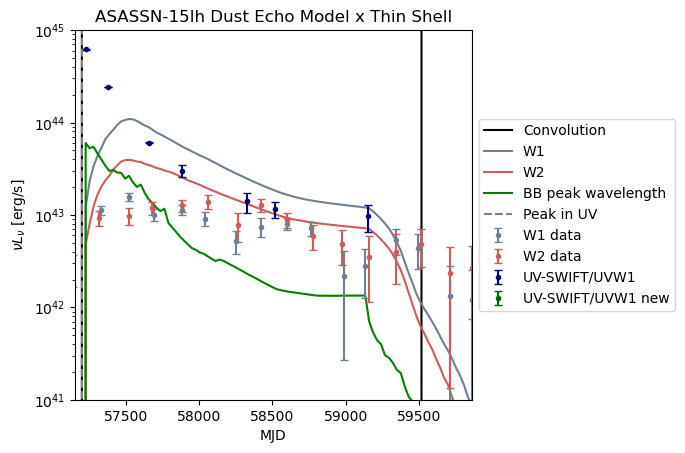

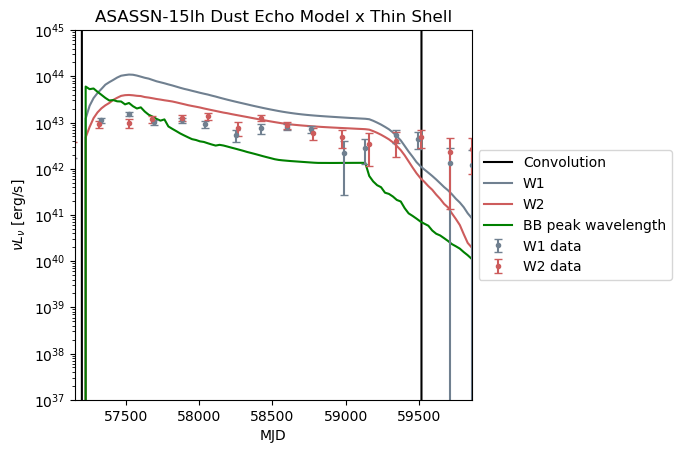

In [72]:
#Applying the covering factor
luminosity_cov = luminosity * coveringFactor
cover = False
#Setting up the convolution
conv_time,conv_lum = convolution(centralBin,L[sorted_indices],L[0][sorted_indices])

#Making lightcurve plot including the SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Plotting the convolution
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity[:,w1]).to(u.erg/u.s),label='W1',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity[:,w2]).to(u.erg/u.s),label='W2',color='indianred')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity[:,bbwl_i]).to(u.erg/u.s),label='BB peak wavelength',color='green')

#Plotting the lightcurves with covering factors if wanted
if cover:
    ax.plot(output_t,((c.c/wl_w1)*luminosity_cov[:,w1]).to(u.erg/u.s),label='W1 fit',color='slategrey',ls='--')
    ax.plot(output_t,((c.c/wl_w2)*luminosity_cov[:,w2]).to(u.erg/u.s),label='W2 fit',color='indianred',ls='--')

#Plotting data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')
ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='darkgreen',capsize=3,label='UV-SWIFT/UVW1 new')
 

ax.set_yscale('log')
ax.set_ylim(bottom=0.9*np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model x Thin Shell')
if cover:
    fig.savefig(PLOTFILES_+'/lightcurve_cov_SWIFT.pdf')
else:
    fig.savefig(PLOTFILES_+'/lightcurve_SWIFT.pdf')
fig.show()

#Making lightcurve plot without the SWIFT data
fig=plt.figure()
ax=plt.subplot(111)

#Plotting the convolution
ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

#Plotting the lightcurves
ax.plot(output_t,((c.c/wl_w1)*luminosity[:,w1]).to(u.erg/u.s),label='W1',color='slategrey')
ax.plot(output_t,((c.c/wl_w2)*luminosity[:,w2]).to(u.erg/u.s),label='W2',color='indianred')
ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity[:,bbwl_i]).to(u.erg/u.s),label='BB peak wavelength',color='green')

#Plotting the lightcurves with covering factors
if cover:
    ax.plot(output_t,((c.c/wl_w1)*luminosity_cov[:,w1]).to(u.erg/u.s),label='W1 fit',color='slategrey',ls='--')
    ax.plot(output_t,((c.c/wl_w2)*luminosity_cov[:,w2]).to(u.erg/u.s),label='W2 fit',color='indianred',ls='--')

#Plotting W1&2 data
ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')

ax.set_yscale('log')
ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
ax.set_ylim(bottom=1e37,top=1e45)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo Model x Thin Shell')
if cover:
    fig.savefig(PLOTFILES_+'/lightcurve_cov_noSWIFT.pdf')
else:
    fig.savefig(PLOTFILES_+'lightcurve_noSWIFT.pdf')
fig.show()

## Making the spectra

In [104]:
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
peaks, _ = find_peaks(lightcurve[1], distance=600)  # Adjust distance parameter based on your data
print(peaks)
print(lightcurve[1][79],lightcurve[1][1080])

[  79  761 1369]
0.00028869337433394743 Jy 4.3266663211456606e-06 Jy


07/05/2024 14:08:33.495 ! /var/tmp/lankhorst/ipykernel_3020255/1729159124.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
07/05/2024 14:08:33.495 !   fig.show()
07/05/2024 14:08:33.495 ! /var/tmp/lankhorst/ipykernel_3020255/1729159124.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
07/05/2024 14:08:33.495 !   fig.show()


Peak wavelengths: 1.6625907384230287 and 9.313654568210262 micron


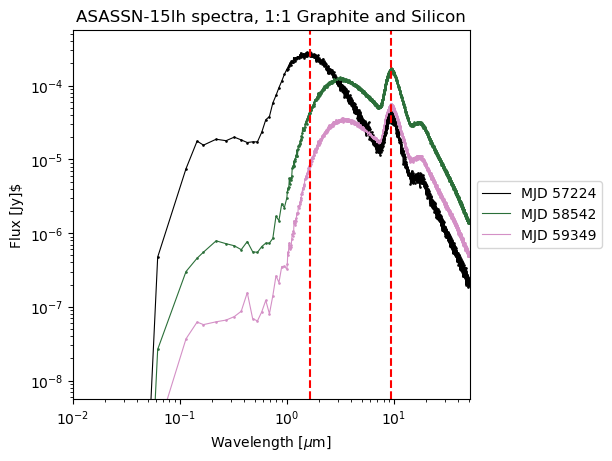

In [110]:
times=(np.array([1,50,80]))

fig=plt.figure()
ax=plt.subplot(111)

cmap = plt.get_cmap('cubehelix')

for t in range(len(times)):
    color = cmap(t/len(times)) #Get the color from the colormap
    ax.scatter(output_wavelengths, lightcurve[times[t]],color=color,s=.8)    
    ax.loglog(output_wavelengths,lightcurve[times[t]],label=f'MJD {int(output_t[times[t]])}',color=color,linewidth=0.8)

ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel(r'Flux [Jy]$')
ax.set_ylim(bottom=np.max(lightcurve[times[-1]].value)/1e4,top=np.max(lightcurve[times[0]].value*2))
ax.axvline(output_wavelengths[79],c='red',ls='--')
ax.axvline(output_wavelengths[761],c='red',ls='--')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title(f'{target} spectra, 1:1 Graphite and Silicon')
ax.set_xlim(np.min(output_wavelengths),np.max(output_wavelengths)+1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(PLOTFILES_+'/spectra.pdf')
fig.show()
print(f"Peak wavelengths: {output_wavelengths[79]} and {output_wavelengths[761]} micron")

# Using old data for plots

In [12]:
unitL=u.erg/u.s/u.Hz

wavelengths = np.sort(np.concatenate((np.linspace(0.01, 1, 50), np.linspace(1.01, 10, 100), \
                                              np.linspace(10.01, 50, 100),w1w2,bbwl)))

radius = [0.15,0.2,0.5,0.75,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5,7.5,10]

file_loc = '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-24_l/1112/ChangingR'
luminosity_total = {}
for i in radius:
    luminosity_total[i]=np.genfromtxt(file_loc+str(f'/R={i}/luminosity_data.txt'),delimiter = ' ') * unitL

In [13]:
# indices corresponding to the WISE filter and black body peak wavelengths
w1=np.argmin(np.abs(wavelengths-wl_w1.value))
w2=np.argmin(np.abs(wavelengths-wl_w2.value))
bbwl_i=np.argmin(np.abs(wavelengths-bbwl))

# Convert the lightcurve to luminosity
#luminosity=FluxtoLum(lightcurve,distance=distance)
# Calculate the covering factor
# in this simulation a spherical dust shell is used,
# as we expect a clumpy dust structure a covering factor is applied to account for the higher luminosity.

#coveringFactor=np.max(W1[1]*u.erg/u.s/u.Hz)/luminosity[np.argmin(np.abs(output_t-W1[0,np.argmax(W1[1])])),w1]

# Save the data
#log_.write('amax='+str(amax)+', grainpowerlaw='+str(grainpowerlaw)+', coveringFactor='+str(coveringFactor)+', sublimation radius='+str(np.min(radius))+', T_min='+np.array2string(np.array(temp),max_line_width=len(temp)*100))
#log_.write('\n')
#if os.path.isdir(OUTFILES_+'GridSearch/')==False:
#    os.makedirs(OUTFILES_+'GridSearch/')
#if os.path.isdir(PLOTFILES_+'/')==False:
#    os.makedirs(PLOTFILES_+'/')

#np.savetxt(OUTFILES_+'config.txt',luminosity.value)

#### Loading in old data

In [14]:
output_t = np.array([57197.094436  , 57224.00109594, 57250.90775588, 57277.81441582,
       57304.72107576, 57331.6277357 , 57358.53439563, 57385.44105557,
       57412.34771551, 57439.25437545, 57466.16103539, 57493.06769533,
       57519.97435527, 57546.88101521, 57573.78767515, 57600.69433509,
       57627.60099503, 57654.50765497, 57681.4143149 , 57708.32097484,
       57735.22763478, 57762.13429472, 57789.04095466, 57815.9476146 ,
       57842.85427454, 57869.76093448, 57896.66759442, 57923.57425436,
       57950.4809143 , 57977.38757424, 58004.29423417, 58031.20089411,
       58058.10755405, 58085.01421399, 58111.92087393, 58138.82753387,
       58165.73419381, 58192.64085375, 58219.54751369, 58246.45417363,
       58273.36083357, 58300.26749351, 58327.17415344, 58354.08081338,
       58380.98747332, 58407.89413326, 58434.8007932 , 58461.70745314,
       58488.61411308, 58515.52077302, 58542.42743296, 58569.3340929 ,
       58596.24075284, 58623.14741278, 58650.05407271, 58676.96073265,
       58703.86739259, 58730.77405253, 58757.68071247, 58784.58737241,
       58811.49403235, 58838.40069229, 58865.30735223, 58892.21401217,
       58919.12067211, 58946.02733205, 58972.93399198, 58999.84065192,
       59026.74731186, 59053.6539718 , 59080.56063174, 59107.46729168,
       59134.37395162, 59161.28061156, 59188.1872715 , 59215.09393144,
       59242.00059138, 59268.90725132, 59295.81391125, 59322.72057119,
       59349.62723113, 59376.53389107, 59403.44055101, 59430.34721095,
       59457.25387089, 59484.16053083, 59511.06719077, 59537.97385071,
       59564.88051065, 59591.78717059, 59618.69383052, 59645.60049046,
       59672.5071504 , 59699.41381034, 59726.32047028, 59753.22713022,
       59780.13379016, 59807.0404501 , 59833.94711004, 59860.85376998])

W1 = np.array([[ 5.67897459e+04,  5.69720425e+04,  5.71388684e+04,
         5.73262811e+04,  5.75192124e+04,  5.76892990e+04,
         5.78813839e+04,  5.80379126e+04,  5.82480511e+04,
         5.84234112e+04,  5.86000300e+04,  5.87639936e+04,
         5.89860996e+04,  5.91297590e+04,  5.93470404e+04,
         5.94947592e+04,  5.97105220e+04,  5.98608538e+04],
       [-6.67727999e+27,  8.43621325e+27, -4.49212210e+26,
         1.26008436e+29,  1.75518724e+29,  1.12940538e+29,
         1.27153548e+29,  1.02407141e+29,  5.93250103e+28,
         8.39926761e+28,  9.03486855e+28,  8.05803911e+28,
         2.42850845e+28,  3.11657354e+28,  5.96348630e+28,
         4.92927122e+28,  1.49215449e+28,  1.33582188e+28],
       [ 1.51808037e+28,  1.63084527e+28,  1.92571359e+28,
         1.42578831e+28,  1.76485484e+28,  1.60281923e+28,
         1.54228093e+28,  1.70293933e+28,  1.65411754e+28,
         1.94498518e+28,  1.24579782e+28,  1.45087724e+28,
         2.12661680e+28,  1.70777412e+28,  1.86936500e+28,
         1.98981433e+28,  1.66047230e+28,  1.47892711e+28]])

W2 = np.array([[ 5.67771070e+04,  5.69734171e+04,  5.71388323e+04,
         5.73168218e+04,  5.75210310e+04,  5.76773996e+04,
         5.78806770e+04,  5.80624078e+04,  5.82617234e+04,
         5.84184160e+04,  5.86003374e+04,  5.87749581e+04,
         5.89782863e+04,  5.91583945e+04,  5.93455376e+04,
         5.95141207e+04,  5.97132152e+04,  5.98608482e+04],
       [-6.46623121e+26, -2.64329047e+28,  2.63904947e+28,
         1.43626731e+29,  1.50362514e+29,  1.83168218e+29,
         1.94913697e+29,  2.14588829e+29,  1.19985041e+29,
         1.96663943e+29,  1.35756714e+29,  9.18280612e+28,
         7.49990965e+28,  5.40695791e+28,  6.18668696e+28,
         7.47150930e+28,  3.58193765e+28,  4.13303732e+28],
       [ 3.00153891e+28,  3.13382485e+28,  3.10000505e+28,
         2.55214948e+28,  3.11884688e+28,  2.95824512e+28,
         2.80205669e+28,  3.59230946e+28,  4.11219981e+28,
         3.29323254e+28,  2.43055000e+28,  2.70389330e+28,
         3.09482222e+28,  3.65104448e+28,  3.45676189e+28,
         3.24892980e+28,  3.37622645e+28,  2.97770604e+28]])

L = [[],[],[]]
L[0] = np.array([57197.097383,57199.789812,57201.819587,57205.637378,57208.663804
,57211.658575,57214.673089,57214.712464,57216.578566,57217.248686
,57217.643367,57219.803334,57220.538547,57221.684907,57223.513323
,57226.519083,57229.267174,57232.896315,57241.124401,57244.883912
,57248.472127,57250.705438,57253.697942,57255.695041,57259.403583
,57262.729112,57265.561799,57268.786246,57272.606149,57272.876665
,57277.358264,57282.880878,57283.409536,57284.372073,57284.77255
,57290.873271,57293.567276,57296.627403,57298.644927,57299.515715
,57302.573313,57305.489724,57307.452226,57309.67833,57311.308593
,57313.238721,57316.241037,57317.76894,57319.763883,57325.341625
,57328.529877,57330.186444,57331.059133,57334.583839,57343.43778
,57346.193747,57349.219303,57353.631539,57356.23171,57359.319789
,57362.840502,57365.100734,57366.392601,57368.955573,57371.418383
,57374.407059,57377.197947,57380.923575,57383.285363,57385.871972
,57393.664048,57396.757139,57399.25113,57427.746645,57429.650077
,57433.506842,57437.321895,57447.409725,57449.933596,57450.165868
,57454.218224,57456.081118,57457.644158,57465.558805,57470.340407
,57472.225808,57475.681221,57477.549632,57480.30161,57487.480485
,57489.040972,57502.7087,57505.396842,57508.959855,57511.886128
,57515.930429,57516.83562,57520.621166,57523.765877,57527.961241
,57528.926354,57533.605854,57552.752459,57554.877651,57557.366807
,57560.220535,57563.207896,57569.435099,57578.206167,57585.048519
,57591.85437,57600.437115,57601.433575,57601.60322,57608.087459
,57609.441491,57611.568756,57615.550131,57622.525802,57626.716183
,57630.434038,57632.914419,57640.35727,57645.710722,57654.992983
,57667.614064,57677.90541,57680.202702,57683.196866,57687.508531
,57688.937973,57704.232439,57714.591025,57719.635076,57726.0463
,57730.771125,57746.577993,57757.781188,57793.45434,57794.547711
,57798.195541,57881.556641,58324.594074,59154.661307,59160.617308
,57197.100521,57199.794841,57201.82276,57205.642203,57208.667321
,57211.662512,57214.677118,57214.71575,57221.691959,57223.519494
,57226.522564,57229.270689,57232.89954,57241.131622,57244.890843
,57248.477176,57250.710501,57253.634075,57255.664685,57259.408437
,57262.732162,57268.789284,57272.570109,57272.881335,57277.32949
,57282.874211,57283.405018,57284.376164,57284.775362,57290.86655
,57293.557726,57296.621264,57298.651697,57299.510458,57302.569553
,57305.494449,57307.458565,57309.685208,57311.313439,57313.243002
,57316.233365,57317.773601,57319.756828,57322.754979,57325.333877
,57328.524844,57330.190494,57331.051722,57334.57675,57343.430081
,57346.198374,57349.212333,57353.561886,57356.224151,57359.312666
,57362.83713,57365.092934,57368.948863,57371.424558,57374.399679
,57377.189569,57380.915642,57383.288792,57385.873784,57393.666325
,57396.763296,57399.255287,57427.749952,57429.653359,57433.5093
,57437.358515,57447.412689,57449.937703,57450.170102,57454.22191
,57456.085752,57465.553644,57470.332983,57472.22931,57475.672284
,57477.552059,57480.296831,57487.476424,57489.031406,57499.780919
,57502.700973,57505.391287,57508.948787,57511.874971,57515.919804
,57516.832268,57520.615488,57523.760154,57527.956399,57528.921636
,57533.607765,57552.755814,57554.881829,57557.370987,57560.225389
,57563.210634,57569.437579,57578.199744,57585.044277,57591.84844
,57600.430634,57601.426769,57601.596769,57608.082434,57609.435825
,57611.559309,57615.541362,57622.450598,57625.020526,57626.709996
,57630.427085,57632.944359,57640.350178,57645.706001,57654.990243
,57667.609064,57677.901101,57680.200354,57683.189234,57687.504052
,57688.932209,57704.22724,57714.585339,57719.629068,57725.94495
,57726.038815,57730.766068,57746.570833,57757.775122,57793.451209
,57794.54176,57798.19142,57881.552025,58324.597268,59153.36977
,59154.665354,59160.620007,57197.093871,57199.783798,57201.816224
,57205.633359,57208.660993,57211.655486,57214.668557,57214.709614
,57219.78909,57221.679485,57223.508317,57226.514823,57229.264423
,57232.893539,57241.118616,57244.878352,57248.467892,57250.701398
,57253.667653,57255.689453,57259.399636,57262.726564,57265.558295
,57268.783117,57272.600666,57272.872952,57277.351803,57282.876593
,57283.406797,57284.36874,57284.769369,57290.869151,57293.561675
,57296.623744,57298.639492,57299.512561,57302.571046,57305.485307
,57307.446809,57309.672828,57311.304535,57313.235345,57316.235896
,57317.727347,57319.759719,57322.724666,57325.337265,57328.526574
,57330.182634,57331.054475,57334.579456,57343.433373,57346.18739
,57349.215069,57353.563863,57356.227212,57359.315494,57362.838274
,57365.09702,57366.391388,57368.95132,57371.411413,57374.402717
,57377.192976,57380.918511,57383.281189,57385.869842,57393.66104
,57396.749772,57399.246762,57427.743171,57429.646363,57433.504089
,57437.317551,57447.406981,57449.929326,57450.161211,57454.214203
,57456.075631,57457.639665,57465.555502,57470.336125,57472.256671
,57475.675508,57477.547081,57480.298719,57487.477992,57489.035122
,57499.783581,57502.703737,57505.393413,57508.95287,57511.87926
,57515.923831,57516.833778,57520.617534,57523.762329,57527.95835
,57528.923412,57533.604307,57552.749619,57554.874342,57557.363204
,57560.216607,57563.205662,57569.433001,57578.202032,57585.045619
,57591.850623,57600.433195,57601.429472,57601.598868,57608.084405
,57609.438293,57611.562883,57615.545009,57622.454582,57626.712197
,57630.429358,57632.94611,57640.352895,57645.707848,57654.991232
,57667.610729,57677.902525,57680.201226,57683.192522,57687.505634
,57688.934187,57704.229223,57714.587598,57719.631394,57725.946156
,57726.04166,57730.767793,57746.573697,57757.777399,57793.452308
,57794.543904,57798.193114,57881.553819,58324.59153,59153.364697
,59154.658022,57197.095001,57199.785392,57201.817347,57205.634872
,57208.661828,57211.656442,57214.669979,57214.710559,57216.360668
,57216.494078,57216.759832,57220.523842,57221.681287,57223.510126
,57226.515918,57229.265165,57232.894593,57241.120531,57244.880068
,57248.469254,57250.702737,57253.696877,57255.691169,57259.4007
,57262.727367,57265.560035,57268.784432,57272.602237,57272.874272
,57277.353978,57282.877972,57283.407897,57284.369893,57284.77037
,57290.870747,57293.56414,57296.625302,57298.64147,57299.513871
,57302.57195,57305.487091,57307.448757,57309.674683,57311.306126
,57313.23632,57316.237319,57317.765622,57319.761524,57325.339447
,57328.527583,57330.184002,57331.056099,57334.5811,57343.435431
,57346.189181,57349.216772,57353.565092,57356.22913,57359.317226
,57362.838946,57365.099016,57366.424375,57368.9528,57371.41349
,57374.404596,57377.195132,57380.920192,57383.282354,57385.870477
,57393.66184,57396.75207,57399.248306,57427.744307,57429.647268
,57433.504866,57437.318955,57447.407959,57449.930681,57450.162608
,57454.215436,57456.077277,57457.640783,57465.556597,57470.338119
,57472.223172,57475.677399,57477.547846,57480.299902,57487.478931
,57489.037374,57502.705381,57505.394704,57508.955292,57511.881834
,57515.92626,57516.834762,57520.618756,57523.763649,57527.959578
,57528.924496,57533.604863,57552.750569,57554.875366,57557.364449
,57560.218264,57563.206513,57569.433813,57578.203379,57585.04637
,57591.851921,57600.434749,57601.431106,57601.600051,57608.085591
,57609.43989,57611.565039,57615.547309,57622.52238,57626.7135
,57630.430626,57632.91314,57640.354545,57645.709001,57654.99184
,57667.611678,57677.903349,57680.201751,57683.194627,57687.506577
,57688.935334,57704.230427,57714.588994,57719.632801,57726.043398
,57730.768813,57746.575445,57757.778765,57793.452966,57794.545179
,57798.194162,57881.554902,58324.59225,59154.659089,57197.095741
,57199.786563,57201.818064,57205.635589,57208.662306,57211.656971
,57214.670925,57214.71106,57221.682219,57223.511003,57226.51674
,57229.265626,57232.895095,57241.121513,57244.881011,57248.469976
,57250.703437,57253.697285,57255.692365,57259.401345,57262.727811
,57265.560973,57268.78501,57272.603386,57272.874936,57277.355349
,57284.370478,57284.771034,57298.642423,57305.48811,57307.449705
,57309.675615,57311.306853,57313.236886,57317.766671,57330.184846
,57346.190442,57366.4254,57371.414899,57383.283193,57385.870922
,57393.662434,57396.753586,57399.249258,57427.745044,57429.647978
,57433.505425,57437.31987,57447.408565,57449.931571,57450.163561
,57454.21627,57456.078393,57457.641638,57472.223946,57477.548377
,57533.60515,57552.751066,57554.875933,57557.365077,57560.218986
,57563.206921,57569.434204])

L[1] = np.array([2.15809799e+45,2.09928383e+45,1.81163691e+45,1.71423817e+45
,1.45234957e+45,1.30038263e+45,1.13258593e+45,1.06186953e+45
,9.86441105e+44,9.86441105e+44,1.04248823e+45,8.05510417e+44
,7.98125453e+44,7.98125453e+44,6.76193763e+44,5.27316257e+44
,4.80918142e+44,3.85541525e+44,3.00656890e+44,2.41030033e+44
,2.15809799e+44,2.28071575e+44,2.23908799e+44,1.86239227e+44
,1.52079670e+44,1.65223250e+44,1.37426714e+44,1.93228490e+44
,1.95016412e+44,2.08003748e+44,2.71688440e+44,2.84492722e+44
,2.79300145e+44,2.92463155e+44,2.87125101e+44,3.20679473e+44
,3.64813718e+44,3.85541525e+44,3.75034448e+44,3.85541525e+44
,3.71596112e+44,4.50890579e+44,4.76509058e+44,4.63522864e+44
,5.12945425e+44,4.80918142e+44,4.80918142e+44,4.30597160e+44
,4.11217095e+44,3.78504599e+44,4.63522864e+44,4.80918142e+44
,4.89859078e+44,4.59273260e+44,4.50890579e+44,4.46756789e+44
,4.85368023e+44,4.59273260e+44,5.12945425e+44,4.72140397e+44
,4.94391688e+44,4.72140397e+44,4.98966238e+44,4.50890579e+44
,4.22737876e+44,3.89108897e+44,4.15022040e+44,3.82006859e+44
,3.82006859e+44,4.07447034e+44,3.68189298e+44,3.23646683e+44
,3.61469086e+44,2.19822003e+44,1.98642037e+44,1.79502773e+44
,1.81163691e+44,1.93228490e+44,2.02335069e+44,1.79502773e+44
,1.77857081e+44,2.06096758e+44,1.77857081e+44,1.79502773e+44
,1.77857081e+44,1.77857081e+44,1.56340379e+44,1.68294980e+44
,1.47935077e+44,1.30038263e+44,1.54907042e+44,1.46578800e+44
,1.38698307e+44,1.46578800e+44,1.32455855e+44,1.27664798e+44
,1.37426714e+44,1.15364227e+44,1.26494360e+44,1.39981667e+44
,8.05510417e+43,7.41431718e+43,1.08161116e+44,1.15364227e+44
,9.59557846e+43,1.17509008e+44,1.13258593e+44,8.91396985e+43
,8.51277512e+43,7.69256476e+43,6.76193763e+43,9.16370629e+43
,6.63851836e+43,6.69994382e+43,6.82450507e+43,7.14613409e+43
,6.82450507e+43,7.76374318e+43,5.37119798e+43,5.42089707e+43
,5.27316257e+43,7.01570244e+43,5.32195455e+43,5.62433475e+43
,5.03583116e+43,4.80918142e+43,6.63851836e+43,4.76509058e+43
,5.62433475e+43,6.51735175e+43,5.88940148e+43,3.92709277e+43
,4.55062618e+43,2.11870827e+43,4.46756789e+43,3.48394396e+43
,4.30597160e+43,4.98966238e+43,3.92709277e+43,5.22481793e+43
,4.80918142e+43,2.89781837e+43,9.33407231e+42,9.77397358e+42
,6.51735175e+42,2.95478993e+45,2.71973512e+45,2.39070841e+45
,2.18035199e+45,1.84725397e+45,1.57952538e+45,1.46732599e+45
,1.30174707e+45,9.17332139e+44,7.91637957e+44,6.52419014e+44
,5.95013213e+44,4.59755157e+44,3.36144964e+44,3.03757220e+44
,2.69480044e+44,2.79593203e+44,2.95478993e+44,2.30423415e+44
,2.12093134e+44,2.00690405e+44,2.16036240e+44,2.62135965e+44
,2.52654251e+44,3.26984081e+44,3.51986988e+44,4.27097087e+44
,4.47225553e+44,4.23181438e+44,4.15457506e+44,5.73491004e+44
,5.57861782e+44,5.32753866e+44,5.18234844e+44,5.57861782e+44
,5.73491004e+44,6.06075334e+44,6.11683280e+44,7.08804734e+44
,6.28820381e+44,6.06075334e+44,6.89487837e+44,5.18234844e+44
,4.99489783e+44,4.77009040e+44,6.11683280e+44,6.06075334e+44
,5.84152998e+44,5.89558099e+44,5.57861782e+44,6.00518802e+44
,6.28820381e+44,6.11683280e+44,5.37683376e+44,5.73491004e+44
,4.85877300e+44,4.90373067e+44,4.64009219e+44,4.72635795e+44
,5.23030012e+44,4.85877300e+44,5.13483638e+44,3.89517173e+44
,4.85877300e+44,4.19301687e+44,3.96758838e+44,4.07874552e+44
,2.77029877e+44,2.41282936e+44,2.62135965e+44,1.98850464e+44
,2.39070841e+44,2.22088776e+44,1.83031825e+44,2.30423415e+44
,2.32555497e+44,2.08221998e+44,2.24143738e+44,2.02547371e+44
,2.22088776e+44,2.00690405e+44,1.73191514e+44,1.62377784e+44
,1.60889095e+44,1.49460562e+44,1.55069580e+44,1.59414055e+44
,1.73191514e+44,1.41425137e+44,1.56504421e+44,1.50843503e+44
,1.60889095e+44,1.35059958e+44,1.59414055e+44,1.10287581e+44
,9.17332139e+43,1.40128544e+44,1.25466161e+44,1.28981258e+44
,1.33821721e+44,1.40128544e+44,9.96613142e+43,1.06298371e+44
,9.96613142e+43,1.08274605e+44,7.28662819e+43,7.15363224e+43
,8.60055762e+43,7.63003640e+43,7.08804734e+43,9.51758161e+43
,8.36616854e+43,8.28946705e+43,1.10287581e+44,5.78797451e+43
,5.32753866e+43,6.70697380e+43,5.68233207e+43,6.89487837e+43
,6.95867590e+43,5.78797451e+43,6.11683280e+43,9.51758161e+43
,7.35405053e+43,5.89558099e+43,5.37683376e+43,4.85877300e+43
,5.95013213e+43,4.68302644e+43,2.54992032e+43,6.34638785e+43
,5.37683376e+43,6.23055321e+43,5.78797451e+43,4.81422750e+43
,5.47679657e+43,5.27869549e+43,4.15457506e+43,1.97027392e+43
,1.76411385e+43,1.00583469e+43,1.08274605e+43,2.07094690e+45
,1.95960691e+45,1.83725299e+45,1.57097388e+45,1.33097213e+45
,1.22509273e+45,1.10705440e+45,1.06701116e+45,8.24458810e+44
,7.80133564e+44,6.92100182e+44,5.86366247e+44,5.25011678e+44
,4.17031599e+44,3.25213798e+44,2.70501055e+44,2.70501055e+44
,3.02112687e+44,2.80652531e+44,2.53611512e+44,2.46699894e+44
,2.44438136e+44,2.55958150e+44,2.55958150e+44,2.85870251e+44
,2.80652531e+44,3.56589839e+44,3.53320603e+44,3.59889324e+44
,3.73395400e+44,3.73395400e+44,3.63219339e+44,4.05666330e+44
,4.53073815e+44,4.13208230e+44,4.32682134e+44,4.17031599e+44
,4.70076958e+44,4.40726296e+44,5.01382260e+44,4.78816341e+44
,4.87718201e+44,4.36685693e+44,4.05666330e+44,4.13208230e+44
,4.96785559e+44,4.24784795e+44,5.15429134e+44,4.44804286e+44
,4.87718201e+44,4.92231002e+44,4.48920009e+44,4.13208230e+44
,4.70076958e+44,4.53073815e+44,4.28715281e+44,3.98262085e+44
,4.32682134e+44,3.63219339e+44,3.90992983e+44,4.20890345e+44
,3.53320603e+44,3.53320603e+44,3.28222964e+44,3.31259974e+44
,3.19277977e+44,3.53320603e+44,3.16350819e+44,3.07729381e+44
,2.91184976e+44,2.37776518e+44,1.78718275e+44,1.75456299e+44
,1.95960691e+44,1.77079776e+44,1.97773893e+44,1.60018046e+44
,1.80371935e+44,1.77079776e+44,1.61498675e+44,1.41960972e+44
,1.62993004e+44,1.73847706e+44,1.66023270e+44,1.33097213e+44
,1.38092141e+44,1.66023270e+44,1.11729785e+44,9.73125747e+43
,1.24786891e+44,1.34328747e+44,1.35571675e+44,1.25941529e+44
,1.27106852e+44,1.30667916e+44,1.29469945e+44,1.20273227e+44
,1.20273227e+44,8.79364569e+43,1.12763608e+44,9.37926839e+43
,8.47557094e+43,9.91217505e+43,1.00038913e+44,1.00038913e+44
,1.08684838e+44,8.71302506e+43,7.18073605e+43,6.37043316e+43
,6.54890911e+43,5.91791827e+43,6.60950542e+43,7.65894522e+43
,7.65894522e+43,4.96785559e+43,5.97267610e+43,5.34772373e+43
,6.73238530e+43,5.70386139e+43,5.20198342e+43,5.20198342e+43
,6.14000837e+43,5.75663857e+43,5.65156808e+43,5.29869551e+43
,5.29869551e+43,5.29869551e+43,3.90992983e+43,5.54841533e+43
,4.17031599e+43,4.13208230e+43,4.05666330e+43,6.31202868e+43
,3.59889324e+43,4.20890345e+43,4.05666330e+43,4.65767266e+43
,3.94610796e+43,4.57266055e+43,3.02112687e+43,2.63129150e+43
,1.08684838e+43,2.46699894e+42,1.29469945e+43,1.74272555e+45
,1.67968946e+45,1.60409098e+45,1.51785050e+45,1.28596455e+45
,1.23944996e+45,1.15140735e+45,1.07951579e+45,1.06961873e+45
,1.10975982e+45,1.07951579e+45,9.23058015e+44,9.66560399e+44
,8.26473623e+44,7.39995362e+44,6.81128414e+44,6.21196497e+44
,5.46045708e+44,4.75585930e+44,4.75585930e+44,4.45891299e+44
,5.31164446e+44,4.21918917e+44,4.02929438e+44,3.54184048e+44
,3.70876228e+44,3.84794626e+44,3.99235358e+44,3.77771332e+44
,3.99235358e+44,4.29762975e+44,4.14218029e+44,3.95575147e+44
,3.99235358e+44,4.14218029e+44,3.88355087e+44,3.77771332e+44
,4.37752866e+44,4.02929438e+44,4.21918917e+44,4.37752866e+44
,4.21918917e+44,4.41803343e+44,4.14218029e+44,4.18050741e+44
,4.41803343e+44,4.02929438e+44,3.88355087e+44,4.18050741e+44
,4.50017080e+44,3.91948492e+44,4.45891299e+44,4.02929438e+44
,3.74307904e+44,3.99235358e+44,3.99235358e+44,4.25822885e+44
,3.81266807e+44,4.33739523e+44,3.17123917e+44,3.29025076e+44
,3.20058229e+44,3.67476015e+44,3.35142109e+44,3.11335754e+44
,3.23019691e+44,3.11335754e+44,3.23019691e+44,3.20058229e+44
,2.81338390e+44,2.78759064e+44,2.89220450e+44,2.01943090e+44
,1.54606945e+44,1.96439580e+44,1.87598343e+44,1.53189500e+44
,1.72674814e+44,2.03811647e+44,1.82485767e+44,1.77512523e+44
,1.89334169e+44,1.61893345e+44,1.74272555e+44,1.98257213e+44
,1.82485767e+44,1.80812728e+44,1.43624655e+44,1.39710484e+44
,1.37160480e+44,1.54606945e+44,1.49014661e+44,1.47648486e+44
,1.28596455e+44,1.37160480e+44,1.57481302e+44,9.40218945e+43
,1.19461784e+44,7.96579265e+43,1.21682745e+44,1.01211299e+44
,1.17281361e+44,1.16206119e+44,1.07951579e+44,1.29786344e+44
,1.37160480e+44,8.41838915e+43,9.14595368e+43,8.11388780e+43
,8.34120890e+43,7.89276183e+43,7.53752903e+43,8.34120890e+43
,6.44509017e+43,8.81513561e+43,5.31164446e+43,7.06690084e+43
,6.50472586e+43,4.29762975e+43,7.19828434e+43,6.44509017e+43
,6.09858383e+43,6.44509017e+43,6.50472586e+43,4.97999604e+43
,3.77771332e+43,4.75585930e+43,4.10420455e+43,6.26944357e+43
,7.06690084e+43,3.77771332e+43,4.45891299e+43,7.53752903e+43
,5.61343887e+43,3.57461273e+43,5.66537938e+43,4.06657698e+43
,2.34007080e+43,4.29762975e+43,4.66905509e+43,1.46294836e+43
,2.11460375e+43,1.02147795e+43,1.00503460e+45,9.51001086e+44
,8.91622487e+44,8.35951368e+44,7.69451079e+44,7.62396709e+44
,7.21408098e+44,7.83756242e+44,5.94539910e+44,6.00041120e+44
,5.52307592e+44,5.17822614e+44,4.99092465e+44,4.46869808e+44
,3.85639058e+44,4.42772880e+44,4.94516757e+44,4.18968154e+44
,3.71690116e+44,3.23728558e+44,3.26723981e+44,3.51707001e+44
,3.29747121e+44,3.48482531e+44,3.38985415e+44,3.85639058e+44
,3.42122008e+44,3.17819846e+44,2.66797044e+44,3.00732949e+44
,2.95243954e+44,2.28129271e+44,2.97975813e+44,3.12018980e+44
,3.14906056e+44,2.71757171e+44,2.79370801e+44,2.61927449e+44
,2.00530766e+44,1.73053749e+44,1.95065746e+44,1.95065746e+44
,1.79548182e+44,1.54946230e+44,1.60761116e+44,1.50723515e+44
,1.04275196e+44,1.81209521e+44,1.05240042e+44,1.57826895e+44
,1.28878660e+44,1.18626308e+44,1.30071160e+44,1.13287244e+44
,9.51001086e+43,1.12248621e+44,1.37461479e+44,8.43686331e+43
,6.00041120e+43,8.13169372e+43,7.91008249e+43,8.83448043e+43
,3.71690116e+43])

    
L[2] = np.array([9.37250050e+43,9.11707384e+43,7.86783914e+43,7.44484178e+43
,6.30747405e+43,7.05936253e+43,6.14844773e+43,8.07037139e+43
,6.42608893e+43,4.28405929e+43,7.92307051e+43,6.99657458e+43
,6.06587590e+43,5.19932220e+43,3.67084025e+43,2.86263176e+43
,3.13290143e+43,2.51157835e+43,1.95860442e+43,1.83186524e+43
,1.40587507e+43,2.72388122e+43,2.91727068e+43,1.41544670e+43
,1.65118404e+43,1.25572205e+43,3.13339233e+43,1.67836134e+43
,1.48215465e+43,2.03253480e+43,1.76989186e+43,1.85330429e+43
,1.81947768e+43,1.90522702e+43,1.87045270e+43,2.08903988e+43
,2.37654877e+43,2.09298196e+43,2.03594239e+43,2.09298196e+43
,2.01727676e+43,2.44774113e+43,3.10417882e+43,3.52284488e+43
,3.34154052e+43,3.13290143e+43,2.61075119e+43,2.80508956e+43
,2.67883973e+43,2.46573688e+43,2.51631777e+43,2.61075119e+43
,3.19114642e+43,2.99189764e+43,2.93728935e+43,2.42530010e+43
,3.16188981e+43,5.48514567e+43,2.78461710e+43,3.07571954e+43
,3.22067373e+43,3.07571954e+43,9.75142278e+43,2.93728935e+43
,2.75389090e+43,2.53481770e+43,2.70362673e+43,2.48855206e+43
,2.90331074e+43,5.30855996e+43,2.39853871e+43,2.10836953e+43
,2.35476044e+43,1.67068095e+43,1.94105567e+43,1.75403393e+43
,1.77026381e+43,1.46856617e+43,1.97714259e+43,2.53360457e+43
,1.54484698e+43,1.56636699e+43,1.93105872e+43,1.36424861e+43
,1.35174111e+43,2.70348221e+43,1.18821087e+43,1.82723953e+43
,1.28494775e+43,1.97662151e+43,2.01825821e+43,1.43231319e+43
,1.35530796e+43,1.27316728e+43,1.29430906e+43,1.24749264e+43
,1.49209158e+43,1.62831654e+43,1.23605555e+43,1.82379797e+43
,2.18642956e+43,2.17349800e+43,1.40921328e+43,1.25255118e+43
,9.37644025e+42,1.14825406e+43,1.59859641e+43,1.45173297e+43
,8.31836534e+42,9.18730567e+42,7.34168050e+42,1.79088618e+43
,1.58568954e+43,8.00180873e+42,1.55601857e+43,1.31899881e+43
,8.89153468e+42,8.42937706e+42,1.10802378e+43,1.00056292e+43
,9.73294798e+42,1.52344043e+43,6.35606260e+42,8.54916141e+42
,6.01434263e+42,6.26580286e+42,8.64921568e+42,1.50035310e+43
,6.71719825e+42,9.19896218e+42,8.95207097e+42,5.96930152e+42
,8.89340327e+42,1.33420780e+43,9.21614039e+42,8.70008142e+42
,7.48023882e+42,7.04269423e+42,1.15122244e+43,1.07782706e+43
,9.39870430e+42,7.55103916e+42,5.87791734e+42,9.55076129e+42
,6.36851228e+42,1.28324896e+44,1.18116596e+44,1.29783934e+44
,9.46914836e+43,8.02252208e+43,6.85979158e+43,7.96564475e+43
,8.48012356e+43,4.97990358e+43,4.29754996e+43,3.54177472e+43
,3.23013694e+43,2.99503692e+43,1.82482379e+43,2.30860148e+43
,1.75550544e+43,3.03564463e+43,4.17055912e+43,2.25161140e+43
,2.07249475e+43,1.52527787e+43,2.11102530e+43,2.84610507e+43
,2.46884281e+43,2.48512918e+43,2.67515512e+43,3.24600339e+43
,2.42784487e+43,3.21624386e+43,3.15754079e+43,3.73595968e+43
,3.63414440e+43,2.89215080e+43,3.37599799e+43,3.63414440e+43
,3.73595968e+43,3.29018967e+43,3.98476010e+43,3.84787481e+43
,3.41366527e+43,4.60626553e+43,6.73741717e+43,3.93866433e+43
,3.79619899e+43,3.62534189e+43,3.98476010e+43,3.94822760e+43
,4.43965241e+43,4.48073201e+43,4.23983514e+43,4.56403504e+43
,4.77913138e+43,5.31301347e+43,4.08647616e+43,4.35861962e+43
,4.22027661e+43,3.72691055e+43,4.03033287e+43,3.59210456e+43
,3.97510834e+43,3.69274203e+43,3.90255444e+43,4.22912897e+43
,8.44055321e+43,3.18675716e+43,3.01542804e+43,3.09990918e+43
,2.40625094e+43,2.61969620e+43,2.56149457e+43,3.45438638e+43
,2.07654294e+43,2.65242807e+43,3.37831274e+43,2.25161140e+43
,2.27244530e+43,1.80859330e+43,1.94688777e+43,3.73852123e+43
,1.92903859e+43,2.39686523e+43,1.69236268e+43,2.64449158e+43
,2.44556362e+43,2.10957166e+43,2.18874054e+43,1.90389772e+43
,1.88040297e+43,1.68905431e+43,1.69922516e+43,1.96531503e+43
,2.44556362e+43,1.75967383e+43,2.59622417e+43,3.23306692e+43
,2.09155950e+43,1.52142634e+43,1.22600838e+43,1.12031698e+43
,1.16236070e+43,1.82571160e+43,1.51488256e+43,1.15411990e+43
,1.29847076e+43,1.29313425e+43,2.21517969e+43,2.09707853e+43
,1.12055241e+43,1.82252549e+43,1.61610742e+43,1.44670161e+43
,9.99179729e+42,9.00017449e+42,3.23306692e+43,1.57105337e+43
,1.44607540e+43,1.67486098e+43,8.63731911e+42,1.42234362e+43
,8.31081500e+42,9.42632021e+42,1.26184070e+43,2.99673905e+43
,1.11783825e+43,1.28020915e+43,1.40107754e+43,8.96808779e+42
,1.35665751e+43,2.08465785e+43,2.79622622e+43,1.51591067e+43
,1.40107754e+43,1.01471058e+43,1.00547416e+43,1.35901509e+43
,1.36766195e+43,1.20356687e+43,8.57046786e+42,6.41759320e+42
,1.13006374e+43,7.86291220e+42,6.70078657e+42,8.99400810e+43
,8.51046470e+43,7.97908836e+43,6.82265286e+43,7.22542317e+43
,6.65063766e+43,6.00984523e+43,8.10944856e+43,5.37086868e+43
,5.08211553e+43,3.75719112e+43,3.18319532e+43,3.42014512e+43
,2.71671783e+43,2.11857837e+43,2.05584952e+43,1.76215673e+43
,3.28014682e+43,2.43771691e+43,1.92748640e+43,2.41065906e+43
,1.85776734e+43,1.94532122e+43,2.22322425e+43,1.86227809e+43
,2.43771691e+43,2.32297499e+43,2.30167782e+43,2.34446921e+43
,2.43245343e+43,2.43245343e+43,2.36616232e+43,2.64267973e+43
,2.45959322e+43,2.24317568e+43,2.81867195e+43,2.71671783e+43
,2.55189786e+43,2.87107497e+43,3.81058210e+43,3.11920942e+43
,3.17719985e+43,2.84475280e+43,2.64267973e+43,2.69181081e+43
,7.01191488e+43,2.76722539e+43,3.35772043e+43,2.89764070e+43
,3.17719985e+43,3.20659812e+43,2.92445224e+43,2.24317568e+43
,3.06227743e+43,3.44343051e+43,2.79283021e+43,3.02685295e+43
,3.28845061e+43,2.76052270e+43,2.97160666e+43,3.19883120e+43
,2.68529080e+43,2.68529080e+43,2.85090844e+43,2.51762663e+43
,3.11986493e+43,6.13780753e+43,2.40431476e+43,2.33879051e+43
,2.21305049e+43,2.06530060e+43,2.32849082e+43,2.09549181e+43
,1.91485456e+43,1.92261924e+43,3.22095415e+43,2.95353556e+43
,1.76252706e+43,1.73035731e+43,2.10413950e+43,1.38718950e+43
,1.41573924e+43,2.83129122e+43,1.44205980e+43,1.87861002e+43
,1.34938473e+43,2.34334717e+43,1.81963609e+43,2.32442728e+43
,1.76131339e+43,1.60430142e+43,1.47195076e+43,1.36739278e+43
,1.38004511e+43,1.56057975e+43,1.82741269e+43,1.30584997e+43
,1.95877495e+43,2.67332226e+43,2.57106217e+43,1.42567758e+43
,1.19629045e+43,1.07620073e+43,1.08615870e+43,1.73785391e+43
,1.65204289e+43,9.46004676e+42,1.01353006e+43,8.99159290e+42
,1.70649305e+43,1.60632453e+43,8.61141520e+42,1.57996288e+43
,1.41365100e+43,9.70880522e+42,7.13322575e+42,7.54808245e+42
,1.31572700e+43,1.23857776e+43,1.29903580e+43,7.34237625e+42
,1.06662870e+43,6.87521001e+42,7.36333449e+42,1.03553740e+43
,2.07107480e+43,8.05417977e+42,1.14619114e+43,1.14458193e+43
,7.24458089e+42,1.07672433e+43,1.98200980e+43,3.08393913e+43
,1.52390499e+43,1.27953248e+43,9.68982568e+42,9.10260691e+42
,1.37101833e+43,1.48941093e+43,1.14805139e+43,7.99928766e+42
,6.84417770e+42,1.23479314e+43,1.02616251e+43,7.56856089e+43
,7.29479865e+43,6.96647863e+43,6.59194096e+43,5.58487309e+43
,6.72857848e+43,5.00049859e+43,8.20448561e+43,4.64529511e+43
,4.81962567e+43,4.68827749e+43,4.00879002e+43,6.29657772e+43
,4.48666168e+43,3.21375902e+43,4.43715468e+43,4.04673316e+43
,2.96430797e+43,3.09816518e+43,2.58180431e+43,4.84120327e+43
,4.61363576e+43,2.29046322e+43,3.49980063e+43,2.30730267e+43
,2.81871624e+43,2.92449820e+43,2.16732141e+43,3.28128010e+43
,2.16732141e+43,2.33304611e+43,2.24865755e+43,2.57694155e+43
,2.16732141e+43,2.24865755e+43,2.52990707e+43,2.05080006e+43
,2.37642067e+43,2.18737539e+43,2.29046322e+43,2.37642067e+43
,2.74855586e+43,4.31713696e+43,3.14812057e+43,3.17724978e+43
,2.87809131e+43,2.62485047e+43,2.52990707e+43,2.72335695e+43
,2.93159902e+43,2.55331601e+43,2.90472196e+43,2.62485047e+43
,2.43839786e+43,2.16732141e+43,2.60078570e+43,4.16098190e+43
,2.48373106e+43,2.82556022e+43,2.75450335e+43,2.50064106e+43
,2.77999045e+43,3.19185611e+43,2.54713145e+43,2.70422800e+43
,2.80571339e+43,2.70422800e+43,3.50714174e+43,7.29747494e+43
,2.44367421e+43,2.42127047e+43,2.51213691e+43,2.19256924e+43
,2.68579772e+43,2.77266034e+43,2.44418775e+43,2.32852740e+43
,3.37462736e+43,4.42571367e+43,2.37757685e+43,2.12004951e+43
,2.67237051e+43,1.75773466e+43,1.70292620e+43,3.44408055e+43
,1.58505123e+43,2.55209402e+43,1.71532336e+43,3.03377462e+43
,2.38272159e+43,2.35007300e+43,1.94148734e+43,1.76338037e+43
,1.67546193e+43,1.34028090e+43,2.05179782e+43,2.14374247e+43
,1.29703984e+43,2.24867487e+43,3.69923012e+43,3.07688560e+43
,2.16472254e+43,1.76636867e+43,1.28927631e+43,1.40913732e+43
,2.38272159e+43,2.01083298e+43,9.93009304e+42,1.05714501e+43
,1.08676230e+43,2.05666975e+43,1.96410436e+43,9.96198774e+42
,1.74941694e+43,1.53134590e+43,1.15340894e+43,8.44006911e+42
,1.12998662e+43,1.30650582e+43,1.40677883e+43,1.88937029e+43
,8.60788924e+42,1.25958019e+43,7.76865800e+42,8.11044301e+42
,1.10743203e+43,2.37525997e+43,8.91216695e+42,1.56560123e+43
,1.45783012e+43,8.20320025e+42,1.30712488e+43,2.61880581e+43
,1.70651987e+43,1.59124545e+43,1.66079903e+43,1.19211206e+43
,2.33744362e+43,2.33304611e+43,2.02774486e+43,1.36600336e+43
,1.05611485e+43,1.63031173e+43,4.36480980e+43,5.16268155e+43
,4.84033407e+43,4.53811333e+43,4.17710447e+43,4.96657025e+43
,3.91629445e+43,7.65857275e+43,5.16410804e+43,3.90891821e+43
,2.99830174e+43,3.93553132e+43,3.79317931e+43,2.91109637e+43
,3.34961829e+43,2.88440728e+43,5.36914747e+43,5.00377782e+43
,2.42134450e+43,3.51483816e+43,2.48315239e+43,3.05488819e+43
,3.22216549e+43,2.27016061e+43,3.68048738e+43,2.09351143e+43
,2.60017976e+43,2.41547959e+43,2.31736968e+43,2.28561655e+43
,2.88501345e+43,3.71532313e+43,3.55875441e+43,3.38770303e+43
,2.73523925e+43,2.65550939e+43,2.12326095e+43,3.41260937e+43
,2.61268215e+43,4.69726802e+43,9.10696753e+43,2.96505920e+43
,3.11907139e+43,3.02815316e+43,2.79270663e+43,3.92750344e+43
,3.96253743e+43,3.54142328e+43,3.19936187e+43,4.45531773e+43
,5.73705733e+43,3.09112505e+43,2.68323638e+43,3.44400176e+43
,4.13014524e+43,3.29055457e+43,4.17891333e+43,2.83966446e+43
,2.14990501e+43,1.67748611e+43,1.71765259e+43,2.97349373e+43
,2.54241172e+43])

L_data = [[],[],[],[]]
L_data[0] = np.array([57197.094436  , 57197.095371  , 57208.14833169, 57225.32033139,
       57378.84699698, 57659.63572688, 57881.55434675, 58324.5937805 ,
       58519.44462833, 59155.82694425])
L_data[1] = np.array([1.87879575e+45, 1.18914708e+45, 1.20788036e+45, 6.17379215e+44,
       2.41890495e+44, 6.02685703e+43, 2.99860158e+43, 1.40075708e+43,
       1.16465904e+43, 9.70750266e+42])
L_data[2] = np.array([5.79097090e+43, 3.78109590e+43, 9.67226444e+42, 6.81816394e+42,
       1.12423877e+42, 8.98063695e+41, 4.37942540e+42, 3.45986380e+42,
       2.32337905e+42, 3.13553427e+42])

## Making the lightcurves

21/05/2024 16:24:08.116 ! /var/tmp/lankhorst/ipykernel_1080822/999275308.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
21/05/2024 16:24:08.116 !   ax.set_ylim(bottom=np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
21/05/2024 16:24:08.116 ! /var/tmp/lankhorst/ipykernel_1080822/999275308.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
21/05/2024 16:24:08.116 !   ax.set_ylim(bottom=np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
21/05/2024 16:24:08.276 ! /var/tmp/lankhorst/ipykernel_1080822/999275308.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
21/05/2024 16:24:08.276 !   fig.show()
21/05/2024 16:24:08.276 ! /var/tmp/lankhorst/ipykernel_1080822/999275308.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
21/05/2024 16:24:08.276 !   fig.show()
21/05/2024 16:24:08.558 ! /var/tmp/lankhorst/ipykernel_1080822

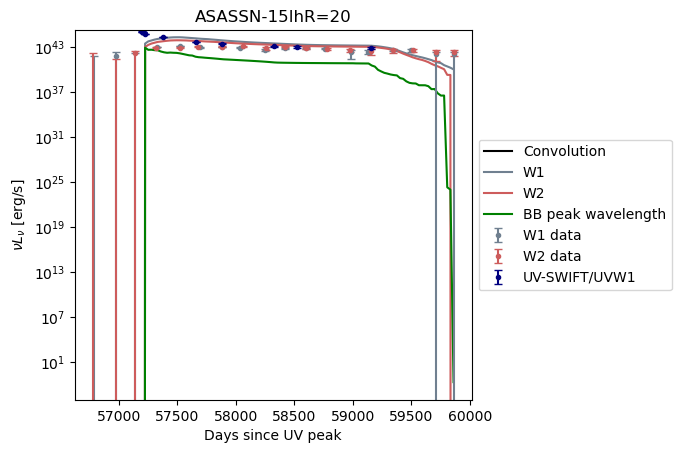

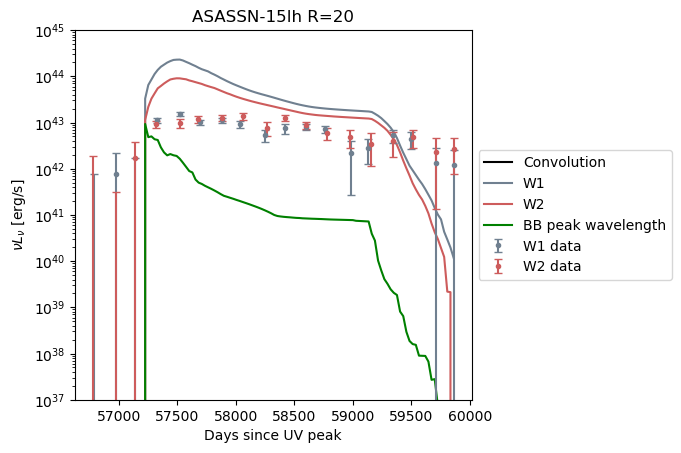

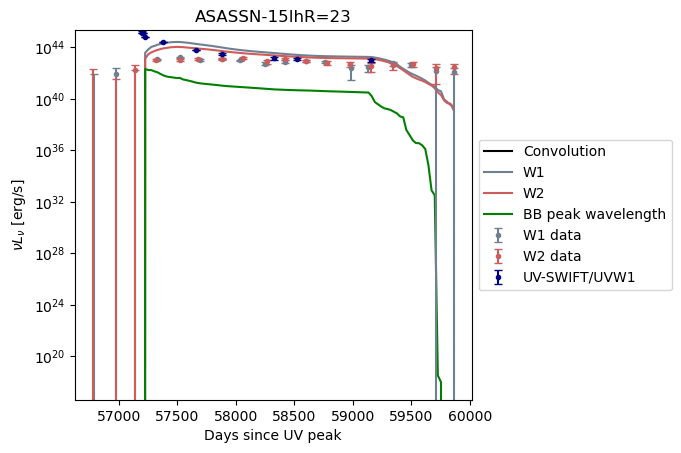

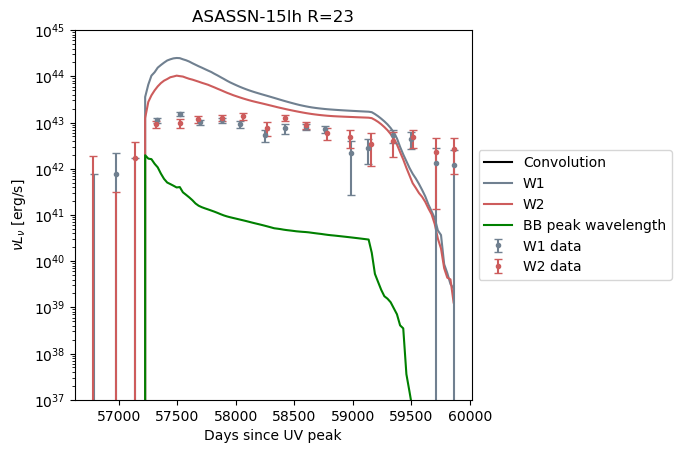

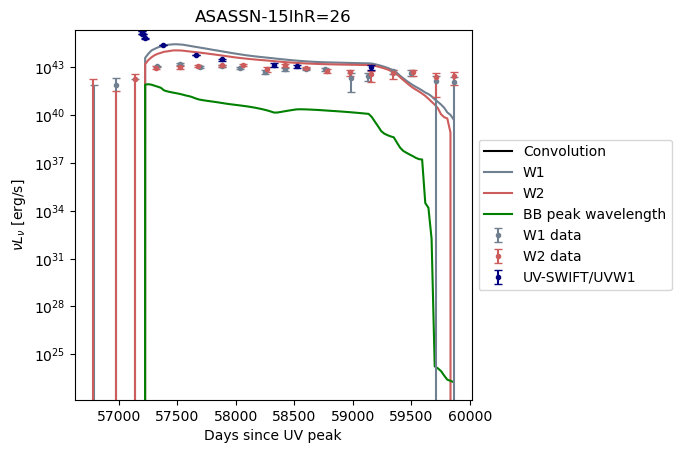

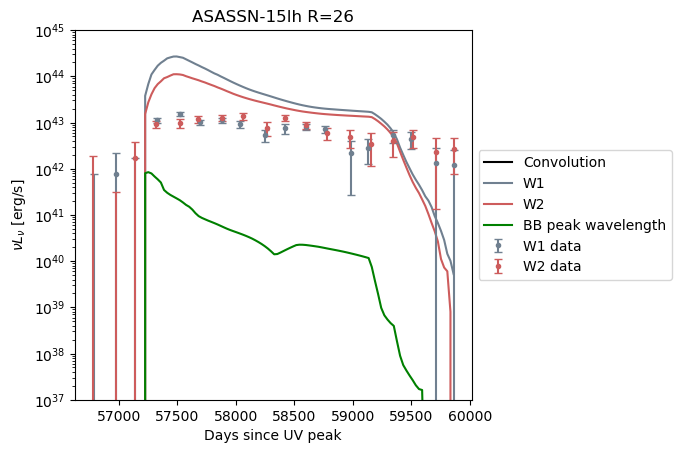

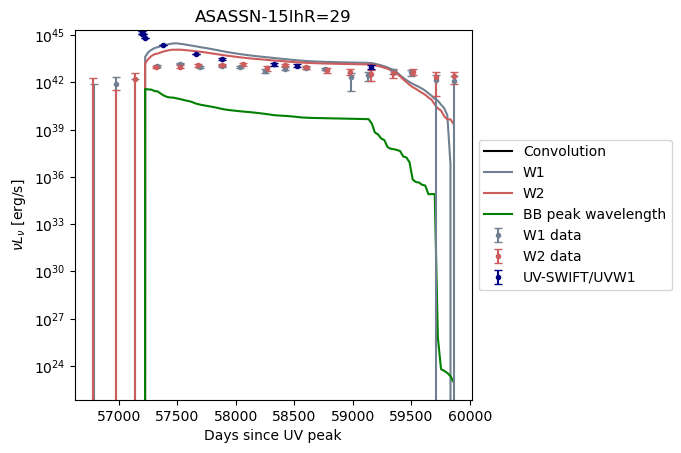

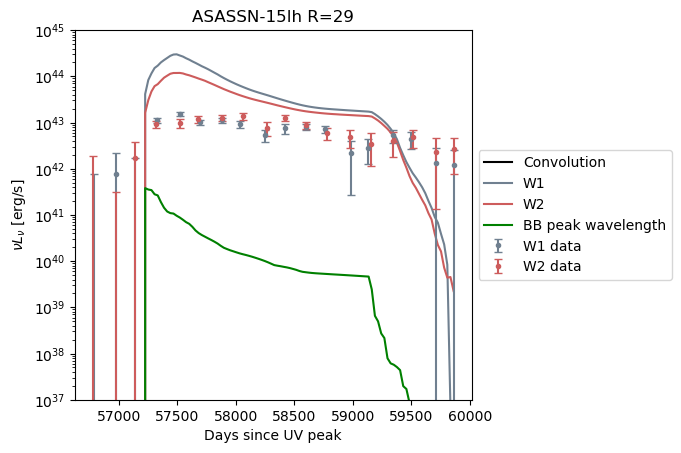

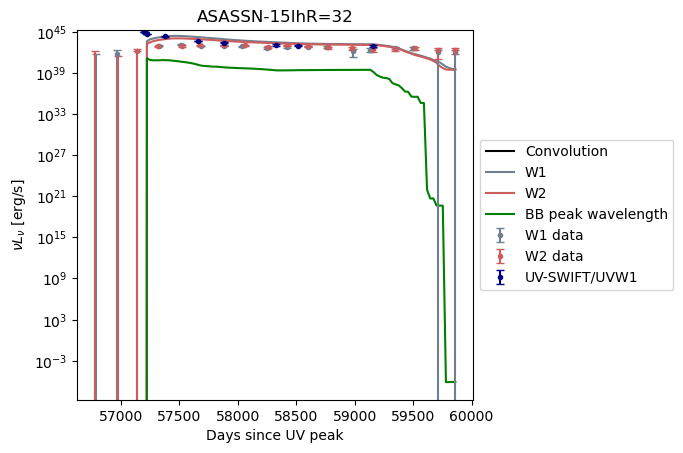

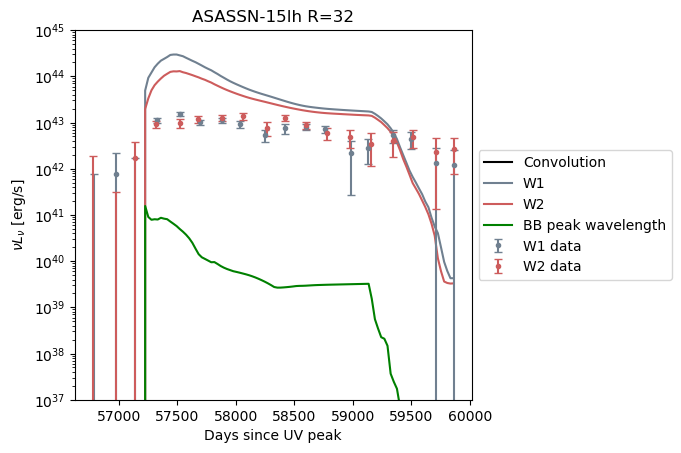

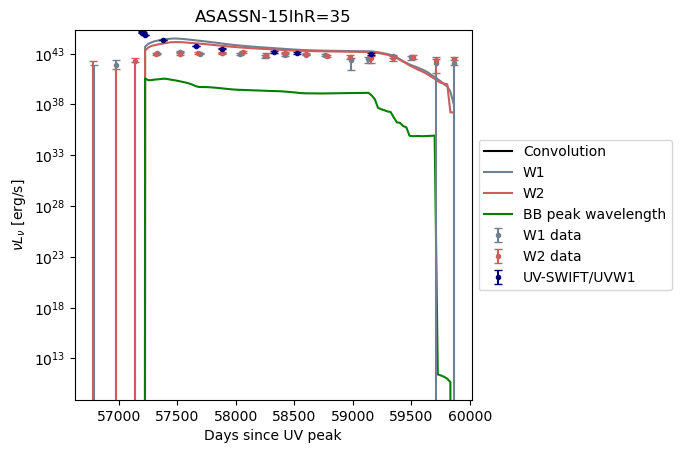

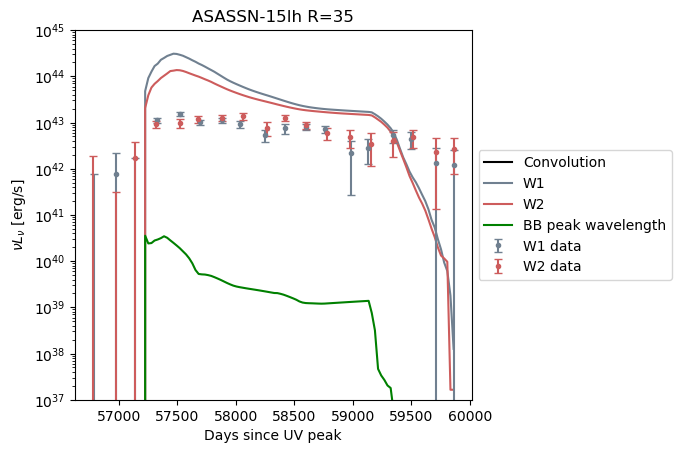

In [27]:
#Applying the covering factor
cover = False
for i in radius:
    coveringFactor=np.max(W1[1]*u.erg/u.s/u.Hz)/luminosity_total[i][np.argmin(np.abs(output_t-W1[0,np.argmax(W1[1])])),w1]
    luminosity_cov = luminosity_total[i] * coveringFactor

    #Setting up the convolution
    conv_time,conv_lum = convolution(centralBin,L[1][sorted_indices],L[0][sorted_indices])

    #Making lightcurve plot including the SWIFT data
    fig=plt.figure()
    ax=plt.subplot(111)

    #Plotting the convolution
    ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

    #Plotting the lightcurves
    ax.plot(output_t,((c.c/wl_w1)*luminosity_total[i][:,w1]).to(u.erg/u.s),label='W1',color='slategrey')
    ax.plot(output_t,((c.c/wl_w2)*luminosity_total[i][:,w2]).to(u.erg/u.s),label='W2',color='indianred')
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_total[i][:,bbwl_i]).to(u.erg/u.s),label='BB peak wavelength',color='green')
    
    #Plotting the lightcurves with covering factors if wanted
    if cover:
        ax.plot(output_t,((c.c/wl_w1)*luminosity_cov[:,w1]).to(u.erg/u.s),label='W1 fit',color='slategrey',ls='--')
        ax.plot(output_t,((c.c/wl_w2)*luminosity_cov[:,w2]).to(u.erg/u.s),label='W2 fit',color='indianred',ls='--')

    #Plotting data
    ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
    ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
    ax.errorbar(L_data[0],L_data[1],yerr=L_data[2],fmt='.',color='navy',capsize=3,label='UV-SWIFT/UVW1')

    ax.set_yscale('log')
    ax.set_ylim(bottom=np.min(np.concatenate([W1[1],W2[1]])),top=1.1*np.max(L_data[1]))
    #ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Days since UV peak')
    ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
    ax.set_title(target+f'R={i}')
    if cover:
        fig.savefig(PLOTFILES+f'/lightcurve_cov_SWIFT_changingR={i}.pdf')
    else:
        fig.savefig(PLOTFILES+f'/lightcurve_SWIFT_changingR={i}.pdf')
    fig.show()
    
    #Making lightcurve plot without the SWIFT data
    fig=plt.figure()
    ax=plt.subplot(111)
    
    #Plotting the convolution
    ax.plot(conv_time,conv_lum,label = 'Convolution',color='black')

    #Plotting the lightcurves
    ax.plot(output_t,((c.c/wl_w1)*luminosity_total[i][:,w1]).to(u.erg/u.s),label='W1',color='slategrey')
    ax.plot(output_t,((c.c/wl_w2)*luminosity_total[i][:,w2]).to(u.erg/u.s),label='W2',color='indianred')
    ax.plot(output_t,((c.c/(bbwl*u.um))*luminosity_total[i][:,bbwl_i]).to(u.erg/u.s),label='BB peak wavelength',color='green')
    
    #Plotting the lightcurves with covering factors
    if cover:
        ax.plot(output_t,((c.c/wl_w1)*luminosity_cov[:,w1]).to(u.erg/u.s),label='W1 fit',color='slategrey',ls='--')
        ax.plot(output_t,((c.c/wl_w2)*luminosity_cov[:,w2]).to(u.erg/u.s),label='W2 fit',color='indianred',ls='--')
    
    #Plotting W1&2 data
    ax.errorbar(W1[0],(c.c/wl_w1).to(u.Hz).value*W1[1],yerr=(c.c/wl_w1).to(u.Hz).value*W1[2],fmt='.',capsize=3,label='W1 data',color='slategrey')
    ax.errorbar(W2[0],(c.c/wl_w2).to(u.Hz).value*W2[1],yerr=(c.c/wl_w2).to(u.Hz).value*W2[2],fmt='.',capsize=3,label='W2 data',color='indianred')
    
    ax.set_yscale('log')
    #ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
    ax.set_ylim(bottom=1e37,top=1e45)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Days since UV peak')
    ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
    ax.set_title(target+f' R={i}')
    if cover:
        fig.savefig(PLOTFILES+f'/lightcurve_cov_noSWIFT_changingR={i}.pdf')
    else:
        fig.savefig(PLOTFILES+f'lightcurve_noSWIFT_changingR={i}.pdf')
    fig.show()

21/05/2024 16:24:02.031 ! /var/tmp/lankhorst/ipykernel_1080822/1530328153.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
21/05/2024 16:24:02.031 !   fig.show()
21/05/2024 16:24:02.031 ! /var/tmp/lankhorst/ipykernel_1080822/1530328153.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
21/05/2024 16:24:02.031 !   fig.show()


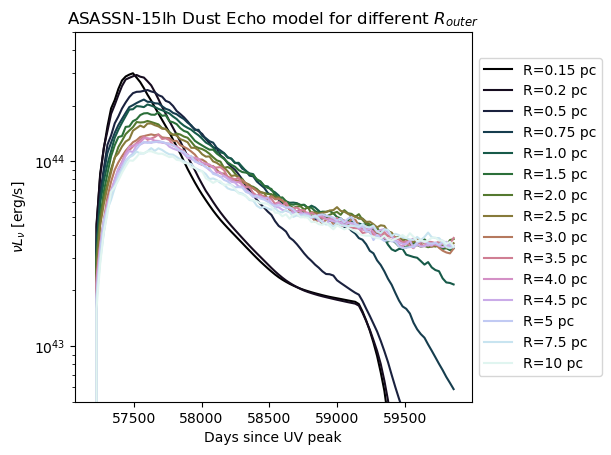

In [21]:
#Applying the covering factor
fig=plt.figure()
ax=plt.subplot(111)

cmap = plt.get_cmap('cubehelix')
j=0
for i in radius:    
    #Plotting the lightcurves
    color = cmap(j/len(radius)) #Get the color from the colormap
    
    #Plotting the lightcurves
    ax.plot(output_t,((c.c/wl_w1)*luminosity_total[i][:,w1]).to(u.erg/u.s),label=f'R={i} pc',color=color)
    j+=1

ax.set_yscale('log')
ax.set_ylim(bottom=5e42,top=5e44)
#ax.set_xlim(np.min(W1[0]*0.9),1.1*np.max(np.concatenate((W1[0],W2[0],output_t))))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target+' Dust Echo model for different $R_{outer}$')    
if cover:
    fig.savefig(PLOTFILES+f'/lightcurve_cov_SWIFT_changingR.pdf')
else:
    fig.savefig(PLOTFILES+f'/lightcurve_SWIFT_changingR.pdf')
fig.show()

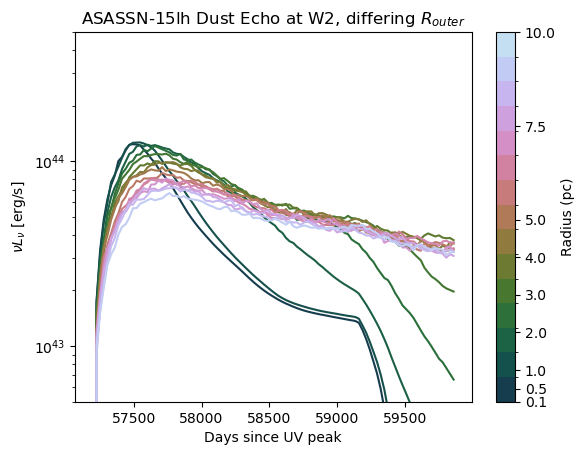

In [22]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

min_val, max_val = 0.2,0.85
n=len(radius)
colors = plt.cm.cubehelix(np.linspace(min_val, max_val, n))
cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", colors)

# Applying the covering factor
fig, ax = plt.subplots()

# Create a discrete colormap
num_colors = len(radius)
#cmap = plt.get_cmap('cubehelix', num_colors)  # Use a colormap with discrete colors
#cmap = cm.cubehelix.make_cmap(start=0.5, rot=-0.75, gamma=1.0, dark=0.2, light=0.8, reverse=False)
bounds = np.linspace(min(radius), max(radius), num_colors + 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
scalarmap = cm.ScalarMappable(norm=norm, cmap=cmap)

for i, r in enumerate(radius):
    # Plotting the lightcurves
    color = cmap(i / num_colors)
    
    ax.plot(output_t, ((c.c/wl_w2)*luminosity_total[r][:,w2]).to(u.erg/u.s), color=color)

ax.set_yscale('log')
ax.set_ylim(bottom=5e42, top=5e44)
ax.set_xlabel('Days since UV peak')
ax.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')
ax.set_title(target + ' Dust Echo at W2, differing $R_{outer}$')    

# Add colorbar with discrete ticks
scalarmap.set_array([])
#cbar = fig.colorbar(scalarmap, ax=ax, boundaries=bounds, ticks=radius)
cbar = fig.colorbar(scalarmap, ax=ax, boundaries=bounds)

tick_values = [0.15,0.5,1.0,2.0,3.0,4.0,5,7.5,10]
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values])

cbar.set_label('Radius (pc)')

# Save and show the figure
if cover:
    fig.savefig(PLOTFILES + f'/lightcurve_cov_SWIFT_changingR.pdf')
else:
    fig.savefig(PLOTFILES + f'/lightcurve_noSWIFT_changingR_W2.pdf')

plt.show()

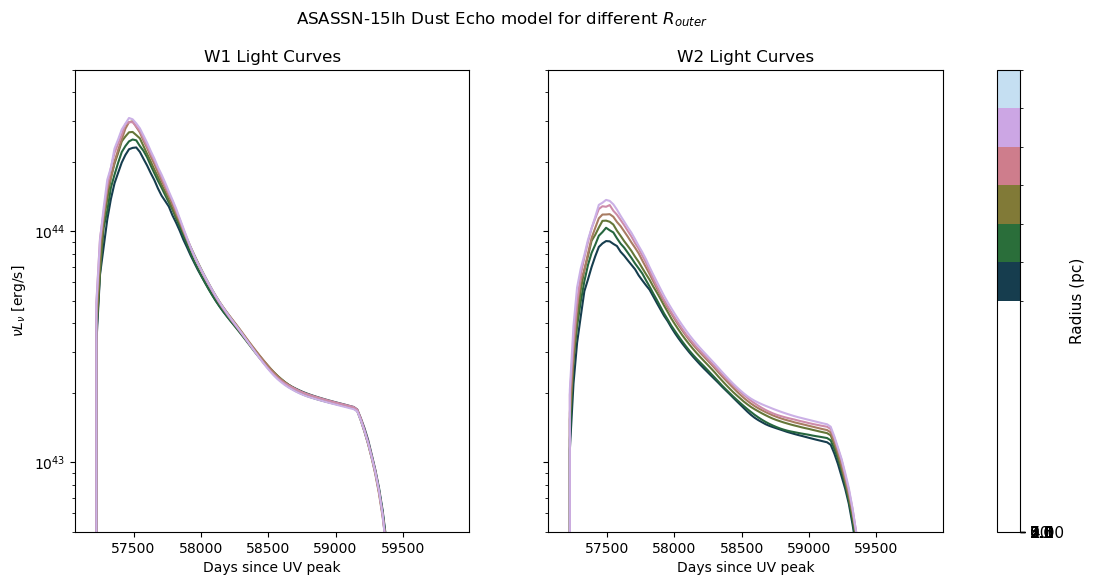

In [38]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
cover=False
# min_val, max_val = 0.2,0.85
n=len(radius)
min_val, max_val = 0.2,0.85
colors = plt.cm.cubehelix(np.linspace(min_val, max_val, n))
cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", colors)


#num_colors = len(radius)
#bounds = np.linspace(min(radius), max(radius), num_colors + 1)
#norm = mcolors.BoundaryNorm(bounds, cmap.N)
#scalarmap = cm.ScalarMappable(norm=norm, cmap=cmap)

bounds = np.linspace(min(radius), max(radius), n + 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
scalarmap = cm.ScalarMappable(norm=norm, cmap=cmap)

# Applying the covering factor
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))

for i, r in enumerate(radius):
    color = cmap(i / n)
    
    ax1.plot(output_t, ((c.c/wl_w1)*luminosity_total[r][:,w1]).to(u.erg/u.s), color=color, label=f'R={r} pc')
    ax2.plot(output_t, ((c.c/wl_w2)*luminosity_total[r][:,w2]).to(u.erg/u.s), color=color)

# Set common y-axis scale
ax1.set_yscale('log')
ax1.set_ylim(bottom=5e42, top=5e44)

# Set x-axis labels
ax1.set_xlabel('Days since UV peak')
ax2.set_xlabel('Days since UV peak')

# Set y-axis label
ax1.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')

# Set titles
ax1.set_title('W1 Light Curves')
ax2.set_title('W2 Light Curves')

# Add colorbar with customized ticks
scalarmap.set_array([])
cbar = fig.colorbar(scalarmap, ax=[ax1, ax2], boundaries=bounds)
tick_values = [0.15,0.5,1.0,2.0,3.0,4.0,5,7.5,10]
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values],fontsize=11)
cbar.set_label('Radius (pc)',fontsize=11)
#cbar.set_label('Radius (pc)')

# Set the main title
fig.suptitle(target + ' Dust Echo model for different $R_{outer}$',x=.43)

# Save and show the figure
if cover:
    fig.savefig(PLOTFILES + f'/lightcurve_cov_SWIFT_changingR.pdf')
else:
    fig.savefig(PLOTFILES + f'/lightcurve_SWIFT_changingR_W1W2.pdf')

plt.show()

### For Tau

In [24]:
unitL=u.erg/u.s/u.Hz

wavelengths = np.sort(np.concatenate((np.linspace(0.01, 1, 50), np.linspace(1.01, 10, 100), \
                                              np.linspace(10.01, 50, 100),w1w2,bbwl)))

radius = [20,23,26,29,32,35]


file_loc = '/net/vdesk/data2/schoof_lankhorst/Project/results/ASASSN-15lh/2024-04-17_p/1839/ChangingTau'
luminosity_total = {}
for i in radius:
    luminosity_total[i]=np.genfromtxt(file_loc+str(f'/tau={i}/luminosity_data.txt'),delimiter = ' ') * unitL

In [25]:
# indices corresponding to the WISE filter and black body peak wavelengths
w1=np.argmin(np.abs(wavelengths-wl_w1.value))
w2=np.argmin(np.abs(wavelengths-wl_w2.value))
bbwl_i=np.argmin(np.abs(wavelengths-bbwl))

# Convert the lightcurve to luminosity
#luminosity=FluxtoLum(lightcurve,distance=distance)
# Calculate the covering factor
# in this simulation a spherical dust shell is used,
# as we expect a clumpy dust structure a covering factor is applied to account for the higher luminosity.

#coveringFactor=np.max(W1[1]*u.erg/u.s/u.Hz)/luminosity[np.argmin(np.abs(output_t-W1[0,np.argmax(W1[1])])),w1]

# Save the data
#log_.write('amax='+str(amax)+', grainpowerlaw='+str(grainpowerlaw)+', coveringFactor='+str(coveringFactor)+', sublimation radius='+str(np.min(radius))+', T_min='+np.array2string(np.array(temp),max_line_width=len(temp)*100))
#log_.write('\n')
#if os.path.isdir(OUTFILES_+'GridSearch/')==False:
#    os.makedirs(OUTFILES_+'GridSearch/')
#if os.path.isdir(PLOTFILES_+'/')==False:
#    os.makedirs(PLOTFILES_+'/')

#np.savetxt(OUTFILES_+'config.txt',luminosity.value)

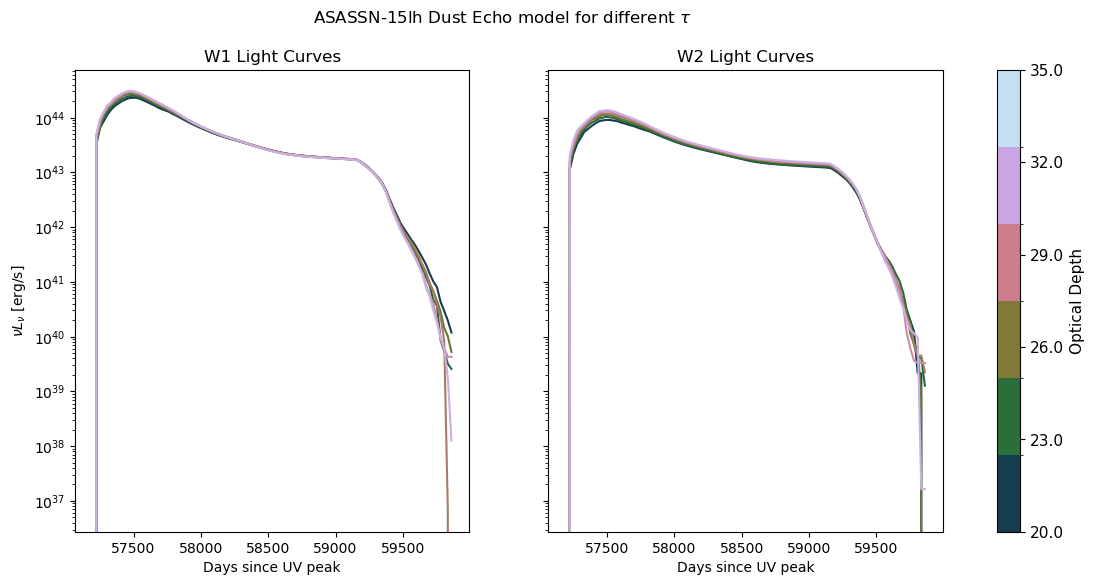

In [40]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
cover=False
# min_val, max_val = 0.2,0.85
n=len(radius)
min_val, max_val = 0.2,0.85
colors = plt.cm.cubehelix(np.linspace(min_val, max_val, n))
cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", colors)


#num_colors = len(radius)
#bounds = np.linspace(min(radius), max(radius), num_colors + 1)
#norm = mcolors.BoundaryNorm(bounds, cmap.N)
#scalarmap = cm.ScalarMappable(norm=norm, cmap=cmap)

bounds = np.linspace(min(radius), max(radius), n + 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
scalarmap = cm.ScalarMappable(norm=norm, cmap=cmap)

# Applying the covering factor
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))

for i, r in enumerate(radius):
    color = cmap(i / n)
    
    ax1.plot(output_t, ((c.c/wl_w1)*luminosity_total[r][:,w1]).to(u.erg/u.s), color=color, label=f'R={r} pc')
    ax2.plot(output_t, ((c.c/wl_w2)*luminosity_total[r][:,w2]).to(u.erg/u.s), color=color)

# Set common y-axis scale
ax1.set_yscale('log')
#ax1.set_ylim(bottom=1e43, top=5e44)

# Set x-axis labels
ax1.set_xlabel('Days since UV peak')
ax2.set_xlabel('Days since UV peak')

# Set y-axis label
ax1.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')

# Set titles
ax1.set_title('W1 Light Curves')
ax2.set_title('W2 Light Curves')

# Add colorbar with customized ticks
scalarmap.set_array([])
cbar = fig.colorbar(scalarmap, ax=[ax1, ax2], boundaries=bounds)
tick_values = [20,23,26,29,32,35]
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values],fontsize=11)
cbar.set_label(r'Optical Depth',fontsize=11)
#cbar.set_label('Radius (pc)')

# Set the main title
fig.suptitle(target + r' Dust Echo model for different $\tau$',x=.43)

# Save and show the figure
if cover:
    fig.savefig(PLOTFILES + f'/lightcurve_cov_SWIFT_changingTauW1W2.pdf')
else:
    fig.savefig(PLOTFILES + f'/lightcurve_SWIFT_changingTau_W1W2.pdf')

plt.show()


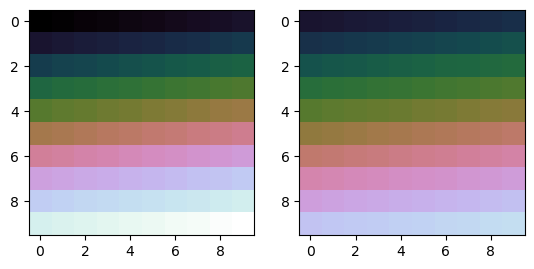

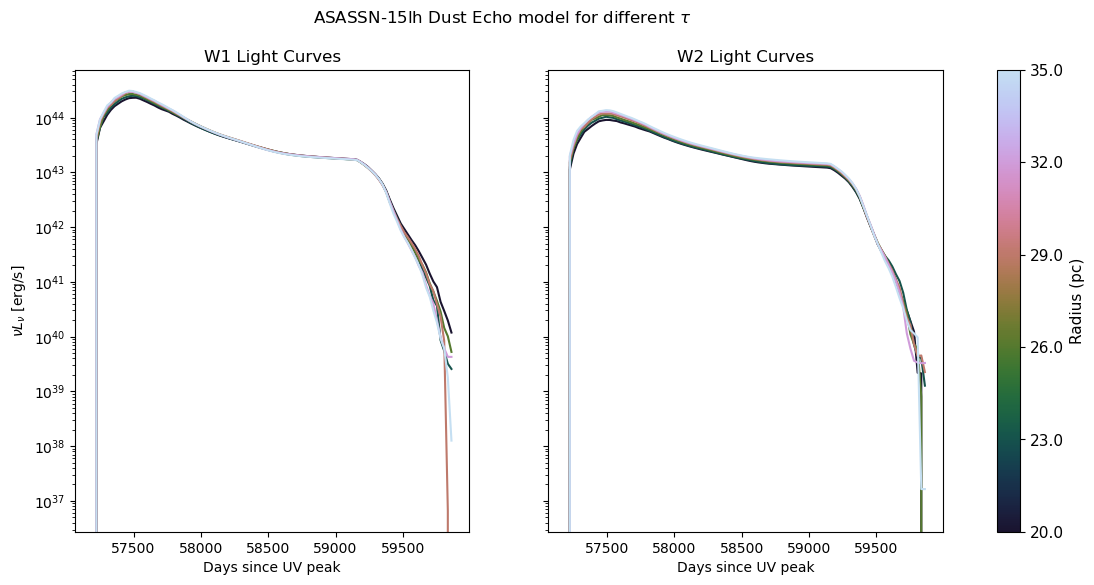

In [66]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
    
cmap = plt.get_cmap('cubehelix')
thesis_cmap = truncate_colormap(cmap, 0.1, 0.85)

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(arr, interpolation='nearest', cmap='cubehelix')
ax[1].imshow(arr, interpolation='nearest', cmap=thesis_cmap)
plt.show()

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
cmap = thesis_cmap

# Normalize the radius values for the color mapping
norm = Normalize(vmin=min(radius), vmax=max(radius))

for i, r in enumerate(radius):
    color = cmap(norm(r))  # Use normalized radius value to get color
    ax1.plot(output_t, ((c.c / wl_w1) * luminosity_total[r][:, w1]).to(u.erg / u.s), color=color, label=f'R={r} pc')
    ax2.plot(output_t, ((c.c / wl_w2) * luminosity_total[r][:, w2]).to(u.erg / u.s), color=color)

# Set common y-axis scale
ax1.set_yscale('log')
# ax1.set_ylim(bottom=1e43, top=5e44)

# Set x-axis labels
ax1.set_xlabel('Days since UV peak')
ax2.set_xlabel('Days since UV peak')

# Set y-axis label
ax1.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')

# Set titles
ax1.set_title('W1 Light Curves')
ax2.set_title('W2 Light Curves')

# Create ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You can pass an empty array to set_array

# Add colorbar to the figure
cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation='vertical')
tick_values = [20, 23, 26, 29, 32, 35]
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values], fontsize=11)
cbar.set_label('Radius (pc)', fontsize=11)

# Set the main title
fig.suptitle(target + r' Dust Echo model for different $\tau$', x=.43)

# Save and show the figure
if cover:
    fig.savefig(PLOTFILES + f'/lightcurve_cov_SWIFT_changingTauW1W2.pdf')
else:
    fig.savefig(PLOTFILES + f'/lightcurve_SWIFT_changingTau_W1W2.pdf')

plt.show()

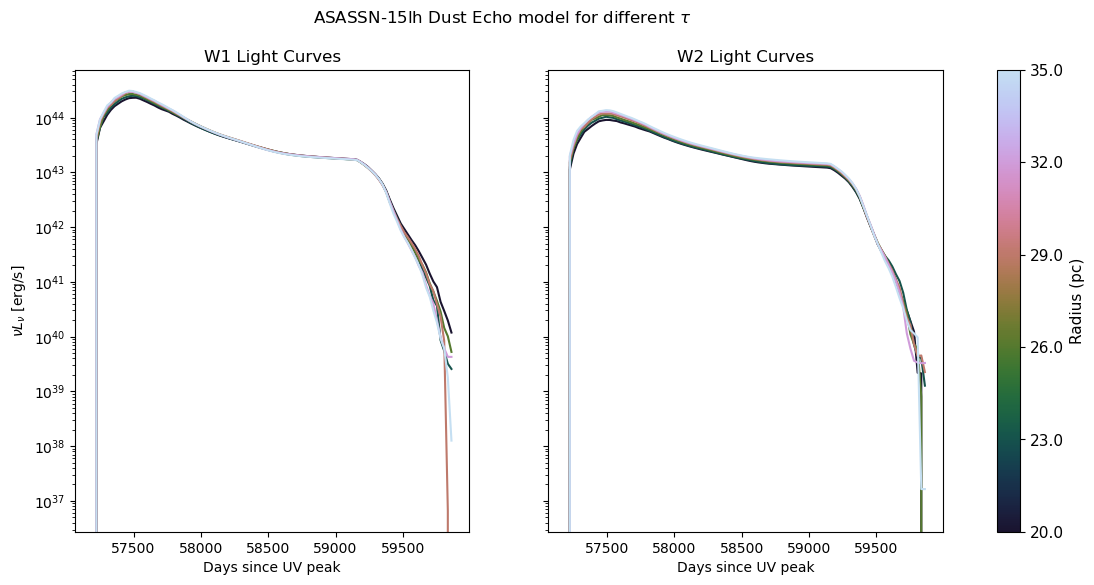

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
cmap = thesis_cmap

# Normalize the radius values for the color mapping
norm = Normalize(vmin=min(radius), vmax=max(radius))

for i, r in enumerate(radius):
    color = cmap(norm(r))  # Use normalized radius value to get color
    ax1.plot(output_t, ((c.c / wl_w1) * luminosity_total[r][:, w1]).to(u.erg / u.s), color=color, label=f'R={r} pc')
    ax2.plot(output_t, ((c.c / wl_w2) * luminosity_total[r][:, w2]).to(u.erg / u.s), color=color)

# Set common y-axis scale
ax1.set_yscale('log')
# ax1.set_ylim(bottom=1e43, top=5e44)

# Set x-axis labels
ax1.set_xlabel('Days since UV peak')
ax2.set_xlabel('Days since UV peak')

# Set y-axis label
ax1.set_ylabel(r'$\nu L_{\nu}$ [erg/s]')

# Set titles
ax1.set_title('W1 Light Curves')
ax2.set_title('W2 Light Curves')

# Create ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You can pass an empty array to set_array

# Add colorbar to the figure
cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation='vertical')
tick_values = [20, 23, 26, 29, 32, 35]
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{r:.1f}' for r in tick_values], fontsize=11)
cbar.set_label('Radius (pc)', fontsize=11)

# Set the main title
fig.suptitle(target + r' Dust Echo model for different $\tau$', x=.43)

# Save and show the figure
if cover:
    fig.savefig(PLOTFILES + f'/lightcurve_cov_SWIFT_changingTauW1W2.pdf')
else:
    fig.savefig(PLOTFILES + f'/lightcurve_SWIFT_changingTau_W1W2.pdf')

plt.show()